In [1]:
import pandas as pd, numpy as np
import re
#import pysam, re
from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# 0.DateFrame constrution

In [26]:
def read_bam(bam_p):
    reads = pysam.AlignmentFile(bam_p, "rb")
    data = defaultdict(dict)
    for read in reads:
        data[read.qname]["chrom"] = read.reference_name
        #data[read.qname]["CIGAR"] = read.cigarstring
        data[read.qname]["alen"] = read.alen
        data[read.qname]["quality"] = read.mapping_quality
        if read.is_reverse:
            data[read.qname]["strand"] = "-"
        else:
            data[read.qname]["strand"] = "+"
        data[read.qname]["ref_st"] = read.reference_start + 1
        data[read.qname]["ref_ed"] = read.reference_end + 1
    reads.close()
    return data


def get_gene_len(gff_fp):
    gff_data = defaultdict(dict)
    data = {}
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o = info[:-1]
            if info[2] in ["gene", "pseudogene", "transposable_element_gene"]:
                gene = re.findall("ID=(.*?);", info[-1])[0]
                gff_data[gene] = [int(st), int(ed)]
            else:
                pass
            if info[2] == "exon":
                gene = re.findall(r'Parent=(.*?);', line)[0].split(".")[0]
                data.setdefault(gene, 0)
                cd = int(info[4]) - int(info[3]) + 1
                data[gene] += cd
    return gff_data, data


def get_gene_strand(gff_fp):
    gff_data = defaultdict(dict)
    gff_chr = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o = info[:-1]
            if info[2] in ["gene", "pseudogenic_transcript", "transposable_element_gene"]:
                gene = re.findall("ID=(.*?);", info[-1])[0]
                gff_data[gene] = strand
                gff_chr[gene] = chrome
            else:
                pass
    return gff_data, gff_chr

In [27]:
gff_fp = "/media/Sorata/win/genome/Bamboo.Hic.gff"
gff_len, exon_len = get_gene_len(gff_fp)
gff_strand, gff_chr = get_gene_strand(gff_fp)

### Mapping minimap2 

In [7]:
df = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/{sample}_correct_{rep}.sort.bam"
        bam = read_bam(fp)
        bam_turn = pd.DataFrame.from_dict(bam, orient='index')
        bam_turn["sample"] = sample
        bam_turn["rep"] = rep
        df = pd.concat([df, bam_turn])
    print(sample, "Finish")

DMSO Finish
DZnepA Finish
5-azaC Finish


### Estimate poly(A) tail length by nanopolish

In [8]:
p = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/apa/{sample}_{rep}.apa"
        poly = pd.read_csv(fp, sep="\t", usecols=["readname", "polya_length", "qc_tag"], index_col=0)
        p = pd.concat([p, poly])
    print(sample, "poly(A) tail Finish")
df = pd.concat([df, p], axis=1, join="outer")
df = df[df["chrom"].notna()]

DMSO poly(A) tail Finish
DZnepA poly(A) tail Finish
5-azaC poly(A) tail Finish


### Assigned reads through featurecount

In [9]:
assign = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/featureCount/{sample}_correct_{rep}.sort.bam.featureCounts"
        f = pd.read_csv(fp, sep="\t", index_col=0, header=None, usecols=[0,3], names=["read_name", "Assigned_gene"])
        assign = pd.concat([assign, f])
    print(sample, "FeatureCount Assigned Gene Finish")
df = pd.concat([df, assign], axis=1, join="outer")

DMSO FeatureCount Assigned Gene Finish
DZnepA FeatureCount Assigned Gene Finish
5-azaC FeatureCount Assigned Gene Finish


### NAT Nature Anti-Transcript

In [10]:
for label, reads in df.groupby("Assigned_gene"):
    if label:
        df.loc[reads.index, "NAT"] = reads.apply(lambda x:False if x["strand"] == gff_strand[x["Assigned_gene"]] else True, axis=1)

In [11]:
assign = df[df["NAT"] == False]
assign[["alen", "ref_st", "ref_ed", "quality"]] = assign[["alen", "ref_st", "ref_ed", "quality"]].astype(int)

/tmp/ipykernel_50648/221226386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign[["alen", "ref_st", "ref_ed", "quality"]] = assign[["alen", "ref_st", "ref_ed", "quality"]].astype(int)


### Full-length ratio

In [310]:
def get_cds(gff_fp):
    data = {}
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "CDS":
                gene = des.split(";")[0].split(".")[0].split("=")[1]
                data.setdefault(gene,[]).append([int(st), int(ed)])
    return data


def mark_full(x,phar,num=20):
    '''
    ref_st : the position in read to the translation start site
    '''
    gene = x["Assigned_gene"]
    phar.update(1)
    if gff_strand[gene] == "+":
        pos = x["ref_st"] - cds_start[gene]
        if  pos <= num:
            return True
        else:
            return False
    else:
        pos = x["ref_ed"] - cds_start[gene]
        if pos >= -num:
            return True
        else:
            return False


def calculate_read_percent(x, phar):
    st, ed = gff_len[x["Assigned_gene"]]
    phar.update(1)
    per = x["alen"] / abs(st -ed + 1)
    return round(per, 4)


    
gff_cds = get_cds(gff_fp)
#####
##### mark the start point of translation
##### 
cds_start = {}
for gene, values in gff_cds.items():
    strand = gff_strand[gene]
    if strand == "+":
        cds_start[gene] = gff_cds[gene][0][0]
    else:
        cds_start[gene] = gff_cds[gene][0][1]

In [311]:
gff_cds

{'PH02Gene00001': [[34778847, 34779045], [34779167, 34779666]],
 'PH02Gene00002': [[34783215, 34783231],
  [34783534, 34783620],
  [34784795, 34784900]],
 'PH02Gene00003': [[34784941, 34785335],
  [34785483, 34785648],
  [34785737, 34785860],
  [34785944, 34786056],
  [34786173, 34786796],
  [34788052, 34788342],
  [34788485, 34788574],
  [34788690, 34789181]],
 'PH02Gene00004': [[34791557, 34792201],
  [34792382, 34792573],
  [34792674, 34792880],
  [34793002, 34793430],
  [34793534, 34793761],
  [34793839, 34794034],
  [34794563, 34795223],
  [34796161, 34796347]],
 'PH02Gene00005': [[34848570, 34848592], [34849137, 34849689]],
 'PH02Gene00006': [[34863454, 34863553],
  [34863260, 34863375],
  [34862326, 34862457],
  [34862167, 34862240],
  [34861994, 34862099],
  [34861830, 34861898],
  [34861349, 34861413],
  [34861138, 34861236],
  [34860847, 34860946],
  [34860133, 34860195]],
 'PH02Gene00007': [[34893879, 34894940],
  [34895653, 34896108],
  [34901994, 34902275]],
 'PH02Gene0000

In [312]:
phar = tqdm(total=len(assign))
assign.loc[assign.index, "Full_length"] = assign.apply(mark_full, args=(phar,), axis=1)
phar.close()

  0%|          | 0/8142865 [00:00<?, ?it/s]

/tmp/ipykernel_50648/2625618050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign.loc[assign.index, "Full_length"] = assign.apply(mark_full, args=(phar,), axis=1)
/tmp/ipykernel_50648/2625618050.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  assign.loc[assign.index, "Full_length"] = assign.apply(mark_full, args=(phar,), axis=1)


In [313]:
phar = tqdm(total=len(assign))
assign.loc[assign.index, "Read_percent"] = assign.apply(calculate_read_percent, args=(phar,), axis=1)
phar.close()

  0%|          | 0/8142865 [00:00<?, ?it/s]

/tmp/ipykernel_50648/1919486291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign.loc[assign.index, "Read_percent"] = assign.apply(calculate_read_percent, args=(phar,), axis=1)


### Calculate Poly(A) Site

In [302]:
def get_apa_site(raw_apa, minread_cover=3, apa_gap=30, apa_width=12, use_per=0, mini_per=0.02):
    apa_result = {}
    for gene, sites in raw_apa.items():
        apa_sites = Counter(sites)
        minicover = int(len(sites) * mini_per)
        if minicover < minread_cover:
            minicover = minread_cover
        apa_sites = {site:num for site,num in apa_sites.items() if num >= minicover}
        if len(apa_sites) < 1:
            continue
            
        ######
        ###### select apa site from gap
        ######
        fliter_sites_list = sorted(apa_sites.items(), key=lambda x:x[1], reverse=True)
        apa_sites = {}
        for x,num in fliter_sites_list:
            flag = []
            for site in apa_sites:
                flag.append(abs(x - site))
            mark = [x for x in flag if 0< x < apa_gap]
            if len(mark) == 0:
                apa_sites[x] = []
        
        ######
        ###### count site round apa sites
        ######
        for site in sites:
            for apa_site in apa_sites:
                if site in range(apa_site - apa_width, apa_site + apa_width):
                    apa_sites[apa_site].append(site)
                    
        ######
        ###### fliter used apa site  
        ######
        apa_sec = {}
        if use_per:
            for site, num in apa_sites.items():
                if (len(num) / len(sites)) >= use_per:
                    apa_sec[site] = num
        else:
            apa_sec = apa_sites
        apa_result[gene] = apa_sec
    return apa_result


def get_gene(x,data, phar):
    gene = x["Assigned_gene"]
    read_strand = x["strand"]
    if read_strand != gff_strand[gene]:
        return phar.update(1)
    if gff_strand[gene] == "+":
        data.setdefault(x["Assigned_gene"], []).append(x["ref_ed"])
    else:
        data.setdefault(x["Assigned_gene"], []).append(x["ref_st"])
    phar.update(1)


    
def merged_apa_count(assign, minread_cover=3, apa_gap=30, apa_width=12, use_per=0.05, mini_per=0):
    ############################################
    ### merge all samples to fliter APA site ###
    ############################################
    data = defaultdict(dict)
    phar = tqdm(total=len(assign))
    assign.apply(get_gene, axis=1, args=(data,phar,))
    phar.close()
    #########
    #########
    apa_site = get_apa_site(data, minread_cover=minread_cover, apa_gap=apa_gap, apa_width=apa_width, use_per=use_per, mini_per=mini_per)
    for gene, sites in apa_site.copy().items():
        for site, lt in sites.items():
            apa_site[gene][site] = len(lt)
    with open("All_sample.polyA-site", 'w') as f:
        f.write(f"###\tminread_cover:{minread_cover}\tapa_gap:{apa_gap}\tapa_width:{apa_width}\teach_apa_use_precent:{use_per}\tmini_read%:{mini_per}\n")
        for gene, sites in sorted(apa_site.items()):
            text = f"{gene}"
            for site, num in sites.items():
                text += f"\t{site}:{num}"
            text += "\n"
            f.write(text)

In [303]:
merged_apa_count(assign)

  0%|          | 0/8142865 [00:00<?, ?it/s]

### Assinged poly(A) site to reads

In [306]:
def select_apa(df, apa):
    for site in apa:
        if site-apa_width <= df["read_ed"] <= site+apa_width:
            return site
    return 0

#### 
#### Reading the file generated from step 6.1
####
merge_apa = defaultdict(dict)
with open("All_sample.polyA-site", 'r') as f:
    next(f)
    for line in f:
        info = line.rstrip().split("\t")
        gene, num = info[0], len(info[1:])
        if num == 0:
            continue
        for txt in info[1:]:
            site, num = txt.split(":")
            merge_apa[gene][int(site)] = int(num)
######
######   APA Gap
######
apa_width = 12
print("APA Gap:",apa_width)

phar = tqdm(total=len(assign))

for sample, samples in assign.groupby("sample"):
    for gene, genes in samples.groupby("Assigned_gene"):
        strand = gff_strand[gene]
        if strand == "+":
            genes["read_ed"] = genes["ref_ed"]
        else:
            genes["read_ed"] = genes["ref_st"]
        if gene in merge_apa:
            assign.loc[genes.index, "APA"] = genes.apply(select_apa, axis=1, args=(merge_apa[gene],))
        else:
            assign.loc[genes.index, "APA"] = 0
        phar.update(len(genes))
    print(sample,'Finish')

phar.close()

assign["APA"].fillna(0, inplace=True)
assign["APA"] = assign["APA"].astype(int)

APA Gap: 12


  0%|          | 0/8142865 [00:00<?, ?it/s]

/tmp/ipykernel_50648/2602695648.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign.loc[genes.index, "APA"] = genes.apply(select_apa, axis=1, args=(merge_apa[gene],))


5-azaC Finish
DMSO Finish
DZnepA Finish


/tmp/ipykernel_50648/2602695648.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign["APA"].fillna(0, inplace=True)
/tmp/ipykernel_50648/2602695648.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assign["APA"] = assign["APA"].astype(int)


In [318]:
order = ["chrom", "alen", "ref_st", "ref_ed", "strand", "quality", "polya_length", "qc_tag", "Assigned_gene", "NAT", "APA","Full_length", "Read_percent", "sample", "rep"]
assign = assign[order]

In [319]:
assign

chrom  alen  ref_st  \
a14db144-5454-434e-9ebe-0ab2901849db      hic_scaffold_1  3565  342819   
c11972b9-1c2f-4d64-bc12-70707964f36c      hic_scaffold_1  3114  343633   
333ddfe2-a348-4023-900d-838a93186c1f      hic_scaffold_1   157  755648   
9f86bb68-0385-4333-a671-dae8359e84a9      hic_scaffold_1  2617  784771   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b      hic_scaffold_1  2749  784773   
...                                                  ...   ...     ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439  hic_scaffold_19684   955    4320   
faf11921-53b2-47d5-abe6-b6c4ede5aca0  hic_scaffold_19684  3592    4320   
5c2f5412-8502-46ab-8172-3b82da1696ad  hic_scaffold_19684  4131    4321   
dad05e4e-02d5-4549-8f87-5f22ca774d89  hic_scaffold_19684   485    4324   
38968bb6-921a-492b-8bf2-a7dbf2a4698b  hic_scaffold_19684  3544    4324   

                                      ref_ed strand  quality  polya_length  \
a14db144-5454-434e-9ebe-0ab2901849db  346384      +       58         40.95   
c11972b9-1c2f-4d64-bc12-70707964f36c  346747      +       60         59.91   
333ddfe2-a348-4023-900d-838a93186c1f  755805      -        0         -1.00   
9f86bb68-0385-4333-a671-dae8359e84a9  787388      +       60         95.27   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  787522      +       60         -1.00   
...                                      ...    ...      ...           ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439    5275      -       21         15.81   
faf11921-53b2-47d5-abe6-b6c4ede5aca0    7912      -        4         30.00   
5c2f5412-8502-46ab-8172-3b82da1696ad    8452      -        7         65.63   
dad05e4e-02d5-4549-8f87-5f22ca774d89    4809      -       22         63.55   
38968bb6-921a-492b-8bf2-a7dbf2a4698b    7868      -        2         38.48   

                                                qc_tag  Assigned_gene    NAT  \
a14db144-5454-434e-9ebe-0ab2901849db          SUFFCLIP  PH02Gene41925  False   
c11972b9-1c2f-4d64-bc12-70707964f36c              PASS  PH02Gene41925  False   
333ddfe2-a348-4023-900d-838a93186c1f  READ_FAILED_LOAD  PH02Gene49996  False   
9f86bb68-0385-4333-a671-dae8359e84a9              PASS  PH02Gene50548  False   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  READ_FAILED_LOAD  PH02Gene50548  False   
...                                                ...            ...    ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439              PASS  PH02Gene50871  False   
faf11921-53b2-47d5-abe6-b6c4ede5aca0              PASS  PH02Gene50871  False   
5c2f5412-8502-46ab-8172-3b82da1696ad              PASS  PH02Gene50871  False   
dad05e4e-02d5-4549-8f87-5f22ca774d89           ADAPTER  PH02Gene50871  False   
38968bb6-921a-492b-8bf2-a7dbf2a4698b              PASS  PH02Gene50871  False   

                                         APA  Full_length  Read_percent  \
a14db144-5454-434e-9ebe-0ab2901849db       0        False        0.8738   
c11972b9-1c2f-4d64-bc12-70707964f36c  346747        False        0.7632   
333ddfe2-a348-4023-900d-838a93186c1f       0        False        0.0425   
9f86bb68-0385-4333-a671-dae8359e84a9  787388         True        0.9287   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  787529         True        0.9755   
...                                      ...          ...           ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439    4320        False        0.1819   
faf11921-53b2-47d5-abe6-b6c4ede5aca0    4320        False        0.6841   
5c2f5412-8502-46ab-8172-3b82da1696ad    4320        False        0.7867   
dad05e4e-02d5-4549-8f87-5f22ca774d89    4320        False        0.0924   
38968bb6-921a-492b-8bf2-a7dbf2a4698b    4320        False        0.6749   

                                      sample   rep  
a14db144-5454-434e-9ebe-0ab2901849db    DMSO  rep1  
c11972b9-1c2f-4d64-bc12-70707964f36c    DMSO  rep1  
333ddfe2-a348-4023-900d-838a93186c1f    DMSO  rep1  
9f86bb68-0385-4333-a671-dae8359e84a9    DMSO  rep1  
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b    DMSO  rep1  
...                                      ... 

### DataFrame Complete

In [320]:
assign.to_csv("Assigned-reads.csv")

# ------------------Analysis Begin------------------

In [2]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rc('font',family='Arial')
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42

# 1.m6A Analysis

### Date prapare

In [20]:
def get_gff_data(gff_fp):
    gff_data = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o = info[:-1]
            if info[2] in ["gene"]:
                gene = re.findall("ID=(.*?);", info[-1])[0]
                gff_data[gene] = defaultdict(dict)
                continue
            elif info[2] in ["mRNA", "pseudogenic_transcript"]:
                transcipt_id = re.findall("ID=(.*?);", info[-1])[0]
                gff_data[gene] = {
                    "strand": strand,
                    "mrna": [int(st), int(ed)],
                    "CDS": [],
                    "3UTR": [],
                    "5UTR": []
                }
                continue
            if "Parent" in info[-1]:
                transcipt_id = re.findall("Parent=(.*?);", info[-1])[0].split(",")[0]
                cd = int(ed) - int(st)
                if info[2] in ["CDS"]:
                    #print(transcipt_id)
                    gff_data[gene]["CDS"].append([int(st), int(ed), cd])
                elif info[2] == "three_prime_UTR":
                    gff_data[gene]["3UTR"].append([int(st), int(ed), cd])
                elif info[2] == "five_prime_UTR":
                    gff_data[gene]["5UTR"].append([int(st), int(ed), cd])
                else:
                    pass
    return gff_data


def get_exon_len(gff_fp):
    exon_len = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            ty = info[2]
            if  ty in ["CDS", "five_prime_UTR", "three_prime_UTR"]:
                if ty == "CDS":
                    ty = "CDS"
                elif ty == "five_prime_UTR":
                    ty = "5UTR"
                elif ty == "three_prime_UTR":
                    ty = "3UTR"
                gene = info[-1].split(";")[1].split("=")[-1].split(".")[0]
                cd = int(info[4]) - int(info[3]) + 1
                exon_len[gene].setdefault(ty, 0)
                exon_len[gene][ty] += cd
    return exon_len



def get_exon_gff(gff_fp):
    exon_data = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            if info[2] == "exon":
                gene = info[-1].split(";")[1].split("=")[-1].split(".")[0]
                cd = int(info[4]) - int(info[3])
                exon = [int(info[3]), int(info[4]), cd]
                exon_data.setdefault(gene, []).append(exon)
    return exon_data

In [21]:
def get_label(df, gff_data):
    gene, strand, pos = df["gene_name"], df["strand"], df["position"]
    
    for ty in ["CDS", "3UTR", "5UTR"]:
        n = 1
        flag = 0
        for value in gff_data[gene][ty]:
            st, ed, cd = value
            if st <= pos <= ed:
                if ty == "CDS":
                    ty = "cds"
                elif ty == "3UTR":
                    ty = "utr3p"
                else:
                    ty = "utr5p"
                if strand == "+":
                    rel_site = pos - st + flag + 1
                else:
                    rel_site = abs(pos - ed) + flag + 1
                return f"{ty}{n}", rel_site
            else:
                flag += cd
            n += 1
    return np.nan, np.nan


def get_exon_label(df, exon_gff):
    gene = df["gene_name"]
    n = 1
    num = len(exon_gff[gene])
    for value in exon_gff[gene]:
        st, ed, cd = value
        if st <= df["position"] <= ed:
            if n == num:
                return "last_exon"
            else:
                return f"exon{n}"
        n += 1
    return np.nan


def get_str(df, gff_data):
    gene = df["gene_name"]
    return gff_data[gene]["strand"]


def get_motif(df, motif):
    gene, pos = df["gene_name"], df["position"]
    return motif[gene][pos]


def get_rel(df, exon_len, u3, u5):
    gene, label, value = df["gene_name"], str(df["label"]), df["distance"]
    if "cds" in label:
        return (value / exon_len[gene]["CDS"]) + u5
    elif "utr3p" in label:
        return (value / exon_len[gene]["3UTR"]) * u3 + u5 + 1
    elif "utr5p" in label:
        return (value / exon_len[gene]["5UTR"]) * u5

In [22]:
cl = {"DMSO":"royalblue", 
      "DZnepA":"salmon", 
      "5-azaC":"gold"}

fp = "/media/Sorata/win/genome/Bamboo.Hic.gff"
#strand_data = get_gene_strand(fp)
gff_data = get_gff_data(fp)
exon_len = get_exon_len(fp)
exon_gff = get_exon_gff(fp)
rel = {}
for gene, values in exon_len.items():
    for value, num in values.items():
        rel.setdefault(value, []).append(num)
u3 = np.median(rel["3UTR"]) / np.median(rel["CDS"])
u5 = np.median(rel["5UTR"]) / np.median(rel["CDS"])

In [29]:
motif = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample
    motif[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}/genome_abandance.0.5.bed"
    with open(fn, 'r') as f:
        for line in f:
            chrom, pos, gene, read, p2, m = line.rstrip().split("\t")
            pos =  int(pos)
            motif[na][gene].setdefault(pos, m)

In [177]:
data = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample 
    data[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}/ratio.0.5.normalized.tsv"
    n = 0
    with open(fn, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            for value in info[1:]:
                site, mod, tot, ratio = value.split("|")
                data[na][n]["gene_name"] = gene
                data[na][n]["scaffold"] = chrom
                data[na][n]["position"] = int(site) 
                data[na][n]["mod_num"] = int(mod) 
                data[na][n]["total_num"] = int(tot)
                data[na][n]["mod_ratio"] = float(ratio)
                n += 1

In [182]:
totol_df = {}
for sample, value in data.items():
    ratio_df = pd.DataFrame.from_dict(value, orient="index")
    ratio_df["strand"] = ratio_df.apply(get_str, args=(gff_data,), axis=1)
    ratio_df["motif"] = ratio_df.apply(get_motif, args=(motif[sample],), axis=1)
    ratio_df[["label","distance"]] = ratio_df.apply(get_label, args=(gff_data,), axis=1, result_type="expand")
    ratio_df["rel_pos"] = ratio_df.apply(get_rel, args=(exon_len, u3, u5), axis=1)
    ratio_df["exon_label"] = ratio_df.apply(get_exon_label, args=(exon_gff,), axis=1)
    ratio_df["site"] = ratio_df.apply(lambda x :x ["gene_name"] + "_" +str(x["position"]),  axis=1)
    ratio_df[ratio_df["label"].notna()].to_csv(f"Single-m6A-site-{sample}.ratio", sep="\t", index=False)
    totol_df[sample] = ratio_df

In [183]:
totol_df["DMSO"]

gene_name           scaffold  position  mod_num  total_num  \
0      PH02Gene06696    hic_scaffold_21   9829893       23         60   
1      PH02Gene06696    hic_scaffold_21   9830017       18         63   
2      PH02Gene06696    hic_scaffold_21   9830463       21         76   
3      PH02Gene06696    hic_scaffold_21   9830635       34         80   
4      PH02Gene06696    hic_scaffold_21   9830969       59         92   
...              ...                ...       ...      ...        ...   
65907  PH02Gene50732  hic_scaffold_8936      9340       18         27   
65908  PH02Gene50732  hic_scaffold_8936      9377       19         26   
65909  PH02Gene48821  hic_scaffold_2768     11028       19        168   
65910  PH02Gene50977  hic_scaffold_8065      1872       42         77   
65911  PH02Gene50693  hic_scaffold_2920      9393       23        157   

       mod_ratio strand  motif   label  distance   rel_pos exon_label  \
0       0.383333      +  AAACA    cds2     708.0  0.361446      exon2   
1       0.285714      +  AAACA    cds2     832.0  0.391705      exon2   
2       0.276316      +  AGACA    cds2    1278.0  0.500539      exon2   
3       0.425000      +  GGACT    cds2    1450.0  0.542510      exon2   
4       0.641304      +  AAACC    cds2    1784.0  0.624014      exon2   
...          ...    ...    ...     ...       ...       ...        ...   
65907   0.666667      -  GGACA  utr3p1     102.0  1.313292  last_exon   
65908   0.730769      -  GGACT  utr3p1      65.0  1.268089  last_exon   
65909   0.113095      +  GAACT    cds1     356.0  0.890849      exon1   
65910   0.545455      -  GGACC    cds3     504.0  1.068260  last_exon   
65911   0.146497      +  GGACA    cds1     425.0  0.791516      exon1   

                        site  
0      PH02Gene06696_9829893  
1      PH02Gene06696_9830017  
2      PH02Gene06696_9830463  
3      PH02Gene06696_9830635  
4      PH02Gene06696_9830969  
...                      ...  
65907     PH02Gene50732_9340  
65908     PH02Gene50732_9377  
65909    PH02Gene48821_11028  
65910     PH02Gene50977_1872  
65911     PH02Gene50693_9393  

[65912 rows x 13 columns]

### Load m6a single data

In [9]:
totol_df = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    p = pd.read_csv(f"pulish/Single-m6A-site-{sample}.ratio", sep="\t")
    totol_df[sample] = p

### m6A single boxplot

Text(0, 0.5, 'Ratio of m6A modification')

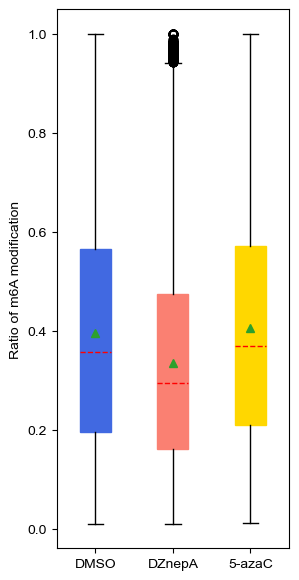

In [185]:
fig, ax = plt.subplots(1, figsize=(3,7))

temp = []
labels = []
for na, value in totol_df.items():
    temp.append(list(value["mod_ratio"]))
    labels.append(na)
    

box = ax.boxplot(temp, patch_artist=True, labels=labels,widths=0.4, showmeans=True)

colors = ['royalblue', 'salmon', "gold"]
[box["boxes"][n].set_color(colors[n]) for n in range(0, 3)]
[box["medians"][n].set_color("red") for n in range(0, 3)]
[box["medians"][n].set_linestyle("--") for n in range(0, 3)]

ax.set_ylabel("Ratio of m6A modification")
#plt.savefig("m6A-ratio.pdf", bbox_inches="tight")

### overlap m6A site and gene

DMSO 	 m6A site num 65320
DZnepA 	 m6A site num 61156
5-azaC 	 m6A site num 55605


Text(0.5, 1.0, 'Overlap m6A site')

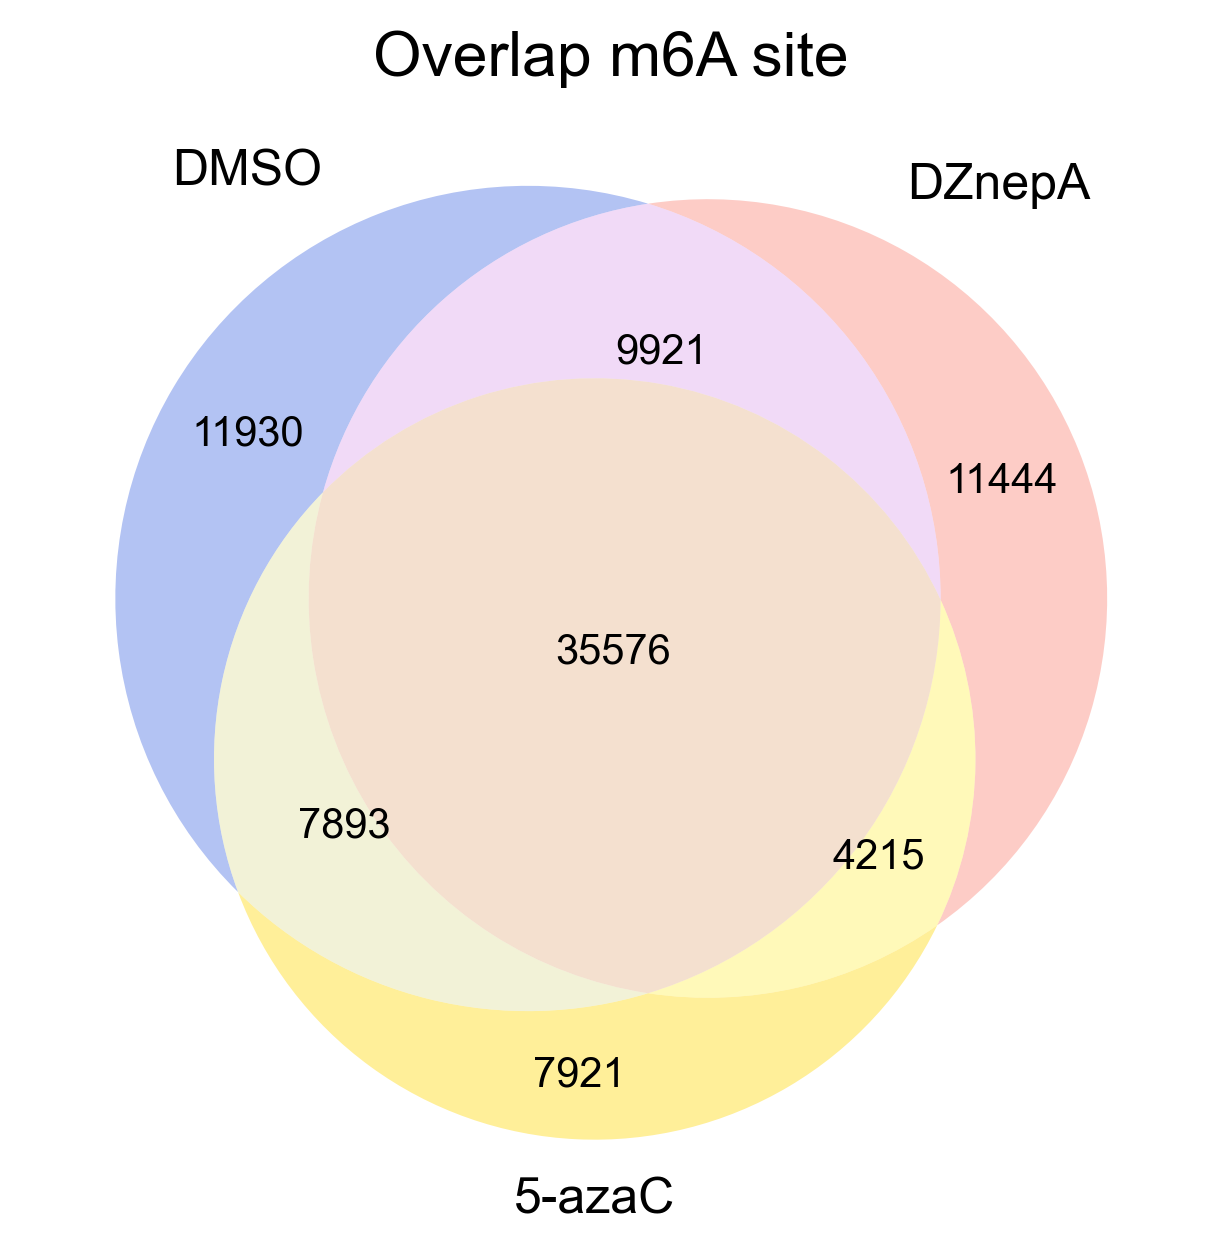

In [186]:
from matplotlib_venn import venn3

total = 0
sites, samples = [], []
f = []
fig = plt.figure(figsize=(5,5), dpi=300)
for sample, values in totol_df.items():
    sites.append(set(values["site"]))
    samples.append(sample)
    print(sample, "\t m6A site num",len(values))

venn3(sites, set_labels=samples, set_colors=cl.values())
plt.title("Overlap m6A site", fontsize=15)
# plt.savefig("Overlap-m6a-site.pdf", bbox_inches="tight")

In [187]:
values["gene_name"].drop_duplicates

<bound method Series.drop_duplicates of 0        PH02Gene40731
1        PH02Gene40731
2        PH02Gene40731
3        PH02Gene40731
4        PH02Gene40731
             ...      
55600    PH02Gene45924
55601    PH02Gene45924
55602    PH02Gene49966
55603    PH02Gene49966
55604    PH02Gene43435
Name: gene_name, Length: 55605, dtype: object>

DMSO 	 m6A site gene 65320
DZnepA 	 m6A site gene 61156
5-azaC 	 m6A site gene 55605


Text(0.5, 1.0, 'Overlap m6A gene')

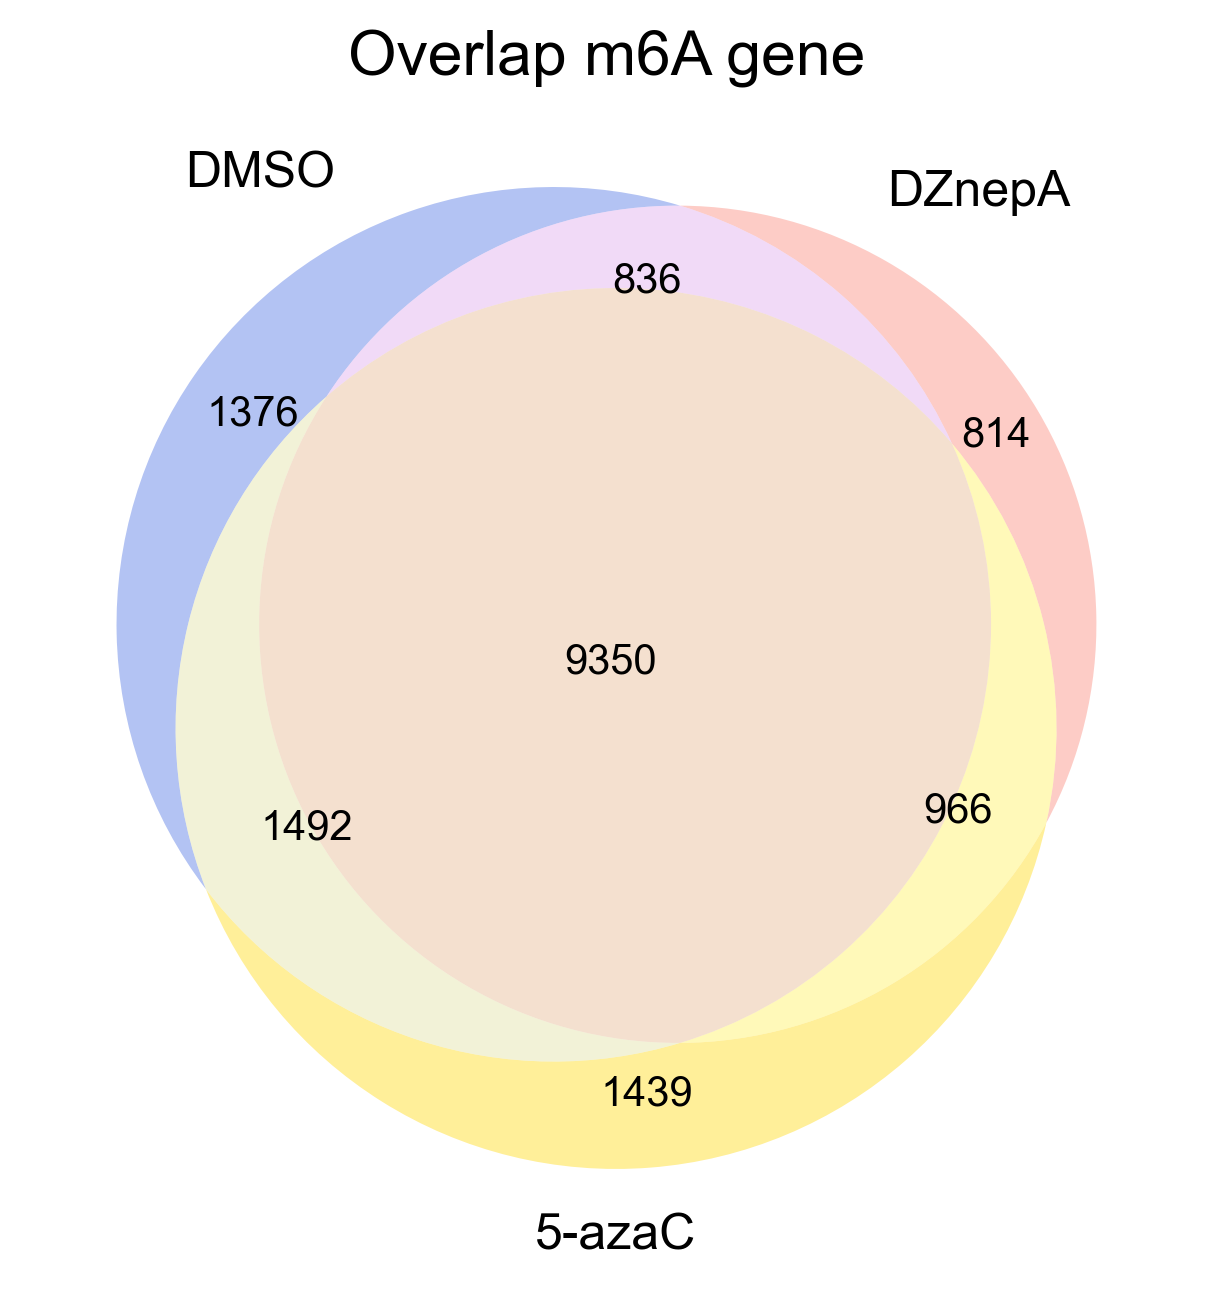

In [188]:
from matplotlib_venn import venn3

total = 0
sites, samples = [], []
f = []
fig = plt.figure(figsize=(5,5), dpi=300)
for sample, values in totol_df.items():
    sites.append(set(values["gene_name"].drop_duplicates()))
    samples.append(sample)
    print(sample, "\t m6A site gene",len(values))

venn3(sites, set_labels=samples, set_colors=cl.values())
plt.title("Overlap m6A gene", fontsize=15)
# plt.savefig("Overlap-m6a-site.pdf", bbox_inches="tight")

### m6A in transcript

(-0.07, 1.8)

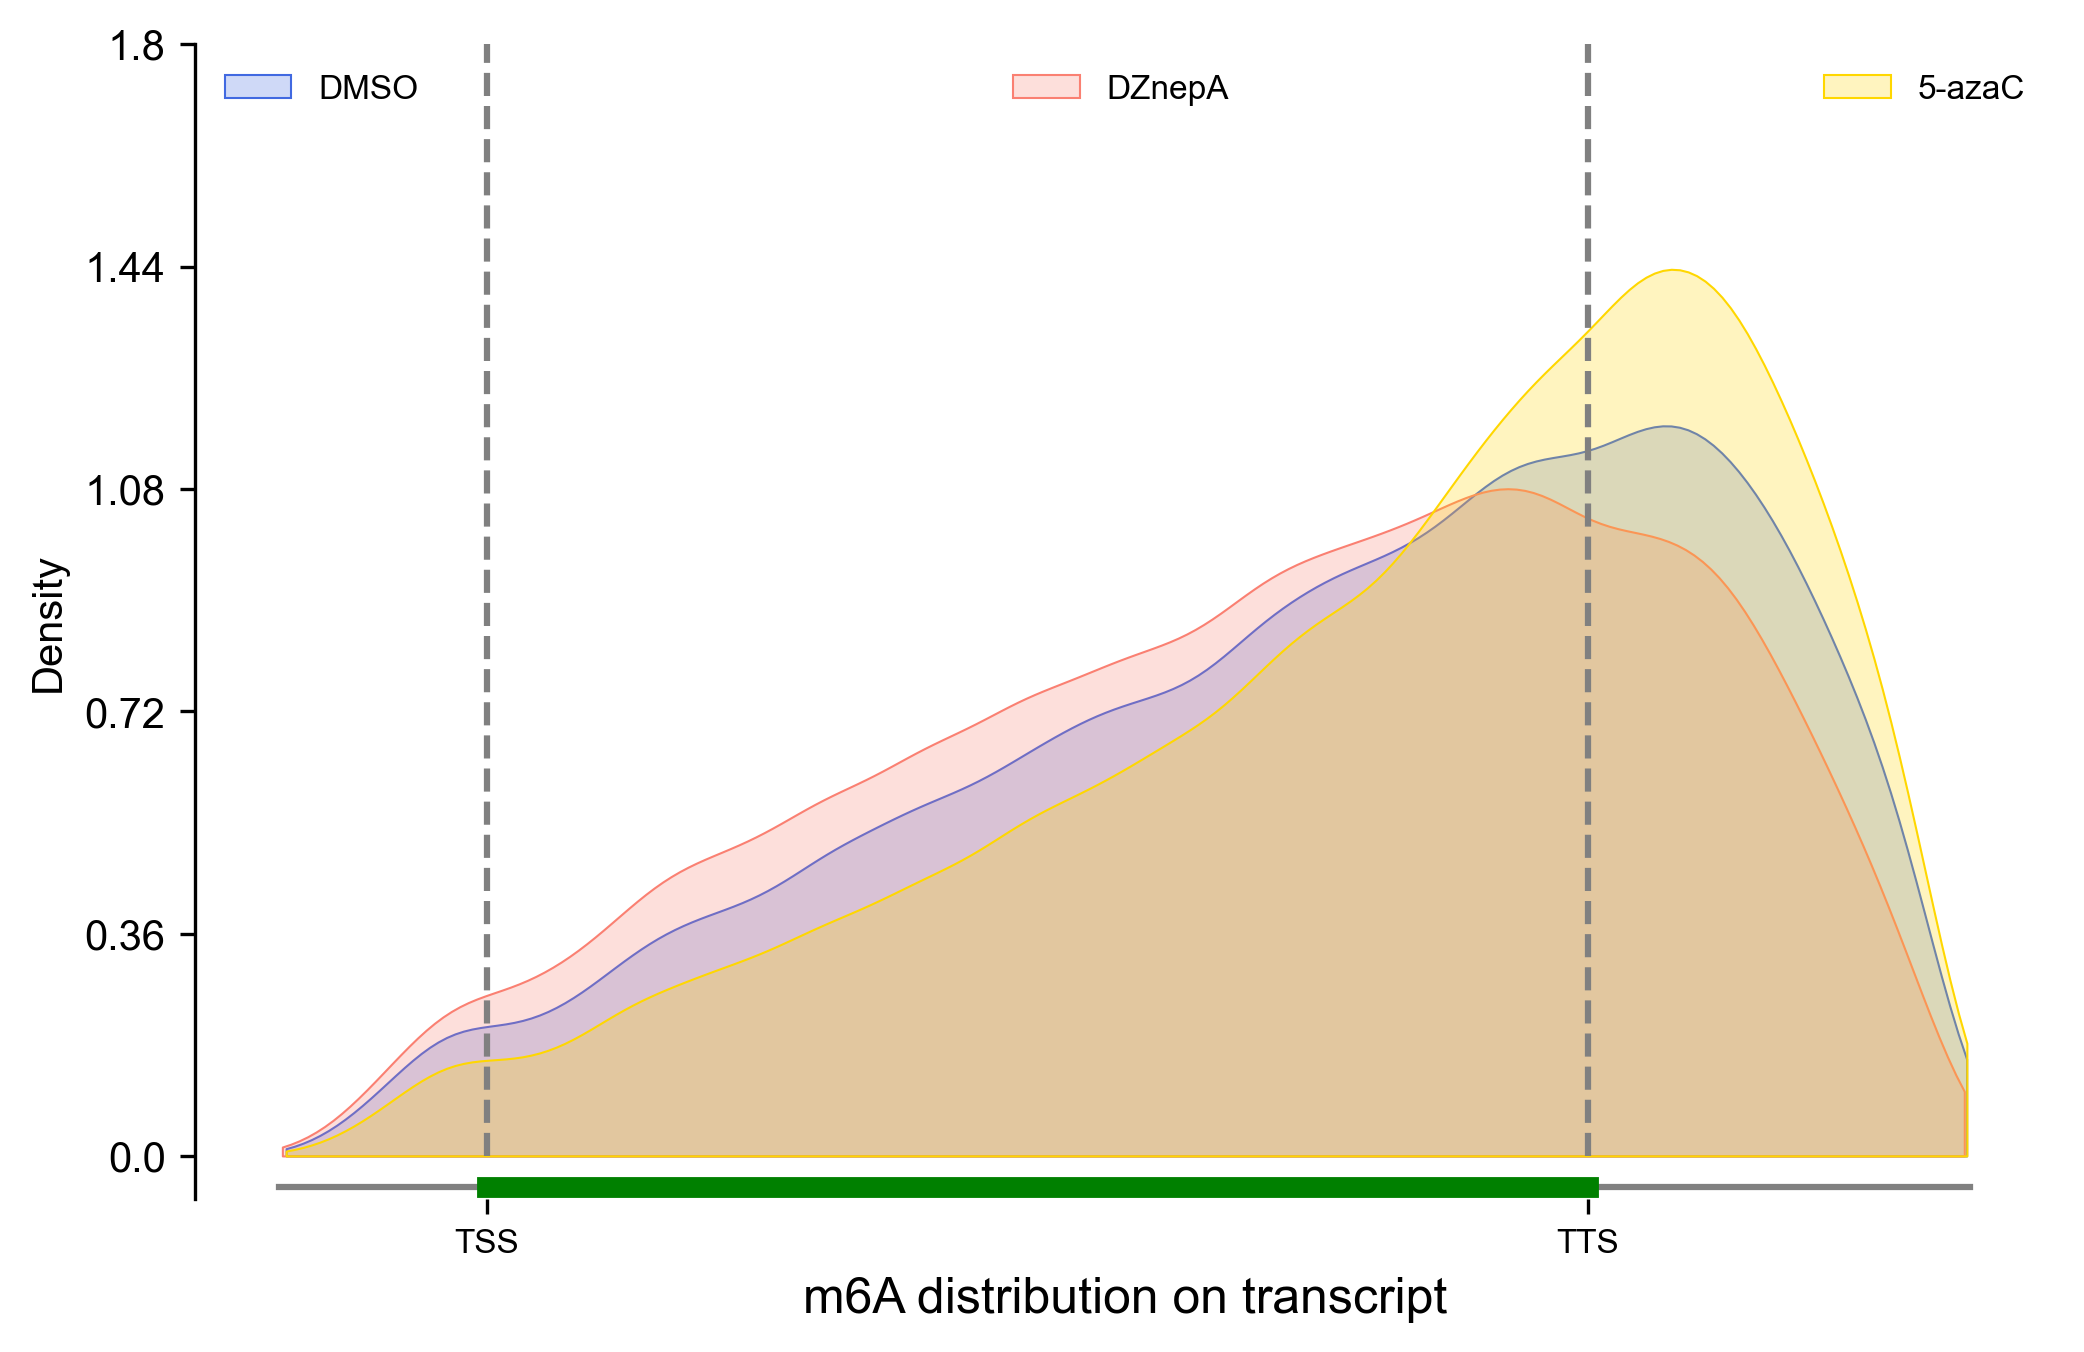

In [189]:
fig, ax = plt.subplots(1, figsize=(8, 5), dpi=300)
for sample, values in totol_df.items():
    #res = trans_region(data, fc)
    sns.kdeplot(values["rel_pos"], cut=0, fill=True, color=cl[sample], label=sample, ax=ax, lw=.5)
    
y = -0.05
ax.legend(fontsize=8, frameon=False, ncol=3, loc=2, mode="expand")
ax.plot([u5,u5],[0,1.8], linestyle="dashed", c="grey")
ax.plot([u5+1,u5+1],[0,1.8], linestyle="dashed", c="grey")
ax.plot([0,u5],[y,y], c="grey")
ax.plot([u5+1,u5+1+u3],[y,y], c="grey")
ax.plot([u5,u5+1],[y,y], c="green", linewidth=5)
ax.set_xticks(labels=["TSS","TTS"], ticks=[u5,u5+1], fontsize=8)

ax.spines[["top", "bottom", "right"]].set_color(None)
ax.set_xlabel("m6A distribution on transcript", fontsize=12)
ticks = [x for x in np.linspace(0, 1.8, 6)]
ax.set_yticks(ticks, ticks)
ax.set_ylim(y-0.02,max(ticks))
#plt.savefig("Distribution of m6A in different(merge).pdf", bbox_inches="tight")

### m6A composition

In [190]:
data = {}
for label in ["cds","utr3p","utr5p"]:
    data[label] = []
    for sample in ["DMSO", "DZnepA", "5-azaC"]:
        t = len(totol_df[sample])
        v = len(totol_df[sample][totol_df[sample]["label"].str.contains(label)])
        data[label].append(round(v/t, 3))

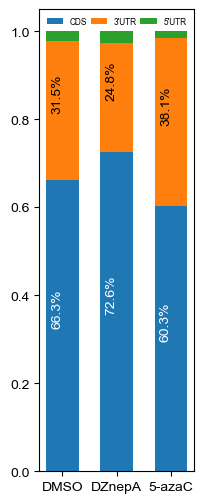

In [191]:
fig, ax  = plt.subplots(1, figsize=(2,6))
width = 0.6
step = 1

n = np.arange(0,len(totol_df)*step, step)

h1 = pd.Series( data["cds"])
h2 = pd.Series(data["utr3p"])
h3 = pd.Series(data["utr5p"])
ax.bar(x=n, height=h1, label="CDS", width = width)
ax.bar(x=n, height=h2, bottom=h1, label="3'UTR",width = width)
ax.bar(x=n, height=h3, bottom=h1+h2, label="5'UTR",width = width)
ax.set_xticks(labels=["DMSO", "DZnepA", "5-azaC"], ticks=n)
for x,y in zip(n,h1):
    ax.text(x-0.2,y/2, s=f"{y*100}%", rotation=90, color="white")
for x,y,z in zip(n,h1,h2):
    ax.text(x-0.2,y+z/2, s=f"{z*100}%", rotation=90)
plt.legend(frameon=False, ncol=3, mode="expand", fontsize=6)
# plt.savefig("Composition of m6A(2-6).pdf", bbox_inches="tight")

### diff m6A 

In [192]:
def get_m6a_num(fp, sample):
    ratio_fp = fp + "/ratio.0.5.normalized.tsv"
    data = defaultdict(dict)
    with open(ratio_fp, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            
            for i in info[1:]:
                site, mod, read, ratio = i.split("|")
                data[gene+"_"+site] = {}
                data[gene+"_"+site][f"{sample}-mod"] = int(mod)
                data[gene+"_"+site][f"{sample}-all"] = int(read)
    return data

In [193]:
fp = "/media/Sorata/data3/bamboo/5_highQ/nanom6A/{}"
ratio_data = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    ratio_data[sample] = get_m6a_num(fp.format(sample), sample)

In [194]:
dmso = pd.DataFrame.from_dict(ratio_data["DMSO"], orient="index")
dznepA = pd.DataFrame.from_dict(ratio_data["DZnepA"], orient="index")
azaC = pd.DataFrame.from_dict(ratio_data["5-azaC"], orient="index")

In [195]:
dznepA

DZnepA-mod  DZnepA-all
PH02Gene06013_3332452           39          89
PH02Gene06013_3333268           25         171
PH02Gene06013_3333442           30         178
PH02Gene06013_3334611           78         202
PH02Gene06013_3335444           27         240
...                            ...         ...
PH02Gene46247_4192458           24          52
PH02Gene46247_4192567           29          55
PH02Gene43154_16870298          39         269
PH02Gene01811_10193880          28         369
PH02Gene45779_11402595          30         142

[61696 rows x 2 columns]

In [100]:
dmso = pd.DataFrame.from_dict(ratio_data["DMSO"], orient="index")
dznepA = pd.DataFrame.from_dict(ratio_data["DZnepA"], orient="index")
azaC = pd.DataFrame.from_dict(ratio_data["5-azaC"], orient="index")
vsdznepA = pd.concat([dmso, dznepA], axis=1, join="inner")
vsazaC = pd.concat([dmso, azaC], axis=1, join="inner")

In [101]:
############################
### Fisher extract test ###
##########################
def get_fisher_test(df, phar=False):
    tab1 = df[:2]
    tab2 = df[2:4]
    stat, p = stats.fisher_exact([tab1, tab2])
    if phar:
        phar.update(1)
    return p

phar = tqdm(total=len(vsdznepA) + len(vsazaC))
vsdznepA["pvalue"] = vsdznepA.apply(get_fisher_test, args=(phar,), axis=1)
vsazaC["pvalue"] = vsazaC.apply(get_fisher_test, args=(phar,), axis=1)
phar.close()

  0%|          | 0/89703 [00:00<?, ?it/s]

In [102]:
vsdznepA

DMSO-mod  DMSO-all  DZnepA-mod  DZnepA-all    pvalue
PH02Gene06696_9829893        23        60          53         259  0.040586
PH02Gene06696_9830017        18        63          69         266  0.761551
PH02Gene06696_9830463        21        76          90         313  1.000000
PH02Gene06696_9830635        34        80         148         357  0.909778
PH02Gene06696_9830969        59        92         241         400  0.779816
...                         ...       ...         ...         ...       ...
PH02Gene50749_924           196       727          58         205  0.798376
PH02Gene50732_9340           18        27          25          53  0.433958
PH02Gene50732_9377           19        26          27          52  0.440501
PH02Gene48821_11028          19       168          45         589  0.166000
PH02Gene50977_1872           42        77          77         129  0.721679

[45872 rows x 5 columns]

#### Load diff m6a 

In [127]:
# vsdznepA.to_csv("de_m6a_site_vsdznepa.csv")
# vsazaC.to_csv("de_m6a_site_vsazaC.csv")
vsdznepA = pd.read_csv("Date-Save/de_m6a_site_vsdznepa.csv", index_col=0)
vsazaC = pd.read_csv("Date-Save/de_m6a_site_vsazaC.csv", index_col=0)

In [196]:
data = vsdznepA
sample = "DZnepA"
fc = 0.5  ### foldchange

#data = data.loc[data.index & site_pos.index]
########
########
data = data[data["pvalue"] < 0.05]
data["DMSO-ratio"] = data["DMSO-mod"] / data["DMSO-all"]
data[f"{sample}-ratio"] = data[f"{sample}-mod"] / data[f"{sample}-all"]
data["gene"] = [x.split("_")[0] for x in data.index]
data["log2 foldchange"] = np.log2(data[f"{sample}-ratio"] / data[f"DMSO-ratio"])
data["label"] = data.apply(lambda x:"up" if x["DMSO-ratio"] < x[f"{sample}-ratio"] else "down", axis=1)
de = data[(data["pvalue"] < 0.05) & (abs(data["log2 foldchange"]) > fc)]
normal = data[~data.index.isin(de.index)]
normal = normal[normal["pvalue"] < 0.05]
down, up = de[de["label"] == "down"], de[de["label"] == "up"]

/tmp/ipykernel_50648/3889468668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DMSO-ratio"] = data["DMSO-mod"] / data["DMSO-all"]
/tmp/ipykernel_50648/3889468668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{sample}-ratio"] = data[f"{sample}-mod"] / data[f"{sample}-all"]
/tmp/ipykernel_50648/3889468668.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

#### diff m6a site scatterplot

Text(0.5, 1.0, 'm6A ratio in DE m6A site between DZnepA')

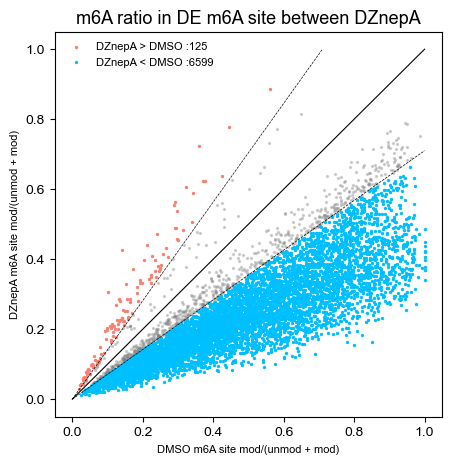

In [140]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=100)

ax.scatter(normal["DMSO-ratio"], normal[f"{sample}-ratio"], s=2, color="grey", alpha=0.3)

ax.scatter(up["DMSO-ratio"], up[f"{sample}-ratio"] , s=2, color=cl[sample], label=f"{sample} > DMSO :{len(up)}")
ax.scatter(down["DMSO-ratio"], down[f"{sample}-ratio"], 
           s=2, color="deepskyblue", label=f"{sample} < DMSO :{len(down)}")
ax.plot([0,1],[0,1], linewidth=0.8, color="black")
ax.plot([0,1],[0,0.71], lw=0.5, ls="--", color="k")
ax.plot([0,0.71],[0,1], lw=0.5, ls="--", color="k")



ax.set_xlabel("DMSO m6A site mod/(unmod + mod)",fontsize=8)
ax.set_ylabel(f"{sample} m6A site mod/(unmod + mod)", fontsize=8)
ax.legend(fontsize=8, frameon=False)
title = f"m6A ratio in DE m6A site between {sample}"
ax.set_title(title, fontsize=13)
#plt.savefig(f"DE-m6A-site-{sample}.pdf", bbox_inches="tight")

#### diff m6a motif

In [215]:
de

DMSO-mod  DMSO-all  DZnepA-mod  DZnepA-all    pvalue  \
PH02Gene06696_9829893        23        60          53         259  0.040586   
PH02Gene06696_9831835        39       108          97         467  0.013244   
PH02Gene06696_9832126        25       123          45         527  0.001732   
PH02Gene06696_9833277        36       246          83         956  0.018426   
PH02Gene06696_9833529       133       259         354        1017  0.002073   
...                         ...       ...         ...         ...       ...   
PH02Gene28986_39159         143       598          94         580  0.008272   
PH02Gene28986_41337          63       507          40         534  0.017409   
PH02Gene50575_1263          228       482         171         528  0.001706   
PH02Gene46209_9410           50       117          34         148  0.017091   
PH02Gene20354_95644         291       964         261        1284  0.000039   

                       DMSO-ratio  DZnepA-ratio           gene  \
PH02Gene06696_9829893    0.383333      0.204633  PH02Gene06696   
PH02Gene06696_9831835    0.361111      0.207709  PH02Gene06696   
PH02Gene06696_9832126    0.203252      0.085389  PH02Gene06696   
PH02Gene06696_9833277    0.146341      0.086820  PH02Gene06696   
PH02Gene06696_9833529    0.513514      0.348083  PH02Gene06696   
...                           ...           ...            ...   
PH02Gene28986_39159      0.239130      0.162069  PH02Gene28986   
PH02Gene28986_41337      0.124260      0.074906  PH02Gene28986   
PH02Gene50575_1263       0.473029      0.323864  PH02Gene50575   
PH02Gene46209_9410       0.427350      0.229730  PH02Gene46209   
PH02Gene20354_95644      0.301867      0.203271  PH02Gene20354   

                       log2 foldchange label pos_label   rel_pos  motif  
PH02Gene06696_9829893        -0.905559  down      cds2  0.361446  AAACA  
PH02Gene06696_9831835        -0.797881  down      cds4  0.699172  AAACA  
PH02Gene06696_9832126        -1.251148  down      cds5  0.749197  AAACT  
PH02Gene06696_9833277        -0.753238  down      cds6  1.008347  AAACT  
PH02Gene06696_9833529        -0.560973  down      cds7  1.041290  AAACT  
...                                ...   ...       ...       ...    ...  
PH02Gene28986_39159          -0.561190  down      cds6  1.142702  GGACA  
PH02Gene28986_41337          -0.730206  down      cds4  0.760108  AAACC  
PH02Gene50575_1263           -0.546542  down    utr3p1  1.306612  AAACT  
PH02Gene46209_9410           -0.895482  down    utr3p1  1.329339  AAACT  
PH02Gene20354_95644          -0.570509  down    utr3p1  1.283680  AAACT  

[6724 rows x 13 columns]

In [216]:
motifs = defaultdict(dict)
motif_cl = {"down":"dodgerblue","up":"lightcoral"}
motif_text = {}
for label, sites in de.groupby("label"):
    motif_text[label] = len(sites)
    for motif, values in sites.groupby("motif"):
        motifs[label][motif] = len(values) / len(sites)

In [217]:
order = set(motifs["down"].keys()) | set(motifs["up"].keys())

de_motif = defaultdict(dict)
for label, values in motifs.items():
    for x in order:
        if x in values:
            de_motif[label][x] = motifs[label][x]
        else:
            de_motif[label][x] = 0

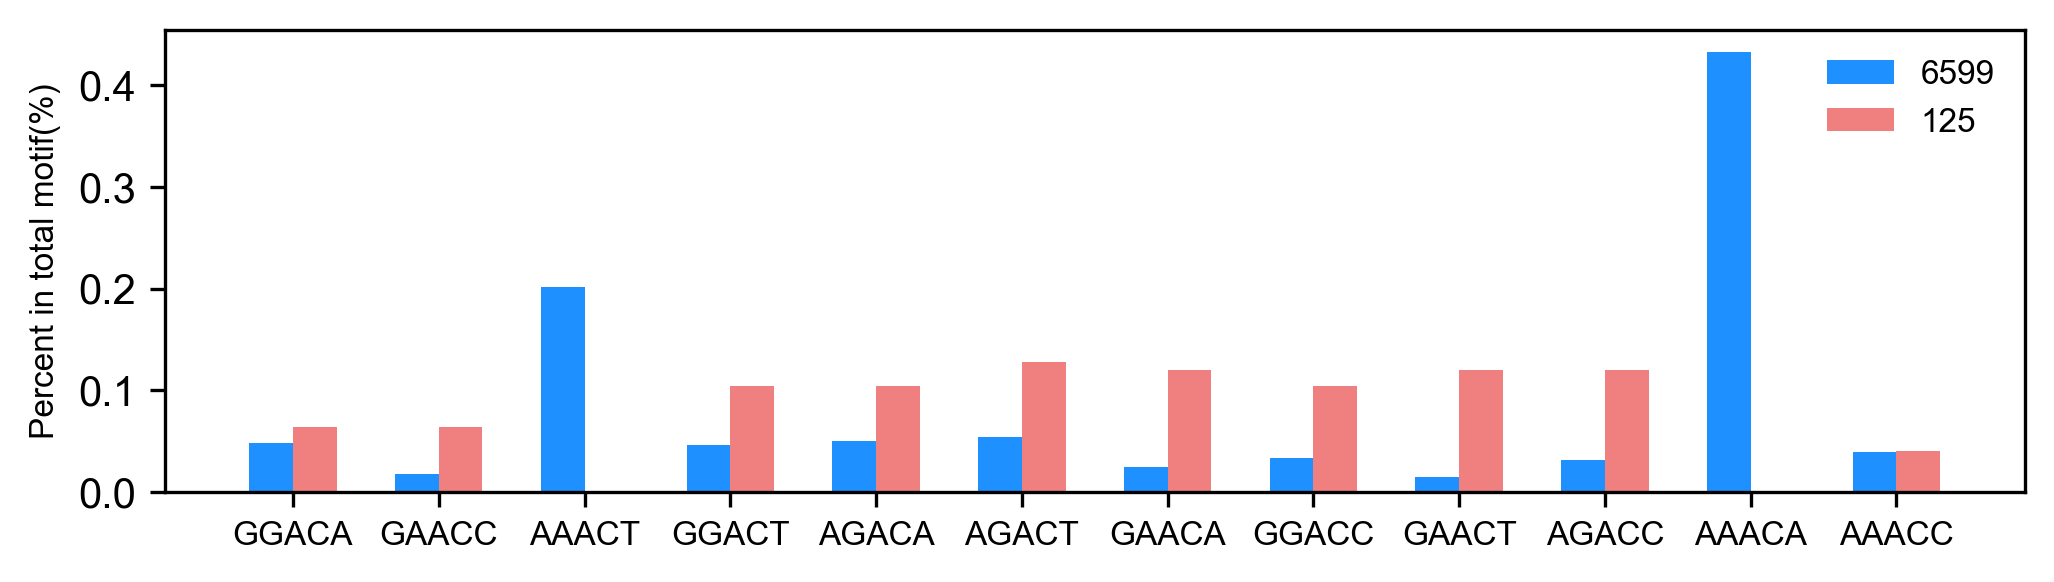

In [218]:
fig, ax = plt.subplots(1,1, figsize=(8,2), dpi=300)
wd = 0.6
pos = np.arange(0, len(order))
for label, values in de_motif.items():
    ax.bar(x=pos-wd/4, height=list(values.values()), color=motif_cl[label], width=wd/2, label=motif_text[label])
    pos = pos + wd/2
ax.set_xticks(labels=order, ticks=pos-wd, fontsize=8)
ax.set_ylabel("Percent in total motif(%)", fontsize=8)
ax.legend(frameon=False, fontsize=8)
#plt.savefig(f"dem6A-motif-{sample}.pdf", bbox_inches="tight")

#### diffm6a in transcript

In [212]:
temp = totol_df["DMSO"][["site", "label","rel_pos","motif"]].set_index("site").to_dict()
de["pos_label"] = de.apply(lambda x:temp["label"].get(x.name), axis=1)
de["rel_pos"] = de.apply(lambda x:temp["rel_pos"].get(x.name), axis=1)
de["motif"] = de.apply(lambda x:temp["motif"].get(x.name), axis=1)
de

/tmp/ipykernel_50648/1127909942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de["pos_label"] = de.apply(lambda x:temp["label"].get(x.name), axis=1)
/tmp/ipykernel_50648/1127909942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de["rel_pos"] = de.apply(lambda x:temp["rel_pos"].get(x.name), axis=1)
/tmp/ipykernel_50648/1127909942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

DMSO-mod  DMSO-all  DZnepA-mod  DZnepA-all    pvalue  \
PH02Gene06696_9829893        23        60          53         259  0.040586   
PH02Gene06696_9831835        39       108          97         467  0.013244   
PH02Gene06696_9832126        25       123          45         527  0.001732   
PH02Gene06696_9833277        36       246          83         956  0.018426   
PH02Gene06696_9833529       133       259         354        1017  0.002073   
...                         ...       ...         ...         ...       ...   
PH02Gene28986_39159         143       598          94         580  0.008272   
PH02Gene28986_41337          63       507          40         534  0.017409   
PH02Gene50575_1263          228       482         171         528  0.001706   
PH02Gene46209_9410           50       117          34         148  0.017091   
PH02Gene20354_95644         291       964         261        1284  0.000039   

                       DMSO-ratio  DZnepA-ratio           gene  \
PH02Gene06696_9829893    0.383333      0.204633  PH02Gene06696   
PH02Gene06696_9831835    0.361111      0.207709  PH02Gene06696   
PH02Gene06696_9832126    0.203252      0.085389  PH02Gene06696   
PH02Gene06696_9833277    0.146341      0.086820  PH02Gene06696   
PH02Gene06696_9833529    0.513514      0.348083  PH02Gene06696   
...                           ...           ...            ...   
PH02Gene28986_39159      0.239130      0.162069  PH02Gene28986   
PH02Gene28986_41337      0.124260      0.074906  PH02Gene28986   
PH02Gene50575_1263       0.473029      0.323864  PH02Gene50575   
PH02Gene46209_9410       0.427350      0.229730  PH02Gene46209   
PH02Gene20354_95644      0.301867      0.203271  PH02Gene20354   

                       log2 foldchange label pos_label   rel_pos  motif  
PH02Gene06696_9829893        -0.905559  down      cds2  0.361446  AAACA  
PH02Gene06696_9831835        -0.797881  down      cds4  0.699172  AAACA  
PH02Gene06696_9832126        -1.251148  down      cds5  0.749197  AAACT  
PH02Gene06696_9833277        -0.753238  down      cds6  1.008347  AAACT  
PH02Gene06696_9833529        -0.560973  down      cds7  1.041290  AAACT  
...                                ...   ...       ...       ...    ...  
PH02Gene28986_39159          -0.561190  down      cds6  1.142702  GGACA  
PH02Gene28986_41337          -0.730206  down      cds4  0.760108  AAACC  
PH02Gene50575_1263           -0.546542  down    utr3p1  1.306612  AAACT  
PH02Gene46209_9410           -0.895482  down    utr3p1  1.329339  AAACT  
PH02Gene20354_95644          -0.570509  down    utr3p1  1.283680  AAACT  

[6724 rows x 13 columns]

In [198]:
fl = {}
for mark, values in de.groupby("label"):
    pos_data = {"cds":0, "utr3p":0, "utr5p":0}
    for label, num in values.groupby("pos_label"):
        for flag in pos_data.keys():
            if flag in label:
                pos_data[flag] += len(num)
    if mark == "up":
        fl["High"] = pos_data
    else:
        fl["Low"] = pos_data

Text(0.5, 1.0, 'Distribution of DE m6A in DZnepA and DMSO')

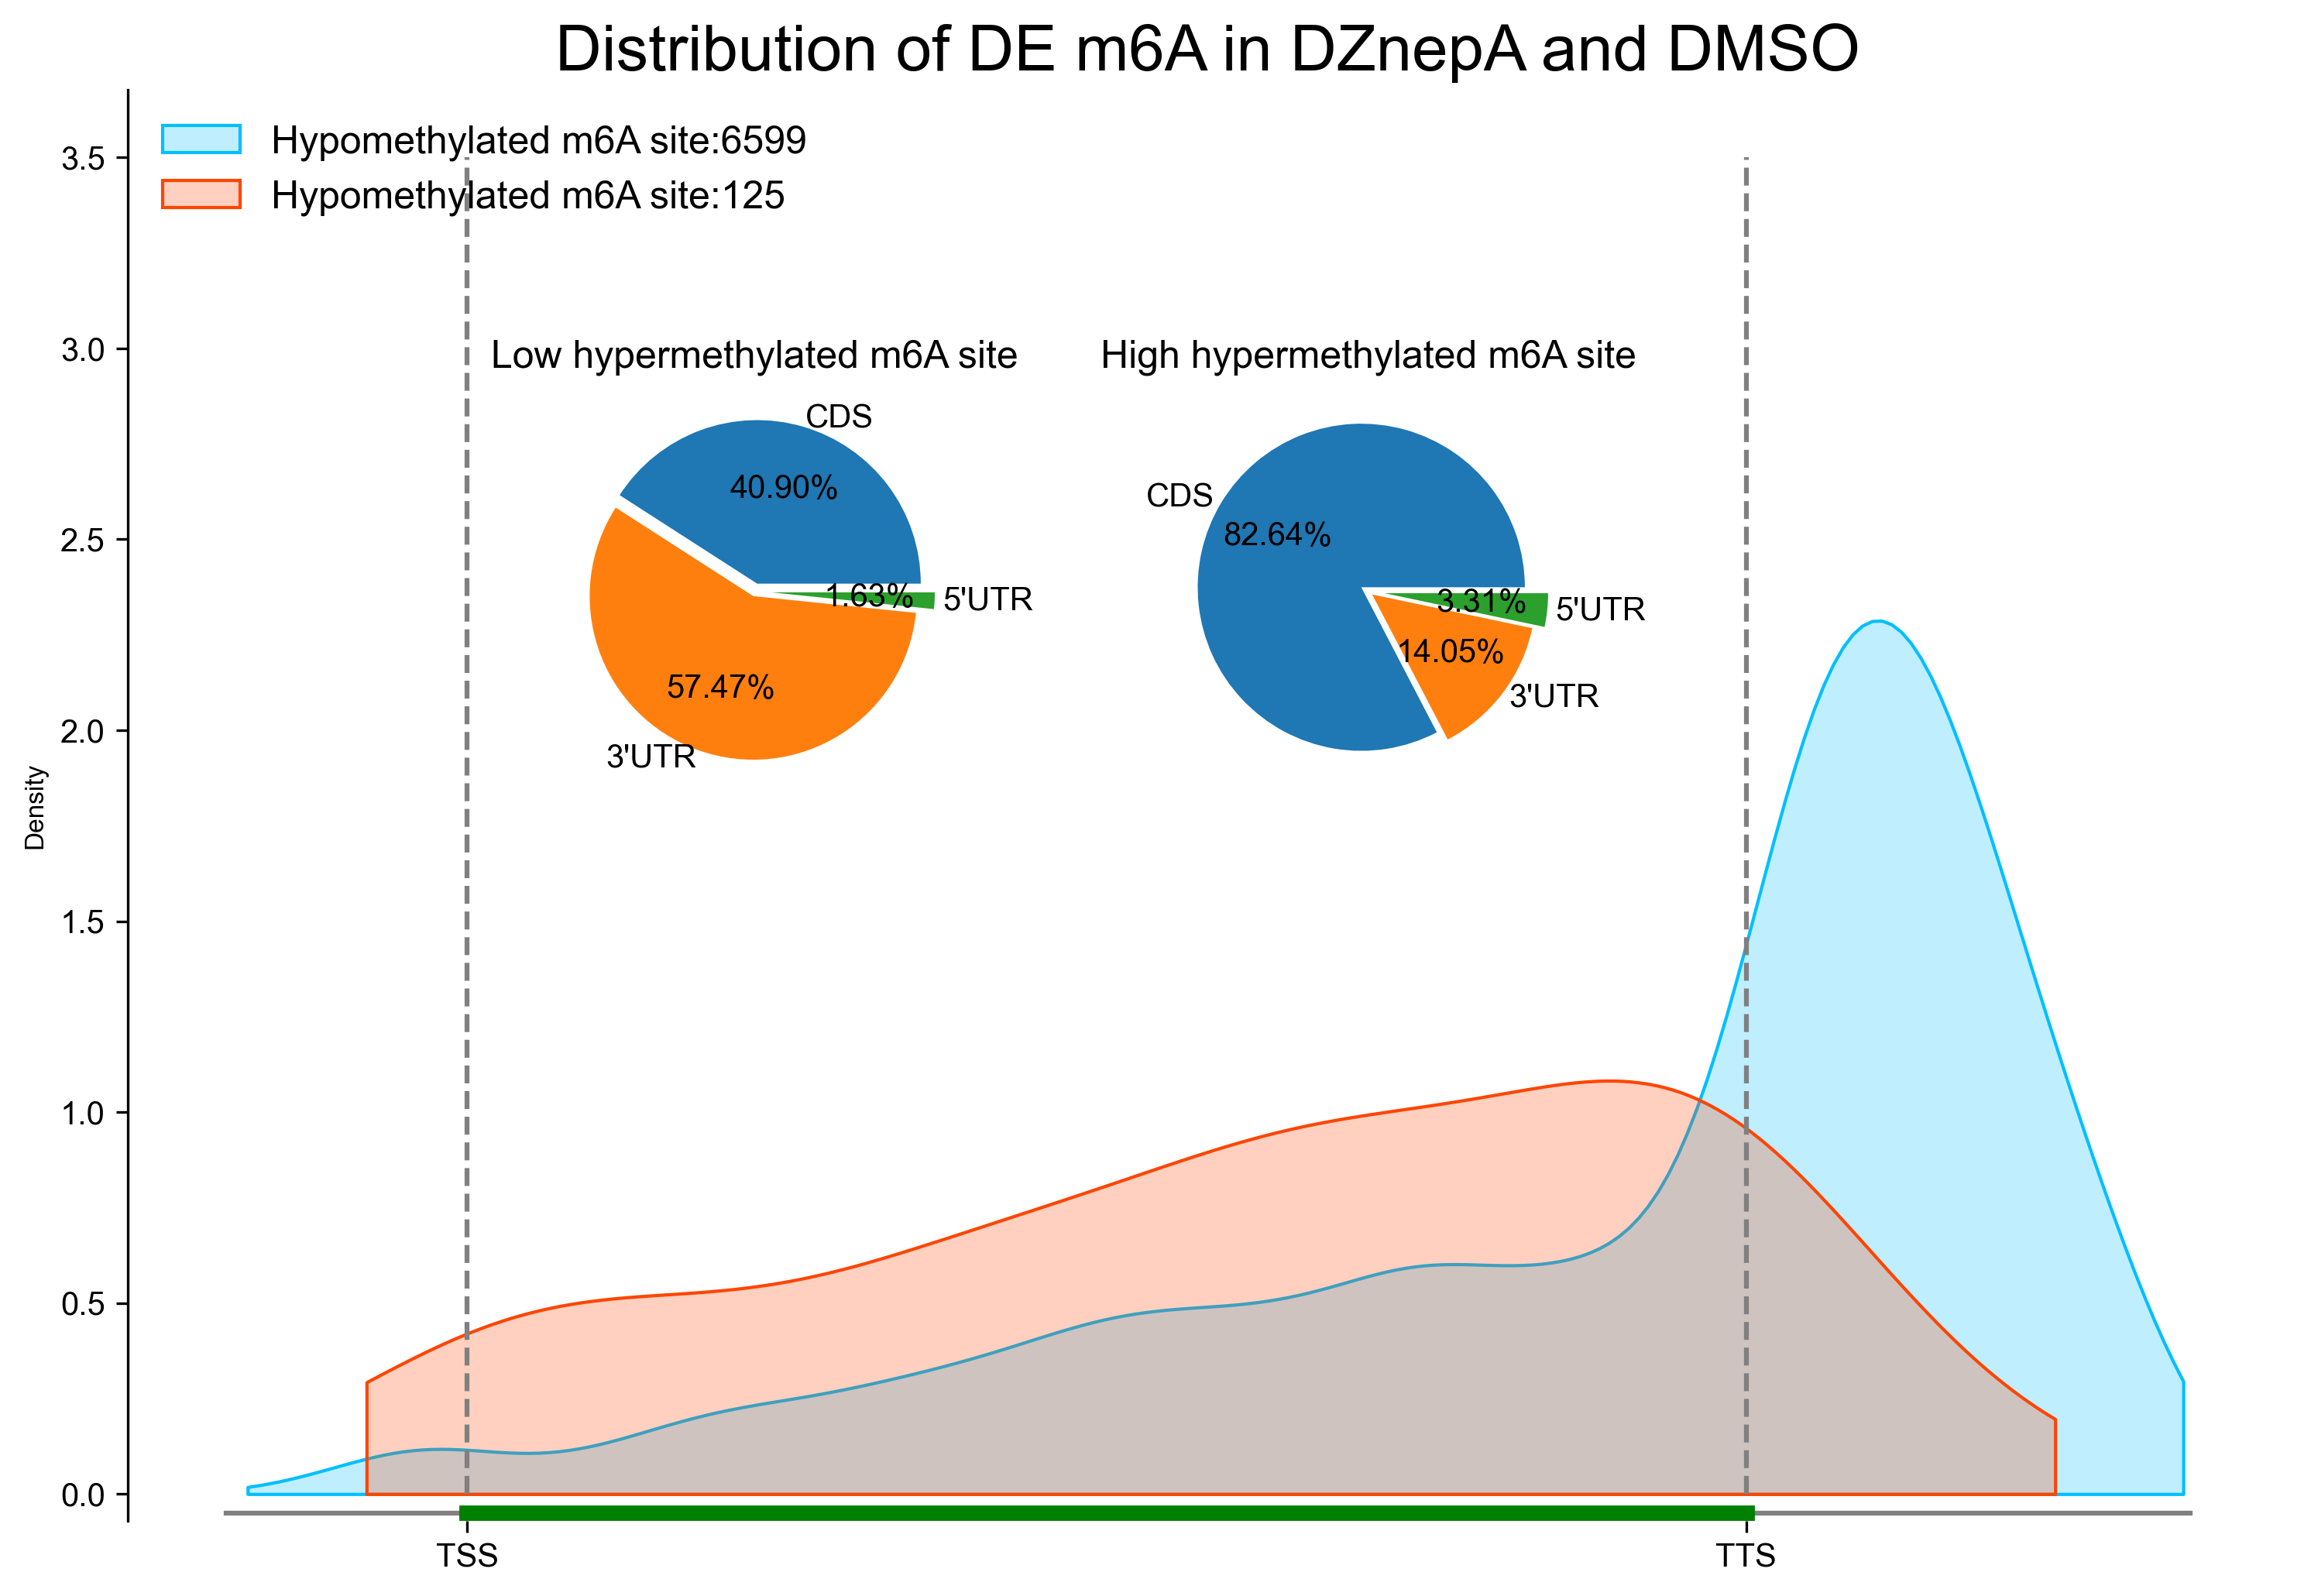

In [209]:
fig, ax = plt.subplots(1, figsize=(12, 8), dpi=300)
    
tmp_color = {"up":"orangered", "down":"deepskyblue"}
for label, values in de.groupby("label"):
    sns.kdeplot(values["rel_pos"].tolist(), cut=0, fill=True, color=tmp_color[label], label=f"Hypomethylated m6A site:{len(values)}", ax=ax)

######
######
h = 0.5
w = 0.22
n = 0
# ax2 = fig.add_axes([0.15, h, w,w])
# ax3 = fig.add_axes([0.4, h, w,w])

for label, values in fl.items():
    axes = fig.add_axes([0.24+n*0.22, h, w,w])
    axes.pie(values.values(), labels=["CDS","3'UTR","5'UTR"], 
            explode=[0.05, 0.03, 0.1], labeldistance = 1.05, textprops={"fontsize":10},
            autopct = '%3.2f%%')
    axes.set_title(f"{label} hypermethylated m6A site", fontsize=12)
    n += 1
#plt.savefig(f"DE m6A site in {sample}.pdf", bbox_inches="tight")

######
#######
if sample == "5-azaC":
    y, h = -0.05, 2.5
else:
    y, h = -0.05, 3.5
ax.legend(fontsize=12, frameon=False, ncol=1, loc=2)
ax.plot([u5,u5],[0,h], linestyle="dashed", c="grey")
ax.plot([u5+1,u5+1],[0,h], linestyle="dashed", c="grey")
ax.plot([0,u5],[y,y], c="grey")
ax.plot([u5+1,u5+1+u3],[y,y], c="grey")
ax.plot([u5,u5+1],[y,y], c="green", linewidth=5)
ax.set_xticks(labels=["TSS","TTS"], ticks=[u5,u5+1])
ax.set_ylabel("Density", fontsize=8)
ax.set_ylim(y-0.02,)
ax.spines[["top", "bottom", "right"]].set_color(None)
ax.set_title(f"Distribution of DE m6A in {sample} and DMSO", fontsize="20")
#plt.savefig(f"Distribution of DE m6A in {sample}.pdf", bbox_inches="tight")

### gene with diff m6A and expression

In [245]:
def get_ratio_data(fp):
    fp = fp + "/ratio.0.5.normalized.tsv"
    gene_ratio, site_ratio, sites_distribution = {}, {}, {}
    with open(fp, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            m6a, total = 0, []
            for i in info[1:]:
                site, mod, read, ratio = i.split("|")
                site = int(site) 
                m6a += int(mod)
                total.append(float(ratio))
                site_ratio[f"{gene}_{site}"] = float(ratio)
            gene_ratio[gene] = np.mean(total)
            sites_distribution[gene] = total
    return site_ratio, gene_ratio, sites_distribution

In [272]:
site_m6a, gene_m6a, dis_m6a = {}, {}, {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    fp = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}"
    site_m6a[sample], gene_m6a[sample], dis_m6a[sample] = get_ratio_data(fp)

In [248]:
sample = "DZnepA"
fc = 0.5

overlap = set(dis_m6a[sample].keys()) & set(dis_m6a["DMSO"].keys())
box_rpm = {"DMSO":[], sample:[]}
diff_m6a = defaultdict(dict)
phar = tqdm(total=len(overlap))
for gene in overlap:
    control, compare = dis_m6a["DMSO"][gene], dis_m6a[sample][gene]
    s, mwu_p = stats.mannwhitneyu(control, compare, alternative="two-sided")
    s, ks_p = stats.ks_2samp(control, compare, alternative="two-sided")
    diff_m6a[gene][f"DMSO"] = np.median(control)
    diff_m6a[gene][f"{sample}"] = np.median(compare)
    diff_m6a[gene]["MHU_pvalue"] = mwu_p
    diff_m6a[gene]["KS_pvalue"] = ks_p
    diff_m6a[gene]["DMSO_m6a"] = gene_m6a["DMSO"].get(gene)
    diff_m6a[gene][f"{sample}_m6a"] = gene_m6a[sample].get(gene)
    phar.update(1)
phar.close()

  0%|          | 0/10243 [00:00<?, ?it/s]

/tmp/ipykernel_50648/2219048878.py:11: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  s, ks_p = stats.ks_2samp(control, compare, alternative="two-sided")


In [249]:
def mark_diff_m6a_test(df, test="MHU_pvalue", fc=1):
    if df[test] > 0.05:
        return "None"
    if df["log2fc"] > fc:
        return "Up"
    elif df["log2fc"] < -fc:
        return "Down"
    else:
        return "Normal"


def mark_diff_m6a(df, fc=0.2):
    if df["diff"] > fc:
        return "Up"
    elif df["diff"] < -fc:
        return "Down"
    else:
        return "Normal"


diff_m6a = pd.DataFrame.from_dict(diff_m6a, orient="index")
diff_m6a["log2fc"] = np.log2(diff_m6a[sample] / diff_m6a["DMSO"])
diff_m6a["diff"] = diff_m6a[sample] - diff_m6a["DMSO"]
diff_m6a["mark"] = diff_m6a.apply(mark_diff_m6a, axis=1)
diff_m6a.fillna(0, inplace=True)

#### Load diff m6A gene

In [254]:
#diff_m6a.to_csv(f"Differential gene m6A in {sample}.csv")
diff_m6a = pd.read_csv(f"Differential gene m6A in {sample}.csv", index_col=0)
diff_m6a

DMSO    DZnepA  MHU_pvalue  KS_pvalue  DMSO_m6a  \
PH02Gene23711  0.219178  0.152231    0.142857   0.142857  0.386890   
PH02Gene22573  0.447368  0.479167    1.000000   1.000000  0.565177   
PH02Gene05587  0.156149  0.098794    0.472676   0.786930  0.171053   
PH02Gene10435  0.541667  0.337833    0.800000   0.800000  0.541667   
PH02Gene12924  0.294934  0.287150    1.000000   0.999967  0.359797   
...                 ...       ...         ...        ...       ...   
PH02Gene22967  0.571429  0.326025    0.666667   0.666667  0.571429   
PH02Gene02197  0.315789  0.325000    1.000000   0.989899  0.401204   
PH02Gene06788  0.400000  0.183432    0.210910   0.435772  0.363849   
PH02Gene17586  0.714158  0.662982    1.000000   1.000000  0.714158   
PH02Gene00951  0.612903  0.558511    0.800000   0.900000  0.672760   

               DZnepA_m6a    log2fc      diff    mark  
PH02Gene23711    0.219708 -0.525842 -0.066947  Normal  
PH02Gene22573    0.479167  0.099064  0.031798  Normal  
PH02Gene05587    0.101152 -0.660427 -0.057355  Normal  
PH02Gene10435    0.385851 -0.681094 -0.203833    Down  
PH02Gene12924    0.335662 -0.038587 -0.007784  Normal  
...                   ...       ...       ...     ...  
PH02Gene22967    0.326025 -0.809592 -0.245404    Down  
PH02Gene02197    0.362664  0.041477  0.009211  Normal  
PH02Gene06788    0.256451 -1.124755 -0.216568    Down  
PH02Gene17586    0.662982 -0.107273 -0.051176  Normal  
PH02Gene00951    0.558511 -0.134075 -0.054393  Normal  

[10243 rows x 9 columns]

Text(0.5, 0, 'Gene m6A modified ratio in DMSO')

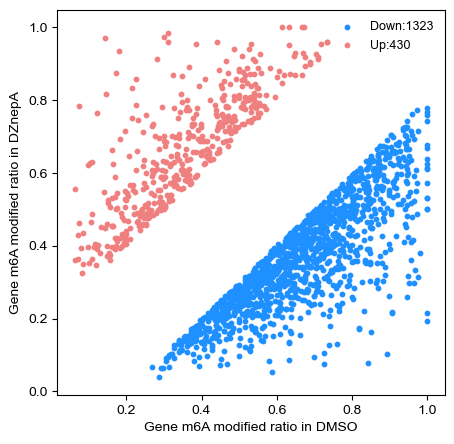

In [255]:
colors = {"Up":"lightcoral", "Down":"dodgerblue", "None":"grey"}

fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)
for tag, genes in diff_m6a.groupby("mark"):
    if tag in ["None", "Normal"]:
        continue
    ax.scatter(genes["DMSO"], genes[sample], color=colors[tag], s=10, label=f"{tag}:{len(genes)}")
ax.legend(fontsize=9, frameon=False)
ax.set_ylabel("Gene m6A modified ratio in DZnepA")
ax.set_xlabel("Gene m6A modified ratio in DMSO")
#plt.savefig("DE m6A gene vs {sample}.pdf", bbox_inches="tight")

#### Get Rpm from nanom6A

In [261]:
rpm = defaultdict(dict)
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    fp = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}"
    with open(fp+"/extract.bed6.gene", 'r') as f:
        for line in f:
            chrome, st, ed, gene, strand, reads = line.rstrip().split("\t")
            rpm[sample][gene] = len(reads.split(","))

In [262]:
for sample, genes in rpm.items():
    total = sum(genes.values())
    for gene, num in genes.items():
        rpm[sample][gene] = num * 1000000 / total
rpm = pd.DataFrame.from_dict(rpm).fillna(0)

In [263]:
rpm

DMSO     DZnepA     5-azaC
PH02Gene00003  11.451544  11.505963  10.213630
PH02Gene00004   6.062582   2.876491   3.142655
PH02Gene00005   3.704911   7.844975   7.070975
PH02Gene00006   9.430683   7.060477  10.999294
PH02Gene00007  10.104303  11.244464   9.427966
...                  ...        ...        ...
PH02Gene51199   0.000000   0.000000   0.785664
PH02Gene51205   0.000000   0.000000   0.785664
PH02Gene51295   0.000000   0.000000   0.785664
PH02Gene51308   0.000000   0.000000   1.571328
PH02Gene51352   0.000000   0.000000   0.785664

[36650 rows x 3 columns]

#### Combine m6A

In [274]:
generatio = pd.DataFrame(gene_m6a)

In [295]:
sample = "DZnepA"
data = pd.concat([generatio["DMSO"], generatio[sample]], axis=1).dropna()


express_fc = 1
ratio_fc = 0.5

vsgenes = pd.DataFrame()
vsgenes["DMSO_m6A_ratio"] = data["DMSO"]
vsgenes[f"{sample}_m6A_ratio"] = data[f"{sample}"]
vsgenes["m6A_foldchange"] = np.log2(data[sample] / data["DMSO"])
vsgenes["m6A_tag"] = vsgenes.apply(lambda x:"up" if x["DMSO_m6A_ratio"] < x[f"{sample}_m6A_ratio"] else "down", axis=1)

vsgenes["DMSO_Rpm"] = rpm["DMSO"]
vsgenes[f"{sample}_Rpm"] = rpm[sample]
vsgenes["Rpm_foldchange"] = rpm.loc[genes][f"vs{sample}"]
vsgenes["rpm_tag"] = vsgenes.apply(lambda x:"up" if x["DMSO_Rpm"] < x[f"{sample}_Rpm"] else "down", axis=1)

##
x1, x2, x3, x4, x5, y1, y2, y3, y4, y5 = [], [], [], [], [], [], [], [], [], []
for gene in vsgenes.index:
    x, y = vsgenes.loc[gene][["m6A_foldchange", "Rpm_foldchange"]]
    if x >= ratio_fc and y >= express_fc:
        x1.append(x)
        y1.append(y)
    elif x <= -ratio_fc and y >= express_fc:
        x2.append(x)
        y2.append(y)
    elif x <= -ratio_fc and y <= -express_fc:
        x3.append(x)
        y3.append(y)
    elif x >= ratio_fc and y <= -express_fc:
        x4.append(x)
        y4.append(y)
    else:
        x5.append(x)
        y5.append(y)  

/tmp/ipykernel_50648/3564874571.py:16: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  vsgenes["Rpm_foldchange"] = rpm.loc[genes][f"vs{sample}"]


10243 0


Text(0, 0, 'Foldchange(Rpm)')

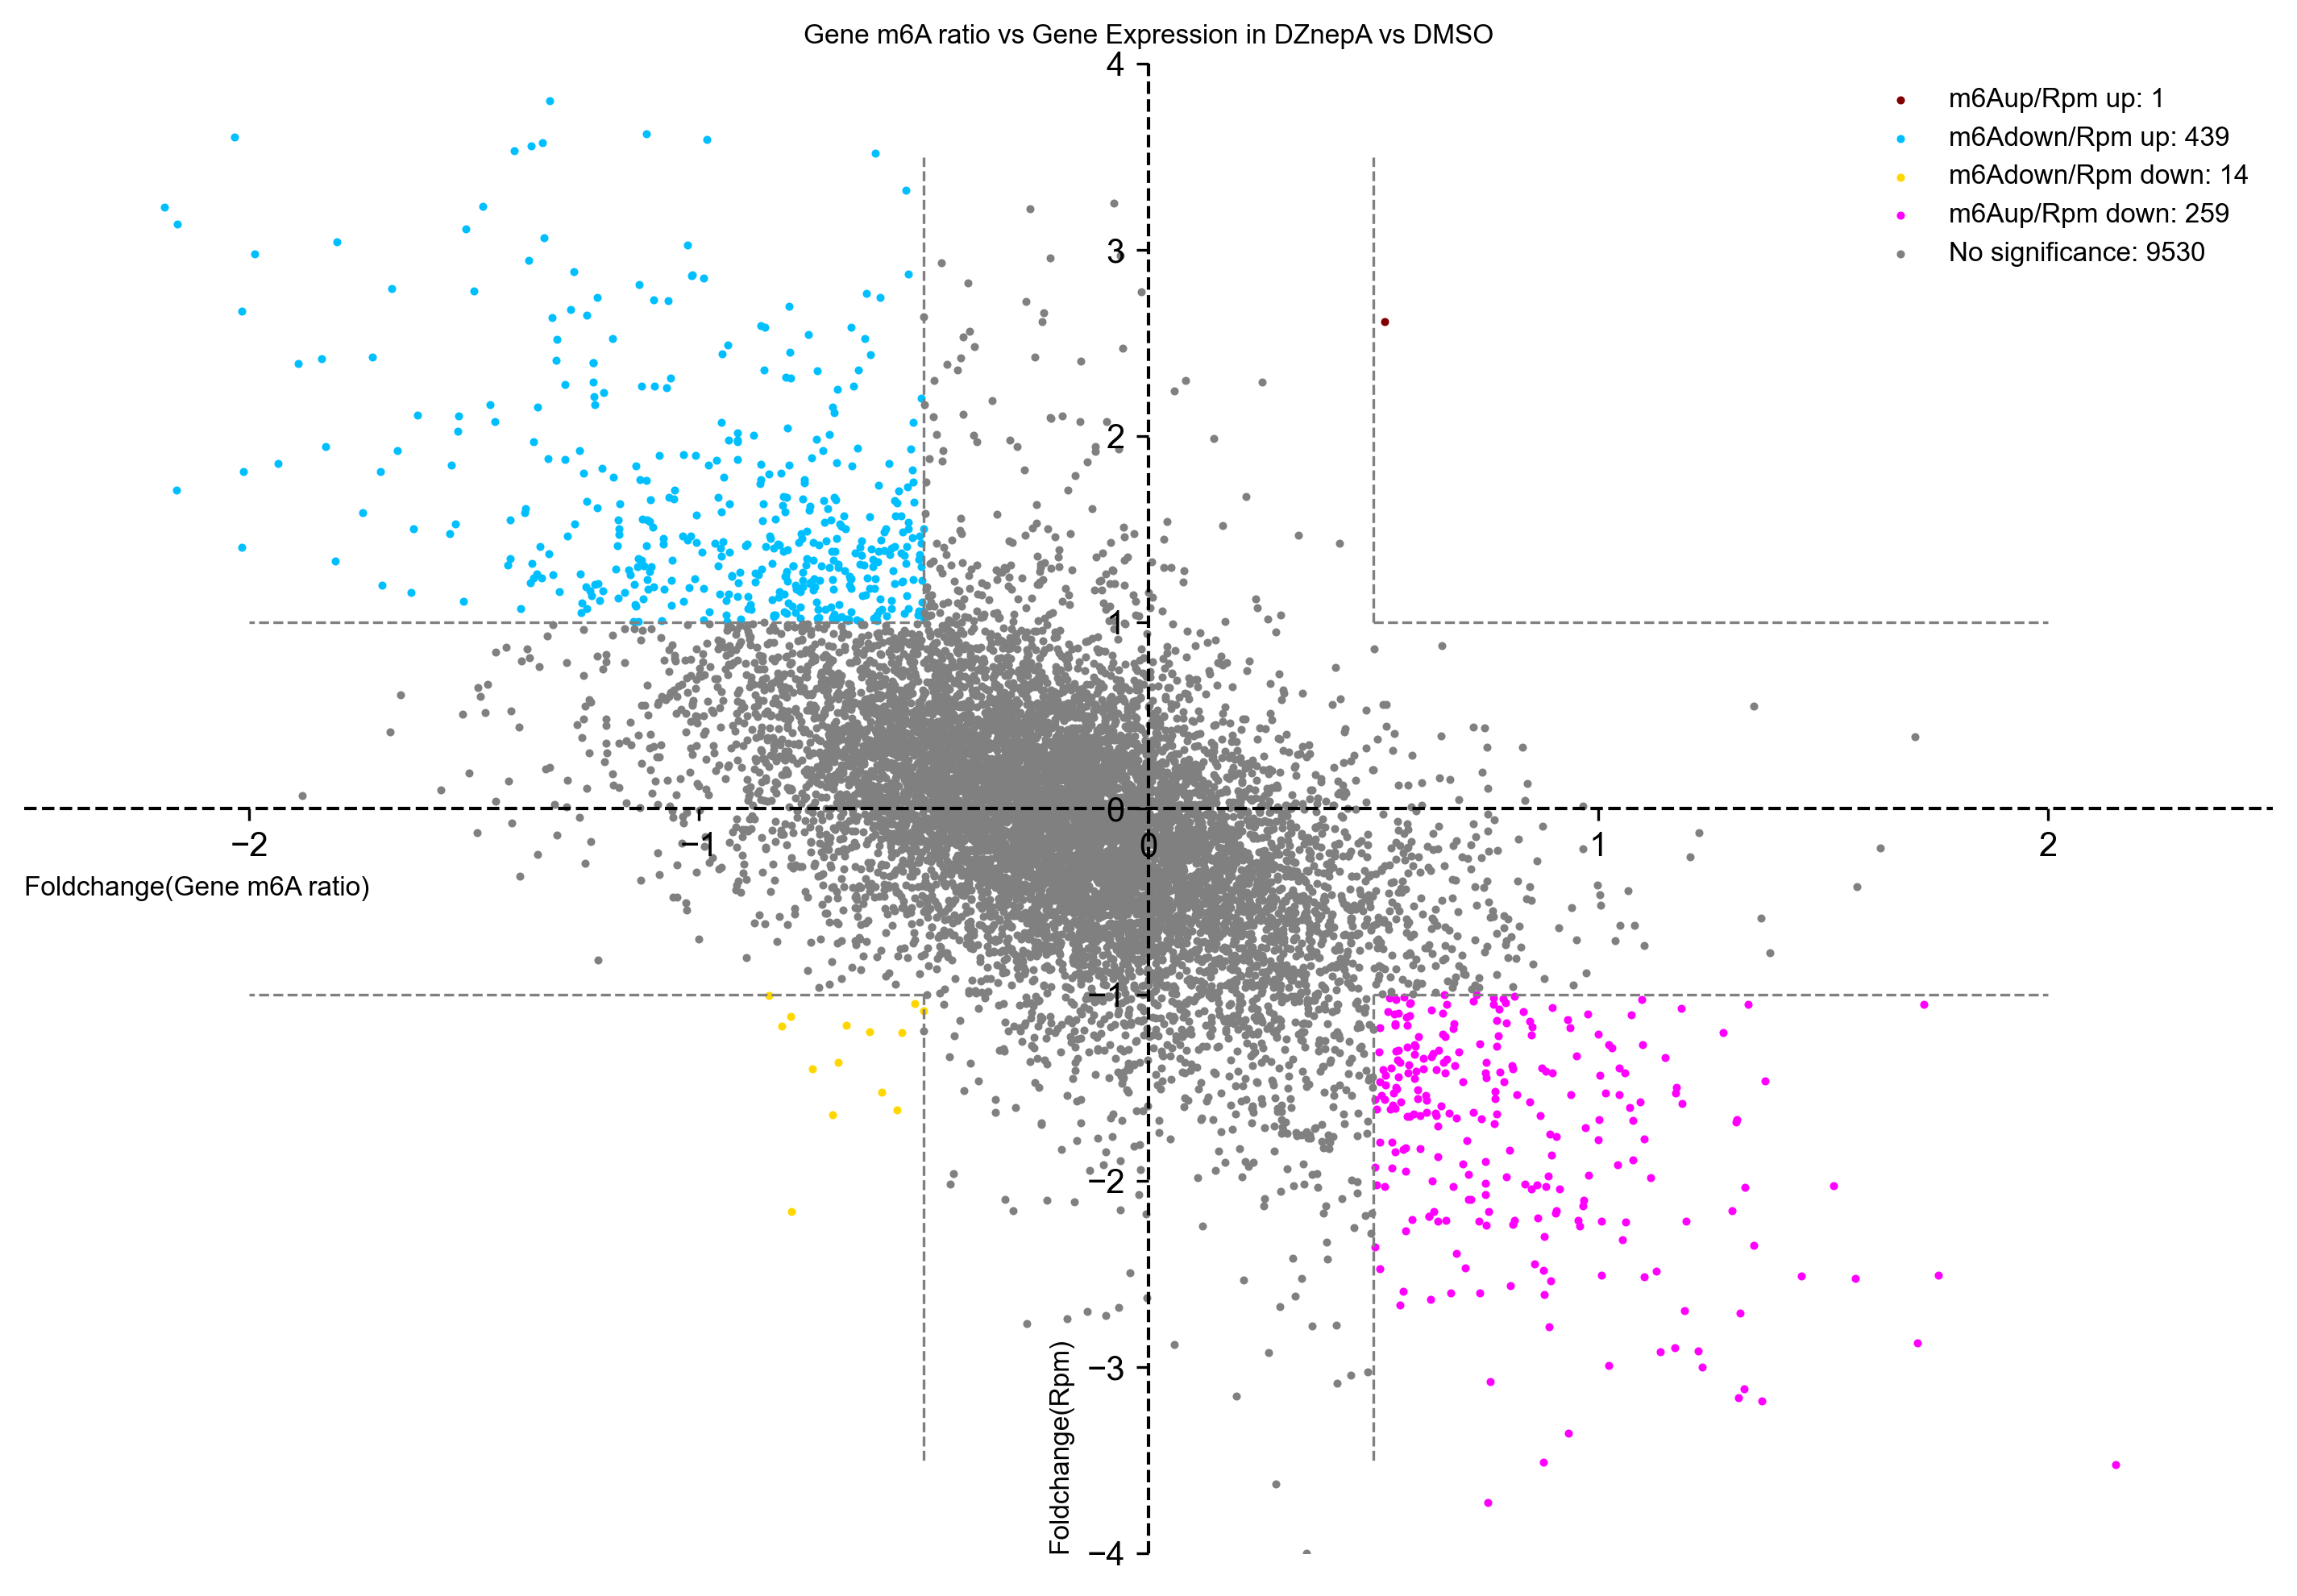

In [296]:
fig, ax = plt.subplots(1, figsize=(12,8), dpi=300)
#####
#####
x ,y = 2.5, 4
ax.plot([-x,x], [0,0], linestyle="--", color="black", linewidth=1)
ax.plot([0,0], [y,-y], linestyle="--", color="black", linewidth=1)


ax.scatter(x=x1, y=y1,s=2, color="maroon", label=f"m6Aup/Rpm up: {len(x1)}")
ax.scatter(x=x2, y=y2,s=2, color="deepskyblue", label=f"m6Adown/Rpm up: {len(x2)}")
ax.scatter(x=x3, y=y3,s=2, color="gold", label=f"m6Adown/Rpm down: {len(x3)}")
ax.scatter(x=x4, y=y4,s=2, color="magenta", label=f"m6Aup/Rpm down: {len(x4)}")
ax.scatter(x=x5, y=y5,s=2, color="grey", label=f"No significance: {len(x5)}")

ax.spines[:].set_visible(False)
ax.spines[["left", "bottom"]].set_position(('data', 0))
###
ax.set_xlim(-x,x)
ax.set_ylim(-y,y)
x = x - 0.5
y = y -0.5

ax.plot((-ratio_fc, -ratio_fc), (express_fc, y), lw=0.8,linestyle='--', c='grey')
ax.plot((-ratio_fc, -ratio_fc), (-express_fc, -y), lw=0.8,linestyle='--', c='grey')
ax.plot((ratio_fc, ratio_fc), (express_fc, y), lw=0.8,linestyle='--', c='grey')
ax.plot((ratio_fc, ratio_fc), (-express_fc, -y), lw=0.8,linestyle='--', c='grey')


ax.plot((ratio_fc, x), (express_fc,express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((-ratio_fc, -x), (express_fc,express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((ratio_fc, x), (-express_fc,-express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((-ratio_fc, -x), (-express_fc,-express_fc),lw=0.8, linestyle='--', c='grey')



###
ax.legend(frameon=False, fontsize=8)
ax.set_title(f"Gene m6A ratio vs Gene Expression in {sample} vs DMSO", fontsize=8)
ax.set_xlabel("Foldchange(Gene m6A ratio)", loc="left", fontsize=8)
ax.set_ylabel("Foldchange(Rpm)", loc="bottom", rotation=90, fontsize=8)
#plt.savefig(f"m6Aratio-and-experssion-in-{sample}.pdf", bbox_inches="tight")

### About EJC

In [220]:
exons = defaultdict(dict)
exon_distribution = []
for gene, values in exon_gff.items():
    exon_num = len(values)
    n = 1
    exons[gene]["total_exon"] = exon_num
    for st, ed, cd in values:
        exons[gene][f"exon{n}"] = {}
        exons[gene][f"exon{n}"]["length"] = cd
        exons[gene][f"exon{n}"]["st"] = st
        exons[gene][f"exon{n}"]["ed"] = ed
        if n == exon_num:
            exons[gene]["last_exon"] = cd
        exon_distribution.append(cd)
        n += 1

Text(0, 0.5, 'Number of exon ')

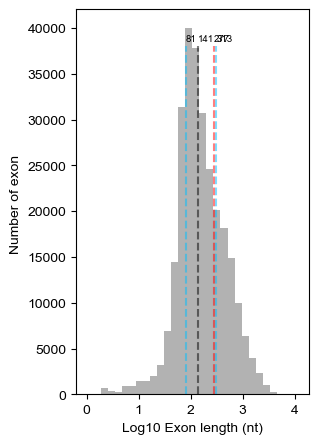

In [233]:
fig, ax = plt.subplots(1, figsize=(3,5), dpi=100)
values = [np.log10(x) for x in exon_distribution if x != 0]
q1, mid, q3 = np.percentile(exon_distribution, (25,50,75))
mean = np.mean(exon_distribution)
box = ax.hist(values, bins=30, color="grey", alpha=0.6)
for x, color in zip([q1, mid, q3, mean], ["deepskyblue", "black", "deepskyblue", "red"]):
    value = np.log10(x)
    ax.plot([value,value], [0, 38000], color=color, linestyle="--", alpha=.5)
    ax.text(x=value, y=38500, s=int(x), fontsize=7)
ax.set_xlabel("Log10 Exon length (nt)")
ax.set_ylabel("Number of exon ")
#plt.savefig("exon length in bamboo(nt).pdf", bbox_inches="tight")

In [221]:
def mark_exon_num(df):
    gene, label, strand = df["gene_name"], df["exon_label"], df["strand"]
    if label == "last_exon":
        label = "exon" + str(exons[gene]["total_exon"])
    if strand == "+":
        rel_exon = (df["position"] - exons[gene][label]["st"]) / exons[gene][label]["length"]
    else:
        rel_exon = abs(df["position"] - exons[gene][label]["ed"]) / exons[gene][label]["length"]
    return exons[gene][label]["length"], rel_exon

In [225]:
site_m6a = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    temp = pd.read_csv(f"pulish/Single-m6A-site-{sample}.ratio", sep="\t", header=0)
    temp[["exon_length", "rel_exon"]] = temp.apply(mark_exon_num, args=(),axis=1, result_type="expand")
    temp["exon_length"] = temp["exon_length"].astype(int)
    temp["site"] = temp.apply(lambda x:x["gene_name"] +"_"+str(x["position"]), axis=1)
    site_m6a[sample] = temp

In [234]:
temp = site_m6a["DMSO"]
temp

gene_name           scaffold  position  mod_num  total_num  \
0      PH02Gene06696    hic_scaffold_21   9829893       23         60   
1      PH02Gene06696    hic_scaffold_21   9830017       18         63   
2      PH02Gene06696    hic_scaffold_21   9830463       21         76   
3      PH02Gene06696    hic_scaffold_21   9830635       34         80   
4      PH02Gene06696    hic_scaffold_21   9830969       59         92   
...              ...                ...       ...      ...        ...   
65315  PH02Gene50732  hic_scaffold_8936      9340       18         27   
65316  PH02Gene50732  hic_scaffold_8936      9377       19         26   
65317  PH02Gene48821  hic_scaffold_2768     11028       19        168   
65318  PH02Gene50977  hic_scaffold_8065      1872       42         77   
65319  PH02Gene50693  hic_scaffold_2920      9393       23        157   

       mod_ratio strand  motif   label  distance   rel_pos exon_label  \
0       0.383333      +  AAACA    cds2     708.0  0.361446      exon2   
1       0.285714      +  AAACA    cds2     832.0  0.391705      exon2   
2       0.276316      +  AGACA    cds2    1278.0  0.500539      exon2   
3       0.425000      +  GGACT    cds2    1450.0  0.542510      exon2   
4       0.641304      +  AAACC    cds2    1784.0  0.624014      exon2   
...          ...    ...    ...     ...       ...       ...        ...   
65315   0.666667      -  GGACA  utr3p1     102.0  1.313292  last_exon   
65316   0.730769      -  GGACT  utr3p1      65.0  1.268089  last_exon   
65317   0.113095      +  GAACT    cds1     356.0  0.890849      exon1   
65318   0.545455      -  GGACC    cds3     504.0  1.068260  last_exon   
65319   0.146497      +  GGACA    cds1     425.0  0.791516      exon1   

                        site  exon_length  rel_exon  
0      PH02Gene06696_9829893         1661  0.329922  
1      PH02Gene06696_9830017         1661  0.404576  
2      PH02Gene06696_9830463         1661  0.673089  
3      PH02Gene06696_9830635         1661  0.776641  
4      PH02Gene06696_9830969         1661  0.977724  
...                      ...          ...       ...  
65315     PH02Gene50732_9340          487  0.626283  
65316     PH02Gene50732_9377          487  0.550308  
65317    PH02Gene48821_11028          412  0.861650  
65318     PH02Gene50977_1872          244  0.725410  
65319     PH02Gene50693_9393          686  0.758017  

[65320 rows x 15 columns]

#### m6A exon with longer length

Text(0, 0.5, 'Log10 m6A Exon length(nt)')

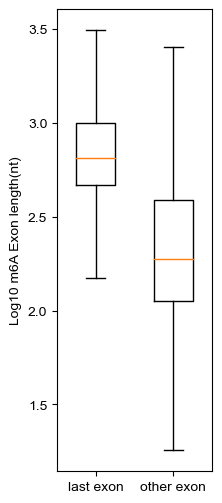

In [236]:
fig, ax = plt.subplots(1, figsize=(2,6), dpi=100)
t1 = [np.log10(x) for x in temp[temp["exon_label"] == "last_exon"]["exon_length"]]
t2 = [np.log10(x) for x in temp[temp["exon_label"] != "last_exon"]["exon_length"]]
box = ax.boxplot([t1, t2], labels=["last exon", "other exon"], showfliers=False, widths=0.5)

ax.set_ylabel("Log10 m6A Exon length(nt)")
#ax.set_xlabel("m6A Exon Length (nt)")
#plt.savefig("m6A exon length distributon.pdf", bbox_inches="tight")

#### m6a enrich in non-last exon

Text(0.5, 0, 'm6A relative position in exon')

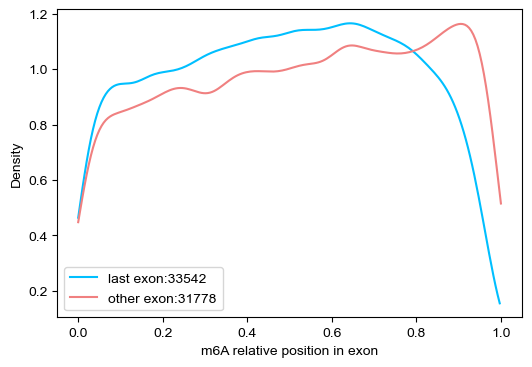

In [235]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=100)
t1, t2 = temp[temp["exon_label"] == "last_exon"], temp[temp["exon_label"] != "last_exon"]
sns.kdeplot(t1["rel_exon"], label=f"last exon:{len(t1)}", color="deepskyblue", cut=0)
sns.kdeplot(t2["rel_exon"], label=f"other exon:{len(t2)}", color="lightcoral", cut=0)

ax.legend()
ax.set_xlabel("m6A relative position in exon")  
#ax.set_xlabel("m6A Exon Length (nt)")
#plt.savefig("m6A exon length distributon.pdf", bbox_inches="tight")

#### m6a enrich in exons with more than 1000 nt in bamboo

In [237]:
range0 = range(0,20000)
range1 = range(1, 1000)
range2 = range(1000, 20000)
range3 = range(1500, 20000)
#range4 = range(1500,20000)

Text(0.5, 0, 'm6A relative position in single exon')

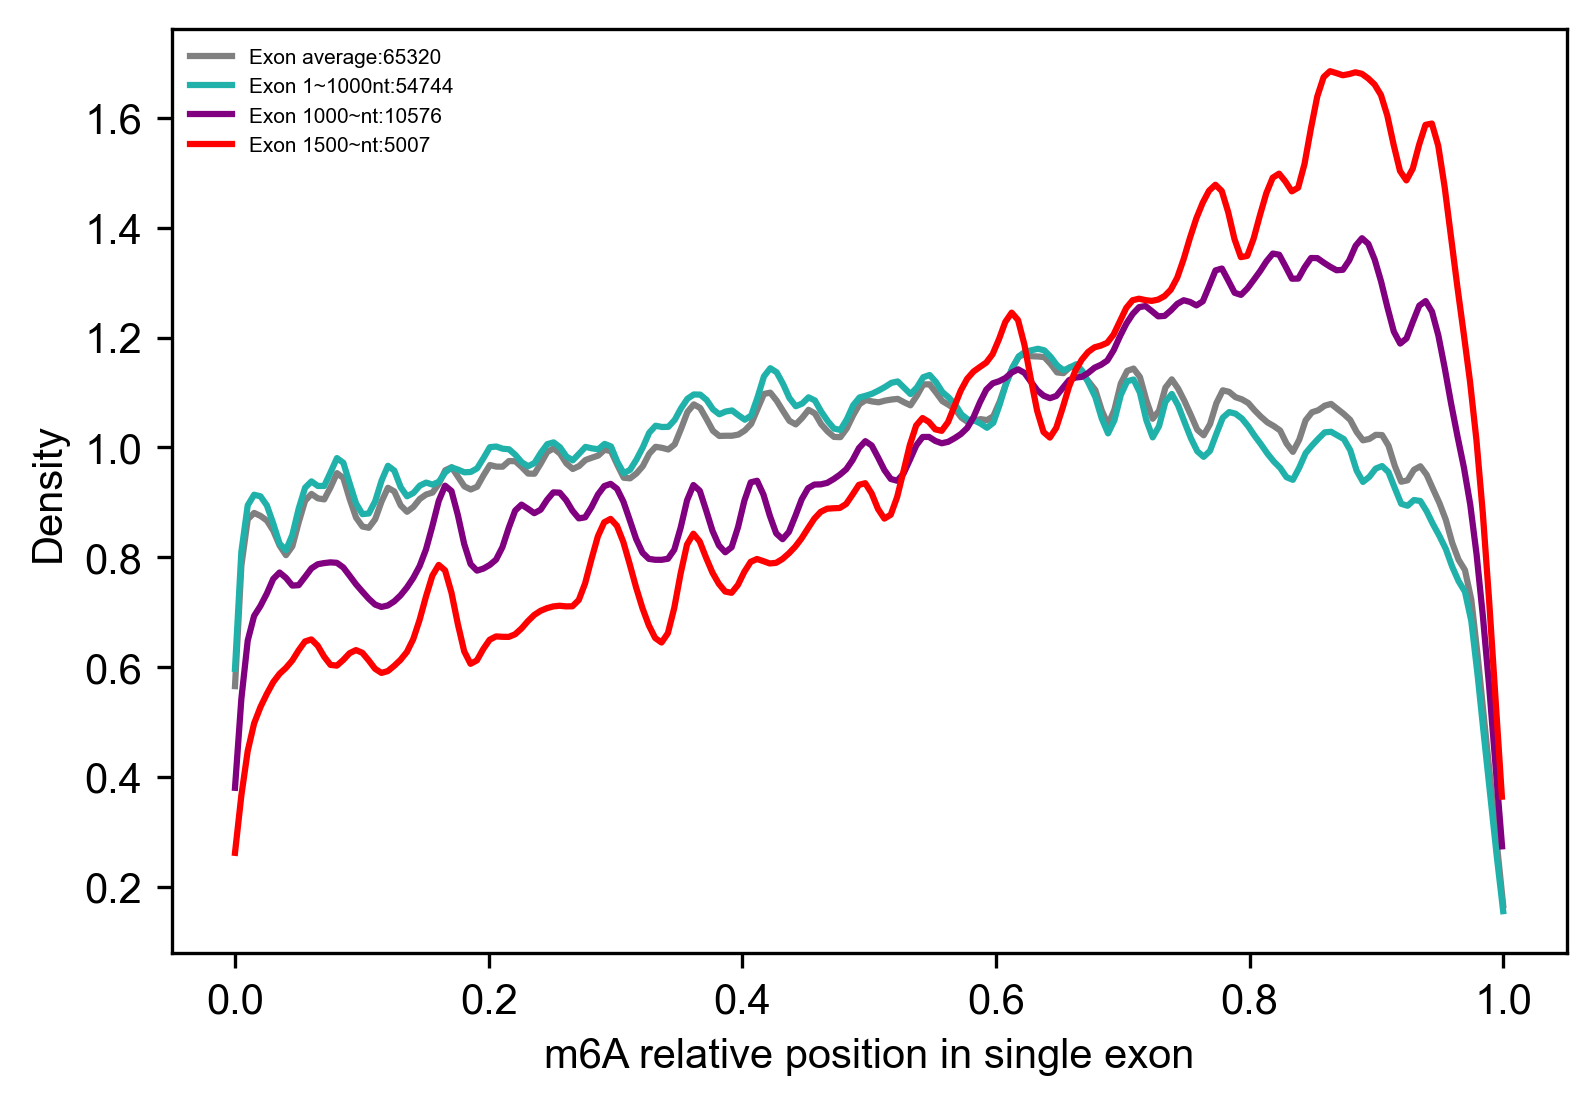

In [238]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=300)
for sample in ["DMSO"]:
    for ran, ty, color in zip([range0, range1, range2, range3], ["average", "1~1000nt", "1000~nt", "1500~nt"], ["grey", "lightseagreen", "purple", "red"]):
        temp = site_m6a[sample]
        temp[["exon_length", "rel_exon"]] = temp.apply(mark_exon_num, args=(),axis=1, result_type="expand")
        temp["exon_length"] = temp["exon_length"].astype(int)
        temp = temp[temp["exon_length"].isin(ran)]
        sns.kdeplot(temp["rel_exon"], cut=0, fill=False, label="Exon"+" "+ty+f":{len(temp)}", ax=ax, lw=1.5, bw_adjust=.2, color=color) 
ax.legend(fontsize=5, frameon=False)
ax.set_xlabel("m6A relative position in single exon")
#plt.savefig("m6A position in exon.pdf", bbox_inche="tight")

In [241]:
up = de[de["label"] == "up"]
down = de[de["label"] == "down"]

/tmp/ipykernel_50648/1115993365.py:4: RuntimeWarning: divide by zero encountered in log10
  box0 = [np.log10(x) for x in exon_distribution ]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Log10 Exon length(nt)')

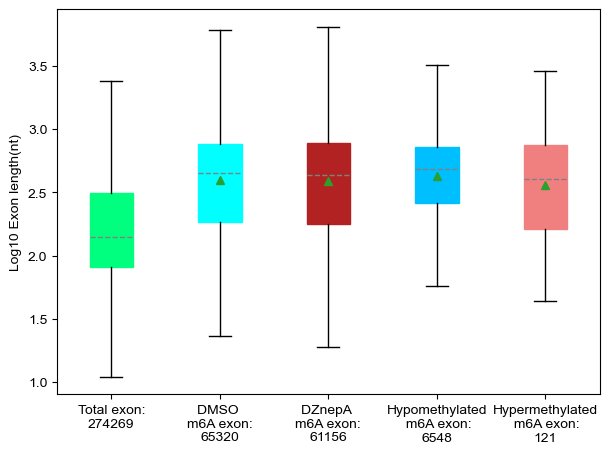

In [243]:
fig, ax = plt.subplots(1, figsize=(7,5), dpi=100)
sample = "DZnepA"

box0 = [np.log10(x) for x in exon_distribution ]
box1 = [np.log10(x) for x in site_m6a["DMSO"]["exon_length"]]
box2 = [np.log10(x) for x in site_m6a[sample]["exon_length"]]
temp3 = site_m6a[sample][site_m6a[sample]["site"].isin(down.index)]
temp4 = site_m6a[sample][site_m6a[sample]["site"].isin(up.index)]
box3 = [np.log10(x) for x in temp3["exon_length"]]
box4 = [np.log10(x) for x in temp4["exon_length"]]



box = ax.boxplot([box0, box1, box2, box3, box4], showfliers=False, widths=0.4, medianprops={"ls":'--', "color":"grey"},showmeans=True,patch_artist=True,
labels=[f"Total exon:\n{len(box0)}", f"DMSO \nm6A exon:\n{len(box1)}", f"{sample} \nm6A exon:\n{len(box2)}", f"Hypomethylated\n m6A exon:\n{len(box3)}", f"Hypermethylated\n m6A exon:\n{len(box4)}"])

box["boxes"][0].set_color("springgreen")
box["boxes"][1].set_color("cyan")
box["boxes"][2].set_color("firebrick")
box["boxes"][3].set_color("deepskyblue")
box["boxes"][4].set_color("lightcoral")


ax.legend(frameon=False)
ax.set_ylabel("Log10 Exon length(nt)")
#plt.savefig("exon length of m6A or non-m6A.pdf", bbox_inches="tight")

# 2.Full-length ratio Analysis 

In [4]:
assign = pd.read_csv("Assigned-reads.csv", index_col=0, sep=",", header=0)

In [400]:
assign

chrom  alen  ref_st  \
a14db144-5454-434e-9ebe-0ab2901849db      hic_scaffold_1  3565  342819   
c11972b9-1c2f-4d64-bc12-70707964f36c      hic_scaffold_1  3114  343633   
333ddfe2-a348-4023-900d-838a93186c1f      hic_scaffold_1   157  755648   
9f86bb68-0385-4333-a671-dae8359e84a9      hic_scaffold_1  2617  784771   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b      hic_scaffold_1  2749  784773   
...                                                  ...   ...     ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439  hic_scaffold_19684   955    4320   
faf11921-53b2-47d5-abe6-b6c4ede5aca0  hic_scaffold_19684  3592    4320   
5c2f5412-8502-46ab-8172-3b82da1696ad  hic_scaffold_19684  4131    4321   
dad05e4e-02d5-4549-8f87-5f22ca774d89  hic_scaffold_19684   485    4324   
38968bb6-921a-492b-8bf2-a7dbf2a4698b  hic_scaffold_19684  3544    4324   

                                      ref_ed strand  quality  polya_length  \
a14db144-5454-434e-9ebe-0ab2901849db  346384      +       58         40.95   
c11972b9-1c2f-4d64-bc12-70707964f36c  346747      +       60         59.91   
333ddfe2-a348-4023-900d-838a93186c1f  755805      -        0         -1.00   
9f86bb68-0385-4333-a671-dae8359e84a9  787388      +       60         95.27   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  787522      +       60         -1.00   
...                                      ...    ...      ...           ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439    5275      -       21         15.81   
faf11921-53b2-47d5-abe6-b6c4ede5aca0    7912      -        4         30.00   
5c2f5412-8502-46ab-8172-3b82da1696ad    8452      -        7         65.63   
dad05e4e-02d5-4549-8f87-5f22ca774d89    4809      -       22         63.55   
38968bb6-921a-492b-8bf2-a7dbf2a4698b    7868      -        2         38.48   

                                                qc_tag  Assigned_gene    NAT  \
a14db144-5454-434e-9ebe-0ab2901849db          SUFFCLIP  PH02Gene41925  False   
c11972b9-1c2f-4d64-bc12-70707964f36c              PASS  PH02Gene41925  False   
333ddfe2-a348-4023-900d-838a93186c1f  READ_FAILED_LOAD  PH02Gene49996  False   
9f86bb68-0385-4333-a671-dae8359e84a9              PASS  PH02Gene50548  False   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  READ_FAILED_LOAD  PH02Gene50548  False   
...                                                ...            ...    ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439              PASS  PH02Gene50871  False   
faf11921-53b2-47d5-abe6-b6c4ede5aca0              PASS  PH02Gene50871  False   
5c2f5412-8502-46ab-8172-3b82da1696ad              PASS  PH02Gene50871  False   
dad05e4e-02d5-4549-8f87-5f22ca774d89           ADAPTER  PH02Gene50871  False   
38968bb6-921a-492b-8bf2-a7dbf2a4698b              PASS  PH02Gene50871  False   

                                         APA  Full_length  Read_percent  \
a14db144-5454-434e-9ebe-0ab2901849db       0        False        0.8738   
c11972b9-1c2f-4d64-bc12-70707964f36c  346747        False        0.7632   
333ddfe2-a348-4023-900d-838a93186c1f       0        False        0.0425   
9f86bb68-0385-4333-a671-dae8359e84a9  787388         True        0.9287   
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b  787529         True        0.9755   
...                                      ...          ...           ...   
a73d12e8-3e4b-4d09-ad4a-a92ae56ed439    4320        False        0.1819   
faf11921-53b2-47d5-abe6-b6c4ede5aca0    4320        False        0.6841   
5c2f5412-8502-46ab-8172-3b82da1696ad    4320        False        0.7867   
dad05e4e-02d5-4549-8f87-5f22ca774d89    4320        False        0.0924   
38968bb6-921a-492b-8bf2-a7dbf2a4698b    4320        False        0.6749   

                                      sample   rep  
a14db144-5454-434e-9ebe-0ab2901849db    DMSO  rep1  
c11972b9-1c2f-4d64-bc12-70707964f36c    DMSO  rep1  
333ddfe2-a348-4023-900d-838a93186c1f    DMSO  rep1  
9f86bb68-0385-4333-a671-dae8359e84a9    DMSO  rep1  
c4b5d32c-48d7-4ec6-829d-d991dcdaf17b    DMSO  rep1  
...                                      ... 

In [401]:
transcriptome_rpm, drs_read = {}, {}
full_df = {}
for sample, data in assign.groupby("sample"):
    drs_read[sample] = len(data)
    transcriptome_rpm[sample], full_df[sample] = {}, defaultdict(dict)
    for gene, genes in data.groupby("Assigned_gene"):
        transcriptome_rpm[sample][gene] = len(genes)
        for tag, reads in genes.groupby("Full_length"):
            full_df[sample][gene][tag] = len(reads)

### Read Full-length ratio in samples

In [323]:
result = {}
for sample, samples in assign.groupby("sample"):
    print(sample)
    for tag, reads in samples.groupby("Full_length"):
        if tag:
            print(len(reads) / len(samples))
            result[sample] = len(reads) / len(samples)


5-azaC
0.2427140072243564
DMSO
0.3997340513193059
DZnepA
0.49503124734575177


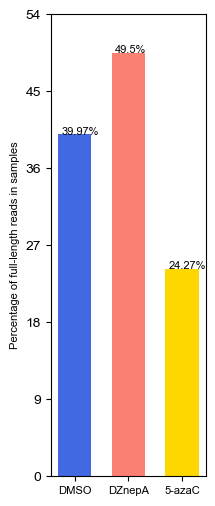

In [326]:
fig, ax = plt.subplots(1,figsize=(2,6))
x = [0.4,1.2, 2.0]
y = [39.97, 49.50, 24.27]
for p,s in zip(x,y):
    ax.text(p-0.2,s,s=f"{s}%", fontsize=8)
ax.bar(x=x, height=y, color=cl.values(), width=0.5)
ax.set_ylabel("Percentage of full-length reads in samples", fontsize=8)
ax.set_xticks(ticks=x, labels=["DMSO","DZnepA", "5-azaC"], fontsize=8)
ticks =[int(x) for x in  np.linspace(0, 54, 7)]
ax.set_ylim(0, max(ticks))
ax.set_yticks(ticks, ticks)
#plt.savefig("Full-ratio-total.pdf", bbox_inches="tight")

### Read Coverage

In [32]:
def cal_rel_pos(df, ref_ed, ref_st):
    st, ed, strand = df[["ref_st", "ref_ed", "strand"]]
    cd = ref_ed - ref_st
    if strand == "+":
        rel_st = (st - ref_st) / cd
        rel_ed = (ed - ref_st) / cd 
    else:
        rel_st = (ref_ed - ed) / cd
        rel_ed = (ref_ed - st) / cd
    return rel_st, rel_ed


def cal_rel_st_pos(df, ref_st, ref_ed, cd):
    st, ed, strand = df[["ref_st", "ref_ed", "strand"]]
    if strand == "+":
        return (st - ref_st) 
    else:
        return (ref_ed - ed)



def cal_density(df,result, bins=100):
    st, ed = int(df["rel_st"]*bins), int(df["rel_ed"]*bins)
    if ed > bins:
        ed = bins
    if st < 0:
        st = 0
    for x in range(st, ed):
        result[x] += 1

    
def get_plot_values(data):
    total = sum(data.values())
    x, y = [], []
    for bin, value in sorted(data.items()):
        x.append(bin)
        y.append(value / total)
    return x, y

In [29]:
with tqdm(total=len(assign)) as phar:
    for gene, temp in assign.groupby("Assigned_gene"):
        strand = gff_data[gene]["strand"]
        ref_st, ref_ed = gff_len[gene]
        cd = ref_ed - ref_st
        if strand == "+":
            assign.loc[temp.index, ["rel_st"]] = (temp["ref_st"] - ref_st) / cd
            assign.loc[temp.index, ["rel_ed"]] = (temp["ref_ed"] - ref_st) / cd
            phar.update(len(temp))
        else:
            assign.loc[temp.index, ["rel_st"]] = (ref_ed - temp["ref_ed"]) / cd
            assign.loc[temp.index, ["rel_ed"]] = (ref_ed - temp["ref_st"]) / cd
            phar.update(len(temp))

  0%|          | 0/8142865 [00:00<?, ?it/s]

In [329]:
bins = 100

full_data = defaultdict(dict)

for sample in ["DMSO", "DZnepA", "5-azaC"]:
    samples = assign[assign["sample"] == sample]
    full_data[sample]["full"] = {x:0 for x in range(0,bins)}
    full_data[sample]["nofull"] = {x:0 for x in range(0,bins)}

    for flag, values in samples.groupby("Full_length"):
        if flag == True:
            values.apply(cal_density, args=(full_data[sample]["full"], bins), axis=1)
        else:
            values.apply(cal_density, args=(full_data[sample]["nofull"], bins), axis=1)
    print(sample, "Finish")

DMSO Finish
DZnepA Finish
5-azaC Finish


Text(0, 0.5, 'Density')

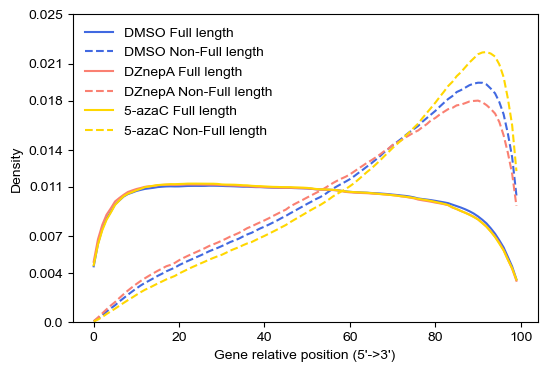

In [334]:
fig, ax = plt.subplots(1, figsize=(6,4))

for sample, values in full_data.items():
    x,y = get_plot_values(values["full"])
    ax.plot(x, y, color=cl[sample], label=f"{sample} Full length")
    x,y = get_plot_values(values["nofull"])
    ax.plot(x, y, color=cl[sample], label=f"{sample} Non-Full length", linestyle="--")



ticks =[round(x, 3) for x in  np.linspace(0, 0.025, 8)]
ax.set_ylim(0, max(ticks))
ax.set_yticks(ticks, ticks)



ax.legend(frameon=False)
ax.set_xlabel("Gene relative position (5'->3')")
ax.set_ylabel("Density")
#plt.savefig("Full-length-coverage.pdf", bbox_inches="tight")


### Genes with different full-length ratio

In [335]:
sample = "DZnepA" ### 5-azaC, DZnepA

In [346]:
for sample in ["DZnepA", "5-azaC"]:
    dmso = pd.DataFrame.from_dict(full_df["DMSO"], orient="index").fillna(0)
    dmso.columns = ["DMSO-nofull", "DMSO-full"]
    data = pd.DataFrame.from_dict(full_df[sample], orient="index").fillna(0)
    data.columns = [f"{sample}-nofull", f"{sample}-full"]
    data = pd.concat([data, dmso], join="inner", axis=1)
    data[:] = data[:].astype(int)

    phar = tqdm(total=len(data))
    data["pvalue"] = data.apply(get_fisher_test, args=(phar,), axis=1)
    phar.close()

    data = data[data["pvalue"] < 0.005]
    data["DMSO-ratio"] = data["DMSO-full"] / (data["DMSO-full"] + data["DMSO-nofull"])
    data[f"{sample}-ratio"] = data[f"{sample}-full"] / (data[f"{sample}-full"] + data[f"{sample}-nofull"])
    data["foldchange"] = np.log2(data[f"{sample}-ratio"] / data["DMSO-ratio"])
    data["label"] = data["foldchange"].apply(lambda x:"up" if x > 0 else "down")
    data.to_csv(f"Full-ratio-significant-changed-gene-{sample}.csv")
    print(sample, "FINISH")

/tmp/ipykernel_50648/1603411610.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data[:] = data[:].astype(int)


  0%|          | 0/29475 [00:00<?, ?it/s]

/home/Sorata/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Load data

In [350]:
sample = "DZnepA"
data = pd.read_csv(f"Full-ratio-significant-changed-gene-{sample}.csv", index_col=0)
data

DZnepA-nofull  DZnepA-full  DMSO-nofull  DMSO-full  \
PH02Gene00015           1381         3565          190        243   
PH02Gene00026            206          391          222        238   
PH02Gene00035            325          980          628       1170   
PH02Gene00055            103           82           86         29   
PH02Gene00057            186          314          441        418   
...                      ...          ...          ...        ...   
PH02Gene02319              0           76            9         53   
PH02Gene07403              0           10            5          0   
PH02Gene08188              0            4            9          1   
PH02Gene13992              0           15            7          5   
PH02Gene39615              0            6           16          4   

                     pvalue  DMSO-ratio  DZnepA-ratio  foldchange label  
PH02Gene00015  1.711088e-11    0.561201      0.720784    0.361051    up  
PH02Gene00026  7.088578e-06    0.517391      0.654941    0.340110    up  
PH02Gene00035  1.984239e-09    0.650723      0.750958    0.206688    up  
PH02Gene00055  8.959837e-04    0.252174      0.443243    0.813680    up  
PH02Gene00057  4.918338e-07    0.486612      0.628000    0.367992    up  
...                     ...         ...           ...         ...   ...  
PH02Gene02319  5.293644e-04    0.854839      1.000000    0.226276    up  
PH02Gene07403  3.330003e-04    0.000000      1.000000         inf    up  
PH02Gene08188  4.995005e-03    0.100000      1.000000    3.321928    up  
PH02Gene13992  8.918618e-04    0.416667      1.000000    1.263034    up  
PH02Gene39615  9.121313e-04    0.200000      1.000000    2.321928    up  

[2628 rows x 9 columns]

#### Gene full-length ratio

Text(0.5, 0, 'Full-length ratio per gene in DMSO')

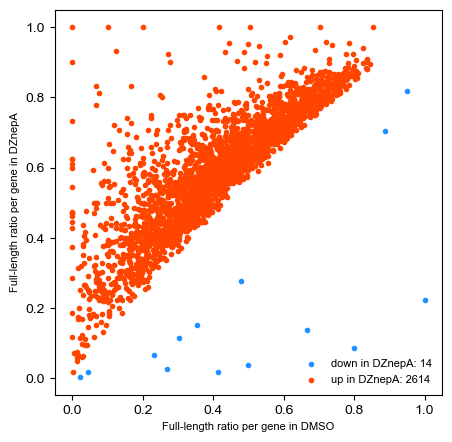

In [354]:
fig, ax = plt.subplots(1, figsize=(5,5))
temp_color = {"down":"dodgerblue", "up":"orangered"}
for label, values in data.groupby("label"):
    ax.scatter(x=values["DMSO-ratio"], y=values[f"{sample}-ratio"], s=9, label=f"{label} in {sample}: {len(values)}", color=temp_color[label])

ax.legend(frameon=False, fontsize=8)
ax.set_ylabel(f"Full-length ratio per gene in {sample}", fontsize=8)
ax.set_xlabel("Full-length ratio per gene in DMSO", fontsize=8)
#plt.savefig("Full-length-percent-VS-DZnepA.pdf", bbox_inches="tight")

### Full-length reads process more m6A

In [7]:
def get_reads_data(fp):
    temp = pd.read_csv(fp + "/genome_abandance.0.5.bed",sep="\t", 
                       names=["chrome","site","gene","read_name","rel_read_pos","motif"], 
                       usecols=["site","gene","read_name"])
    temp["read_name"] = temp["read_name"].apply(lambda x:x.split(".")[0])
    temp = temp[temp["gene"].notna()]
    temp["pos"] = temp.apply(lambda x:x["gene"] + "_" + str(x["site"]), axis=1)

    sites = []
    with open(fp + "/ratio.0.5.normalized.tsv", 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            m6a, total = 0, []
            for i in info[1:]:
                site, mod, read, ratio = i.split("|")
                sites.append(f"{gene}_{site}") 
    
    return temp[temp["pos"].isin(sites)]

In [8]:
m6a_read = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    fp = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}"
    temp = get_reads_data(fp)
    temp["sample"] = sample
    m6a_read = pd.concat([m6a_read, temp])
    print(sample, "Finish")

DMSO Finish
DZnepA Finish
5-azaC Finish


#### Get m6A split from full-length reads and non-full-length reads

In [ ]:
full_reads = assign[assign["Full_length"] == True]
full_reads_m6a = m6a_read[m6a_read["read_name"].isin(full_reads.index)]

In [395]:
####### get full-length reads
full_reads = assign[assign["Full_length"] == True]
full_reads_m6a = m6a_read[m6a_read["read_name"].isin(full_reads.index)]

######## calculate numbers of full-length reads each gene
full_reads_gene = defaultdict(dict)
for sample, samples in full_reads.groupby("sample"):
    for gene, genes in samples.groupby("Assigned_gene"):
        full_reads_gene[sample][gene] = len(genes)

####### calculate m6A ratio in full-length reads per gene
full_reads_m6a_ratio = {}
for sample, samples in full_reads_m6a.groupby("sample"):
    full_reads_m6a_ratio[sample] = []
    for pos, num in samples.groupby("pos"):
        gene = pos.split("_")[0]
        if gene in full_reads_gene[sample]:
            full_reads_m6a_ratio[sample].append(len(num) / full_reads_gene[sample][gene])

In [396]:
#### 
nofull_reads = assign[assign["Full_length"] == False]
nofull_reads_m6a = m6a_read[m6a_read["read_name"].isin(nofull_reads.index)]

####
nofull_reads_gene = defaultdict(dict)
for sample, samples in nofull_reads.groupby("sample"):
    for gene, genes in samples.groupby("Assigned_gene"):
        nofull_reads_gene[sample][gene] = len(genes)

####
nofull_reads_m6a_ratio = {}
for sample, samples in nofull_reads_m6a.groupby("sample"):
    nofull_reads_m6a_ratio[sample] = []
    for pos, num in samples.groupby("pos"):
        gene = pos.split("_")[0]
        if gene in nofull_reads_gene[sample]:
            nofull_reads_m6a_ratio[sample].append(len(num) / nofull_reads_gene[sample][gene])

In [397]:
values, labels = [], []
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    values.append(full_reads_m6a_ratio[sample])
    values.append(nofull_reads_m6a_ratio[sample])
    labels.append(f"Full-length-reads \n in {sample}")
    labels.append(f"NO-Full-length-reads \n in {sample}")

(0.0, 0.8)

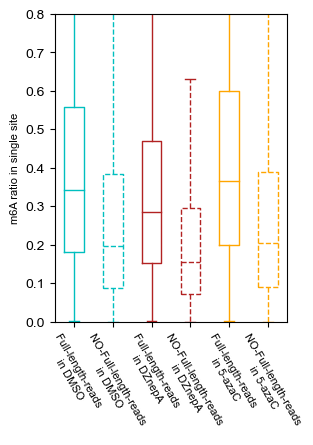

In [398]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
box = ax.boxplot(values, labels=labels, showfliers=False)
########
colors = ["c", "c", "firebrick", "firebrick", "orange", "orange"]
colors_w = ["c", "c", "c", "c","firebrick", "firebrick","firebrick", "firebrick", "orange", "orange","orange", "orange"]
########
for patch, color in zip(box["medians"], colors):
    patch.set_color(color)
for patch, color in zip(box["boxes"], colors):
    patch.set_color(color)
for patch, color in zip(box["whiskers"], colors_w):
    patch.set_color(color)
for patch, color in zip(box["caps"], colors_w):
    patch.set_color(color)
for n in [1,3,5]:
    box["boxes"][n].set_linestyle('--')
    box["medians"][n].set_linestyle('--')
for n in [2,3,6,7,10,11]:
    box["whiskers"][n].set_linestyle('--')
#######
#######
ax.set_ylabel("m6A ratio in single site", fontsize=8)
ax.set_xticklabels(rotation=300, labels=labels, fontsize=8)
ax.set_ylim(0,0.8)
#plt.savefig("Full-length and NO-Full-length m6A ratio.pdf", bbox_inches="tight")

#### m6A reads and no-m6A coverage

In [14]:
full_read_id = m6a_read["read_name"].tolist()

In [ ]:
def cal_rel_pos(df, ref_ed, ref_st):
    st, ed, strand = df[["ref_st", "ref_ed", "strand"]]
    cd = ref_ed - ref_st
    if strand == "+":
        rel_st = (st - ref_st) / cd
        rel_ed = (ed - ref_st) / cd 
    else:
        rel_st = (ref_ed - ed) / cd
        rel_ed = (ref_ed - st) / cd
    return rel_st, rel_ed


def cal_rel_st_pos(df, ref_st, ref_ed, cd):
    st, ed, strand = df[["ref_st", "ref_ed", "strand"]]
    if strand == "+":
        return (st - ref_st) 
    else:
        return (ref_ed - ed)


def cal_density(df,result, bins=100):
    st, ed = int(df["rel_st"]*bins), int(df["rel_ed"]*bins)
    if ed > bins:
        ed = bins
    if st < 0:
        st = 0
    for x in range(st, ed):
        result[x] += 1

    
def get_plot_values(data):
    total = sum(data.values())
    x, y = [], []
    for bin, value in sorted(data.items()):
        x.append(bin)
        y.append(value / total)
    return x, y

In [30]:
bins = 100

read_data = defaultdict(dict)

for sample in ["DMSO", "DZnepA", "5-azaC"]:
    samples = assign[assign["sample"] == sample]
    samples["read_id"] = samples.index

    temp = samples[samples["read_id"].isin(full_read_id)]
    read_data[sample]["m6a"] = {x:0 for x in range(0,bins)}
    temp.apply(cal_density, args=(read_data[sample]["m6a"], bins), axis=1)

    temp = samples[~samples["read_id"].isin(full_read_id)]
    read_data[sample]["nom6a"] = {x:0 for x in range(0,bins)}
    temp.apply(cal_density, args=(read_data[sample]["nom6a"], bins), axis=1)

    print(sample, "Finish")


/tmp/ipykernel_136468/3139441574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["read_id"] = samples.index


DMSO Finish


/tmp/ipykernel_136468/3139441574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["read_id"] = samples.index


DZnepA Finish


/tmp/ipykernel_136468/3139441574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["read_id"] = samples.index


5-azaC Finish


Text(0, 0.5, 'Density')

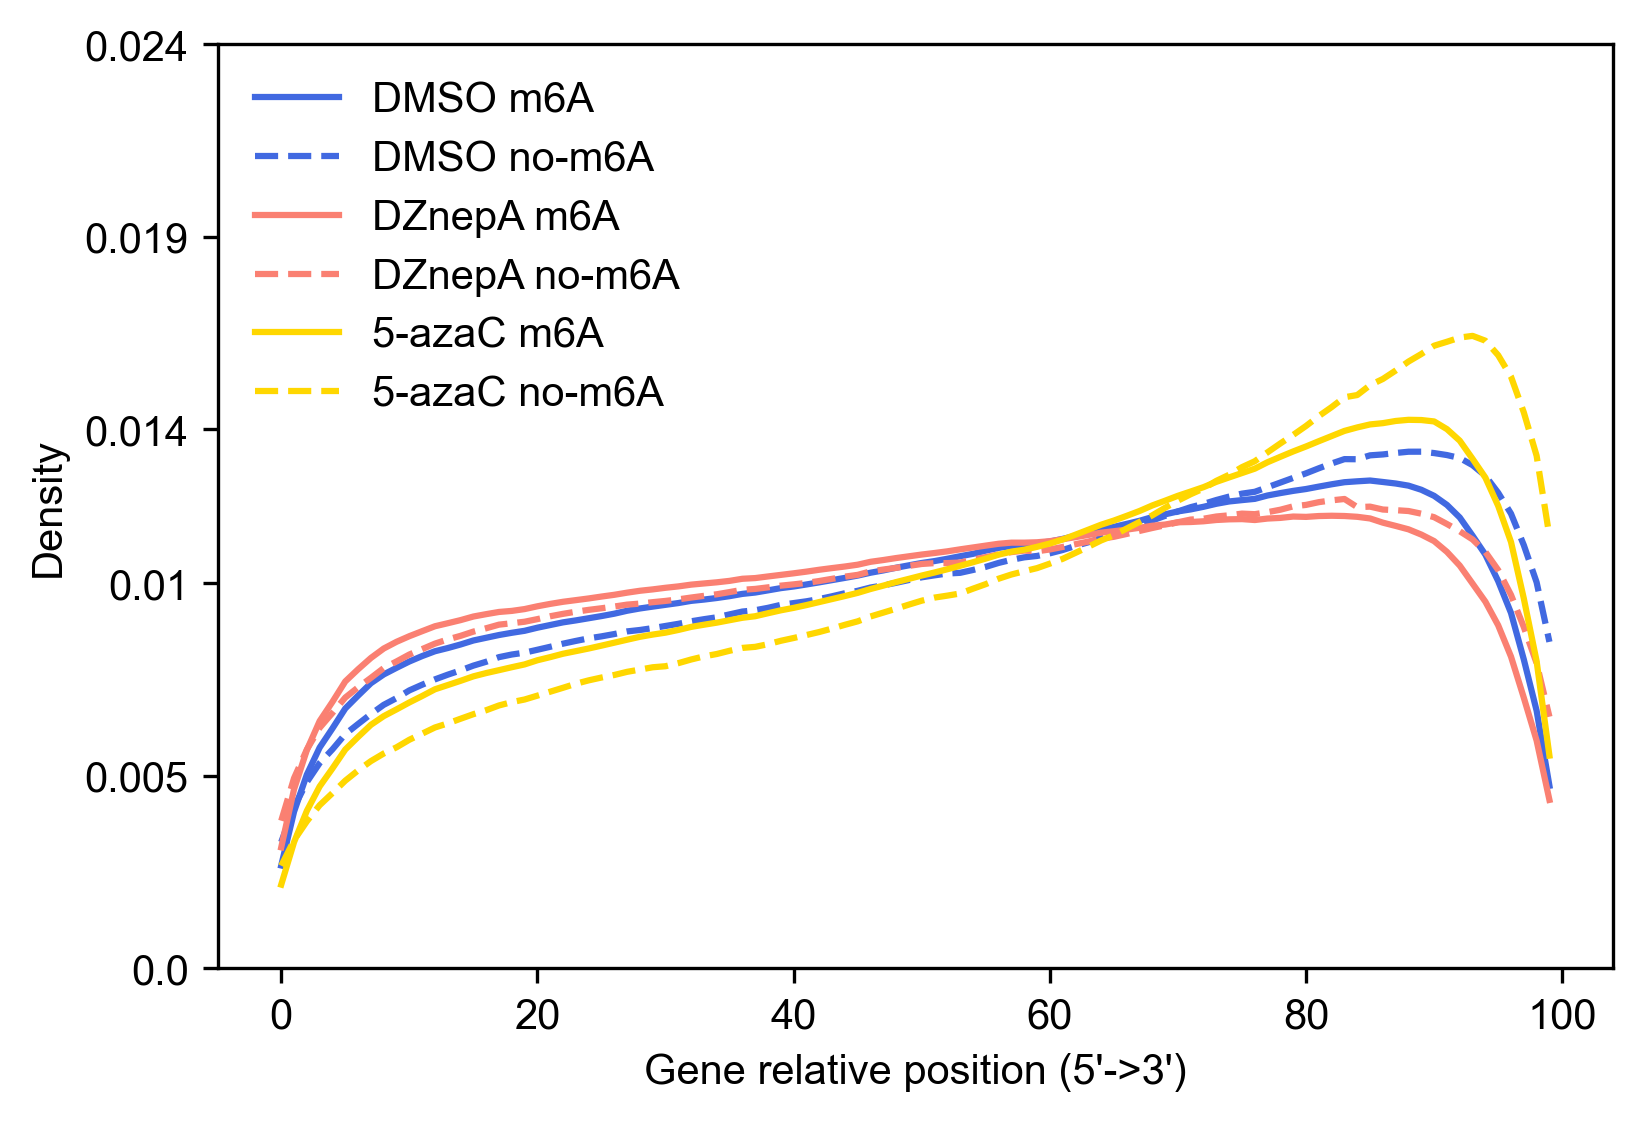

In [33]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=300)

for sample, values in read_data.items():
    x,y = get_plot_values(read_data[sample]["m6a"])
    ax.plot(x, y, color=cl[sample], label=f"{sample} m6A")
    x,y = get_plot_values(read_data[sample]["nom6a"])
    ax.plot(x, y, color=cl[sample], label=f"{sample} no-m6A", linestyle="--")


ticks =[round(x, 3) for x in  np.linspace(0, 0.024, 6)]
ax.set_ylim(0, max(ticks))
ax.set_yticks(ticks, ticks)


ax.legend(frameon=False)
ax.set_xlabel("Gene relative position (5'->3')")
ax.set_ylabel("Density")
#plt.savefig("m6a-read-full-coverage.pdf", bbox_inches="tight")

# 3.Alternative Splcing Analysis

### Different transcript length distribution

In [60]:
def get_stringtie_assembly():
    gff_fp = "//media/Sorata/data3/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    #gff_fp = "G:/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    gff_data = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if ty == "transcript":
                gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[1].split(" ")[2][1:-1]
                gff_data.setdefault(transcript, 0)
            else:
                gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[1].split(" ")[2][1:-1]
                # region = [int(st), int(ed)]
                gff_data[transcript] += abs(int(ed) - int(st)) + 1
    return gff_data


stringtie = get_stringtie_assembly()

In [40]:
def get_espresso_assembly():
    gff_fp = "//media/Sorata/data3/bamboo/9_AS/espresso/bamboo/bamboo_N2_R0_updated.gtf"
    gff_fp = "/media/Sorata/data3/bamboo/9_AS/SUPPA/03_AS-event-base-on-espresso/espresso.annotated.gtf"
    gff_data = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if ty == "transcript":
                #gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[0].split(" ")[1][1:-1]
                gff_data.setdefault(transcript, 0)
            else:
                #gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[0].split(" ")[1][1:-1]
                # region = [int(st), int(ed)]
                gff_data[transcript] += abs(int(ed) - int(st)) + 1
    return gff_data

espresso = get_espresso_assembly()

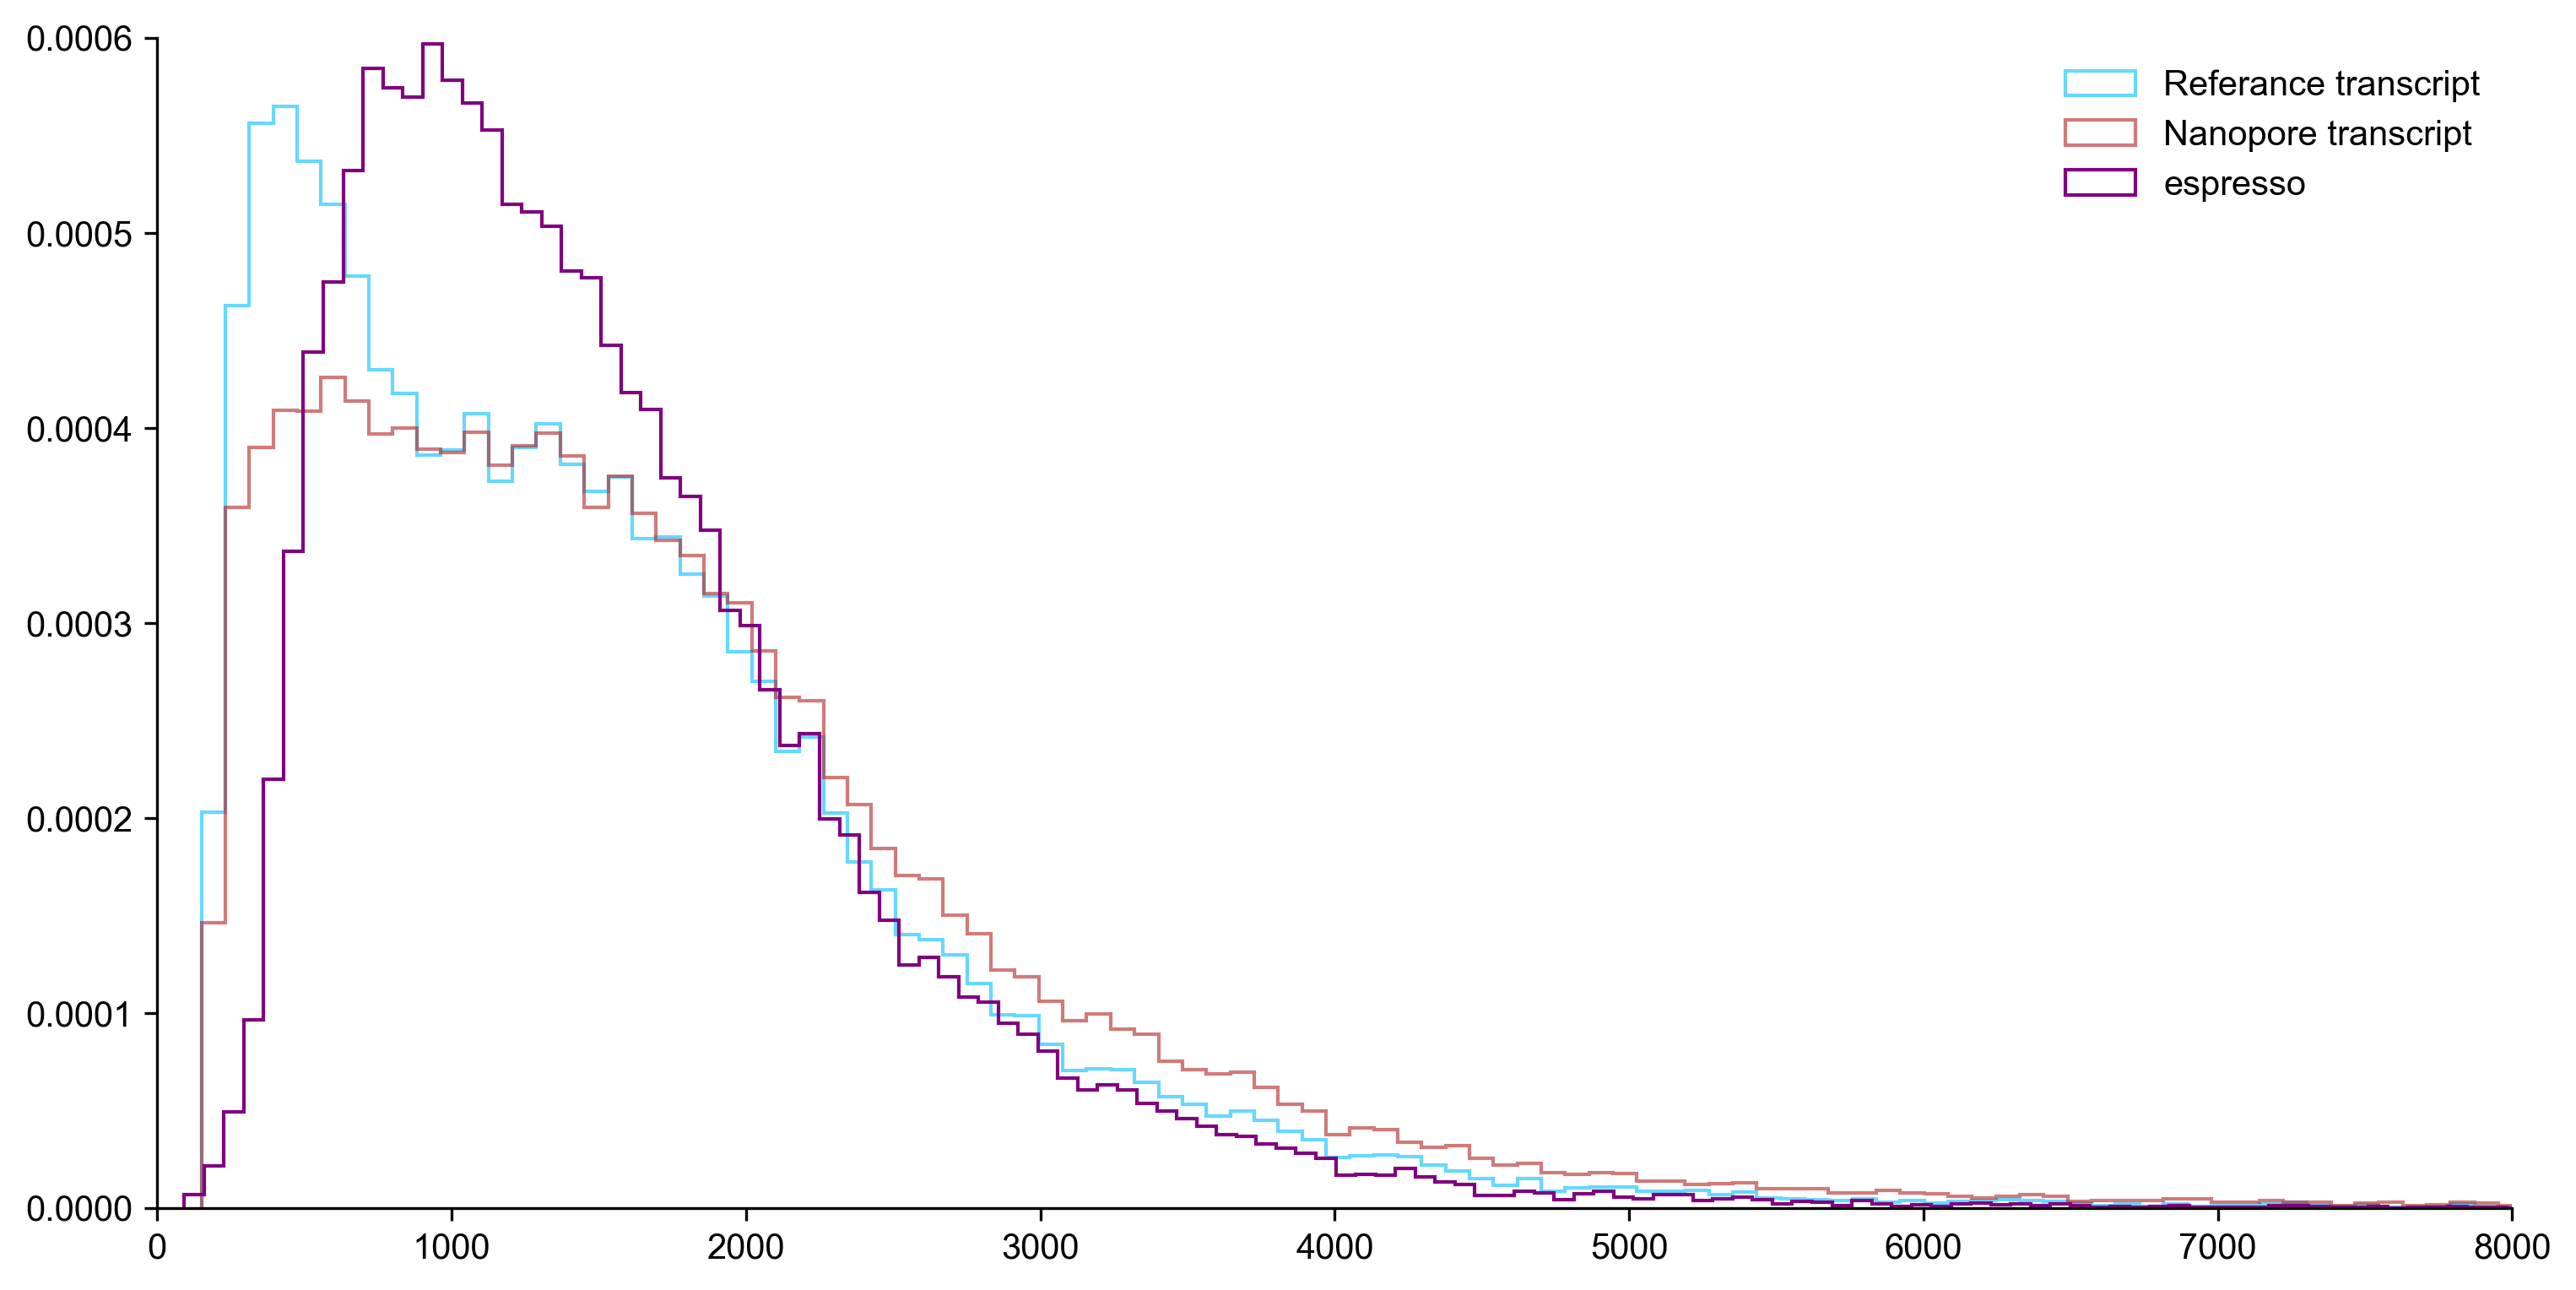

In [41]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=300)
t1 = list(exon_len.values())
t2 = list(stringtie.values())
t3 = list(espresso.values())


ax.hist(t1, bins=200, density="density", color="deepskyblue",rwidth=.9, label="Referance transcript" , histtype="step",alpha=.6)
ax.hist(t2, bins=200, density="density", color="firebrick",rwidth=.9,  label="Nanopore transcript", histtype="step" ,alpha=.6)
ax.hist(t3, bins=200, density="density", color="purple", rwidth=.9,  label="espresso", histtype="step")
ax.set_xlim(0, 8000)
ax.set_ylim(0, 0.0006)
ax.legend(frameon=False)
#ax.set_xticks()
ax.spines[["top", "right"]].set_color(None)
#plt.savefig("transcript.pdf", bbox_inches="tight")

### Numbers of AS event count

In [8]:
as_num = defaultdict(dict)
events = ["RI","SE", "A3","A5", "AF", "AL", "MX"]
as_path = "G:/bamboo/9_AS/SUPPA/06_single/"
#as_path = "/media/Sorata/data3/bamboo/9_AS/SUPPA/06_single"
for sample in ["DMSO", "DZnepA"]:
    for event in events:
        with open(as_path+f"/{sample}_{event}_strict.ioe") as f:
            n = 0
            next(f)
            as_num[sample][event] = 0
            for line in f:
                as_num[sample][event] += 1

In [44]:
for sample in ["DMSO", "DZnepA"]:
    print(sample, '-----------')
    for e, v in as_num[sample].items():
        print(e, v, v/sum(as_num[sample].values()))

DMSO -----------
RI 3747 0.5788660590143674
SE 876 0.13533137648694576
A3 778 0.12019156496215047
A5 650 0.10041711725629537
AF 252 0.03893094392090221
AL 143 0.022091765796384985
MX 27 0.0041711725629538085
DZnepA -----------
RI 4276 0.5229301699889936
SE 1269 0.15519139048550815
A3 1084 0.13256695609636787
A5 909 0.11116546410664058
AF 300 0.03668827198238963
AL 296 0.03619909502262444
MX 43 0.005258652317475847


Text(0, 0.5, 'Gene number')

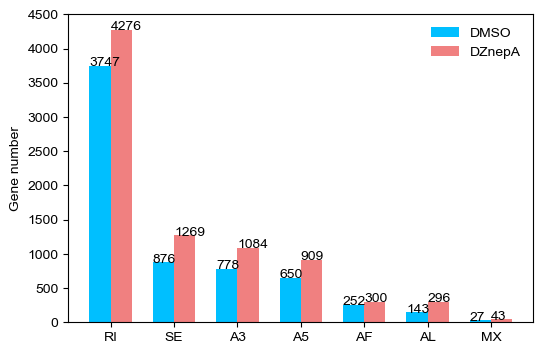

In [46]:
fig, ax = plt.subplots(1, figsize=(6,4))
wd = 0.8

####
pos = [x*3*wd for x in range(0, len(as_num["DMSO"]))]
for x, y in zip(pos, as_num["DMSO"].values()):
    ax.text(x-wd/2, y , s=y)
ax.bar(height=as_num["DMSO"].values(), x=pos, label="DMSO", color="deepskyblue")

####
pos2 = [x+wd for x in pos]
for x, y in zip(pos2, as_num["DZnepA"].values()):
    ax.text(x-wd/2, y , s=y)
ax.bar(height=as_num["DZnepA"].values(), x=pos2, label="DZnepA", color="lightcoral")


#####
pos3 = [x+wd/2 for x in pos]
ax.set_xticks(labels=events, ticks=pos3)


ax.legend(frameon=False)
ax.set_ylim(0, 4500)
ax.set_ylabel("Gene number")
#plt.savefig("AS-bar-1.pdf", bbox_inches="tight")

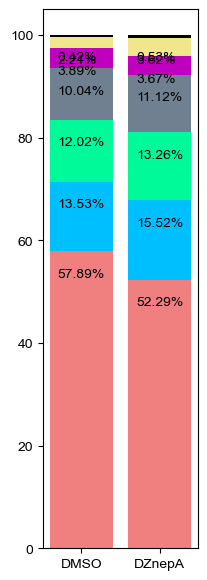

In [48]:
colors = {"RI":"lightcoral", "SE":"deepskyblue", "A3":"mediumspringgreen", "A5":"slategray", "AF":"m", "AL":"khaki", "MX":"k"}

fig, ax = plt.subplots(1, figsize=(2,7))
pos = 0
for sample, values in as_num.items():
    total = sum(values.values())
    y = 0
    for event, num in values.items():
        num = round(num / total * 100, 2)
        ax.bar(height=num, bottom=y, color=colors[event], x=pos)
        y += num
        ax.text(pos-0.3, y-5, s=f"{num}%")
    pos += 1    
ax.set_xticks(labels=["DMSO", "DZnepA"], ticks=[0, 1])
#plt.savefig("AS-bar-2.pdf", bbox_inches="tight")

### AS event Upsetplot

In [49]:
from upsetplot import plot
from upsetplot import from_contents

In [50]:
as_num = defaultdict(dict)
as_path = "/media/Sorata/data3/bamboo/9_AS/SUPPA/03_AS-event/"
as_event = defaultdict(dict)
for event in ["A3","A5", "AF", "AL", "MX", "RI", "SE"]:
    as_num[event] = []
    with open(as_path+f"/samples_{event}_strict.ioe") as f:
        n = 0
        next(f)
        for line in f:
            transcripts = line.split("\t")[3].split(",")
            as_num[event] += transcripts
            for transcript in transcripts:
                as_event.setdefault(transcript, "|")
                as_event[transcript] += f"{event}|"
    as_num[event] = list(set(as_num[event]))


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

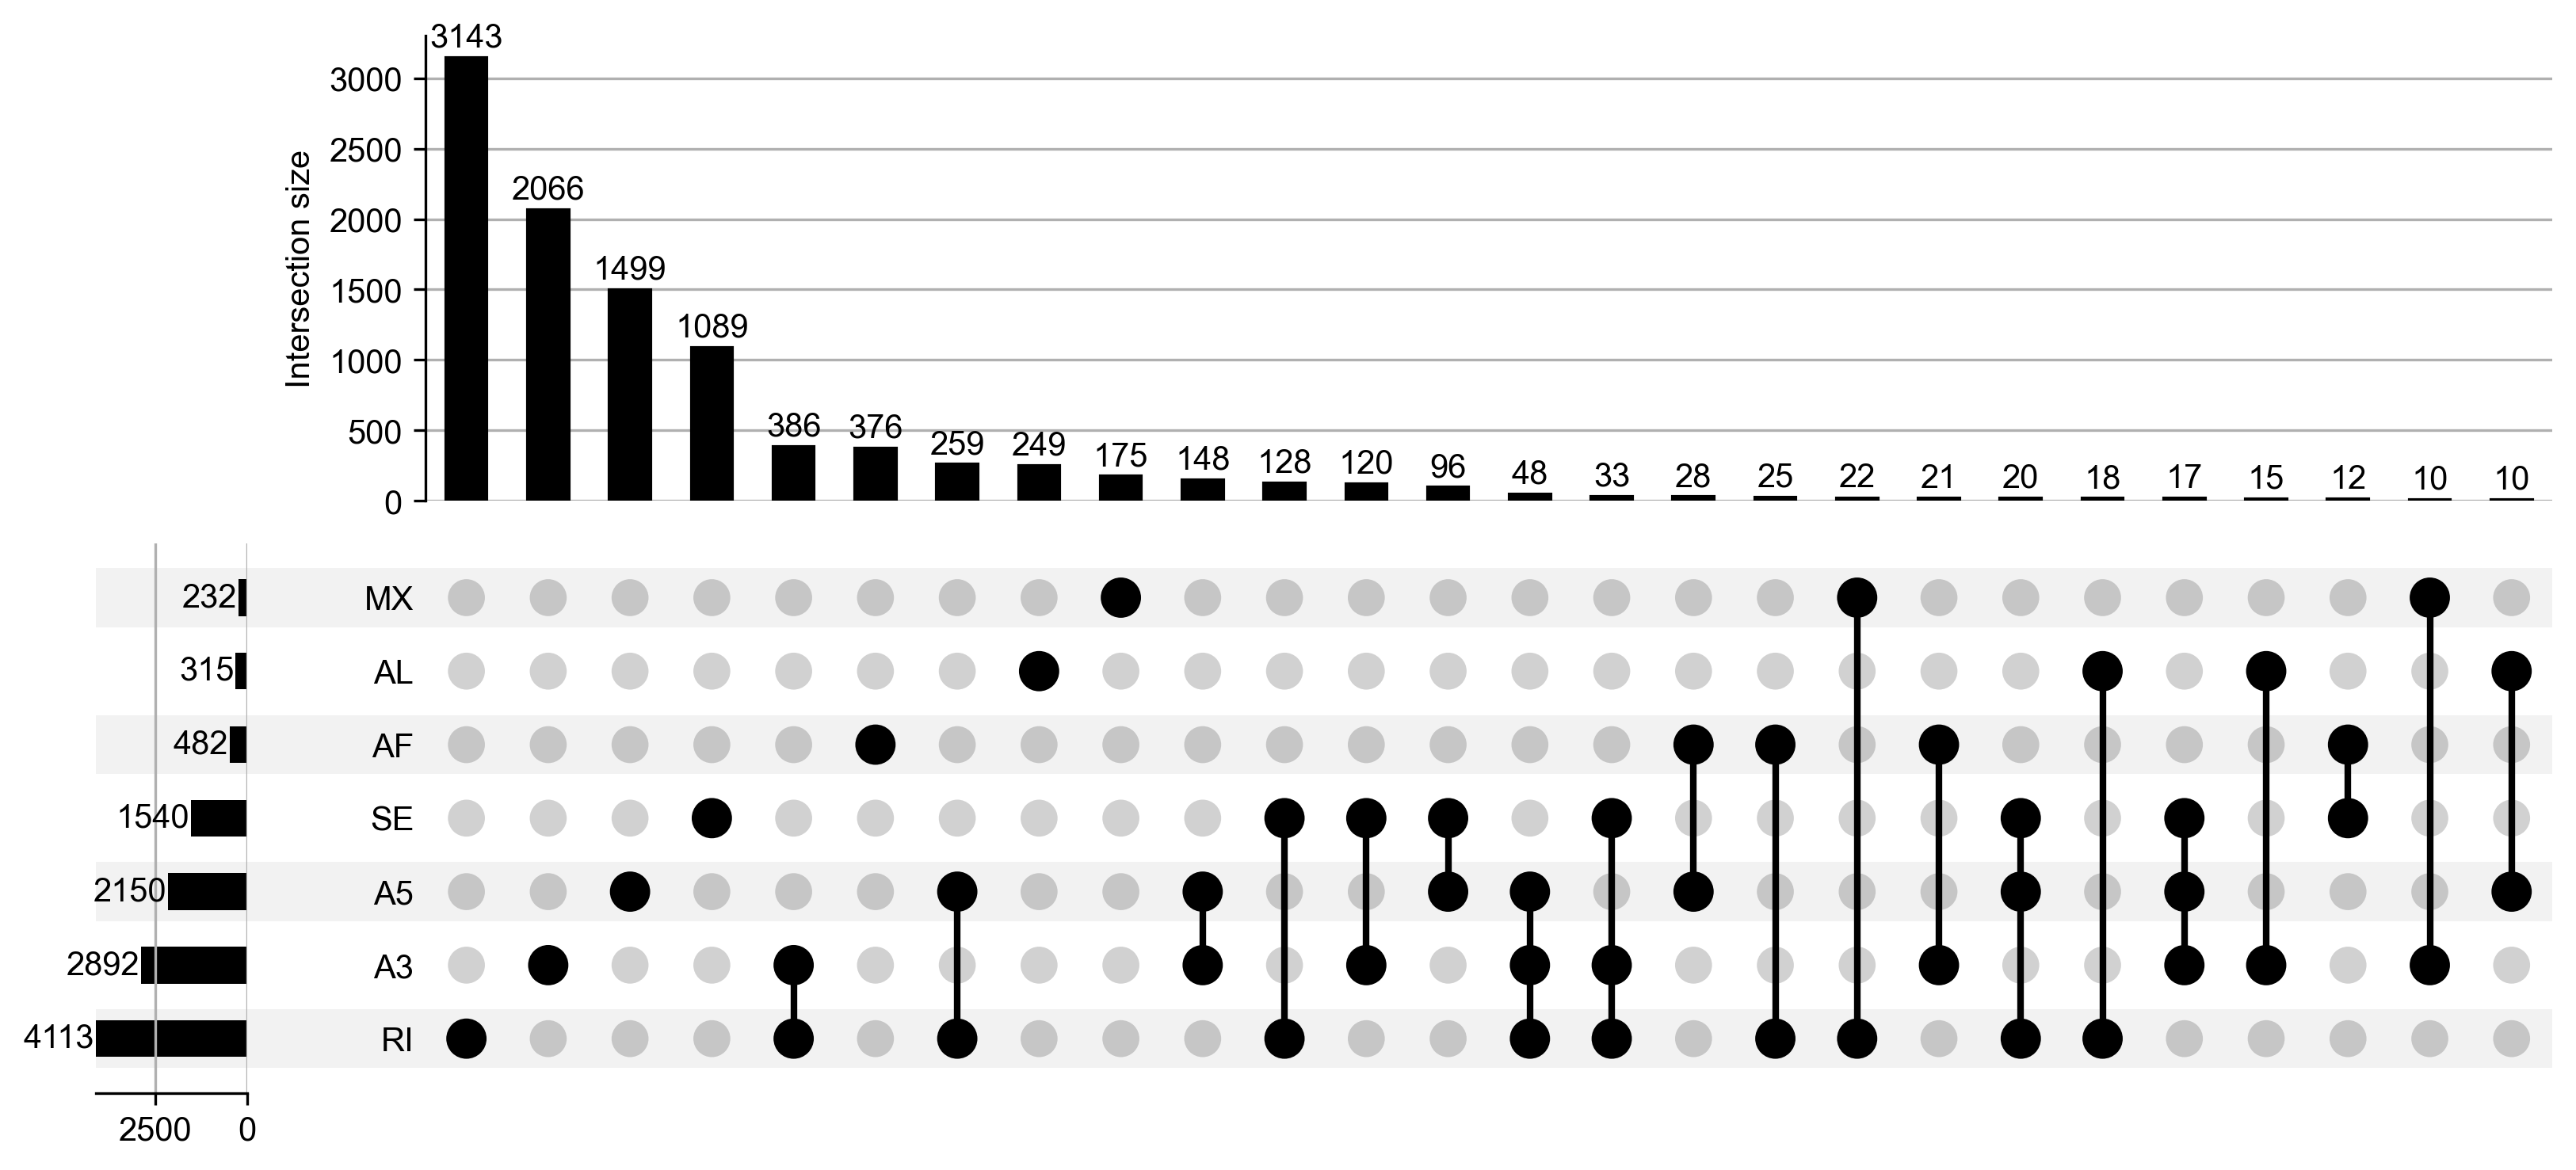

In [51]:
example = from_contents(as_num)
fig = plt.figure(dpi=300)
plot(example, show_counts="%d", min_subset_size=10, fig=fig, sort_by="cardinality")
#plt.savefig("upset.pdf", bbox_inches="tight")   

### diff AS event by SUPPA2

In [52]:
diffas = "/media/Sorata/data3//bamboo/9_AS/SUPPA/05_diffsplice/diffsplice.dpsi"
diffas = pd.read_csv(diffas, sep="\t")

In [53]:
def mark_as(x):
    if x == "A3":
        return "o"
    elif x == "A5":
        return "v"
    elif x == "SE":
        return "s"
    elif x == "RI":
        return "H"
    elif x == "AF":
        return "*"
    elif x == "AL":
        return "D"
    else:
        return "d"       


#diffas = diffas[diffas["DMSO-DZnepA_p-val"] < 0.05]
diffas["event"] = diffas.apply(lambda x:x.name.split(":")[0].split(";")[1], axis=1)
diffas["Y"] = -np.log10(diffas["DMSO-DZnepA_p-val"])
diffas["mark"] = diffas["event"].apply(mark_as)
diffas

/home/Sorata/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


DMSO-DZnepA_dPSI  \
MPH.10000;RI:hic_scaffold_15:87287048:87287655-...          0.256236   
MPH.10000;RI:hic_scaffold_15:87288766:87288772-...          0.000000   
MPH.10003;A5:hic_scaffold_15:87329858-87329960:...         -0.018863   
MPH.10003;RI:hic_scaffold_15:87330172:87330280-...          0.000000   
MPH.10005;SE:hic_scaffold_15:87336266-87337348:...          0.004280   
...                                                              ...   
MPH.9979;RI:hic_scaffold_15:86539617:86539731-8...         -0.102331   
MPH.9982;RI:hic_scaffold_15:86684205:86684253-8...          0.045828   
MPH.9984;A3:hic_scaffold_15:86788206-86788296:8...         -0.106098   
MPH.9989;RI:hic_scaffold_15:87053942:87054205-8...         -0.137299   
MPH.9992;SE:hic_scaffold_15:87082913-87083007:8...          0.000192   

                                                    DMSO-DZnepA_p-val event  \
MPH.10000;RI:hic_scaffold_15:87287048:87287655-...           0.067932    RI   
MPH.10000;RI:hic_scaffold_15:87288766:87288772-...           0.420080    RI   
MPH.10003;A5:hic_scaffold_15:87329858-87329960:...           0.456543    A5   
MPH.10003;RI:hic_scaffold_15:87330172:87330280-...           0.456543    RI   
MPH.10005;SE:hic_scaffold_15:87336266-87337348:...           0.318681    SE   
...                                                               ...   ...   
MPH.9979;RI:hic_scaffold_15:86539617:86539731-8...           0.197802    RI   
MPH.9982;RI:hic_scaffold_15:86684205:86684253-8...           0.252747    RI   
MPH.9984;A3:hic_scaffold_15:86788206-86788296:8...           0.086414    A3   
MPH.9989;RI:hic_scaffold_15:87053942:87054205-8...           0.060440    RI   
MPH.9992;SE:hic_scaffold_15:87082913-87083007:8...           0.438561    SE   

                                                           Y mark  
MPH.10000;RI:hic_scaffold_15:87287048:87287655-...  1.167925    H  
MPH.10000;RI:hic_scaffold_15:87288766:87288772-...  0.376668    H  
MPH.10003;A5:hic_scaffold_15:87329858-87329960:...  0.340518    v  
MPH.10003;RI:hic_scaffold_15:87330172:87330280-...  0.340518    H  
MPH.10005;SE:hic_scaffold_15:87336266-87337348:...  0.496643    s  
...                                                      ...  ...  
MPH.9979;RI:hic_scaffold_15:86539617:86539731-8...  0.703769    H  
MPH.9982;RI:hic_scaffold_15:86684205:86684253-8...  0.597314    H  
MPH.9984;A3:hic_scaffold_15:86788206-86788296:8...  1.063418    o  
MPH.9989;RI:hic_scaffold_15:87053942:87054205-8...  1.218679    H  
MPH.9992;SE:hic_scaffold_15:87082913-87083007:8...  0.357970    s  

[11102 rows x 5 columns]

Text(0, 0.5, '-Log10 (P-value)')

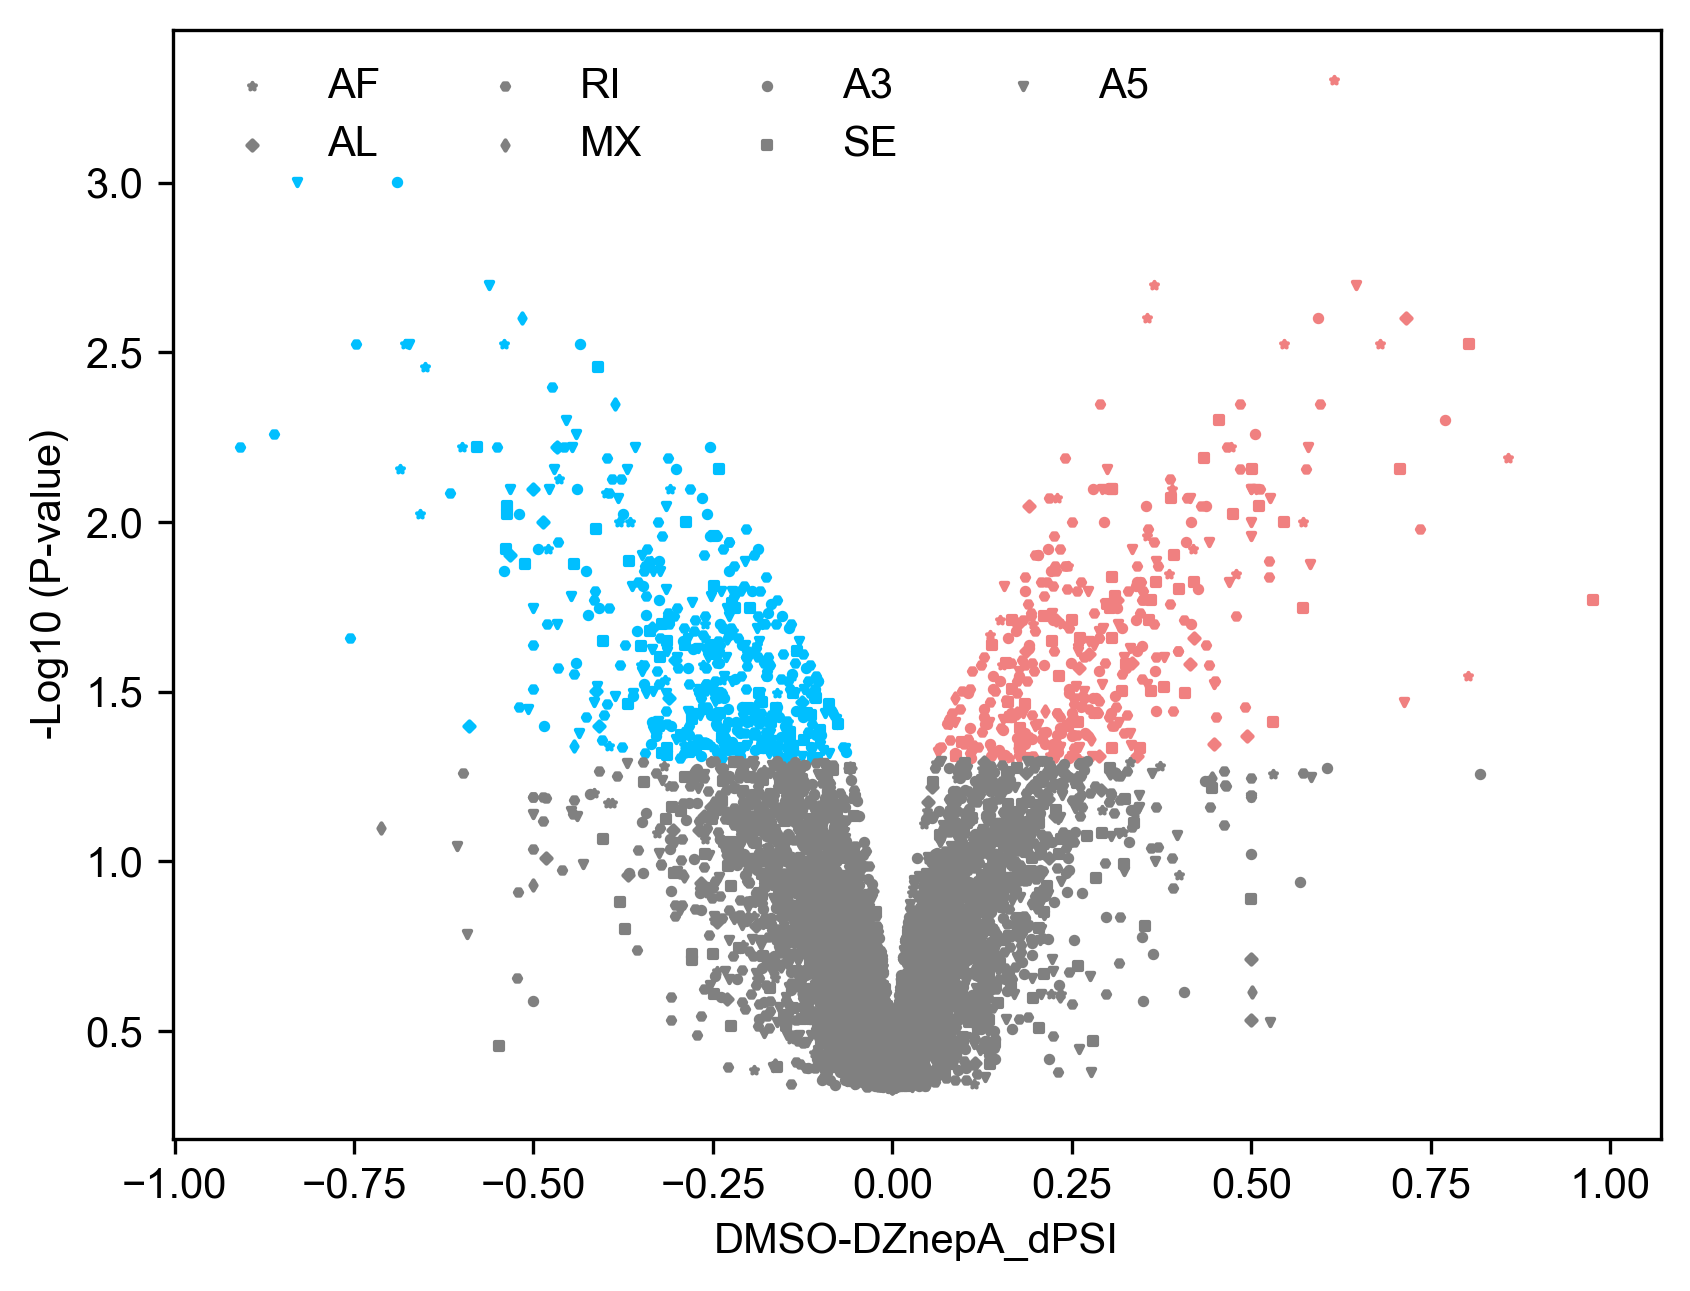

In [55]:
fig, ax = plt.subplots(1, dpi=300)
diff = diffas[diffas["DMSO-DZnepA_p-val"] < 0.05]
nodiff = diffas[diffas["DMSO-DZnepA_p-val"] > 0.05]

up = diff[diff["DMSO-DZnepA_dPSI"] > 0]
down = diff[diff["DMSO-DZnepA_dPSI"] < 0]

for mark, values in down.groupby("mark"):
    
    ax.scatter(values["DMSO-DZnepA_dPSI"], values["Y"], marker=mark, s=3, color="deepskyblue")
for mark, values in up.groupby("mark"):
    label = values["event"].drop_duplicates()[0]
    ax.scatter(values["DMSO-DZnepA_dPSI"], values["Y"], marker=mark, s=3, color="lightcoral")
for mark, values in nodiff.groupby("mark"):
    label = values["event"].drop_duplicates()[0]
    ax.scatter(values["DMSO-DZnepA_dPSI"], values["Y"], marker=mark, s=3, color="grey", label=label)
ax.legend(frameon=False, ncol=4)
ax.set_xlabel("DMSO-DZnepA_dPSI")
ax.set_ylabel("-Log10 (P-value)")
#plt.savefig("3.pdf", bbox_inches="tight")

In [56]:
diff

DMSO-DZnepA_dPSI  \
MPH.10055;A3:hic_scaffold_15:88921918-88922043:...          0.246210   
MPH.1005;RI:hic_scaffold_10:19341747:19342748-1...         -0.210562   
MPH.1007;AF:hic_scaffold_10:19463624:19464045-1...         -0.336573   
MPH.10084;A3:hic_scaffold_15:89938395-89941800:...         -0.408819   
MPH.10103;SE:hic_scaffold_15:90536261-90537968:...          0.232790   
...                                                              ...   
MPH.9680;RI:hic_scaffold_15:74824106:74824156-7...         -0.114474   
MPH.9735;RI:hic_scaffold_15:76567033:76567892-7...          0.194214   
MPH.9786;A3:hic_scaffold_15:79237322-79237418:7...          0.409161   
MPH.9935;SE:hic_scaffold_15:84813911-84814111:8...          0.088965   
MPH.9974;RI:hic_scaffold_15:86359227:86359275-8...         -0.212407   

                                                    DMSO-DZnepA_p-val event  \
MPH.10055;A3:hic_scaffold_15:88921918-88922043:...           0.031968    A3   
MPH.1005;RI:hic_scaffold_10:19341747:19342748-1...           0.028472    RI   
MPH.1007;AF:hic_scaffold_10:19463624:19464045-1...           0.012987    AF   
MPH.10084;A3:hic_scaffold_15:89938395-89941800:...           0.017982    A3   
MPH.10103;SE:hic_scaffold_15:90536261-90537968:...           0.028472    SE   
...                                                               ...   ...   
MPH.9680;RI:hic_scaffold_15:74824106:74824156-7...           0.031968    RI   
MPH.9735;RI:hic_scaffold_15:76567033:76567892-7...           0.036963    RI   
MPH.9786;A3:hic_scaffold_15:79237322-79237418:7...           0.011489    A3   
MPH.9935;SE:hic_scaffold_15:84813911-84814111:8...           0.048951    SE   
MPH.9974;RI:hic_scaffold_15:86359227:86359275-8...           0.015984    RI   

                                                           Y mark  
MPH.10055;A3:hic_scaffold_15:88921918-88922043:...  1.495284    o  
MPH.1005;RI:hic_scaffold_10:19341747:19342748-1...  1.545589    H  
MPH.1007;AF:hic_scaffold_10:19463624:19464045-1...  1.886491    *  
MPH.10084;A3:hic_scaffold_15:89938395-89941800:...  1.745162    o  
MPH.10103;SE:hic_scaffold_15:90536261-90537968:...  1.545589    s  
...                                                      ...  ...  
MPH.9680;RI:hic_scaffold_15:74824106:74824156-7...  1.495284    H  
MPH.9735;RI:hic_scaffold_15:76567033:76567892-7...  1.432232    H  
MPH.9786;A3:hic_scaffold_15:79237322-79237418:7...  1.939736    o  
MPH.9935;SE:hic_scaffold_15:84813911-84814111:8...  1.310238    s  
MPH.9974;RI:hic_scaffold_15:86359227:86359275-8...  1.796314    H  

[844 rows x 5 columns]

([], [])

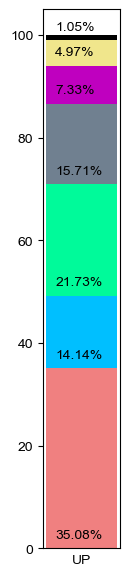

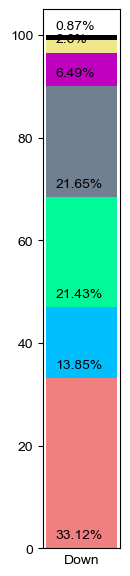

In [57]:
fig = plt.figure(figsize=(1,7))
y = 0
for e in colors:
    v = up[up["event"] == e]
    v = (len(v) / len(up)) * 100
    plt.bar(height=v, bottom=y, x=1, color=colors[e])
    plt.text(1-0.3, y+2, s=f"{round(v,2)}%")
    y += v
plt.xlabel("UP")
plt.xticks([])
#plt.savefig("3.up.pdf", bbox_inches="tight")


fig = plt.figure(figsize=(1,7))
y = 0
for e in colors:
    v = down[down["event"] == e]
    v = (len(v) / len(down)) * 100
    plt.bar(height=v, bottom=y, x=1, color=colors[e])
    plt.text(1-0.3, y+2, s=f"{round(v,2)}%")
    y += v
plt.xlabel("Down")
plt.xticks([])
#plt.savefig("3.down.pdf", bbox_inches="tight")

### Combine AS event with Nanopore

In [11]:
def read_bam(bam_p):
    reads = pysam.AlignmentFile(bam_p, "rb")
    data = defaultdict(dict)
    for read in reads:
        data[read.qname]["chrom"] = read.reference_name
    reads.close()
    return data


def get_gene_name():
    ####
    #### This is the transcript gff file
    ####
    gff_fp = "/media/Sorata/data3/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    gff_fp = "G:/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    transcript2gene = {}
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if ty == "transcript":
                gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[1].split(" ")[2][1:-1]
                transcript2gene[transcript] = gene
    return transcript2gene

transcript2gene = get_gene_name()

In [15]:
def get_gene_contains_gene2transcript():
    ####
    #### This is the transcript gff file
    ####
    gff_fp = "/media/Sorata/data3/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    gff_fp = "G:/bamboo/9_AS/SUPPA/02_ref/stringtie.merge.gtf"
    gene2transcript = {}
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if ty == "transcript":
                gene = des.split(";")[0].split(" ")[1][1:-1]
                transcript = des.split(";")[1].split(" ")[2][1:-1]
                gene2transcript.setdefault(gene, []).append(transcript) 
    return gene2transcript

gene_contain_transcript = get_gene_contains_gene2transcript()

#### Reads Assigned Command : minimap2 -ax map-ont transcript.fasta sample.fasta

In [6]:
df = pd.DataFrame()
for sample in ["DMSO", "DZnepA"]:
    fp = f"/media/Sorata/data3/bamboo/9_AS/transcript/{sample}.stringtie.sort.bam"
    bam = read_bam(fp)
    bam_turn = pd.DataFrame.from_dict(bam, orient='index')
    bam_turn["sample"] = sample
    df = pd.concat([df, bam_turn])
    print(sample, "Finish")
df["gene"] = df.apply(lambda x:transcript2gene[x.chrom], axis=1)

DMSO Finish
DZnepA Finish


#### Reads with poly(A) tail lentgth

In [7]:
p = pd.DataFrame()
for sample in ["DMSO", "DZnepA"]:
    for rep in ["rep1", "rep2", "rep3"]:
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/apa/{sample}_{rep}.apa"
        poly = pd.read_csv(fp, sep="\t", usecols=["readname", "polya_length", "qc_tag"], index_col=0)
        #poly.index = poly["readname"]
        p = pd.concat([p, poly])
    print(sample)
df = pd.concat([df, p], join="outer", axis=1)
df = df[df["chrom"].notna()]


DMSO
DZnepA


#### Reads with different AS event

In [12]:
#####
##### Count Reads with AS event
#####
as_path = "/media/Sorata/data3/bamboo/9_AS/SUPPA/03_AS-event/"
as_path = "G:/bamboo/9_AS/SUPPA/03_AS-event/"
as_event = defaultdict(dict)
for event in ["A3","A5", "AF", "AL", "MX", "RI", "SE"]:
    with open(as_path+f"/samples_{event}_strict.ioe") as f:
        n = 0
        next(f)
        for line in f:
            transcripts = line.split("\t")[3].split(",")
            for transcript in transcripts:
                as_event.setdefault(transcript, "|")
                as_event[transcript] += f"{event}|"

In [16]:
n = 0
for gene, transcripts in gene_contain_transcript.items():
    if len(transcripts) == 1:
        as_event[transcripts[0]] = "None"
        n += 1
        continue
    for t in transcripts:
        if t not in as_event:
            as_event[t] = "splice"

In [18]:
df["AS_event"] = df["chrom"].apply(lambda x:as_event[x] if x in as_event else "Full-splice")

#### Reads with m6A site

In [9]:
m6a = defaultdict(dict)
fp = "/media/Sorata/data3/bamboo/5_highQ/nanom6A/"
for sample in ["DMSO", "DZnepA"]:
    with open(f"{fp}/{sample}/sam_parse2.txt", 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            read_id = info[1].split(".")[0]
            m6a[read_id]["m6A_num"] = len(info[6:])
            site_txt, motif_txt = '', ''
            for sites in info[6:]:
                read_pos, site, motif = sites.split("|")
            #     site_txt += f"{info[0]}:{site}|"
            #     motif_txt += f"{motif}|"
            # m6a[read_id]["site"] = site_txt[:-1]
            # m6a[read_id]["motif"] = motif_txt[:-1]
# m6a = pd.DataFrame.from_dict(m6a, orient="index")
# m6a.rename(columns={0:"m6a"}, inplace=True)

In [10]:
df["m6a_num"] = df.apply(lambda x:m6a[x.name]["m6A_num"] if x.name in m6a else 0, axis=1)
# df["m6a_sites"] = df.apply(lambda x:m6a[x.name]["site"] if x.name in m6a else None, axis=1)
# df["m6a_motif"] = df.apply(lambda x:m6a[x.name]["motif"] if x.name in m6a else None, axis=1)

#### Load AS-read with m6A and poly(A)

In [20]:
#df.to_csv("AS-reads-with-m6A.csv")
df = pd.read_csv("AS-reads-with-m6A.csv", index_col=0)
df

chrom  sample       gene  \
00000cdf-09a7-44aa-be46-dc867c49132a       MPH.16784.1    DMSO  MPH.16784   
00000d24-2329-4197-8555-2175ab3810a6  PH02Gene36808.t1    DMSO   MPH.4841   
00000ef6-646d-40ab-b1e2-fb17c703d47d  PH02Gene00946.t1    DMSO  MPH.20512   
00001287-901a-4cf8-b339-9089e44f772b  PH02Gene11014.t1    DMSO  MPH.20354   
00001afc-3d53-41e0-a338-fb75c4ef60ee       MPH.27389.1    DMSO  MPH.27389   
...                                                ...     ...        ...   
fffff8ff-af76-4836-a261-a7672bee255f       MPH.17169.1  DZnepA  MPH.17169   
fffffc0f-4d9d-4a15-b588-e383e9029874       MPH.24018.1  DZnepA  MPH.24018   
fffffcab-0537-43ab-9e6b-40cfa98847a2  PH02Gene01331.t1  DZnepA  MPH.31793   
fffffdc2-1c54-4a34-a7e2-acae94506e31       MPH.32216.1  DZnepA  MPH.32216   
fffffeac-df6a-4af2-9158-85b36d2b8219  PH02Gene44636.t1  DZnepA   MPH.1193   

                                     AS_event  m6a_num  
00000cdf-09a7-44aa-be46-dc867c49132a   splice        0  
00000d24-2329-4197-8555-2175ab3810a6     None        3  
00000ef6-646d-40ab-b1e2-fb17c703d47d     None        0  
00001287-901a-4cf8-b339-9089e44f772b     None        4  
00001afc-3d53-41e0-a338-fb75c4ef60ee     |AF|        1  
...                                       ...      ...  
fffff8ff-af76-4836-a261-a7672bee255f   splice        0  
fffffc0f-4d9d-4a15-b588-e383e9029874     |RI|       13  
fffffcab-0537-43ab-9e6b-40cfa98847a2     None        2  
fffffdc2-1c54-4a34-a7e2-acae94506e31     None        0  
fffffeac-df6a-4af2-9158-85b36d2b8219     None        0  

[7840996 rows x 5 columns]

#### Poly(A) tail length in reads with different AS event

RI 196947
SE 32997
A3 85065
A5 53447
AF 21716
AL 15843
MX 7946


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb90fe8bd30>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb90fe7e2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb90fe8ba90>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb90fe7e7f0>,
 'fliers': [],
 'means': []}

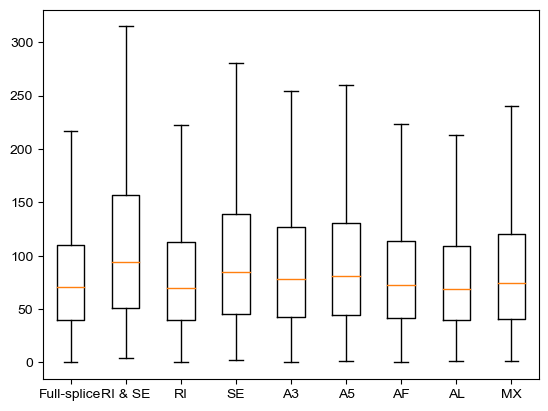

In [68]:
temp = df[df["qc_tag"] == "PASS"]

lt = []
labels = []

lt.append(temp[temp["chrom"].str.contains("PH02")]["polya_length"])
labels.append("Full-splice")

lt.append(temp[temp["AS_event"].str.contains("RI") & temp["AS_event"].str.contains("SE")]["polya_length"])
labels.append("RI & SE")

for event in events:
    poly = temp[temp["AS_event"] == f"|{event}|"]
    print(event, len(poly))
    lt.append(poly["polya_length"])
    labels.append(event)
plt.boxplot(lt, labels=labels, showfliers=False)

#### m6A enrich in reads with AS events

In [ ]:
m6a_num_cutoff = 1
fig, ax = plt.subplots(1, figsize=(8,4), dpi=200)
for sample, values in df.groupby("sample"):
    if sample != "DMSO":
        continue
    pos = 0

    ### All-read
    t1 = values[values["m6a_num"] >= m6a_num_cutoff]
    p = len(t1) / len(values) * 100
    labels = [f"All reads\n({len(values)})"]
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### No AS event
    t1 = values[values["AS_event"] == "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"No AS\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### AS event
    t1 = values[values["AS_event"] != "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"AS-reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### Full-splice
    t1 = values[values["chrom"].str.contains("PH02")]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2)/len(t1) * 100
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1
    labels.append(f"Full-splicing\n({len(t1)})")
    

    
    for event in events:
        t1 = values[values["AS_event"] == f"|{event}|"]
        t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
        p = len(t2)/len(t1) * 100
        labels.append(f"{event}\n({len(t1)})")
        ax.bar(x=pos, height=p, color="pink", width=0.6)
        ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
        pos += 1
    ax.set_ylabel(f"Percent of reads with >= {m6a_num_cutoff} m6A site ")
    ax.set_xticks(labels=labels, ticks=range(0, len(labels)), rotation=45)
    ax.set_ylim(0, 80)
####
# plt.xticks(labels=labels, ticks=range(0, len(labels)))
#plt.savefig("m6A-only-one-AS.pdf", bbox_inches="tight")

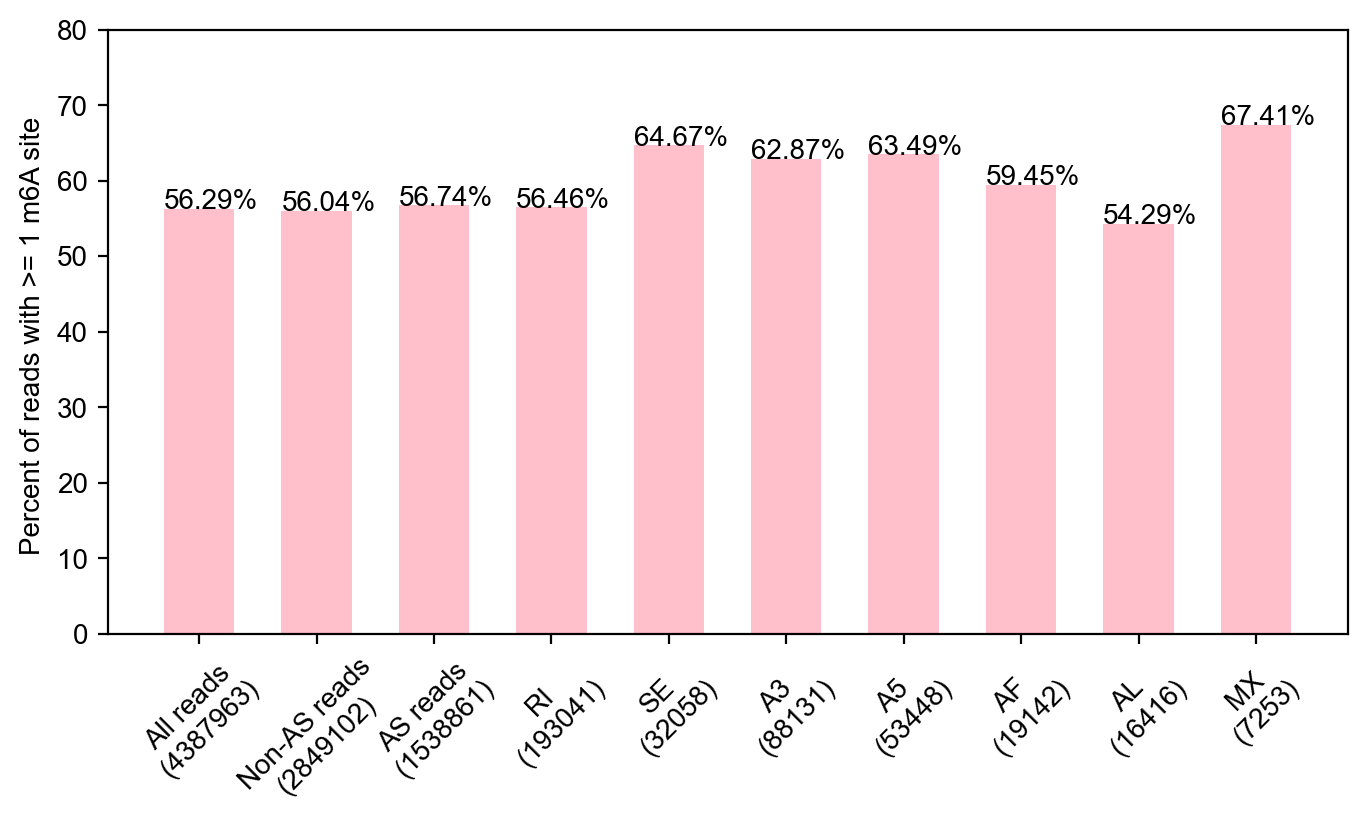

In [22]:
m6a_num_cutoff = 1
sample = "DZnepA"
fig, ax = plt.subplots(1, figsize=(8,4), dpi=200)
for sam, values in df.groupby("sample"):
    if sam != sample:
        continue
    pos = 0

    ### All-read
    t1 = values[values["m6a_num"] >= m6a_num_cutoff]
    p = len(t1) / len(values) * 100
    labels = [f"All reads\n({len(values)})"]
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### No AS event
    t1 = values[values["AS_event"] == "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"Non-AS reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### AS event
    t1 = values[values["AS_event"] != "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"AS reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1
    

    for event in events:
        t1 = values[values["AS_event"] == f"|{event}|"]
        t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
        p = len(t2)/len(t1) * 100
        labels.append(f"{event}\n({len(t1)})")
        ax.bar(x=pos, height=p, color="pink", width=0.6)
        ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
        pos += 1
    ax.set_ylabel(f"Percent of reads with >= {m6a_num_cutoff} m6A site ")
    ax.set_xticks(labels=labels, ticks=range(0, len(labels)), rotation=45)
    ax.set_ylim(0, 80)
####
# plt.xticks(labels=labels, ticks=range(0, len(labels)))
#plt.savefig(f"{sample}-only AS reads with m6A.pdf", bbox_inches="tight")

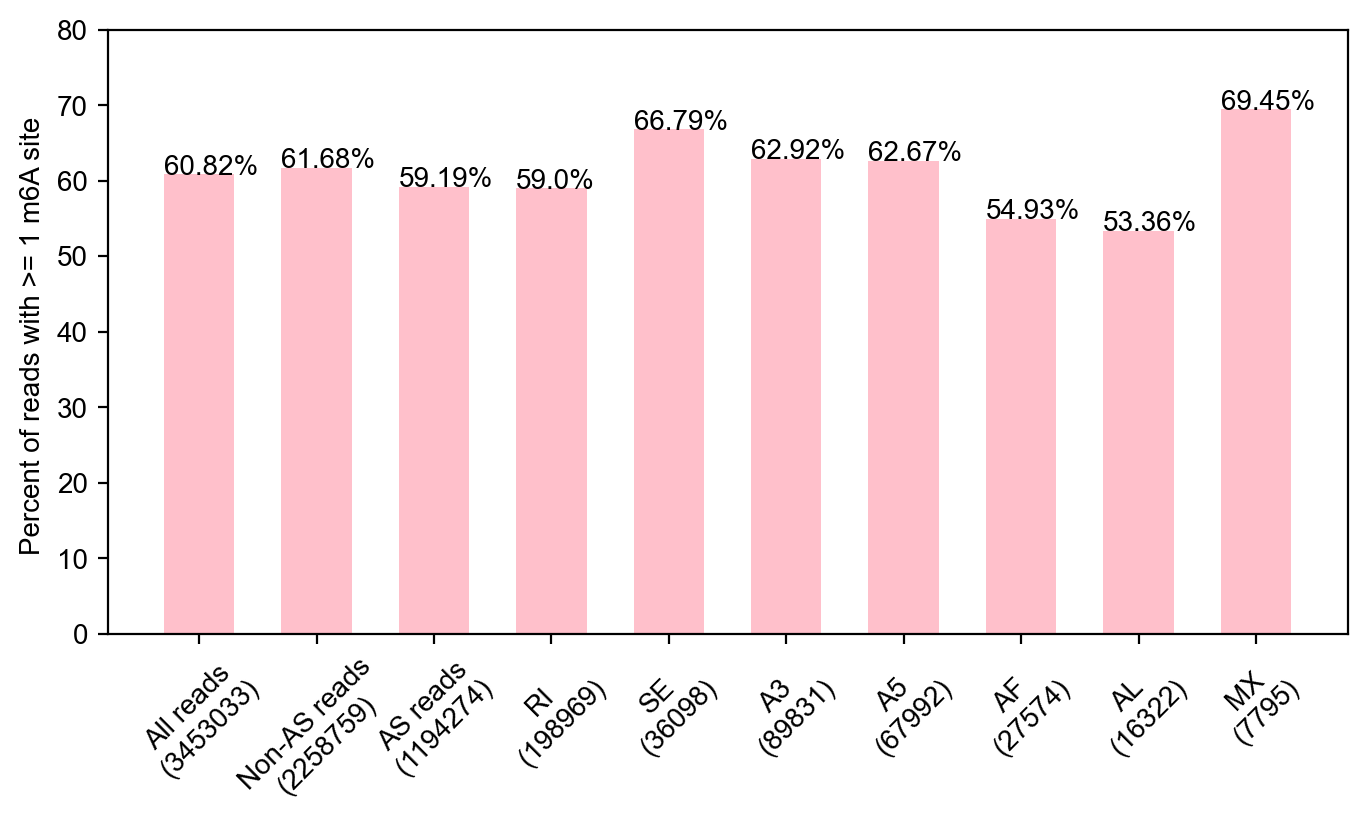

In [23]:
m6a_num_cutoff = 1
sample = "DMSO"
fig, ax = plt.subplots(1, figsize=(8,4), dpi=200)
for sam, values in df.groupby("sample"):
    if sam != sample:
        continue
    pos = 0

    ### All-read
    t1 = values[values["m6a_num"] >= m6a_num_cutoff]
    p = len(t1) / len(values) * 100
    labels = [f"All reads\n({len(values)})"]
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### No AS event
    t1 = values[values["AS_event"] == "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"Non-AS reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### AS event
    t1 = values[values["AS_event"] != "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"AS reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1
    

    for event in events:
        t1 = values[values["AS_event"].str.contains(event)]
        t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
        p = len(t2)/len(t1) * 100
        labels.append(f"{event}\n({len(t1)})")
        ax.bar(x=pos, height=p, color="pink", width=0.6)
        ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
        pos += 1
    ax.set_ylabel(f"Percent of reads with >= {m6a_num_cutoff} m6A site ")
    ax.set_xticks(labels=labels, ticks=range(0, len(labels)), rotation=45)
    ax.set_ylim(0, 80)
####
# plt.xticks(labels=labels, ticks=range(0, len(labels)))
#plt.savefig(f"{sample}-contains AS reads with m6A.pdf", bbox_inches="tight")

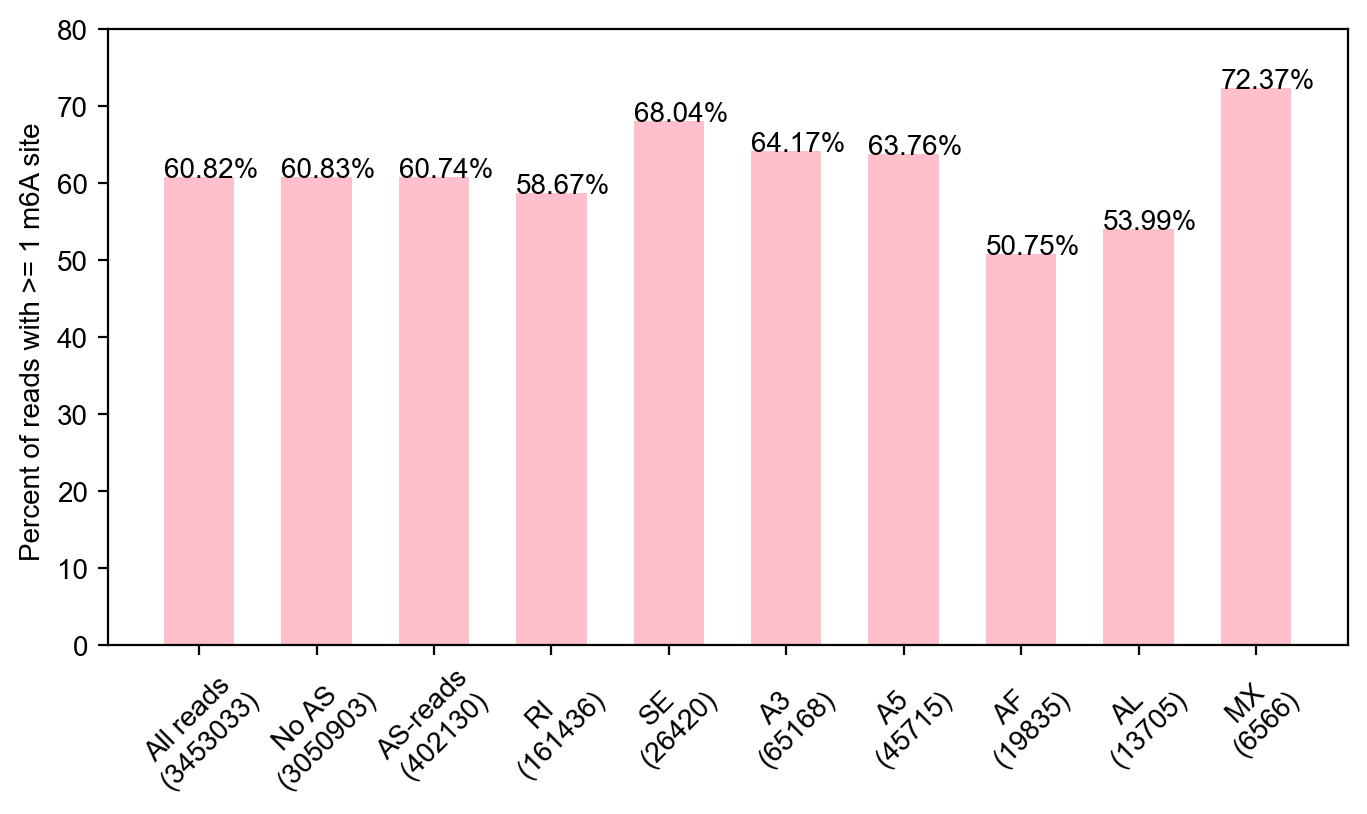

In [54]:
m6a_num_cutoff = 1
fig, ax = plt.subplots(1, figsize=(8,4), dpi=200)
for sample, values in df.groupby("sample"):
    if sample != "DMSO":
        continue
    pos = 0

    ### All-read
    t1 = values[values["m6a_num"] >= m6a_num_cutoff]
    p = len(t1) / len(values) * 100
    labels = [f"All reads\n({len(values)})"]
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### No AS event
    t1 = values[values["AS_event"] == "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"No AS\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1

    ### AS event
    t1 = values[values["AS_event"] != "None"]
    t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
    p = len(t2) / len(t1) * 100
    labels.append(f"AS-reads\n({len(t1)})")
    ax.bar(x=pos, height=p, color="pink", width=0.6)
    ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
    pos += 1
    

    for event in events:
        t1 = values[values["AS_event"] == f"|{event}|"]
        t2 = t1[t1["m6a_num"] >= m6a_num_cutoff]
        p = len(t2)/len(t1) * 100
        labels.append(f"{event}\n({len(t1)})")
        ax.bar(x=pos, height=p, color="pink", width=0.6)
        ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
        pos += 1
    ax.set_ylabel(f"Percent of reads with >= {m6a_num_cutoff} m6A site ")
    ax.set_xticks(labels=labels, ticks=range(0, len(labels)), rotation=45)
    ax.set_ylim(0, 80)
####
# plt.xticks(labels=labels, ticks=range(0, len(labels)))
#plt.savefig("m6A-only-one-AS.pdf", bbox_inches="tight")

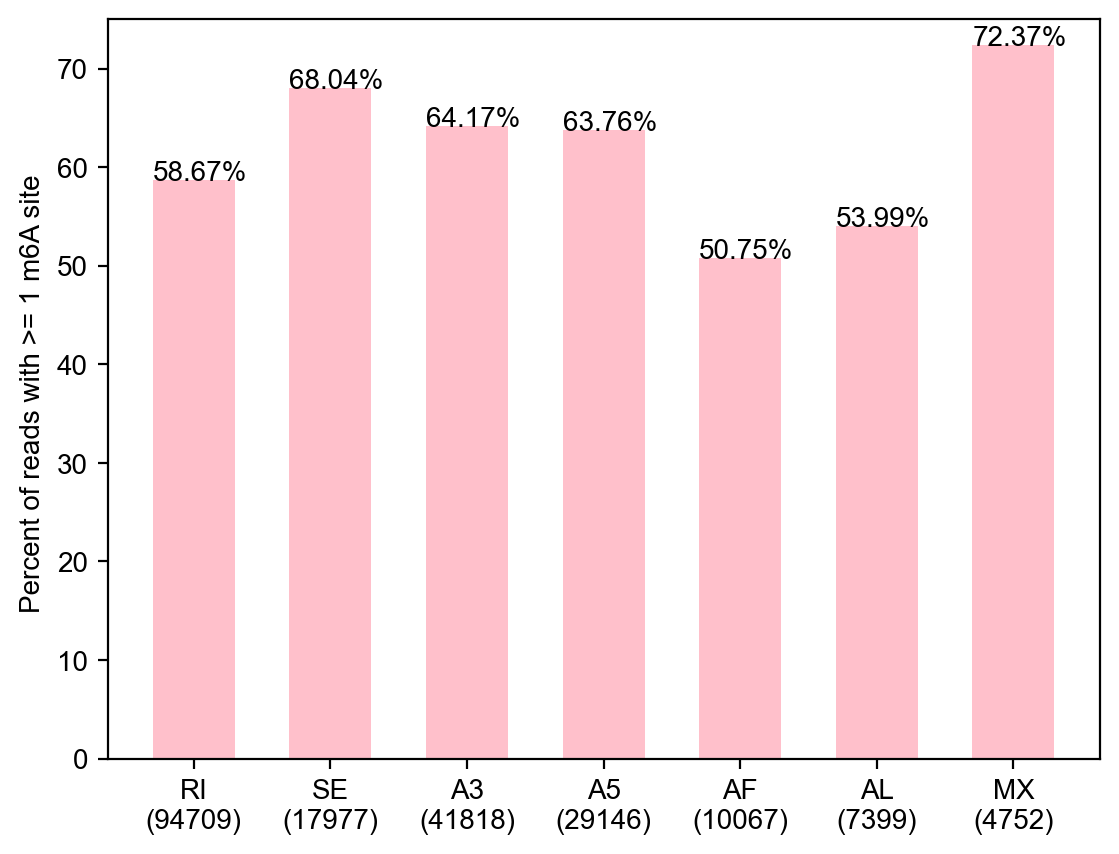

In [70]:
num = 1
fig, ax = plt.subplots(1, dpi=200)
for sample, values in df.groupby("sample"):
    if sample != "DMSO":
        continue
    pos = 0
    lt = []
    labels = []
    for event in events:
        t1 = values[values["AS_event"] == f"|{event}|"]
        t2 = t1[t1["m6a"] >= num]
        p = len(t2)/len(t1) * 100
        lt.append(t1["m6a"])
        labels.append(f"{event}\n({len(t2)})")
        ax.bar(x=pos, height=p, color="pink", width=0.6)
        ax.text(pos-0.3, p, s=f"{round(p, 2)}%")
        pos += 1
    ax.set_ylabel(f"Percent of reads with >= {num} m6A site ")
    ax.set_xticks(labels=labels, ticks=range(0, len(labels)))
    ax.set_ylim(0, 75)
####
# plt.xticks(labels=labels, ticks=range(0, len(labels)))
#plt.savefig("m6A-AS.pdf", bbox_inches="tight")

# 4.Alternative poly(A) site (PAS) Analysis

In [89]:
gff_fp = "/media/Sorata/win/genome/Bamboo.Hic.gff"
gff_len, exon_len = get_gene_len(gff_fp)
gff_strand, gff_chr = get_gene_strand(gff_fp)

### Genes with different number poly(A) site

In [71]:
max_num = 6
counts, merge_apa = {}, defaultdict(dict)
with open("All_sample.polyA-site", 'r') as f:
    next(f)
    for line in f:
        info = line.rstrip().split("\t")
        gene, num = info[0], len(info[1:])
        if num == 0:
            continue
        if num >= max_num:
            num = max_num
        counts.setdefault(num, []).append(info[0])
        for txt in info[1:]:
            site, num = txt.split(":")
            merge_apa[gene][int(site)] = int(num)

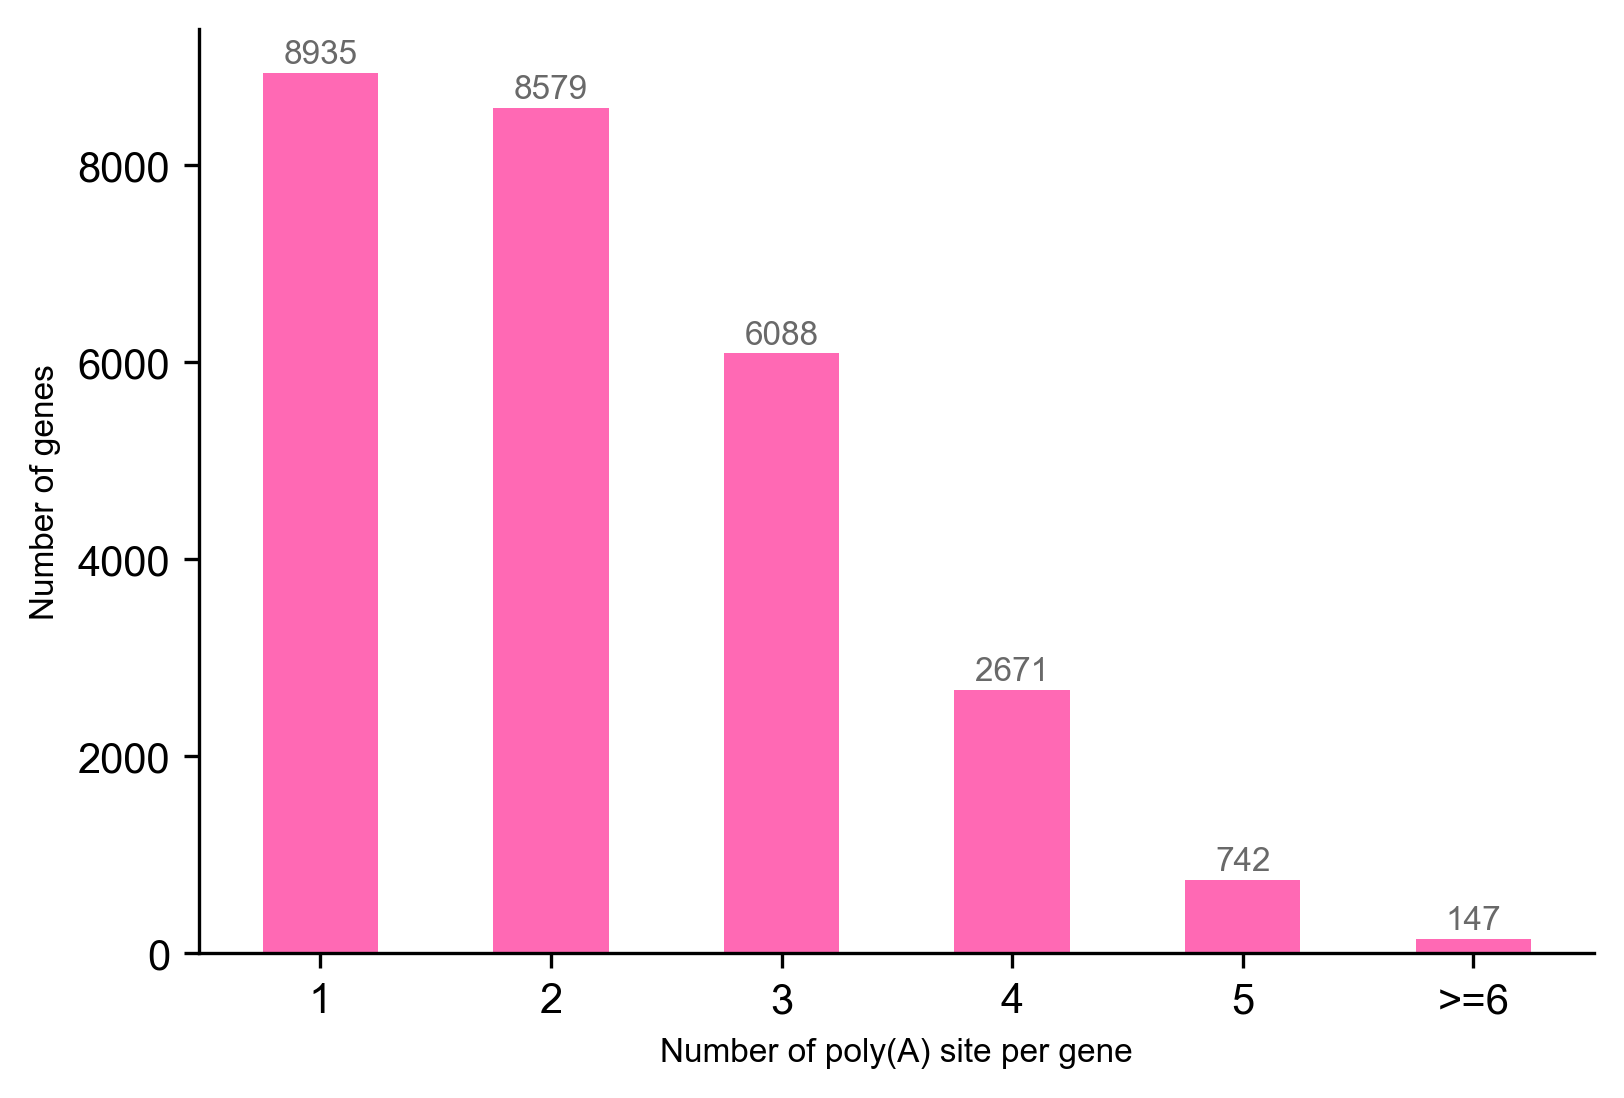

In [72]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
x = [str(k[0]) if k[0] < max_num else f">={max_num}" for k in sorted(counts.items())]
y = [len(k[1]) for k in sorted(counts.items())]

ax.bar(x=x, height=y, width=0.5, color="hotpink")
for p1,p2 in zip(x,y):
    ax.text(p1, p2+100, s=p2, fontsize=8, color="dimgrey", horizontalalignment="center")
ax.set_xticks(ticks=x, labels=x)
ax.set_xlabel("Number of poly(A) site per gene", fontsize=8)
ax.set_ylabel("Number of genes", fontsize=8)
ax.spines[["top", "right"]].set_visible(False)
#ax.set_xlim(0.5,6.5)
#plt.savefig(f"APA-number.pdf", bbox_inches="tight")

### Calculate poly(A) site usage per sample

In [73]:
raw_apa = {}
count = defaultdict(dict)
phar = tqdm(total=len(assign))
for sample, samples in assign.groupby("sample"):
    raw_apa[sample] = defaultdict(dict)
    for gene, genes in samples.groupby("Assigned_gene"):
        count[sample][gene] = len(genes)
        for site, sites in genes.groupby("APA"):
            if site == 0:
                continue
            raw_apa[sample][gene].setdefault(site, len(sites))
        phar.update(len(genes))
phar.close()

  0%|          | 0/8142865 [00:00<?, ?it/s]

In [77]:
# 如果在merged_apa_count设定覆盖度，为了保持研究位点的一致性，此处不需要设置
# mini_use = 0.1       ### for example, 10% usage for each APA site in genes 
# minread_cover = 3    ### for example, at least 3 reads for each APA site in genes 
mini_use, minread_cover = 0, 3
apas = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    apas[sample] = defaultdict(dict)
    for gene, sites in raw_apa[sample].copy().items():
        reads_num = count[sample][gene]
        for site, num in sites.items():
            if num / reads_num >= mini_use and num >= minread_cover:
                apas[sample][gene].setdefault(site, num)
for sample, genes in apas.items():
    with open(f"{sample}.apa-site", 'w') as f:
        f.write(f"### Merge ### mini_use:{mini_use}\tminread_cover:{minread_cover}\n")
        for gene, sites in genes.items():
            t = f"{gene}"
            for site, num in sites.items():
                t += f"\t{site}:{num}"
            t += "\n"
            f.write(t)

In [84]:
apa_data = defaultdict(dict)
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    with open(sample+".apa-site", 'r') as f:
        next(f)
        for line in f:
            info = line.rstrip().split("\t")
            gene = info[0]
            for txt in info[1:]:
                site, num = txt.split(":")
                site = gene + "_" + site
                apa_data[sample][site] = int(num)
n = pd.DataFrame.from_dict(apa_data).fillna(0)
data = {}
for sample in n:
    data[sample] = defaultdict(dict)
    for sites in n.index:
        gene, site = sites.split("_")
        data[sample][gene].setdefault(int(site), int(n.loc[sites, sample]))

In [85]:
fl_data = {}
for sample, values in data.items():
    fl_data[sample] = defaultdict(dict)
    for gene, sites in values.items():
        if len(sites) < 2:
            continue
        tot = sum(sites.values())
        if tot == 0:
            fl_data[sample][gene] = sites
            continue
        for site, num in sites.items():
            fl_data[sample][gene][site] = round((num/count[sample][gene]), 4)

### Compare different in major poly(A) site between DMSO and Sample

In [86]:
control_sample = "DMSO"    ### Control, Mock, CK, WT
sample = "DZnepA"   ### 

genes = list(set(fl_data[control_sample]) & set(fl_data[sample]))

majar, change = {}, {}

for gene in genes:
    sites = fl_data[control_sample][gene]
    s = sorted(sites.items(), key=lambda x:x[1], reverse=True)
    majar[gene] = s[0]
for gene in genes:
    sites = fl_data[sample][gene]
    s = sorted(sites.items(), key=lambda x:x[1], reverse=True)
    change[gene] = s

In [90]:
postodf, dis_dt = defaultdict(dict), defaultdict(dict)
###

for gene, sites in change.items():
    alter_site, orgin_site = int(sites[0][0]), int(majar[gene][0])

    strand = gff_strand[gene]
        
    if alter_site != orgin_site:
        pos = (alter_site) - orgin_site
        #postodf[gene] = (orgin_site, alter_site)
        if pos > 0:
            if strand == "+":
                #################
                ### To distal ###
                #################
                postodf[gene]["Proximal"] = orgin_site
                postodf[gene]["Distal"] = alter_site
                postodf[gene]["APA-Shift"] = "distal"
                postodf[gene]["rel-pos"] = pos
                dis_dt.setdefault(pos, 0)
                dis_dt[pos] += 1
            else:
                ###################
                ### To proximal ###
                ###################
                postodf[gene]["Proximal"] = alter_site
                postodf[gene]["Distal"] = orgin_site   
                postodf[gene]["APA-Shift"] = "proximal"
                postodf[gene]["rel-pos"] = -pos
                dis_dt.setdefault(-pos, 0)
                dis_dt[-pos] += 1
        
        else:
            if strand == "+":
                ###################
                ### To proximal ###
                ###################
                postodf[gene]["Proximal"] = alter_site
                postodf[gene]["Distal"] = orgin_site
                postodf[gene]["APA-Shift"] = "proximal"
                postodf[gene]["rel-pos"] = pos
                dis_dt.setdefault(-pos, 0)
                dis_dt[-pos] += 1
            else:
                #################
                ### To distal ###
                #################
                postodf[gene]["Proximal"] = orgin_site
                postodf[gene]["Distal"] = alter_site 
                postodf[gene]["APA-Shift"] = "distal"
                postodf[gene]["rel-pos"] = -pos
                dis_dt.setdefault(pos, 0)
                dis_dt[pos] += 1

In [91]:
pos_df = postodf.copy()
for gene, sites in postodf.items():
    proximal, distal = gene+"_"+str(sites["Proximal"]), gene+"_"+str(sites["Distal"])
    
    pos_df[gene][f"{control_sample}-proximal"] = apa_data[control_sample].get(proximal, 0)
    pos_df[gene][f"{control_sample}-distal"] = apa_data[control_sample].get(distal,0)
    pos_df[gene][f"{sample}-proximal"] = apa_data[sample].get(proximal, 0)
    pos_df[gene][f"{sample}-distal"] = apa_data[sample].get(distal,0)
pos_df = pd.DataFrame.from_dict(pos_df, orient="index")

In [92]:
############################
### Fisher extract test ###
##########################
def get_fisher_test(df, phar=False):
    tab1 = df[4:6]
    tab2 = df[6:8]
    stat, p = stats.fisher_exact([tab1, tab2])
    if phar:
        phar.update(1)
    return p

phar = tqdm(total=len(pos_df))
pos_df["pvalue"] = pos_df.apply(get_fisher_test, args=(phar,), axis=1)
pos_df.to_csv(f"{sample}vs{control_sample}-APA-changed.csv", sep=",")
result = pos_df[pos_df["pvalue"] < 0.05]
phar.close()

  0%|          | 0/4274 [00:00<?, ?it/s]

### Load data

In [3]:
control_sample = "DMSO"
compare_sample = "DZnepA"
result = pd.read_csv(f"{compare_sample}vs{control_sample}-APA-changed.csv", index_col=0)
result = result[result["pvalue"] < 0.05] 

### Major poly(A) site change

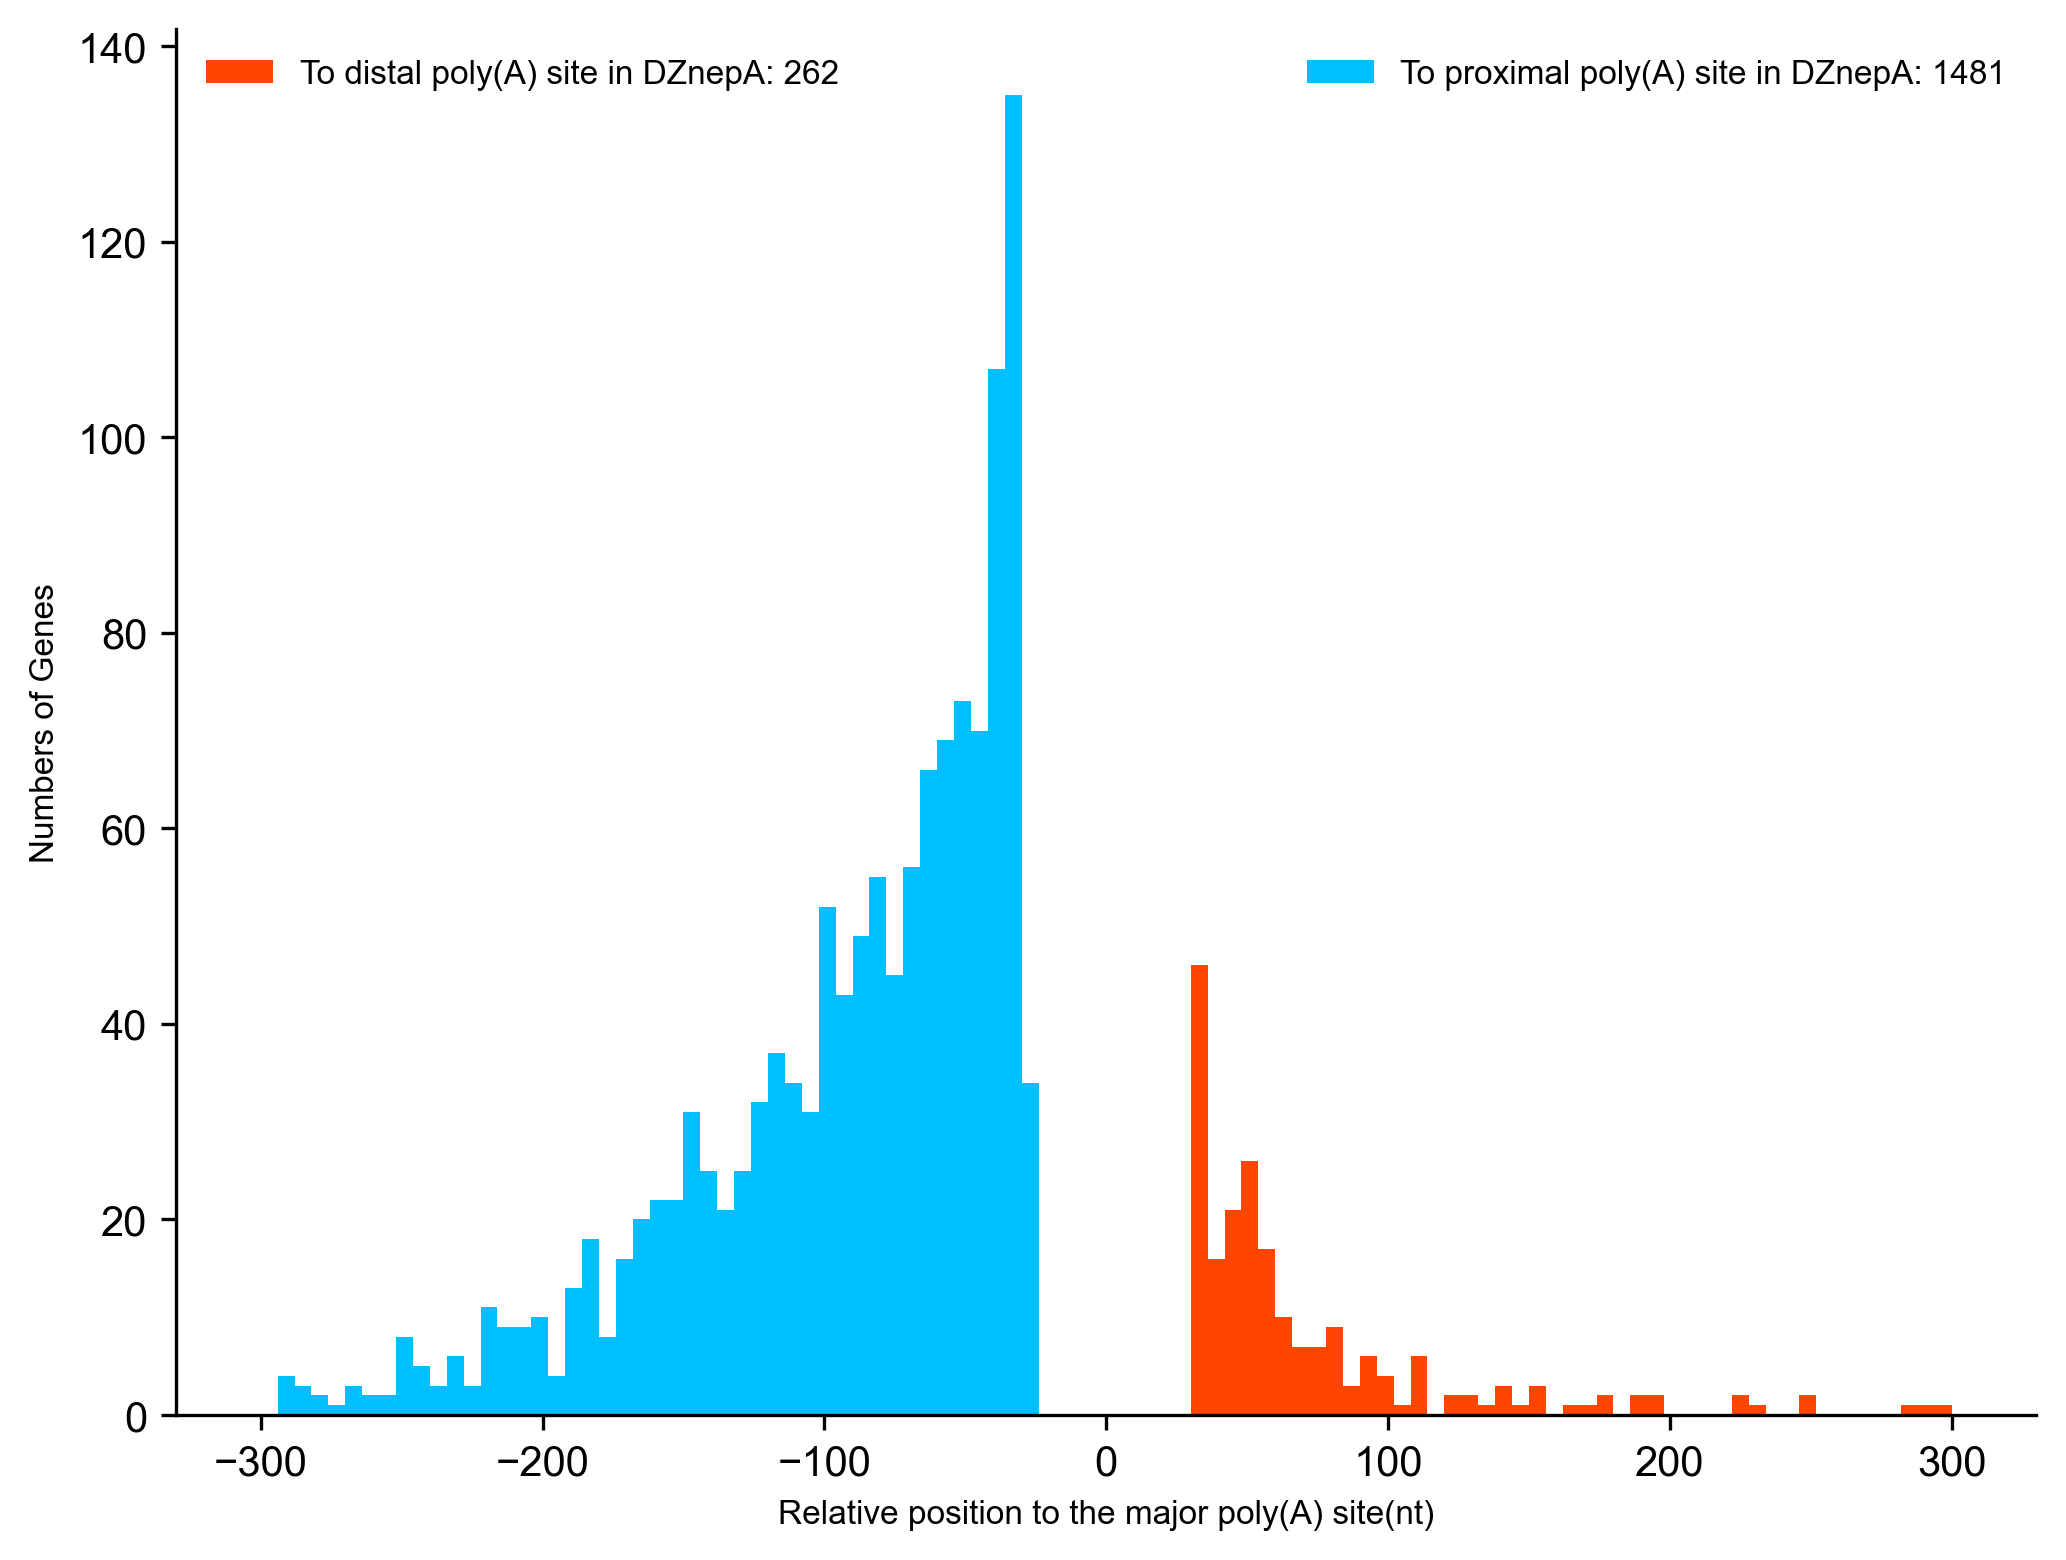

In [95]:
fig, ax = plt.subplots(1, figsize=(8,6), dpi=300)

###
n = 300   ###### X轴 limit
color_dict = {"proximal":"deepskyblue", "distal":"orangered"}

x = 0
for label, data in result.groupby("APA-Shift"):
    num = len(data)
    ax.hist(data["rel-pos"], bins=100, color=color_dict[label], range=(-n,n),
    label=f"To {label} poly(A) site in {compare_sample}: {num}", align="mid", histtype="barstacked")
        

#ax.set_xlim(-n,n)
ax.set_xlabel("Relative position to the major poly(A) site(nt)", fontsize=8)
ax.set_ylabel("Numbers of Genes", fontsize=8)
ax.spines[["top", "right"]].set_color(None)
ax.legend(frameon=False, fontsize=8, mode="expand", ncol=2)
#plt.savefig(f"Poly(A)-site-change-in-{compare_sample}.pdf", bbox_inches="tight")

### Gene with proximal poly(A) site shift process more m6A

In [111]:
def get_gene_m6aratio(sample):
    fp = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}"
    ###
    ###
    gene_ratio = defaultdict(dict)
    with open(fp + "/ratio.0.5.normalized.tsv") as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            gene_ratio[gene] = 1

    return gene_ratio


m6agene = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    m6agene[sample] = get_gene_m6aratio(sample)

In [155]:
values = defaultdict(dict)
for sample in ["DZnepA", "5-azaC"]:
    tmp = pd.read_csv(f"Date-Save/{sample}vsDMSO-APA-changed.csv", header=0, index_col=0)
    tmp = tmp[tmp["pvalue"] < 0.05]
    tmp["gene"] = tmp.index
    for label in ["proximal", "distal"]:
        pas_apa_gene = tmp[(tmp["APA-Shift"] == label)]
        pas_m6a_gene = pas_apa_gene[pas_apa_gene["gene"].isin(list(m6agene[sample].keys()))]
        values[sample][f"To {label} in {sample}"] = [len(pas_m6a_gene), len(pas_apa_gene)]

In [157]:
n = {}
for sample, samples in assign.groupby("sample"):
    total = len(samples)
    n[sample] = 0
    for gene, genes in samples.groupby("Assigned_gene"):
        if len(genes) >= 5:
            n[sample] += 1

In [158]:
labels = ["DMSO"]
h1 = [len(m6agene["DMSO"])/n["DMSO"]]

for sample, value in values.items():
    for label, tmp in value.items():
        labels.append(label)
        p = tmp[0] / tmp[1]
        h1.append(p)
h2 = [1-x for x in h1]
x = np.arange(0, len(h1))

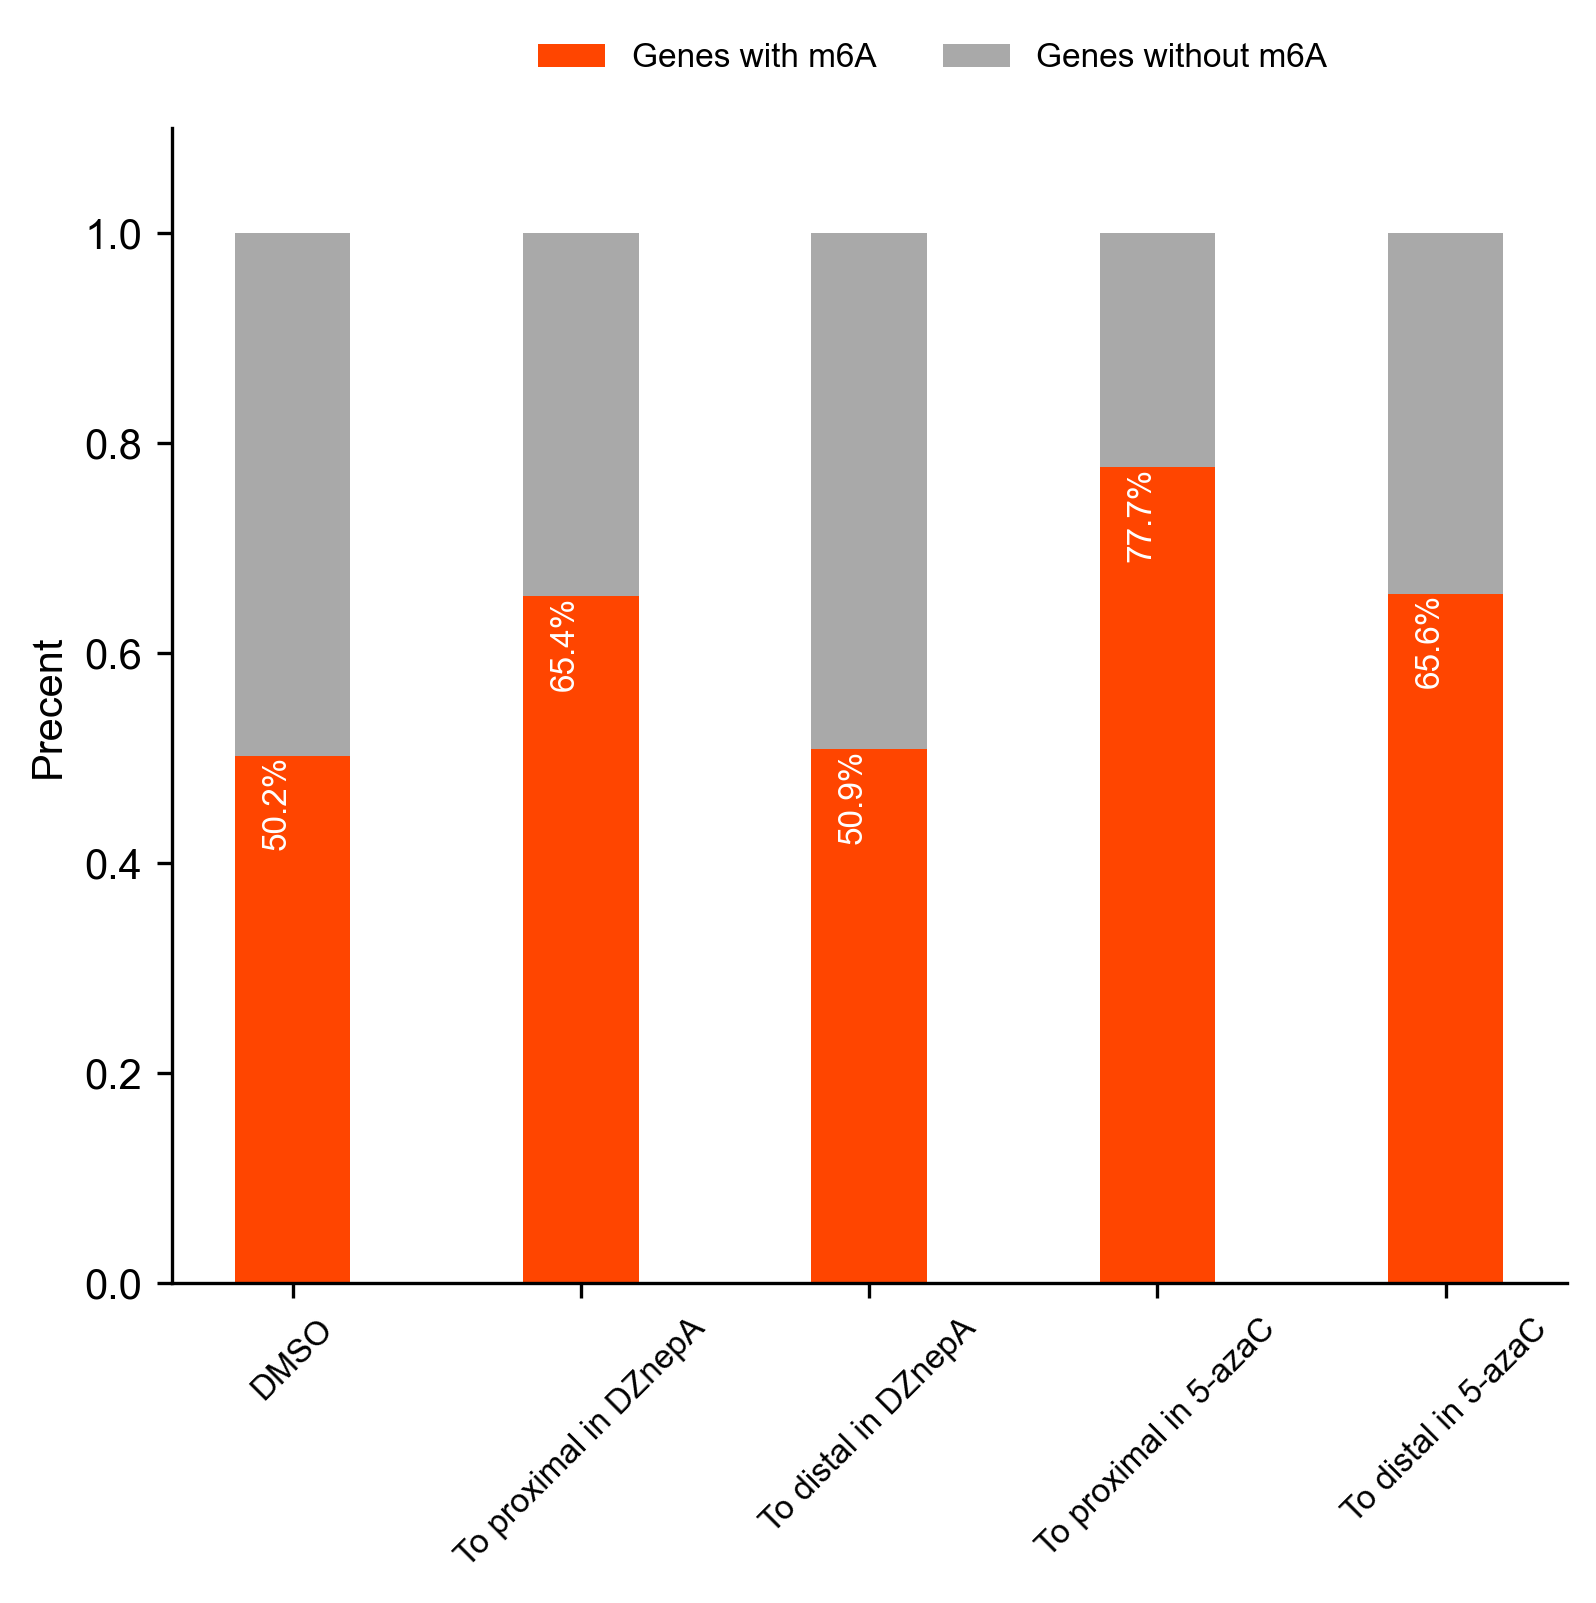

In [160]:
fig, ax = plt.subplots(1, figsize=(6,5), dpi=300)
ax.bar(x,h1, width=.4, color="orangered", label="Genes with m6A")
ax.bar(x,h2,bottom=h1, width=.4, color="darkgray", label="Genes without m6A")

ax.set_ylabel("Precent")
#####
ax.set_xticks(labels=labels, fontsize=8, ticks=x, rotation=45)

for pos, per in zip(x,h1):
    ax.text(pos, per, s=str(per*100)[:4]+"%", color="white", horizontalalignment="right", rotation=90,
           verticalalignment="top", fontsize=8)

ax.legend(ncol=2, bbox_to_anchor=(.85,1.1), frameon=False, fontsize=8)
ax.set_ylim(0,1.1)
ax.spines[["top", "right"]].set_visible(False)
#plt.savefig("m6a-and-apa.pdf", bbox_inches="tight")

### Combine PPR and m6A

In [4]:
ppr = pd.DataFrame()
ppr[f"{control_sample}-ppr"] = result[f"{control_sample}-proximal"] / (result[f"{control_sample}-proximal"] + result[f"{control_sample}-distal"])
ppr[f"{compare_sample}-ppr"] = result[f"{compare_sample}-proximal"] / (result[f"{compare_sample}-proximal"] + result[f"{compare_sample}-distal"])
ppr["ppr"] = np.log2(ppr[f"{compare_sample}-ppr"] / ppr[f"{control_sample}-ppr"])

/home/Sorata/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
def get_region_m6a(x, sample, region="utr3p"):
    ratios = totol_df[sample][totol_df[sample]["label"].str.contains(region)]
    return ratios[ratios["gene_name"] == x.name]["mod_ratio"].mean()

In [11]:
ppr[f"{control_sample}-m6A"] = ppr.apply(get_region_m6a, args= (control_sample,), axis=1)
ppr[f"{compare_sample}-m6A"] = ppr.apply(get_region_m6a, args= (compare_sample,), axis=1)
ppr.dropna(axis=0, inplace=True)
ppr["ratio-change"] = np.log2(ppr[f"{compare_sample}-m6A"] / ppr[f"{control_sample}-m6A"])

In [12]:
def divide_into(x, ratio_fc=0, express_fc=0):
    if x["ppr"] >= express_fc:
        if x["ratio-change"] > ratio_fc:
            return 1
        elif x["ratio-change"] < -ratio_fc:
            return 2
        else:
            return 0
    elif x["ppr"] <= -express_fc:
        if x["ratio-change"] > ratio_fc:
            return 4
        elif x["ratio-change"] < -ratio_fc:
            return 3
        else:
            return 0
    else:
        return 0

ratio_fc, express_fc = 0 ,0
ppr["label"] = ppr.apply(divide_into, args=(ratio_fc, express_fc,), axis=1)
ppr["shift_label"] = result.loc[ppr.index]["APA-Shift"]
ppr

DMSO-ppr  DZnepA-ppr       ppr  DMSO-m6A  DZnepA-m6A  \
PH02Gene45357  0.350763    0.521246  0.571471  0.313677    0.313246   
PH02Gene03564  0.350000    0.716216  1.033040  0.395062    0.294416   
PH02Gene36826  0.272727    0.549020  1.009399  0.195158    0.130146   
PH02Gene06878  0.333333    0.814815  1.289507  0.600000    0.409836   
PH02Gene08702  0.491525    0.636122  0.372038  0.369468    0.191098   
...                 ...         ...       ...       ...         ...   
PH02Gene19890  0.587302    0.360465 -0.704242  0.421712    0.488372   
PH02Gene06013  0.296703    0.533742  0.847122  0.467588    0.365839   
PH02Gene17789  0.387097    0.602941  0.639323  0.482434    0.331493   
PH02Gene13188  0.210526    0.671233  1.672813  0.656000    0.512077   
PH02Gene22820  0.401709    0.559184  0.477170  0.284344    0.250220   

               ratio-change  label shift_label  
PH02Gene45357     -0.001982      2    proximal  
PH02Gene03564     -0.424221      2    proximal  
PH02Gene36826     -0.584514      2    proximal  
PH02Gene06878     -0.549916      2    proximal  
PH02Gene08702     -0.951135      2    proximal  
...                     ...    ...         ...  
PH02Gene19890      0.211723      4      distal  
PH02Gene06013     -0.354030      2    proximal  
PH02Gene17789     -0.541355      2    proximal  
PH02Gene13188     -0.357334      2    proximal  
PH02Gene22820     -0.184440      2    proximal  

[530 rows x 8 columns]

In [14]:
ppr.to_csv("PPR-data.csv")
ppr = pd.read_csv("PPR-data.csv", index_col=0)
ppr

DMSO-ppr  DZnepA-ppr       ppr  DMSO-m6A  DZnepA-m6A  \
PH02Gene45357  0.350763    0.521246  0.571471  0.313677    0.313246   
PH02Gene03564  0.350000    0.716216  1.033040  0.395062    0.294416   
PH02Gene36826  0.272727    0.549020  1.009399  0.195158    0.130146   
PH02Gene06878  0.333333    0.814815  1.289507  0.600000    0.409836   
PH02Gene08702  0.491525    0.636122  0.372038  0.369468    0.191098   
...                 ...         ...       ...       ...         ...   
PH02Gene19890  0.587302    0.360465 -0.704242  0.421712    0.488372   
PH02Gene06013  0.296703    0.533742  0.847122  0.467588    0.365839   
PH02Gene17789  0.387097    0.602941  0.639323  0.482434    0.331493   
PH02Gene13188  0.210526    0.671233  1.672813  0.656000    0.512077   
PH02Gene22820  0.401709    0.559184  0.477170  0.284344    0.250220   

               ratio-change  label shift_label  
PH02Gene45357     -0.001982      2    proximal  
PH02Gene03564     -0.424221      2    proximal  
PH02Gene36826     -0.584514      2    proximal  
PH02Gene06878     -0.549916      2    proximal  
PH02Gene08702     -0.951135      2    proximal  
...                     ...    ...         ...  
PH02Gene19890      0.211723      4      distal  
PH02Gene06013     -0.354030      2    proximal  
PH02Gene17789     -0.541355      2    proximal  
PH02Gene13188     -0.357334      2    proximal  
PH02Gene22820     -0.184440      2    proximal  

[530 rows x 8 columns]

Text(0, 0, 'Log2 Foldchange(PPR)')

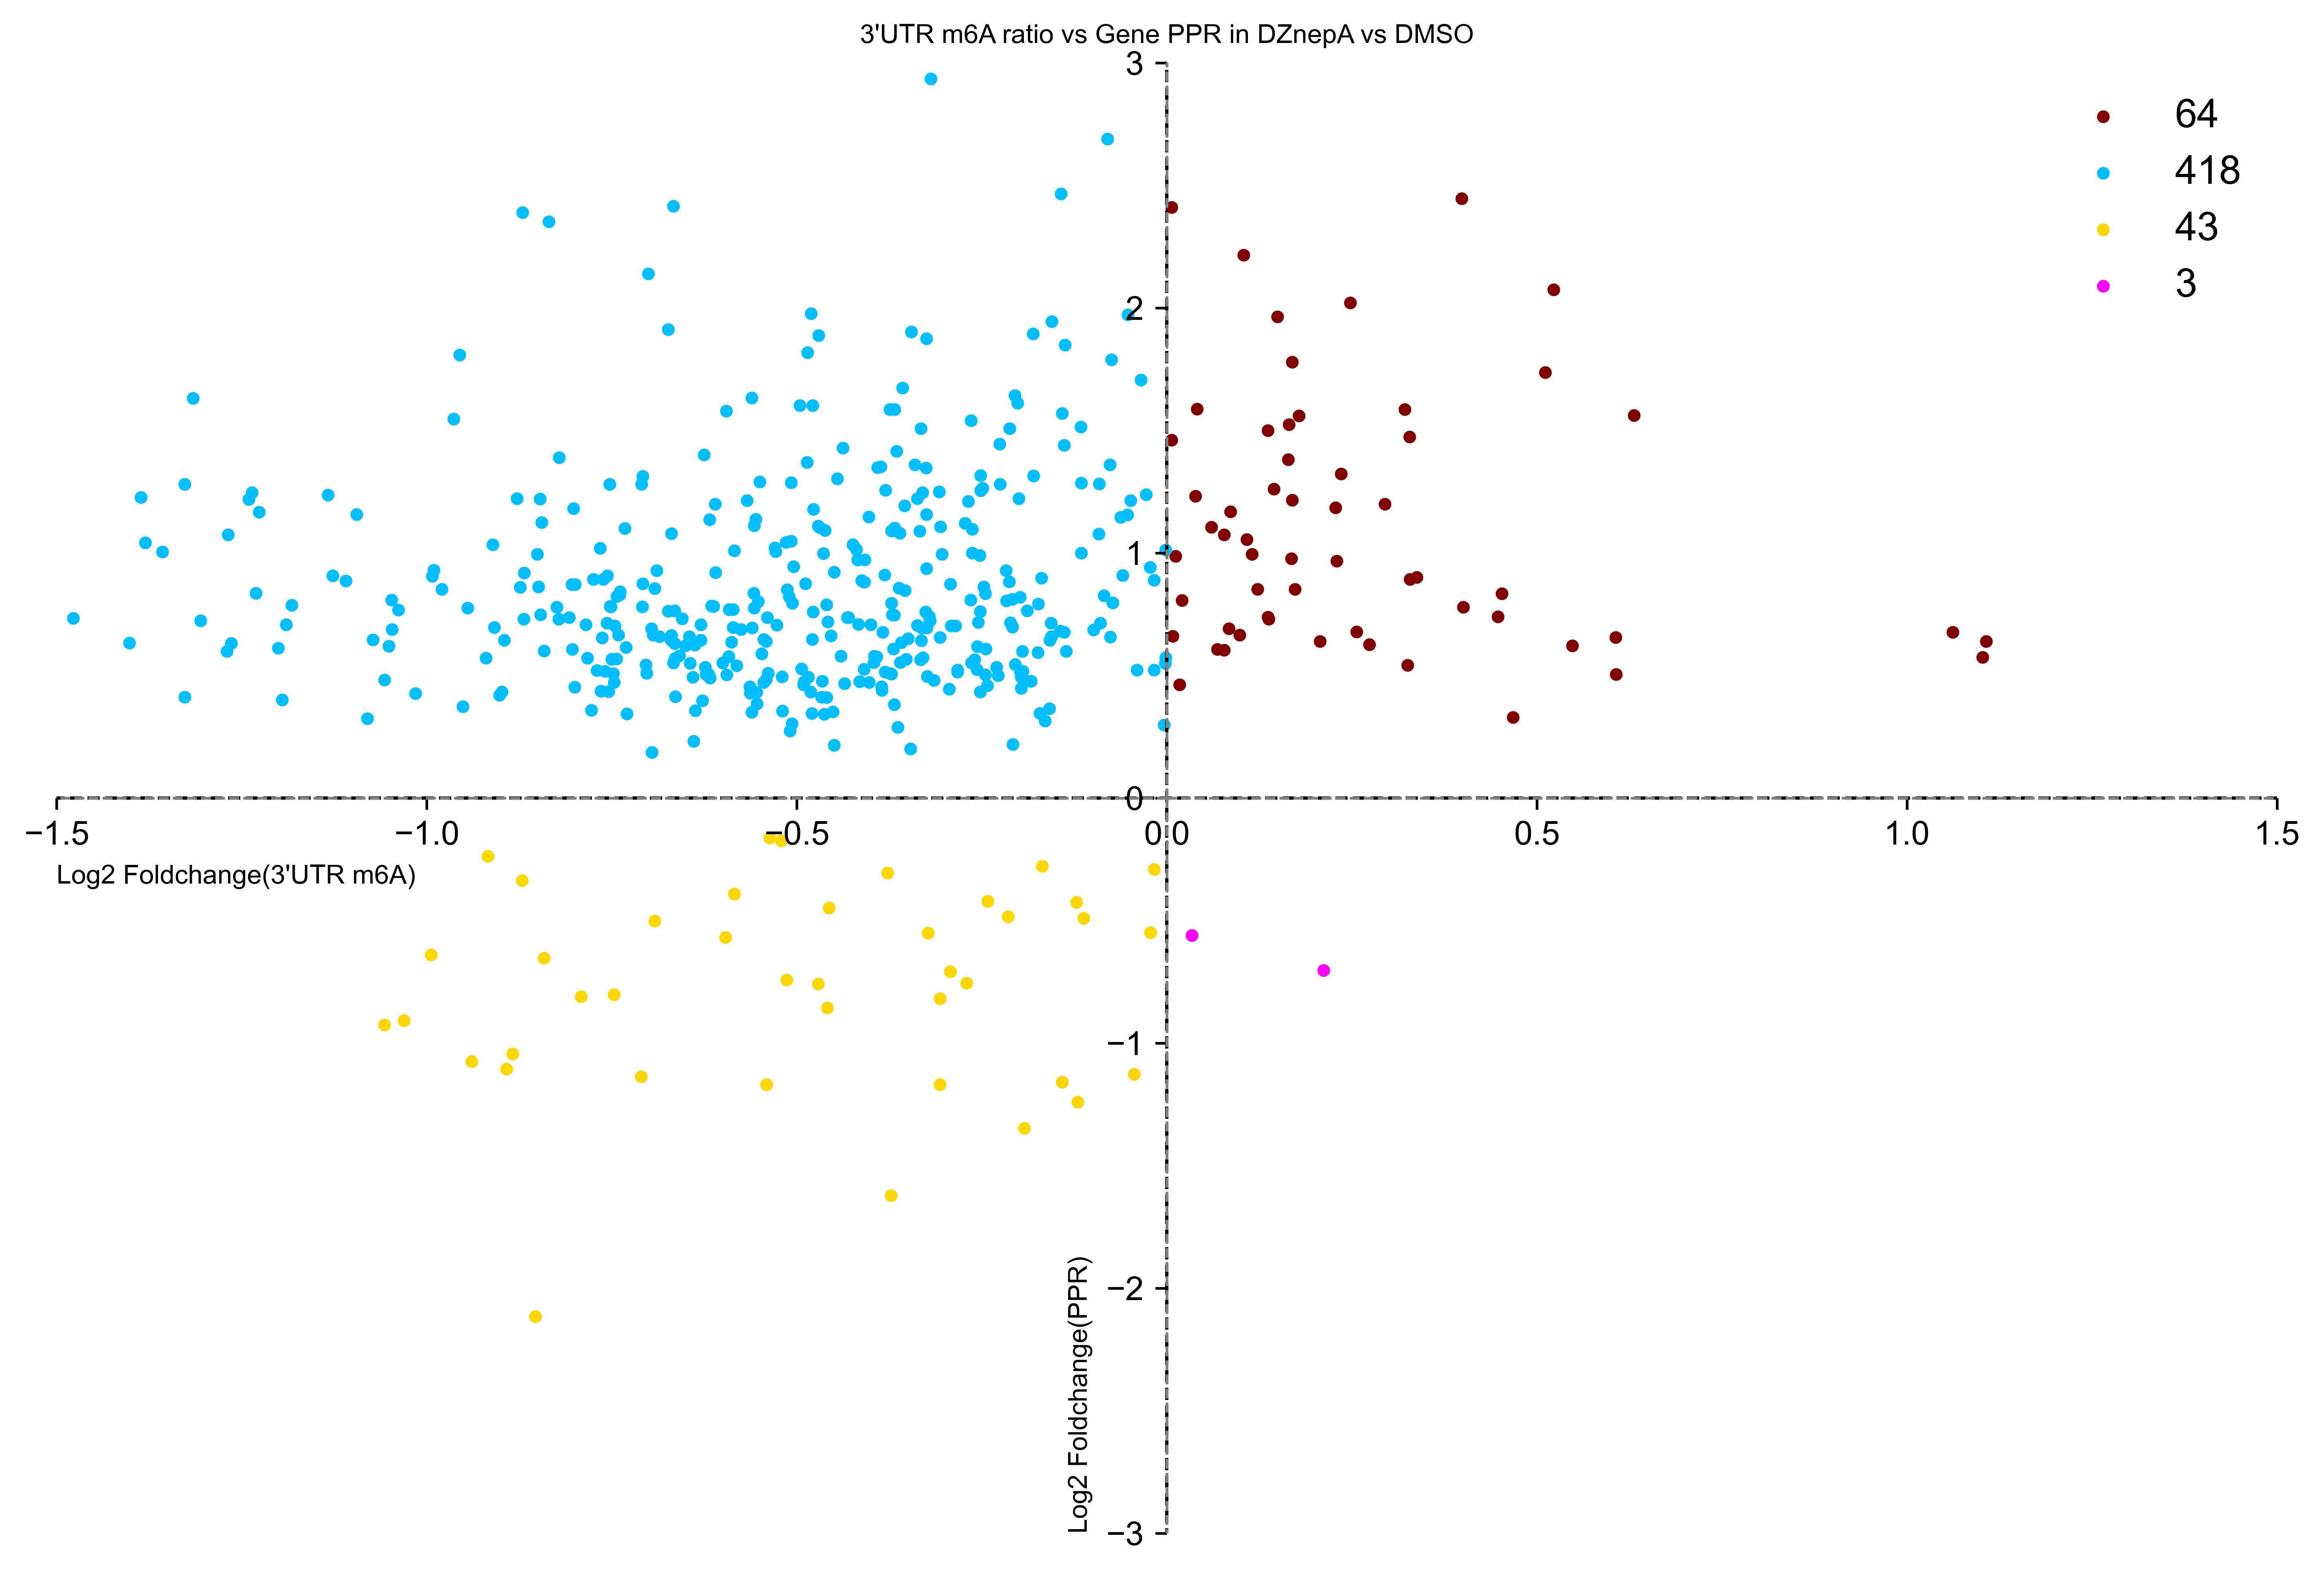

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 8), dpi=600)
#####
#####
x ,y = 2.5, 4
ax.plot([-x,x], [0,0], linestyle="--", color="black", linewidth=1)
ax.plot([0,0], [y,-y], linestyle="--", color="black", linewidth=1)
color_dict = {1:"maroon", 2:"deepskyblue", 3:"gold", 4:"magenta", 0:"grey"}

for label, values in ppr.groupby("label"):
    if label == 0:
        continue
    ax.scatter(values["ratio-change"], values["ppr"], label=f"{len(values)}", color=color_dict[label], s=8)
    #ax.scatter(values["ratio-change"], values["ppr"], label=f"{len(values)}", color=color_dict[0], s=8)
####
# for gene in genes:
#     ax.scatter(ppr.loc[gene, "ratio-change"], ppr.loc[gene, "ppr"], color="red", s=10)
#     ax.text(ppr.loc[gene, "ratio-change"], ppr.loc[gene, "ppr"], s=tot[gene])
# for gene in [ "PH02Gene24401", "PH02Gene00018", "PH02Gene28949", "PH02Gene31027", "PH02Gene04260"]:
#     ax.scatter(ppr.loc[gene, "ratio-change"], ppr.loc[gene, "ppr"], color="blue", s=10)
#     ax.text(ppr.loc[gene, "ratio-change"], ppr.loc[gene, "ppr"], s=gene)




ax.spines[:].set_visible(False)
ax.spines[["left", "bottom"]].set_position(('data', 0))
###
# ax.set_xlim(-x,x)
# ax.set_ylim(-y,y)
# x = x - 0.5
# y = y -0.5

ax.plot((-ratio_fc, -ratio_fc), (express_fc, y), lw=0.8,linestyle='--', c='grey')
ax.plot((-ratio_fc, -ratio_fc), (-express_fc, -y), lw=0.8,linestyle='--', c='grey')
ax.plot((ratio_fc, ratio_fc), (express_fc, y), lw=0.8,linestyle='--', c='grey')
ax.plot((ratio_fc, ratio_fc), (-express_fc, -y), lw=0.8,linestyle='--', c='grey')


ax.plot((ratio_fc, x), (express_fc,express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((-ratio_fc, -x), (express_fc,express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((ratio_fc, x), (-express_fc,-express_fc),lw=0.8, linestyle='--', c='grey')
ax.plot((-ratio_fc, -x), (-express_fc,-express_fc),lw=0.8, linestyle='--', c='grey')



###
ax.legend(frameon=False, fontsize=12)

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-3,3)
ax.set_title(f"3'UTR m6A ratio vs Gene PPR in {compare_sample} vs {control_sample}", fontsize=8)
ax.set_xlabel("Log2 Foldchange(3'UTR m6A)", loc="left", fontsize=8)
ax.set_ylabel("Log2 Foldchange(PPR)", loc="bottom", rotation=90, fontsize=8)
#plt.savefig(f"PPR-and-m6a-in-{compare_sample}.pdf", bbox_inches="tight")

# 5.Poly(A) tail Analysis

### Correlation analysis with Rpm, full-length ratio, and m6A

In [17]:
def get_ratio_data(fp):
    fp = fp + "/ratio.0.5.normalized.tsv"
    gene_ratio, site_ratio = {}, {} 
    with open(fp, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            m6a, total = 0, []
            for i in info[1:]:
                site, mod, read, ratio = i.split("|")
                site = int(site) 
                m6a += int(mod)
                total.append(float(ratio))
                site_ratio[f"{gene}_{site}"] = float(ratio)
            gene_ratio[gene] = np.mean(total)
    return site_ratio, gene_ratio


site_m6a, gene_m6a = {}, {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    fp = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}"
    site_m6a[sample], gene_m6a[sample] = get_ratio_data(fp)

In [ ]:
assign = pd.read_csv("Assigned-reads.csv", index_col=0)

#### choose sample

In [20]:
compare = defaultdict(dict)
for sam, samples in assign.groupby("sample"):
    if sam != "DMSO":
        continue
    total = len(samples)
    for gene, genes in samples.groupby("Assigned_gene"):
        gene_num = len(genes)
        if gene_num < 30:
            continue
        compare["polyA"][gene] = genes[genes["qc_tag"] == "PASS"]["polya_length"].median()
        compare["full-length"][gene] = len(genes[genes["Full_length"] == True]) / gene_num
        compare["rpm"][gene] = len(genes) * 1000000 / total
        compare["m6A"][gene] = gene_m6a[sample].get(gene)

In [21]:
# per = 0.1
# total = len(compare["polyA"])
# short = sorted(compare["polyA"].items(), key=lambda x:x[1])[:int(total*per)]
# nomral = sorted(compare["polyA"].items(), key=lambda x:x[1])[int(total*(0.5-per/2)):int(total*(0.5+per/2))]
# long = sorted(compare["polyA"].items(), key=lambda x:x[1], reverse=True)[:int(total*per)]

In [22]:
compare = pd.DataFrame.from_dict(compare)
compare

polyA  full-length         rpm       m6A
PH02Gene00006  104.760     0.548387   10.320993       NaN
PH02Gene00010   66.125     0.361702   46.943871       NaN
PH02Gene00015   83.000     0.561201  144.160965  0.083121
PH02Gene00016   99.980     0.290909   18.311439  0.666667
PH02Gene00017  141.390     0.250000   25.303079       NaN
...                ...          ...         ...       ...
PH02Gene51279   69.095     0.000000   15.315022       NaN
PH02Gene51340   62.920     0.000000   15.980892  0.439091
PH02Gene51351   55.690     0.312500   10.653928  0.489362
PH02Gene51425   59.110     0.306818   29.298302  0.099647
PH02Gene51450   80.655     0.825000   13.317410       NaN

[14765 rows x 4 columns]

#### mark "High", "median", and "low" 

In [24]:
def mark_pal_label(x):
    p25, p75, p3 = data_des["polyA"]
    if x < p25:
        return "Short tail"
    elif x >= p25 and x < p75:
        return "Median tail"
    else:
        return "Long tail"


def mark_rpm_label(x):
    p25, p50, p75 = data_des["rpm"]
    if x < p25:
        return "Low rpm"
    elif x >= p25 and x < p75:
        return "Median rpm"
    else:
        return "High rpm"   

def mark_m6a_label(x):
    p25, p50, p75 = data_des["m6A"]
    if x < p25:
        return "Low m6A"
    elif x >= p25 and x < p75:
        return "Median m6A"
    elif x >= p75:
        return "High m6A"   
    else:
        return "None"

def mark_full_label(x):
    p25, p50, p75 = data_des["full-length"]
    if x < p25:
        return "Low full"
    elif x >= p25 and x < p75:
        return "Median full"
    elif x >= p75:
        return "High full"   
    else:
        return "None"

In [25]:
data_des = defaultdict(dict)
for ty in compare:
    data_des[ty] = compare[ty].describe()[["25%", "50%", "75%"]]

compare["log10(rpm)"] = np.log10(compare["rpm"])
compare["pal_label"] = compare["polyA"].apply(mark_pal_label)
compare["full_label"] = compare["full-length"].apply(mark_full_label)
compare["m6a_label"] = compare["m6A"].apply(mark_m6a_label)
compare["rpm_label"] = compare["rpm"].apply(mark_rpm_label)

In [26]:
compare

polyA  full-length         rpm       m6A  log10(rpm)  \
PH02Gene00006  104.760     0.548387   10.320993       NaN    1.013721   
PH02Gene00010   66.125     0.361702   46.943871       NaN    1.671579   
PH02Gene00015   83.000     0.561201  144.160965  0.083121    2.158848   
PH02Gene00016   99.980     0.290909   18.311439  0.666667    1.262722   
PH02Gene00017  141.390     0.250000   25.303079       NaN    1.403173   
...                ...          ...         ...       ...         ...   
PH02Gene51279   69.095     0.000000   15.315022       NaN    1.185118   
PH02Gene51340   62.920     0.000000   15.980892  0.439091    1.203601   
PH02Gene51351   55.690     0.312500   10.653928  0.489362    1.027510   
PH02Gene51425   59.110     0.306818   29.298302  0.099647    1.466842   
PH02Gene51450   80.655     0.825000   13.317410       NaN    1.124420   

                 pal_label   full_label   m6a_label   rpm_label  
PH02Gene00006    Long tail    High full        None     Low rpm  
PH02Gene00010   Short tail  Median full        None  Median rpm  
PH02Gene00015    Long tail    High full     Low m6A    High rpm  
PH02Gene00016    Long tail  Median full    High m6A  Median rpm  
PH02Gene00017    Long tail  Median full        None  Median rpm  
...                    ...          ...         ...         ...  
PH02Gene51279  Median tail     Low full        None  Median rpm  
PH02Gene51340   Short tail     Low full  Median m6A  Median rpm  
PH02Gene51351   Short tail  Median full  Median m6A     Low rpm  
PH02Gene51425   Short tail  Median full     Low m6A  Median rpm  
PH02Gene51450    Long tail    High full        None     Low rpm  

[14765 rows x 9 columns]

#### full-length ratio and PAL

In [28]:
n = 600 ### the number of swarmplot
ty = "full-length"
med = int(len(compare[ty])/2)
###
t1 = compare.sort_values([ty]).head(n)
t2 = compare.sort_values([ty]).iloc[int(med-n/2):int(med+n/2)]
t3 = compare.sort_values([ty]).tail(n)
temp = pd.concat([t1, t2, t3])

(20.0, 200.0)

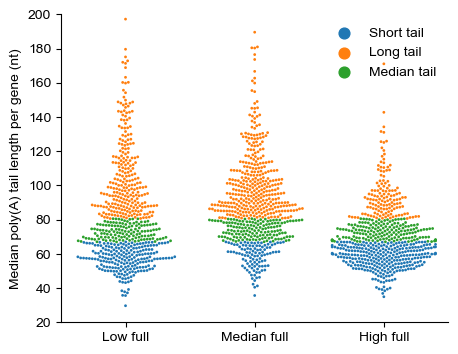

In [29]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.spines[["top", "right"]].set_visible(False)
sns.swarmplot(y="polyA", x="full_label", data=temp, size=2, hue="pal_label", order=[f"Low full", f"Median full", f"High full"])
ax.legend(frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Median poly(A) tail length per gene (nt)")
ax.set_ylim(20, 200)
#plt.savefig(f"PAL and {ty}.pdf", bbox_inches="tight")

Text(0.5, 0, 'Genes with different length poly(A) tail')

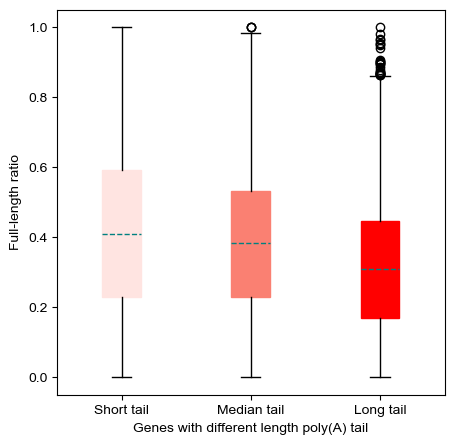

In [35]:
lt = []
labels = ["Short tail", "Median tail", "Long tail"]
for label in labels:
    lt.append(compare[compare["pal_label"] == label]["full-length"])

fig, ax = plt.subplots(1, figsize=(5,5))

box = ax.boxplot(lt, labels=labels, patch_artist=True, medianprops={"ls":"--"})
ax.set_ylabel("Full-length ratio")
box["boxes"][0].set_color("mistyrose")
box["boxes"][1].set_color("salmon")
box["boxes"][2].set_color("red")
[box["medians"][x].set_color("teal") for x in range(0,3)]
ax.set_xlabel("Genes with different length poly(A) tail")
#plt.savefig("PAl-full-length.pdf", bbox_inches='tight')

Text(0.5, 0, 'Genes with different full-length ratio')

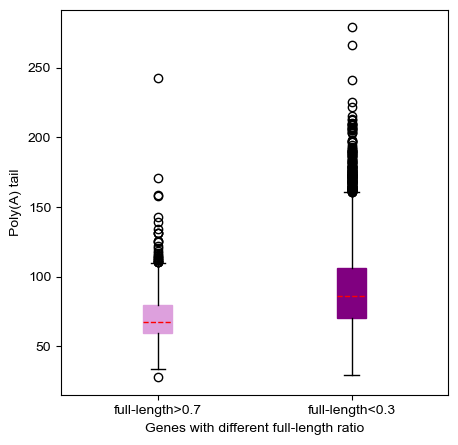

In [38]:
temp4 = compare[compare["full-length"] > 0.7]["polyA"].dropna()
temp5 = compare[compare["full-length"] < 0.3]["polyA"].dropna()

fig, ax = plt.subplots(1, figsize=(5,5))
box = ax.boxplot([temp4, temp5], labels=["full-length>0.7", "full-length<0.3"], patch_artist=True, medianprops={"ls":"--"})
ax.set_ylabel("Poly(A) tail")
box["boxes"][0].set_color("plum")
box["boxes"][1].set_color("purple")
[box["medians"][x].set_color("red") for x in range(0,2)]
ax.set_xlabel("Genes with different full-length ratio")
#plt.savefig("Full-length-PAL.pdf", bbox_inches='tight')

#### Rpm and PAL

/home/Sorata/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(20.0, 200.0)

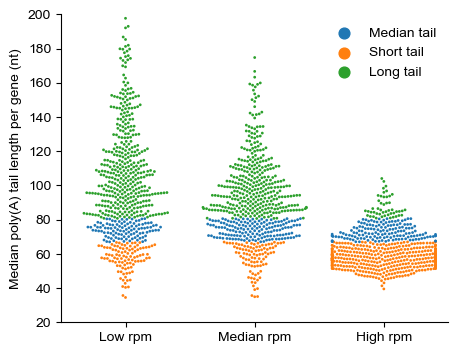

In [31]:
n = 600
ty = "rpm"
med = int(len(compare[ty])/2)

t1 = compare.sort_values([ty]).head(n)
t2 = compare.sort_values([ty]).iloc[int(med-n/2):int(med+n/2)]
t3 = compare.sort_values([ty]).tail(n)
temp = pd.concat([t1, t2, t3])

fig, ax = plt.subplots(1, figsize=(5,4))
ax.spines[["top", "right"]].set_visible(False)
sns.swarmplot(y="polyA", x="rpm_label", data=temp, size=2, hue="pal_label", order=[f"Low rpm", f"Median rpm", f"High rpm"])
ax.legend(frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Median poly(A) tail length per gene (nt)")
ax.set_ylim(20, 200)
#plt.savefig(f"PAL and {ty}.pdf", bbox_inches="tight")

Text(0.5, 0, 'Genes with different length poly(A) tail')

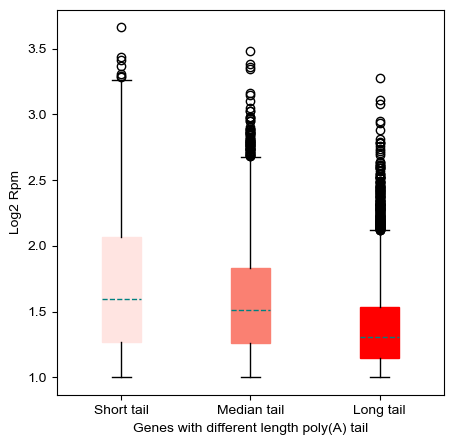

In [37]:
lt = []
labels = ["Short tail", "Median tail", "Long tail"]
for label in labels:
    lt.append(compare[compare["pal_label"] == label]["log10(rpm)"])

fig, ax = plt.subplots(1, figsize=(5,5),)
box = ax.boxplot(lt, labels=labels, patch_artist=True, medianprops={"ls":"--"})
ax.set_ylabel("Log2 Rpm")
box["boxes"][0].set_color("mistyrose")
box["boxes"][1].set_color("salmon")
box["boxes"][2].set_color("red")
[box["medians"][x].set_color("teal") for x in range(0,3)]
ax.set_xlabel("Genes with different length poly(A) tail")
#plt.savefig("PAl-RPM.pdf", bbox_inches='tight')

#### m6A and PAL

In [32]:
n = 600
ty = "m6A"

temp = compare[compare[ty].notna()]

med = int(len(compare[ty])/2)

t1 = temp.sort_values([ty]).head(n)
t2 = temp.sort_values([ty]).iloc[int(med-n/2):int(med+n/2)]
t3 = temp.sort_values([ty]).tail(n)
temp = pd.concat([t1, t2, t3])

(20.0, 200.0)

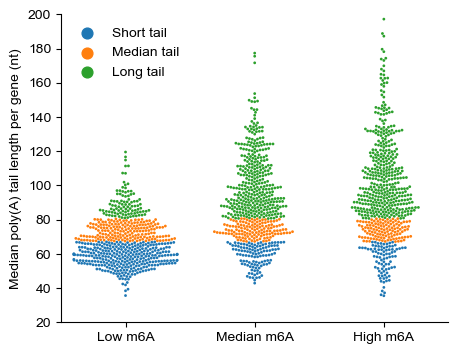

In [33]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.spines[["top", "right"]].set_visible(False)
sns.swarmplot(y="polyA", x="m6a_label", data=temp, size=2, hue="pal_label", order=["Low m6A", "Median m6A", "High m6A"])
ax.legend(frameon=False)
ax.set_xlabel("")
ax.set_ylabel("Median poly(A) tail length per gene (nt)")
ax.set_ylim(20, 200)
# plt.savefig(f"PAL and {ty}.pdf", bbox_inches="tight")

### Correlation analysis in 3D scatter plot

In [39]:
from mpl_toolkits.mplot3d import Axes3D

In [40]:
cor = {}
phar = tqdm(total=len(assign))
for sam, samples in assign.groupby("sample"):
    cor[sam] = defaultdict(dict)
    tot = len(samples)
    for gene, genes in samples.groupby("Assigned_gene"):
        cor[sam]["read-num"][gene] = len(genes)
        cor[sam]["Rpm"][gene] = len(genes) * 1000000 / tot
        for tag, reads in genes.groupby("Full_length"):
            if tag:
                cor[sam]["full-length-ratio"][gene] = len(reads) / len(genes)
        phar.update(len(genes))
        genes = genes[genes["qc_tag"] == "PASS"]
        cor[sam]["polya"][gene] = genes["polya_length"].median()
phar.close()

  0%|          | 0/8142865 [00:00<?, ?it/s]

In [ ]:
cl = {"DMSO":"royalblue", 
      "DZnepA":"salmon", 
      "5-azaC":"gold"}

Text(0.5, 0.92, 'Only show genes with mapped reads >= 20')

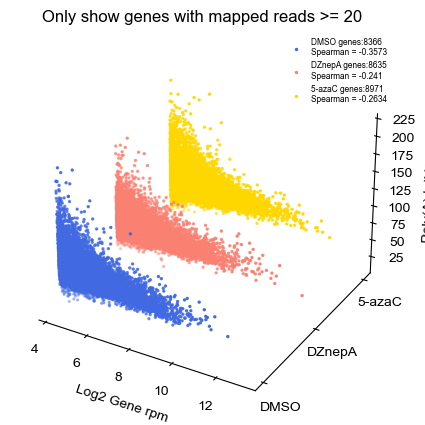

In [45]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")
ax.grid(False)

num = 20
flag = 0
yaxis = []
for sam in ["DMSO", "DZnepA", "5-azaC"]:
    temp = pd.DataFrame.from_dict(cor[sam]).dropna(axis=0)
    temp = temp[temp["Rpm"] > num]
    log2_rpm = np.log2(temp["Rpm"])
    n, p = stats.pearsonr(log2_rpm, temp["polya"])
    ax.scatter(log2_rpm, flag, temp["polya"], color=cl[sam], s=2, label=f"{sam} genes:{len(temp)}\nSpearman = {round(n, 4)}")
    yaxis.append(flag)
    flag += 1

    
ax.set_yticks(yaxis, labels=["DMSO", "DZnepA", "5-azaC"])


ax.set_xlabel("Log2 Gene rpm")
ax.set_ylabel("")
ax.set_zlabel("Poly(A) tail length")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.legend(frameon=False, fontsize=6)
ax.set_title(f"Only show genes with mapped reads >= {num}")
# ax.set_xticks([1,2,3],[1,2,3])
# ax.set_yticks([1,2,3],[1,2,3])
# ax.set_zticks([1,2,3],[1,2,3])
#plt.axis("off")
# plt.savefig(f"Correlationship with log2(Rpm {num}-) and PAL).pdf", bbox_inches="tight")
# plt.savefig(f"Correlationship with log2(Rpm {num}-) and PAL).jpeg", bbox_inches="tight", dpi=300)

Text(0.5, 0.92, 'Only show genes with mapped reads >= 20')

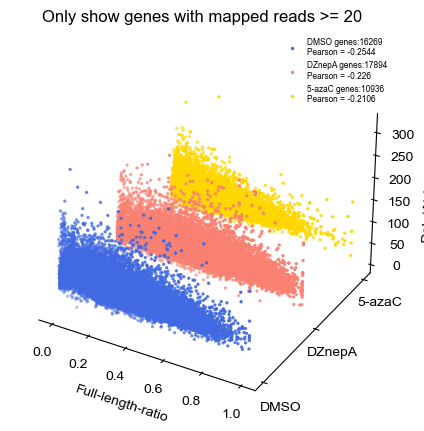

In [46]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")
ax.grid(False)

num = 20
flag = 0
yaxis = []
for sam in ["DMSO", "DZnepA", "5-azaC"]:
    temp = pd.DataFrame.from_dict(cor[sam]).dropna(axis=0)
    temp = temp[temp["read-num"] > num]
    n, p = stats.pearsonr((temp["full-length-ratio"]), temp["polya"])
    ax.scatter(temp["full-length-ratio"], flag, temp["polya"], color=cl[sam], s=2, label=f"{sam} genes:{len(temp)}\nPearson = {round(n, 4)}")
    yaxis.append(flag)
    flag += 1

ax.set_yticks(yaxis, labels=["DMSO", "DZnepA", "5-azaC"])


ax.set_xlabel("Full-length-ratio")
ax.set_ylabel("")
ax.set_zlabel("Poly(A) tail length")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.legend(frameon=False, fontsize=6)
ax.set_title(f"Only show genes with mapped reads >= {num}")
# ax.set_xticks([1,2,3],[1,2,3])
# ax.set_yticks([1,2,3],[1,2,3])
# ax.set_zticks([1,2,3],[1,2,3])
# plt.axis("off")
# plt.savefig(f"Correlationship with full-length-ratio (reads {num}) and PAL).pdf", bbox_inches="tight")
# plt.savefig(f"Correlationship with full-length-ratio (reads {num}) and PAL).jpeg", bbox_inches="tight", dpi=300)

Text(0.5, 0.92, 'Only show genes with mapped reads >= 20')

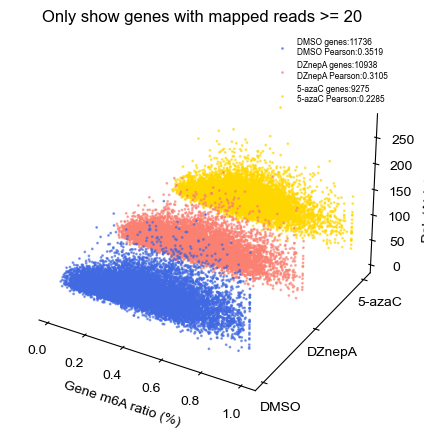

In [48]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")
ax.grid(False)

num = 20
yaxis = []
for sam in ["DMSO", "DZnepA", "5-azaC"]:
    temp = pd.DataFrame.from_dict(cor[sam]).dropna(axis=0)
    ratio = pd.DataFrame.from_dict(gene_m6a[sam], orient="index")
    ratio.columns = ["m6A-ratio"]
    temp = pd.concat([temp, ratio], join="inner", axis=1)
    temp = temp[temp["read-num"] > num]
    n, p = stats.pearsonr(temp["m6A-ratio"], temp["polya"])
    ax.scatter(temp["m6A-ratio"], flag, temp["polya"], s=1, color=cl[sam], alpha=0.6, label=f"{sam} genes:{len(temp)}\n{sam} Pearson:{round(n, 4)}")
    yaxis.append(flag)
    flag += 1

ax.set_yticks(yaxis, labels=["DMSO", "DZnepA", "5-azaC"])
ax.set_xlabel("Gene m6A ratio (%)")
ax.set_ylabel("")
ax.set_zlabel("Poly(A) tail length")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.legend(frameon=False, fontsize=6)
ax.set_title(f"Only show genes with mapped reads >= {num}")
# plt.savefig(f"Correlationship with m6A-ratio and PAL ({num}).pdf", bbox_inches="tight")
# plt.savefig(f"Correlationship with m6A-ratio and PAL ({num}).jpeg", bbox_inches="tight", dpi=300)

### PAL total distribution

In [50]:
polya = {}
for sample, samples in assign.groupby("sample"):
    polya[sample] = []
    samples = samples[samples["qc_tag"] == "PASS"]
    for gene, genes in samples.groupby("Assigned_gene"):
        if len(genes) <= 10:
            continue
        polya[sample].append(genes["polya_length"].median())
    print(sample, len(polya[sample]))

5-azaC 11176
DMSO 17428
DZnepA 19296


#### boxplot

In [51]:
test = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    test[sample] = pd.Series(polya[sample])

Text(0, 0.5, 'Poly(A) tail length (nt)')

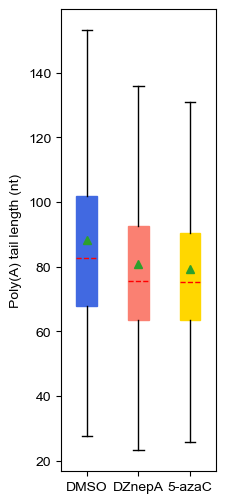

In [54]:
fig, ax = plt.subplots(1, figsize=(2,6))
colors = list(cl.values())
box = ax.boxplot(test.values(), labels=test.keys(), showfliers=False, patch_artist=True, widths=0.4, showmeans=True)
for tag in ["boxes"]:
    [box[tag][i].set_color(colors[i]) for i in range(0, len(box[tag]))]
    [box["medians"][i].set_color("red") for i in range(0, len(box[tag]))]
    [box["medians"][i].set_linestyle("--") for i in range(0, len(box[tag]))]
ax.set_ylabel("Poly(A) tail length (nt)")
# plt.savefig("Boxplotshowing PAL distribution.png", bbox_inches="tight")
# plt.savefig("Boxplotshowing PAL distribution.pdf", bbox_inches="tight")

#### density plot

DZnepA 75.52
DMSO 82.685
5-azaC 75.38


(0.0, 0.025)

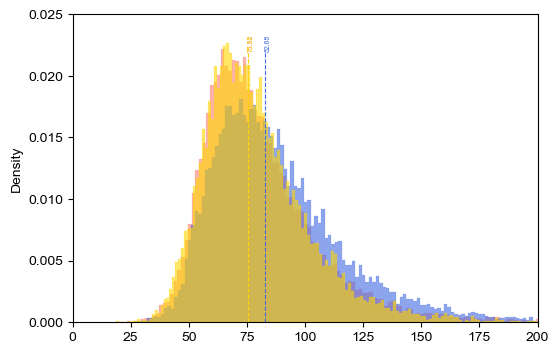

In [57]:
fig, ax = plt.subplots(1, figsize=(6,4))
for sample in ["DZnepA", "DMSO", "5-azaC"]:
    values = polya[sample]
    sns.histplot(values, label=f"{sample} genes: {len(values)}", color=cl[sample], lw=.1,fill=True,alpha=0.6,
    element="step", bins=200, stat="density", line_kws={"linewidth":0})
for sample in ["DZnepA",  "DMSO", "5-azaC"]:
    values = polya[sample]
    med_num = np.median(values)
    print(sample, med_num)
    ax.plot([med_num, med_num], [0, 0.022], color=cl[sample], linewidth=.8, ls="--")
    ax.text(med_num, 0.022, s=f"{round(med_num, 2)}", rotation=90, fontsize=5, color=cl[sample])
#ax.legend(frameon=False)
ax.set_xlim(0,200)
ax.set_ylim(0,0.025)
#plt.savefig("Gene poly(A) Distribution.pdf", bbox_inches="tight")

### Full-length and PAL distribution

In [58]:
polya = defaultdict(dict)
for sample, samples in assign.groupby("sample"):
    polya["Full"][sample] = []
    polya["nonFull"][sample] = []
    samples = samples[samples["qc_tag"] == "PASS"]
    for tag, reads in samples.groupby("Full_length"):
        if tag:
            for gene, genes in reads.groupby("Assigned_gene"):
                polya["Full"][sample].append(genes["polya_length"].median())
        else:
            for gene, genes in reads.groupby("Assigned_gene"):
                polya["nonFull"][sample].append(genes["polya_length"].median())

(0.0, 0.018)

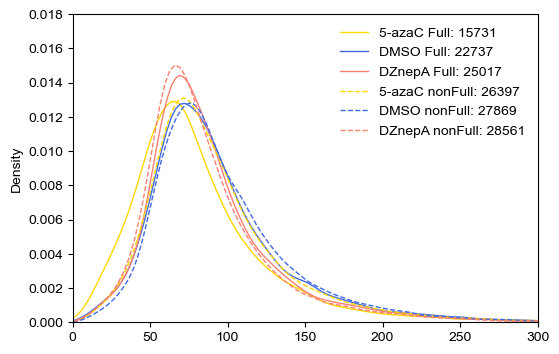

In [59]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=100)
for sample, values in polya["Full"].items():
    sns.kdeplot(values, label=f"{sample} Full: {len(values)}", color=cl[sample],  linewidth=1)
for sample, values in polya["nonFull"].items():
    sns.kdeplot(values, label=f"{sample} nonFull: {len(values)}", color=cl[sample], linestyle="--", linewidth=1)
ax.legend(frameon=False)
ax.set_xlim(0,300)
ax.set_ylim(0,0.018)
#plt.savefig("Gene poly(A) Distribution (Full-or-nonFull).pdf", bbox_inches="tight")

### Different PAL analysis

In [60]:
polya =  defaultdict(dict)
rpm = defaultdict(dict)
for sample, samples in assign.groupby("sample"):
    total = len(samples)
    samples = samples[samples["qc_tag"] == "PASS"]
    for gene, genes in samples.groupby("Assigned_gene"):
        if len(genes) <= 10:
            continue
        polya[sample][gene] = genes["polya_length"].tolist()
        rpm[sample][gene] = len(genes) * 1000000 / total
    print(sample, len(polya[sample]))

5-azaC 11176
DMSO 17428
DZnepA 19296


In [61]:
sample = "DZnepA"
fc = 0.5

overlap = set(polya[sample].keys()) & set(polya["DMSO"].keys())
box_rpm = {"DMSO":[], sample:[]}
diff_polya = defaultdict(dict)
phar = tqdm(total=len(overlap))
for gene in overlap:
    control, compare = polya["DMSO"][gene], polya[sample][gene]
    s, mwu_p = stats.mannwhitneyu(control, compare, alternative="two-sided")
    s, ks_p = stats.ks_2samp(control, compare, alternative="two-sided")
    diff_polya[gene][f"DMSO"] = np.median(control)
    diff_polya[gene][f"{sample}"] = np.median(compare)
    diff_polya[gene]["MHU_pvalue"] = mwu_p
    diff_polya[gene]["KS_pvalue"] = ks_p
    diff_polya[gene]["DMSO_rpm"] = (rpm["DMSO"][gene])
    diff_polya[gene][f"{sample}_rpm"] = (rpm[sample][gene])
    diff_polya[gene]["DMSO_full-length"] = cor["DMSO"]["full-length-ratio"].get(gene)
    diff_polya[gene][f"{sample}_full-length"] =  cor[sample]["full-length-ratio"].get(gene)
    diff_polya[gene]["DMSO_m6a"] = gene_m6a["DMSO"].get(gene)
    diff_polya[gene][f"{sample}_m6a"] = gene_m6a[sample].get(gene)
    phar.update(1)
phar.close()

  0%|          | 0/15860 [00:00<?, ?it/s]

In [62]:
def mark_diff_pal(df, test="MHU_pvalue", fc=0.5):
    if df[test] > 0.05:
        return "None"
    if df["log2fc"] > fc:
        return "Up"
    elif df["log2fc"] < -fc:
        return "Down"
    else:
        return "Normal"


diff_polya = pd.DataFrame.from_dict(diff_polya, orient="index")
diff_polya["log2fc"] = np.log2(diff_polya[sample] / diff_polya["DMSO"])
diff_polya["mark"] = diff_polya.apply(mark_diff_pal, axis=1)
diff_polya.to_csv(f"Differential PAL in {sample}.csv")

#### Load Diff PAL Date

In [68]:
sample = "DZnepA"
diffpolya = pd.read_csv(f"Differential PAL in {sample}.csv", index_col=0)
diffpolya = diff_polya[diff_polya["MHU_pvalue"] < 0.05]

Text(0.5, 1.0, 'Different PAL in DZnepA VS DMSO')

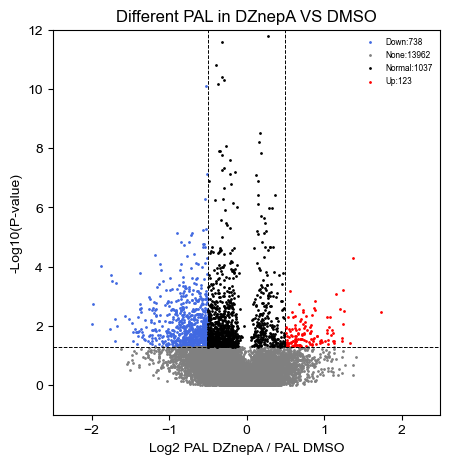

In [65]:
fig, ax = plt.subplots(1, figsize=(5,5))

yaxis = -np.log10(0.05)
colors = {"None":"grey", "Normal":"black", "Down":"royalblue", "Up":"r"}

for tag, genes in diff_polya.groupby("mark"):
    ax.scatter(genes["log2fc"],np.log10(genes["MHU_pvalue"])*-1, s=1, color=colors[tag], label=f"{tag}:{len(genes)}")
fc = 0.5

xlim = 2.5
ylim = 12
ax.set_ylim(-1, ylim)
ax.set_xlim(-xlim, xlim)
ax.plot([fc,fc],[yaxis, ylim], linewidth=.7, ls="--", color="black")
ax.plot([-fc,-fc],[yaxis, ylim], linewidth=.7, ls="--", color="black")
ax.plot([-xlim,-fc],[yaxis, yaxis], linewidth=.7, ls="--", color="black")
ax.plot([fc,xlim],[yaxis, yaxis], linewidth=.7, ls="--", color="black")
ax.legend(frameon=False, fontsize=6)
ax.set_xlabel("Log2 PAL DZnepA / PAL DMSO")
ax.set_ylabel("-Log10(P-value)")
ax.set_title(f"Different PAL in {sample} VS DMSO")
#plt.savefig(f"Volcanplot showing Diff_PAL in {sample}.pdf", bbox_inches="tight")

#### Diff PAL show in Heatmap

In [66]:
bin_width = 5
bin_num = 250
bins = np.arange(0, bin_num, bin_width)
labels = np.arange(bin_width, bin_num, bin_width)

In [67]:
groups = assign.groupby("qc_tag")
reads = groups.get_group("PASS")
#.drop(columns=["labels"], inplace=True)
assign.loc[reads.index, "labels"] = pd.cut(assign.loc[reads.index]["polya_length"], bins=bins, labels=labels)

In [69]:
depal_genes = diffpolya[(diffpolya["mark"] == "Up") | (diffpolya["mark"] == "Down")].index.tolist()

In [70]:
data = defaultdict(dict)
phar = tqdm(total=len(assign))
for sam, samples in assign.groupby("sample"):
    if sam not in ["DMSO", sample]:
        continue
    data[sam] = defaultdict(dict)
    total = len(samples)
    for gene, genes in samples.groupby("Assigned_gene"):
        phar.update(len(genes))
        if gene not in depal_genes:
            continue
        data[sam][gene]["Read_num"] = len(genes)
        genes = genes[genes["qc_tag"] == "PASS"]
        data[sam][gene]["pal-length"] = genes["polya_length"].median()
        for label, reads in genes.groupby("labels"):
            data[sam][gene][label] = len(reads)
phar.close()

  0%|          | 0/8142865 [00:00<?, ?it/s]

In [71]:
result = {}
num = 0
for sam, values in data.items():
    if sam not in ["DMSO", sample]:
        continue
    temp = pd.DataFrame.from_dict(data[sam], orient="index").fillna(0)
    temp = temp[temp["Read_num"] >= num]
    result[sam] = temp
########
g1, g2 = result["DMSO"].index, result[sample].index
overlap = list(set(g1) & set(g2))
sortid = result["DMSO"].loc[overlap].sort_values("pal-length", ascending=[False]).index

########
polya = {}
for sam, values in result.items():
    temp = values.loc[sortid]
    #temp.set_index("Rpm", inplace=True)
    #temp.index.rename("Index", inplace=True)
    temp.drop(columns=["pal-length", "Read_num"], inplace=True)
    polya[sam] = temp

DMSO Finish
DZnepA Finish


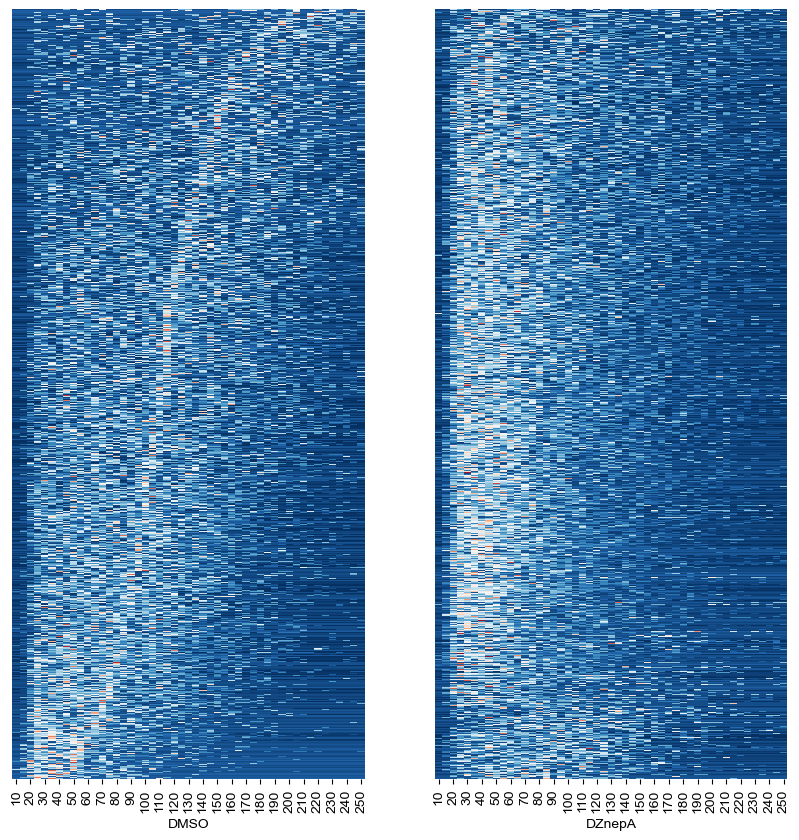

In [73]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
n = 0
for sam in ["DMSO", sample]:
    #df = pd.DataFrame(preprocessing.minmax_scale(values,feature_range=(0, 100), axis=1))
    df = stats.zscore(polya[sam],axis=1)
    df.columns = labels + 5
    #df.index = values.index
    #df.sort_values(df.columns.tolist(), ascending=[False for x in df.columns], inplace=True)
    if n == 0:
        sns.heatmap(df, cmap="RdBu_r", ax=ax[n], vmin=-1, vmax=6, cbar=False)
        ax[n].set_xlabel("DMSO")
    else:
        sns.heatmap(df, cmap="RdBu_r", ax=ax[n], vmin=-1, vmax=6, cbar=False)
        ax[n].set_xlabel(sample)
    ax[n].set_yticks([])
    n += 1
    print(sam,"Finish")
#ax[0].set_ylabel(f"DEG Gene sorted by PAL in DMSO vs {sample}")
#plt.savefig(f"Heatmap showing sorted DEPAL in {sample}.jpeg", bbox_inches="tight")

### PAL in GO

#### Load GO data

In [94]:
def drop_go(df,data):
    num = df["term"].split(":")[1]
    data[num].setdefault("desc", df["name"])
    data[num].setdefault("genes", []).append(df["gene"])
    

def get_gene_from_go(num):
    df = go[go["term"] == f"GO:{num}"]
    genes = df["gene"].tolist()
    return genes


def check_gene(gene):
    return go[go["gene"] == gene]


def read_gene(fp):
    genes = []
    with open(fp, 'r') as f:
        next(f)
        for line in f:
            genes.append(line.rstrip().split()[0])
    return genes


def write_gene(fp, lt):
    with open(fp, 'w') as f:
        f.write("gene")
        for gene in lt:
            f.write(f"\n{gene}")
    
    
go = pd.read_csv("/media/Sorata/data2/work/other/GO/GO/bamboo_go.txt", sep="\t")
#go = pd.read_csv("f:/work/other/GO/GO/bamboo_go.txt", sep="\t")
go_name = defaultdict(dict)
go.sort_values(["term","gene"]).apply(drop_go, axis=1, args=(go_name,))
go_tpm = pd.read_csv("/media/Sorata/data2/work/other/GO/GO/bamboo_go.tpm", sep="\t", index_col=0)
#go_tpm = pd.read_csv("f:/work/other/GO/GO/bamboo_go.tpm", sep="\t", index_col=0)
#go_tpm.drop(columns=["5-azaC_rep1", "5-azaC_rep2"], inplace=True)
go_term = {}
for term, genes in go.groupby("term"):
    go_term[term] = genes["gene"].tolist()

In [76]:
root_go = go[go["name"].str.contains("root")].drop_duplicates(["term"])["term"].tolist()
root_name = go[go["name"].str.contains("root")].drop_duplicates(["name"])["name"].tolist()
root_gene = go[go["term"].isin(root_go)]["gene"].tolist()

In [81]:
go[go["name"].str.contains("root")]

gene        term                                    name  \
869     PH02Gene33526  GO:2000280          regulation_of_root_development   
1507    PH02Gene44073  GO:2000280          regulation_of_root_development   
1961    PH02Gene47376  GO:0080022                primary_root_development   
2401    PH02Gene49902  GO:2000023  regulation_of_lateral_root_development   
3569    PH02Gene18851  GO:0010449                    root_meristem_growth   
...               ...         ...                                     ...   
184867  PH02Gene50211  GO:0010078   maintenance_of_root_meristem_identity   
185175  PH02Gene26660  GO:0010015                      root_morphogenesis   
185407  PH02Gene47375  GO:2000280          regulation_of_root_development   
188006  PH02Gene50735  GO:0048527                lateral_root_development   
188534  PH02Gene51311  GO:0010102              lateral_root_morphogenesis   

                      type  
869     Biological_Process  
1507    Biological_Process  
1961    Biological_Process  
2401    Biological_Process  
3569    Biological_Process  
...                    ...  
184867  Biological_Process  
185175  Biological_Process  
185407  Biological_Process  
188006  Biological_Process  
188534  Biological_Process  

[205 rows x 4 columns]

#### Cluster by GO TPM

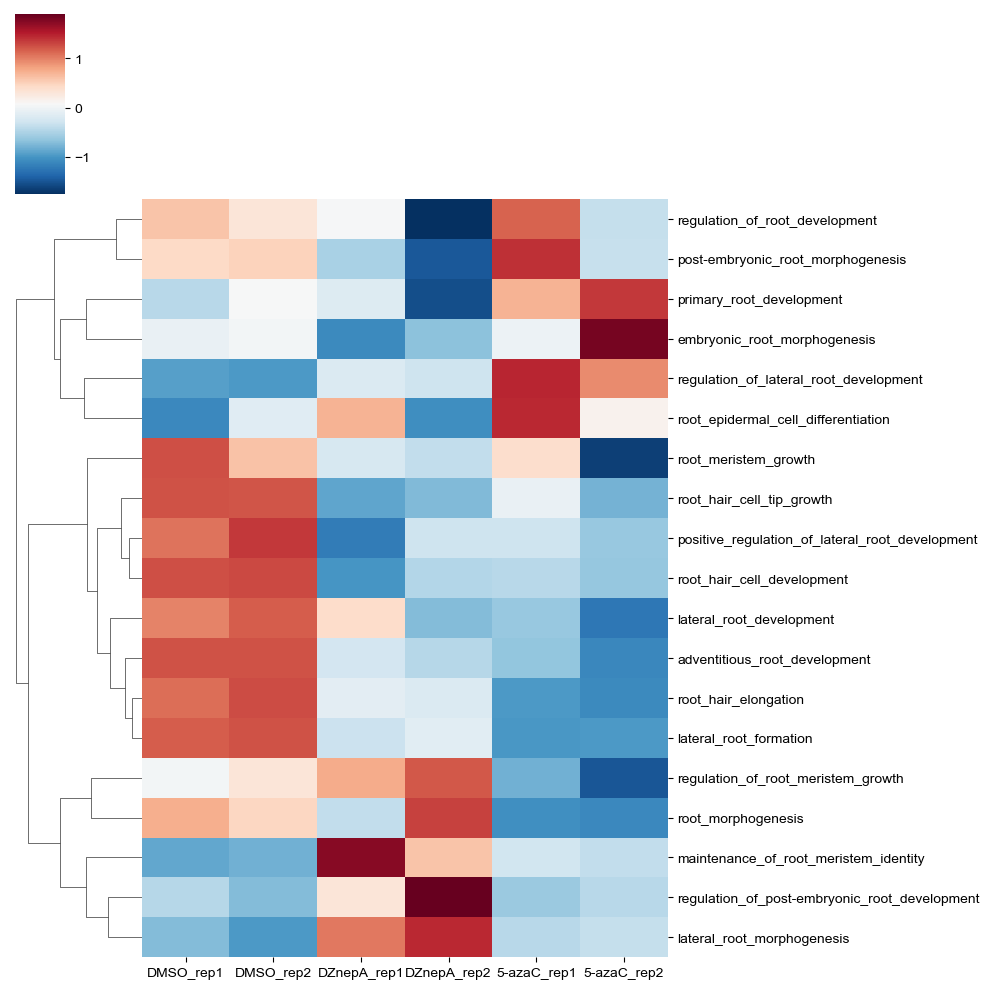

In [95]:
sns.clustermap(go_tpm.loc[root_go],z_score=0, cmap="RdBu_r", yticklabels=root_name, col_cluster=False)

#### PAL in ROOT GO

In [83]:
temp = assign.groupby(["Assigned_gene", "sample", "qc_tag"])


In [84]:
n = 0
polya_go = defaultdict(dict)
for na in root_go:
    for gene in go[go["term"] == na]["gene"]:
        for sample in ["DMSO", "DZnepA","5-azaC"]:
            try:
                reads = temp.get_group((gene, sample, "PASS"))
            except:
                continue
            if len(reads) < 3:
                continue
            polya_go[n]["median"] = reads["polya_length"].median()
            polya_go[n]["gene"] = gene
            polya_go[n]["sample"] = sample
            polya_go[n]["go_term"] = na
            polya_go[n]["desc"] = go_name[na.split(":")[1]]["desc"]
            n += 1

In [85]:
polya_go= pd.DataFrame.from_dict(polya_go, orient="index")
polya_go

median           gene  sample     go_term  \
0     80.480  PH02Gene20340    DMSO  GO:2000280   
1     76.275  PH02Gene20340  DZnepA  GO:2000280   
2     72.230  PH02Gene20340  5-azaC  GO:2000280   
3     88.915  PH02Gene08800    DMSO  GO:2000280   
4     53.290  PH02Gene08800  DZnepA  GO:2000280   
..       ...            ...     ...         ...   
360   57.315  PH02Gene21267  DZnepA  GO:0010101   
361   90.520  PH02Gene21267  5-azaC  GO:0010101   
362   82.190  PH02Gene34995    DMSO  GO:0010101   
363  101.315  PH02Gene34995  DZnepA  GO:0010101   
364   84.850  PH02Gene34995  5-azaC  GO:0010101   

                                  desc  
0       regulation_of_root_development  
1       regulation_of_root_development  
2       regulation_of_root_development  
3       regulation_of_root_development  
4       regulation_of_root_development  
..                                 ...  
360  post-embryonic_root_morphogenesis  
361  post-embryonic_root_morphogenesis  
362  post-embryonic_root_morphogenesis  
363  post-embryonic_root_morphogenesis  
364  post-embryonic_root_morphogenesis  

[365 rows x 5 columns]

In [87]:
fliter_go = ["adventitious_root_development", "lateral_root_development", "lateral_root_formation", "lateral_root_morphogenesis", "maintenance_of_root_meristem_identity", 
"regulation_of_root_development", "regulation_of_root_meristem_growth", "root_hair_elongation"]
polya_go = polya_go[polya_go["desc"].isin(fliter_go)]

In [88]:
pal_go = defaultdict(dict)
for na, values in polya_go.groupby("desc"):
    for sample, samples in values.groupby("sample"):
        pal_go[sample][na] = samples["median"].tolist()

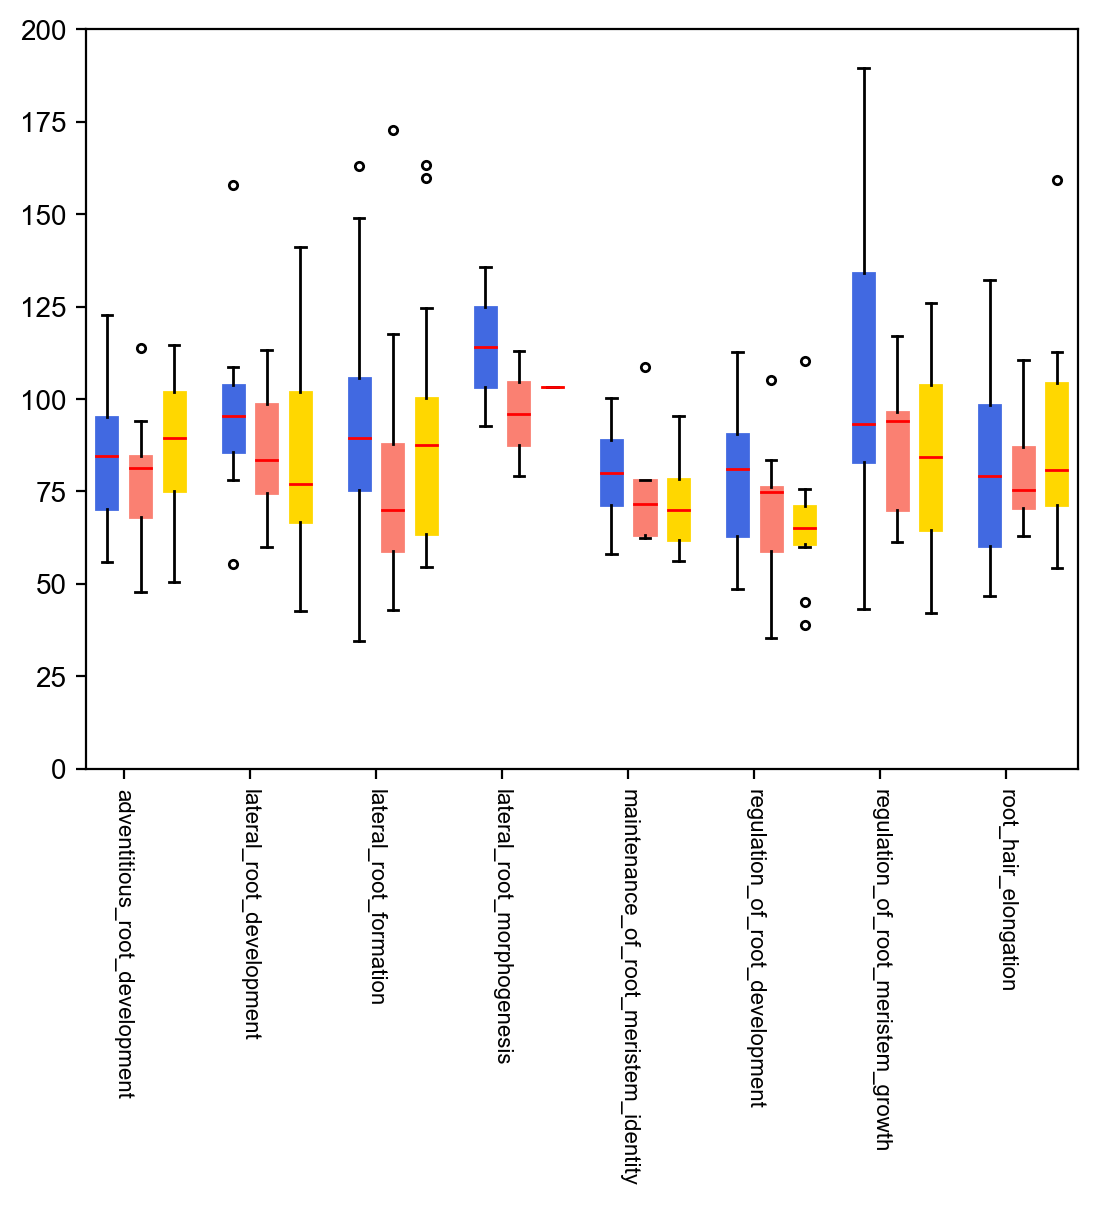

In [93]:
fig, ax = plt.subplots(1, dpi=200)
step = 3
pos1 = range(1, len(pal_go["DMSO"])*step, step)
pos2 = [x+0.8 for x in pos1]
pos3 = [x+0.8 for x in pos2]

box1 = ax.boxplot(list(pal_go["DMSO"].values()), positions=pos1, patch_artist=True, flierprops={"markersize":3})
box2 = ax.boxplot(list(pal_go["DZnepA"].values()), positions=pos2, patch_artist=True, flierprops={"markersize":3})
box3 = ax.boxplot(list(pal_go["5-azaC"].values()), positions=pos3, patch_artist=True, flierprops={"markersize":3})


[x.set_color("royalblue") for x in box1["boxes"]]
[x.set_color("salmon") for x in box2["boxes"]]
[x.set_color("gold") for x in box3["boxes"]]
[x.set_color("red") for x in box1["medians"]]
[x.set_color("red") for x in box2["medians"]]
[x.set_color("red") for x in box3["medians"]]

ax.set_ylim(0, 200)

ax.set_xticks(ticks=[x+0.4 for x in pos1], labels=pal_go["DMSO"].keys(), fontsize=8, rotation=-90)
#plt.savefig("PAL in root go.pdf", bbox_inches="tight")

# 6.Expression of m6A regulators

In [134]:
def getd_pvalue(data, p=0.05):
    new_data = data.copy()
    t, pvalue = stats.ttest_ind(data[m_sample], data[d_sample], axis=1)
    new_data["pvalue"] = pvalue
    new_data = new_data[new_data["pvalue"] < p]
    del new_data["pvalue"]
    return new_data


def geta_pvalue(data, p=0.05):
    new_data = data.copy()
    t, pvalue = stats.ttest_ind(data[m_sample], data[a_sample], axis=1)
    new_data["pvalue"] = pvalue
    new_data = new_data[new_data["pvalue"] < p]
    del new_data["pvalue"]
    return new_data


def rna_d_pvalue(data, p=0.01):
    new_data = data.copy()
    t, pvalue = stats.ttest_ind(data[["DMSO_rep1","DMSO_rep2"]], data[["DZnepA_rep1", "DZnepA_rep2"]], axis=1)
    new_data['pvalue'] = pvalue
#     new_data = new_data[new_data["pvalue"] < p]
#     new_data = new_data.drop(columns=["pvalue"])
    return new_data


def rna_a_pvalue(data, p=0.01):
    new_data = data.copy()
    t, pvalue = stats.ttest_ind(data[["DMSO_rep1","DMSO_rep2"]], data[["5-azaC_rep1", "5-azaC_rep2"]], axis=1)
    new_data['pvalue'] = pvalue
    new_data = new_data[new_data["pvalue"] < p]
    new_data = new_data.drop(columns=["pvalue"])
    return new_data


m_sample = ["DMSO_rep1", "DMSO_rep2", "DMSO_rep3"]
d_sample = ["DZnepA_rep1", "DZnepA_rep2", "DZnepA_rep3"]
a_sample = ["5-azaC_rep2", "5-azaC_rep3"]
####
#### 2022.9.20
####
tpm = pd.read_csv("/media/Sorata/data4/Bamboo/featureCount/RNA-seq-uniq.tpm", sep="\t", index_col=0)
#tpm = pd.read_csv("H:/Bamboo/featureCount/RNA-seq-uniq.tpm", sep="\t", index_col=0)
tpm = tpm[['DMSO_rep1', 'DMSO_rep2', 'DZnepA_rep1','DZnepA_rep2','5-azaC_rep1', '5-azaC_rep2']]
rpm = pd.read_csv("/media/Sorata/data3/bamboo/4_minimap2/correct_high/featurecount/Bamboo_high_correct_rpm", sep='\t', index_col=0)
#rpm = pd.read_csv("G:/bamboo/4_minimap2/correct_high/featurecount/Bamboo_high_correct_rpm", sep='\t', index_col=0)
rpm = rpm[['DMSO_rep1', 'DMSO_rep2', 'DMSO_rep3','DZnepA_rep1', 'DZnepA_rep2', 'DZnepA_rep3','5-azaC_rep2', '5-azaC_rep3']]

In [135]:
eraser = {
    "PH02Gene41067":"ALKBH1D",
    "PH02Gene31209":"AlKBH1A",
    "PH02Gene25786":"ALKBH2",
    "PH02Gene23025":"ALKBH6",
    "PH02Gene01773":"ALKBH8B.1",
    "PH02Gene48699":"ALKBH8B.2",
    "PH02Gene10183":"ALKBH8A",
    "PH02Gene23025":"ALKBH6",
    "PH02Gene00238":"ALKBH9B.1",
    "PH02Gene12989":"ALKBH9B.2",
    "PH02Gene20285":"ALKBH9B.3",
    "PH02Gene19128":"AT1G14710.1",
    "PH02Gene48985":"AT1G14710.2",
    "PH02Gene16712":"ALKBH10B.1",
    "PH02Gene49099":"ALKBH10B.2",
}
writer = {
    "PH02Gene01512":"MTA.1",
    "PH02Gene03311":"MTA.2",
    "PH02Gene34383":"MTB.1",
    "PH02Gene11019":"MTB.2",
    "PH02Gene03617":"MTB.3",
    "PH02Gene31261":"FIONA1",
    "PH02Gene21926":"MTC",
    "PH02Gene30659":"WTAP.1",
    "PH02Gene48506":"WTAP.2",
}
reader = {
    "PH02Gene27145":"CPSF30.1",
    "PH02Gene03159":"CPSF30.2",
    "PH02Gene36946":"CPSF30.3",
    "PH02Gene03570":"ECT1/2/3/4",
    "PH02Gene28571":"ECT1/2/3/4",
    "PH02Gene14088":"ECT1/2/3/4",
    "PH02Gene43393":"ECT1/2/3/4",
    "PH02Gene25943":"ECT1/2/3/4",
    "PH02Gene08729":"ECT1/2/3/4",
    "PH02Gene15172":"ECT1/2/3/4",
    "PH02Gene06710":"ECT1/2/3/4",
    "PH02Gene06709":"ECT1/2/3/4",
    "PH02Gene16621":"ECT5/9/10",
    "PH02Gene28588":"ECT5/9/10",
    "PH02Gene01732":"ECT5/9/10",
    "PH02Gene42624":"ECT5/9/10",
  #  "PH02Gene49656":"ECT5/9/10",
    "PH02Gene08049":"ECT6/7/8/11",
    "PH02Gene19577":"ECT6/7/8/11",
    "PH02Gene36446":"ECT6/7/8/11",
    "PH02Gene36702":"ECT6/7/8/11",
    "PH02Gene07821":"ECT6/7/8/11",
    "PH02Gene25697":"ECT6/7/8/11",
    "PH02Gene32130":"ECT6/7/8/11",
    "PH02Gene42949":"ECT6/7/8/11",
    "PH02Gene29257":"ECT6/7/8/11"}
ejc = {
    "PH02Gene49240":"MAGO",
    "PH02Gene04298":"Y14",
    "PH02Gene18032":"EIF4A-III",
}
tot = {
    "PH02Gene49240":"MAGO",
    "PH02Gene04298":"Y14",
    "PH02Gene18032":"EIF4A-III",
    "PH02Gene27145":"CPSF30.1",
    "PH02Gene03159":"CPSF30.2",
    "PH02Gene36946":"CPSF30.3",
    "PH02Gene03570":"ECT1/2/3/4",
    "PH02Gene28571":"ECT1/2/3/4",
    "PH02Gene14088":"ECT1/2/3/4",
    "PH02Gene43393":"ECT1/2/3/4",
    "PH02Gene25943":"ECT1/2/3/4",
    "PH02Gene08729":"ECT1/2/3/4",
    "PH02Gene15172":"ECT1/2/3/4",
    "PH02Gene06710":"ECT1/2/3/4",
    "PH02Gene06709":"ECT1/2/3/4",
    "PH02Gene16621":"ECT5/9/10",
    "PH02Gene28588":"ECT5/9/10",
    "PH02Gene01732":"ECT5/9/10",
    "PH02Gene42624":"ECT5/9/10",
   # "PH02Gene49656":"ECT5/9/10",
    "PH02Gene08049":"ECT6/7/8/11",
    "PH02Gene19577":"ECT6/7/8/11",
    "PH02Gene36446":"ECT6/7/8/11",
    "PH02Gene36702":"ECT6/7/8/11",
    "PH02Gene07821":"ECT6/7/8/11",
    "PH02Gene25697":"ECT6/7/8/11",
    "PH02Gene32130":"ECT6/7/8/11",
    "PH02Gene42949":"ECT6/7/8/11",
    "PH02Gene29257":"ECT6/7/8/11",
    "PH02Gene01512":"MTA.1",
    "PH02Gene03311":"MTA.2",
    "PH02Gene34383":"MTB.1",
    "PH02Gene11019":"MTB.2",
    "PH02Gene03617":"MTB.3",
    "PH02Gene31261":"FIONA1",
    "PH02Gene21926":"MTC",
    "PH02Gene30659":"WTAP.1",
    "PH02Gene48506":"WTAP.2",   
    "PH02Gene41067":"ALKBH1D",
    "PH02Gene31209":"AlKBH1A",
    "PH02Gene25786":"ALKBH2",
    "PH02Gene23025":"ALKBH6",
    "PH02Gene01773":"ALKBH8B.1",
    "PH02Gene48699":"ALKBH8B.2",
    "PH02Gene10183":"ALKBH8A",
    "PH02Gene23025":"ALKBH6",
    "PH02Gene00238":"ALKBH9B.1",
    "PH02Gene12989":"ALKBH9B.2",
    "PH02Gene20285":"ALKBH9B.3",
    "PH02Gene19128":"AT1G14710.1",
    "PH02Gene48985":"AT1G14710.2",
    "PH02Gene16712":"ALKBH10B.1",
    "PH02Gene49099":"ALKBH10B.2",
}

In [105]:
sample = "DZnepA"
regulater = pd.DataFrame()


for data, label in zip([writer,eraser,reader,ejc],["m6A writer","m6A eraser","m6A reader", "m6A suppressor"]):
    genes = data.keys()
    temp = pd.DataFrame()
    temp["DMSO"] = tpm.loc[genes][["DMSO_rep1","DMSO_rep2"]].mean(axis=1)
    temp[sample] = tpm.loc[genes][[f"{sample}_rep1",f"{sample}_rep2"]].mean(axis=1)
    temp["foldchange"] = np.log2(temp[sample] / temp["DMSO"])
    temp["pvalue"] = rna_d_pvalue(tpm.loc[genes], 0.05)["pvalue"]
    temp["label"] = label
    regulater = pd.concat([regulater, temp])

In [106]:
fc = 0.5
p = np.log10(0.05)
regulater["mark"] = regulater.apply(lambda x:"normal" if abs(x["foldchange"]) < fc or np.log10(x["pvalue"]) > p else "mark", axis=1)

Text(0.5, 0, 'Log2 Foldchange Tpm DZnepA/DMSO')

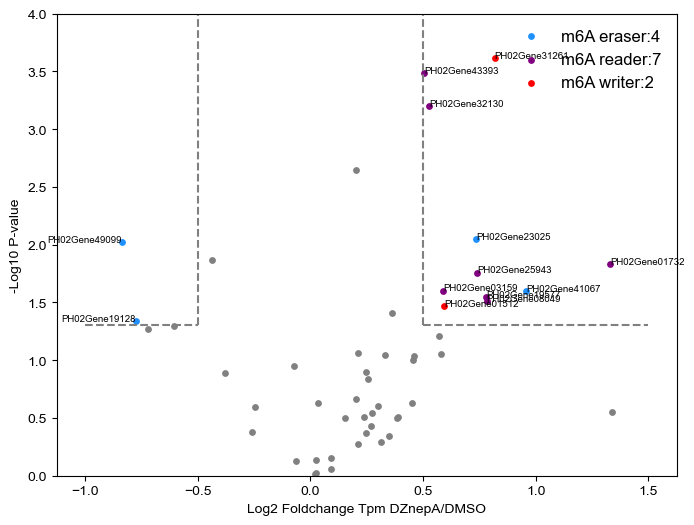

In [108]:
color_dict = {"m6A writer":"red","m6A eraser":"dodgerblue","m6A reader":"purple", "m6A suppressor":"orange"}
fig, ax = plt.subplots(1, figsize=(8,6))


ax.plot([-1,-fc],[-p,-p], ls="--", color="grey")
ax.plot([fc,1.5],[-p,-p], ls="--", color="grey")

ax.plot([fc,fc],[-p,4], ls="--", color="grey")
ax.plot([-fc,-fc],[-p,4], ls="--", color="grey")

for mark, values in regulater.groupby("mark"):
    if mark == "normal":
        y = -np.log10(values["pvalue"])
        ax.scatter(x=values["foldchange"], y=y, label=f"{mark}:{len(values)}", color="grey", s=15)
    else:
        for label, data in values.groupby("label"):
            y = -np.log10(data["pvalue"])
            ax.scatter(x=data["foldchange"], y=y, label=f"{label}:{len(data)}", color=color_dict[label], s=15)
            data.apply(lambda x:ax.text(x=x["foldchange"], y=-np.log10(x["pvalue"]), s=x.name, fontsize=7, horizontalalignment="left") if x["foldchange"] > 0 else ax.text(x=x["foldchange"], y=-np.log10(x["pvalue"]), s=x.name, fontsize=7, horizontalalignment="right"), 
                       axis=1)
            plt.legend(fontsize=12, frameon=False)

ax.set_ylim(0, 4)
ax.set_ylabel("-Log10 P-value")
ax.set_xlabel("Log2 Foldchange Tpm DZnepA/DMSO")
#plt.legend(loc=3)
#plt.savefig(f"m6a-regulater-{sample}.pdf", bbox_inches="tight")

### Show in cluster

<Figure size 640x480 with 0 Axes>

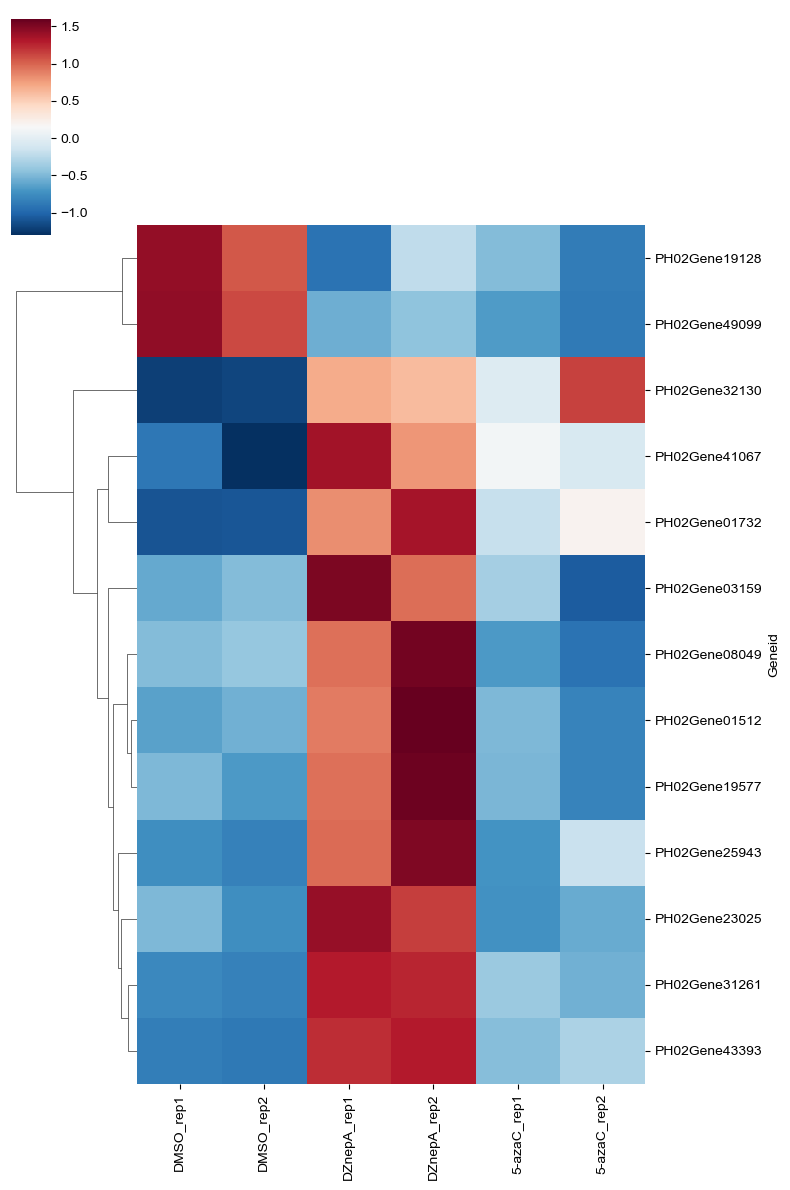

In [110]:
fig = plt.figure()
temp = regulater[regulater["mark"] == "mark"]

cluster = sns.clustermap(tpm.loc[temp.index], z_score=0, figsize=(8,12), col_cluster=False, cmap="RdBu_r")
#plt.savefig("2.pdf", bbox_inches="tight")

Text(155.691452991453, 0.5, '')

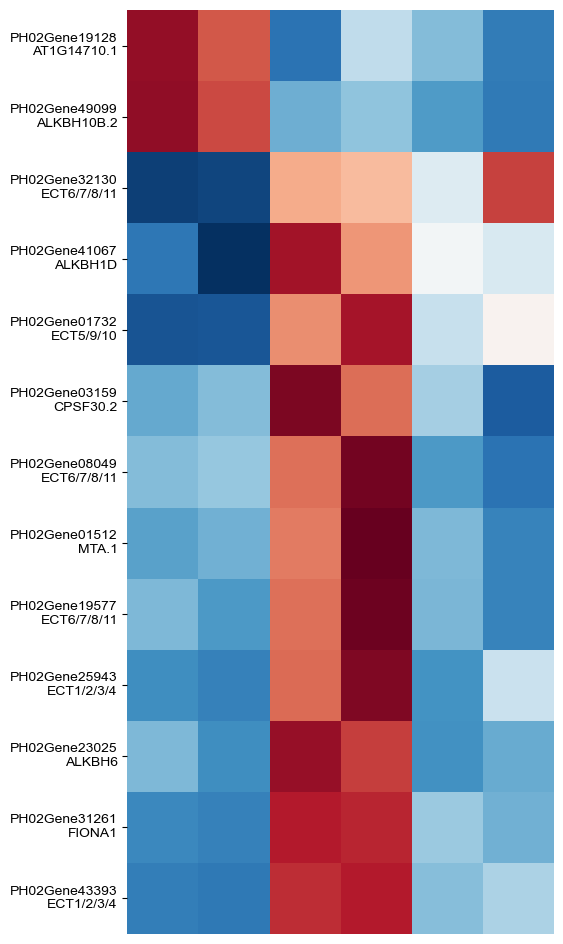

In [111]:
fig = plt.figure(dpi=100, figsize=(8,12))
ylabel = [f"{x}\n{(tot[x])}" for x  in cluster.data2d.index]

sns.heatmap(cluster.data2d, cmap="RdBu_r", yticklabels=ylabel, square=True, cbar=False, xticklabels="")
plt.ylabel("")
#plt.savefig("1.pdf", bbox_inches="tight")

#### Combine with m6A, full-length ratio, and poly(A) tail length

In [112]:
data = defaultdict(dict)
for sam, samples in assign.groupby("sample"):
    print(sam)
    total = len(samples)
    for gene, genes in samples.groupby("Assigned_gene"):
        gene_num = len(genes)
        if gene_num < 10:
            continue
        data[f"{sam}_polyA"][gene] = genes[genes["qc_tag"] == "PASS"]["polya_length"].median()
        data[f"{sam}_full-length"][gene] = len(genes[genes["Full_length"] == True]) / gene_num
        data[f"{sam}_rpm"][gene] = len(genes) * 1000000 / total
        data[f"{sam}_m6A"][gene] = gene_m6a[sam].get(gene)

5-azaC
DMSO
DZnepA


In [113]:
data = pd.DataFrame.from_dict(data)
data["gene"] = data.index
data

5-azaC_polyA  5-azaC_full-length  5-azaC_rpm  5-azaC_m6A  \
PH02Gene00005        91.480            0.000000    7.883722         NaN   
PH02Gene00006       101.600            0.176471   12.183934         NaN   
PH02Gene00007       132.375            0.250000    8.600424         NaN   
PH02Gene00010        43.320            0.304348   16.484147         NaN   
PH02Gene00015        71.900            0.390490  994.782409    0.083121   
...                     ...                 ...         ...         ...   
PH02Gene51276           NaN                 NaN         NaN         NaN   
PH02Gene51290           NaN                 NaN         NaN         NaN   
PH02Gene51297           NaN                 NaN         NaN         NaN   
PH02Gene51338           NaN                 NaN         NaN         NaN   
PH02Gene51436           NaN                 NaN         NaN         NaN   

               DMSO_polyA  DMSO_full-length    DMSO_rpm  DMSO_m6A  \
PH02Gene00005      64.770          0.000000    4.994029       NaN   
PH02Gene00006     104.760          0.548387   10.320993       NaN   
PH02Gene00007      67.330          0.272727    7.324576       NaN   
PH02Gene00010      66.125          0.361702   46.943871  0.239437   
PH02Gene00015      83.000          0.561201  144.160965  0.090116   
...                   ...               ...         ...       ...   
PH02Gene51276         NaN               NaN         NaN       NaN   
PH02Gene51290         NaN               NaN         NaN       NaN   
PH02Gene51297         NaN               NaN         NaN       NaN   
PH02Gene51338         NaN               NaN         NaN       NaN   
PH02Gene51436         NaN               NaN         NaN       NaN   

               DZnepA_polyA  DZnepA_full-length   DZnepA_rpm  DZnepA_m6A  \
PH02Gene00005        75.220            0.000000     9.882484         NaN   
PH02Gene00006        80.270            0.607143     7.478636         NaN   
PH02Gene00007        94.840            0.473684    10.149578         NaN   
PH02Gene00010        49.650            0.473684    10.149578         NaN   
PH02Gene00015        67.700            0.720784  1321.047714    0.075112   
...                     ...                 ...          ...         ...   
PH02Gene51276        88.805            0.652174     6.143166         NaN   
PH02Gene51290        52.390            0.476190     5.608977         NaN   
PH02Gene51297       192.880            0.041667     6.410260         NaN   
PH02Gene51338        12.220            0.596491    15.224367         NaN   
PH02Gene51436        60.370            0.538462     3.472224         NaN   

                        gene  
PH02Gene00005  PH02Gene00005  
PH02Gene00006  PH02Gene00006  
PH02Gene00007  PH02Gene00007  
PH02Gene00010  PH02Gene00010  
PH02Gene00015  PH02Gene00015  
...                      ...  
PH02Gene51276  PH02Gene51276  
PH02Gene51290  PH02Gene51290  
PH02Gene51297  PH02Gene51297  
PH02Gene51338  PH02Gene51338  
PH02Gene51436  PH02Gene51436  

[25807 rows x 13 columns]

In [114]:
mark_genes = cluster.data2d.index.tolist()

In [117]:
temp = data[data["gene"].isin(mark_genes)]
temp

5-azaC_polyA  5-azaC_full-length  5-azaC_rpm  5-azaC_m6A  \
PH02Gene01732        61.950            0.033333   21.501061         NaN   
PH02Gene03159        88.260            0.148148   19.350955    0.560684   
PH02Gene08049        58.380            0.000000   35.118399    0.466993   
PH02Gene19128       100.650            0.000000   14.334040         NaN   
PH02Gene19577       113.000            0.000000   17.200849         NaN   
PH02Gene23025        67.610            0.500000    8.600424    0.750000   
PH02Gene25943        66.670            0.050000   14.334040         NaN   
PH02Gene31261        48.360            0.133333   10.750530    0.727273   
PH02Gene32130       103.520            0.045455   15.767445    0.626984   
PH02Gene43393        65.395            0.052632   27.234677    0.504579   
PH02Gene49099        86.760            0.093750   22.934465         NaN   
PH02Gene01512           NaN                 NaN         NaN         NaN   

               DMSO_polyA  DMSO_full-length   DMSO_rpm  DMSO_m6A  \
PH02Gene01732      85.540          0.187500  15.980892       NaN   
PH02Gene03159      99.365          0.233333   9.988058       NaN   
PH02Gene08049      69.870          0.137500  26.634820  0.567041   
PH02Gene19128      99.075          0.298246  18.977309  0.538383   
PH02Gene19577     107.200          0.000000  22.972533       NaN   
PH02Gene23025      91.105          0.272727   7.324576       NaN   
PH02Gene25943     115.595          0.170732  13.650345       NaN   
PH02Gene31261      86.140          0.142857  11.652734  0.660272   
PH02Gene32130      51.100          0.055556   5.992835  0.941176   
PH02Gene43393      75.035          0.275362  22.972533  0.419267   
PH02Gene49099      99.610          0.189542  50.939094  0.346935   
PH02Gene01512      74.960          0.466667   4.994029       NaN   

               DZnepA_polyA  DZnepA_full-length  DZnepA_rpm  DZnepA_m6A  \
PH02Gene01732       117.750            0.265152   35.256429    0.255692   
PH02Gene03159        74.385            0.346939   13.087614         NaN   
PH02Gene08049        74.910            0.274336   60.363280    0.364602   
PH02Gene19128        70.280            0.389831   15.758555    0.636364   
PH02Gene19577        80.910            0.000000   31.517111    0.409370   
PH02Gene23025       105.655            0.705882   18.162403    0.379310   
PH02Gene25943       104.805            0.288889   24.038474    0.543375   
PH02Gene31261        96.330            0.540230   23.237192    0.399952   
PH02Gene32130        96.515            0.145833   12.820520         NaN   
PH02Gene43393       108.120            0.350746   35.790617    0.349925   
PH02Gene49099        81.575            0.326087   36.858994    0.517241   
PH02Gene01512        66.775            0.238095   11.217955         NaN   

                        gene  
PH02Gene01732  PH02Gene01732  
PH02Gene03159  PH02Gene03159  
PH02Gene08049  PH02Gene08049  
PH02Gene19128  PH02Gene19128  
PH02Gene19577  PH02Gene19577  
PH02Gene23025  PH02Gene23025  
PH02Gene25943  PH02Gene25943  
PH02Gene31261  PH02Gene31261  
PH02Gene32130  PH02Gene32130  
PH02Gene43393  PH02Gene43393  
PH02Gene49099  PH02Gene49099  
PH02Gene01512  PH02Gene01512

#### PLOT

In [118]:
dmso_cl = "royalblue"
dznepa_cl = "lightcoral"

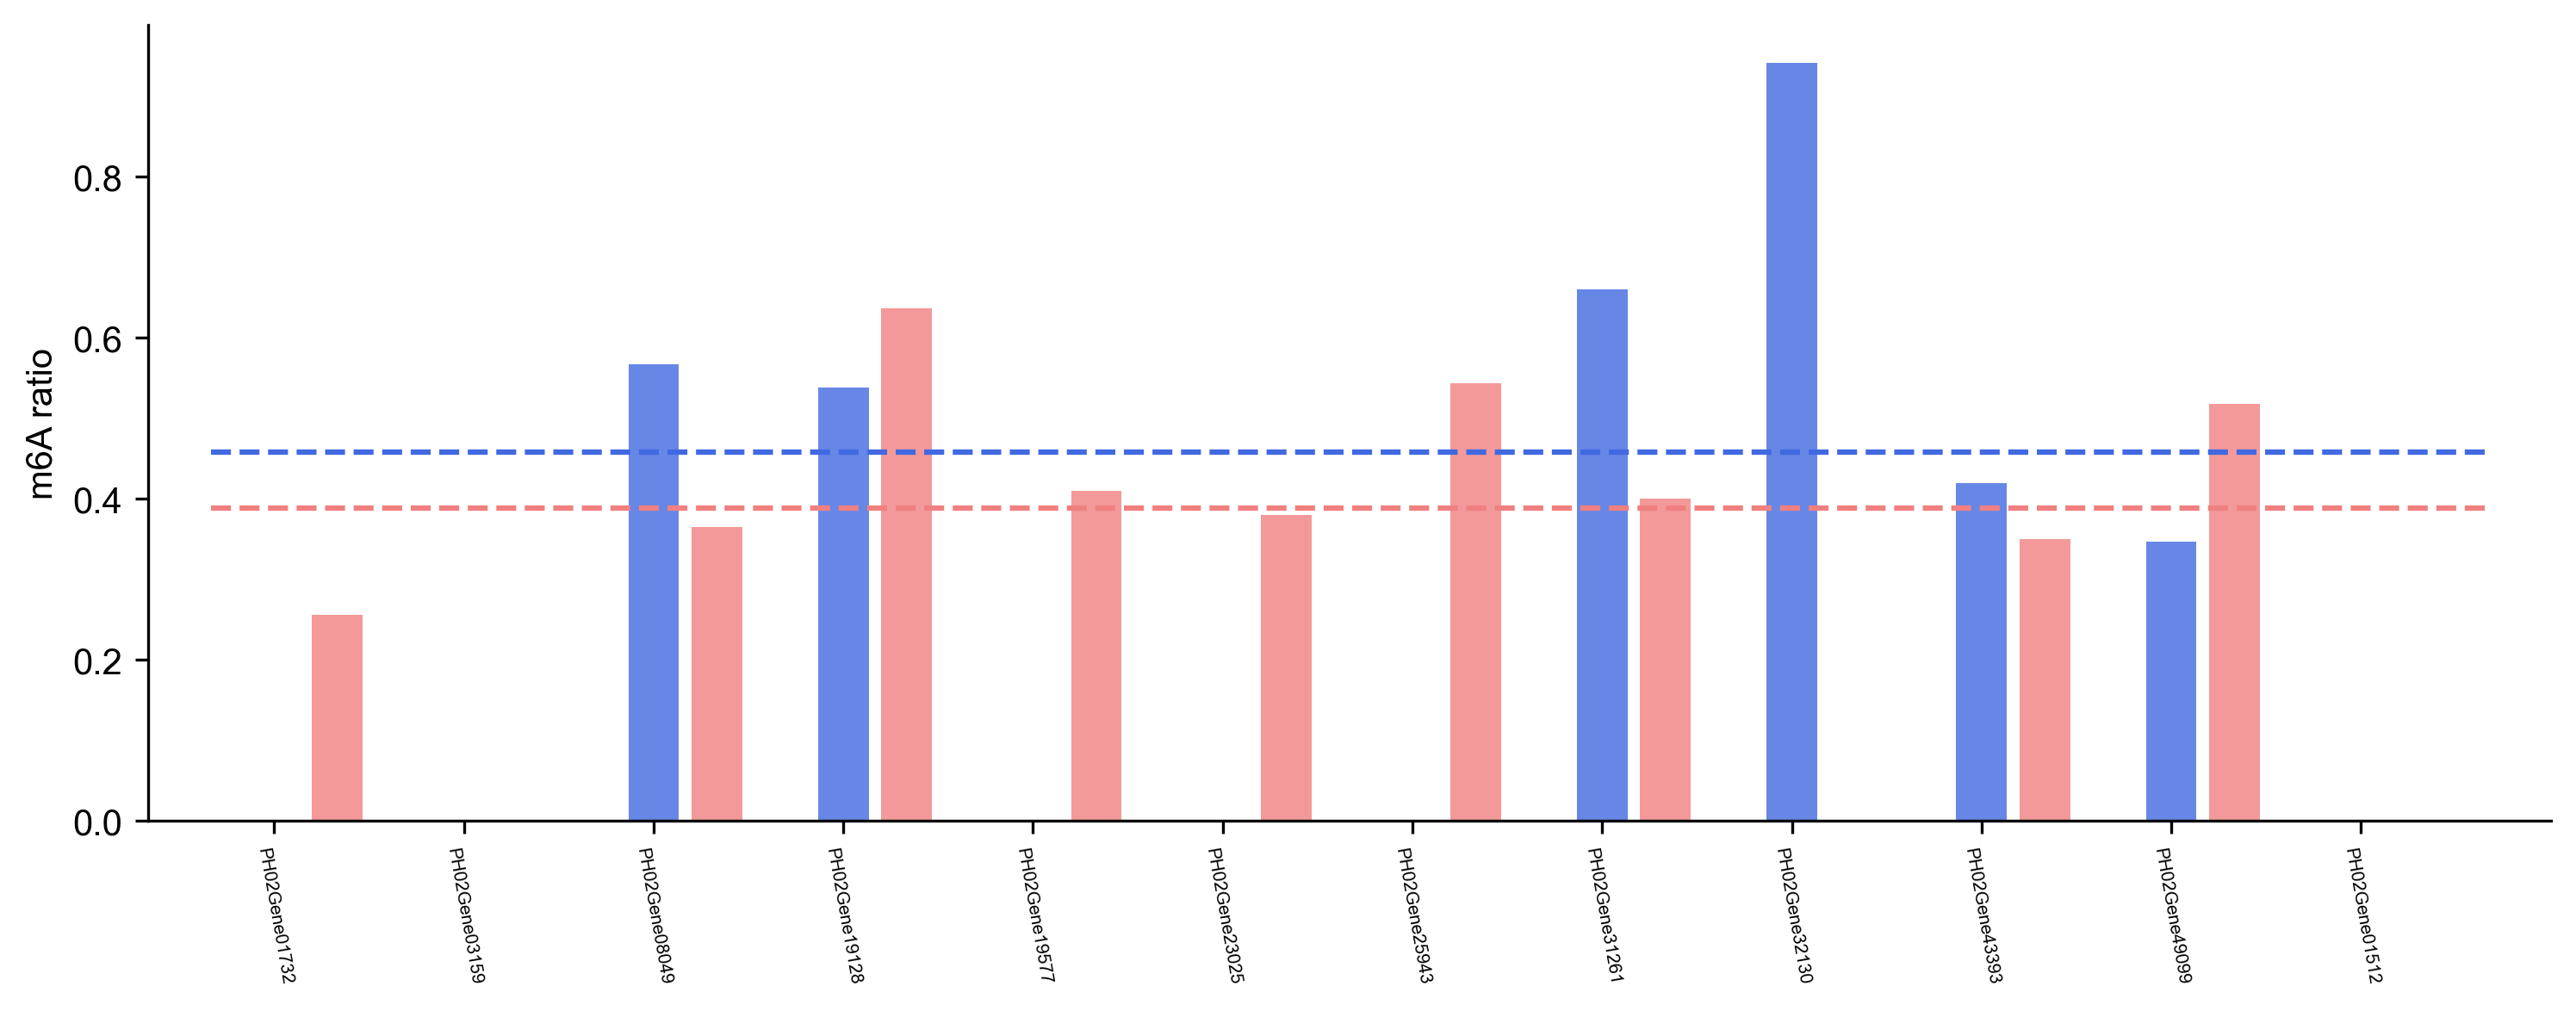

In [124]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=300)
wd = 1
pos1 = [x * 3 for x in range(0, len(temp))]
pos2 = [x + wd for x in pos1]
ax.bar(x=pos1, height=temp["DMSO_m6A"], color=dmso_cl, alpha=.8)
ax.bar(x=pos2, height=temp["DZnepA_m6A"], color=dznepa_cl, alpha=.8)
ax.set_xticks(pos1, temp["gene"], fontsize=5, rotation=-80)
ax.set_ylabel("m6A ratio")
med1 =data["DMSO_m6A"].median()
med2 =data["DZnepA_m6A"].median()
ax.plot([pos1[0]-wd, pos2[-1]+wd], [med1, med1], color=dmso_cl, ls="--")
ax.plot([pos1[0]-wd, pos2[-1]+wd], [med2, med2], color=dznepa_cl, ls="--")
ax.set_xlim(pos1[0]-wd*2, pos2[-1]+wd*2)
ax.spines[["top", "right"]].set_color("None")
#plt.savefig("m6A-regulator.pdf", bbox_inches="tight")

In [126]:
vio = pd.DataFrame()
for sam, samples in assign.groupby("sample"):
    if sam == "5-azaC":
        continue
    print(sam)
    total = len(samples)
    for gene, genes in samples.groupby("Assigned_gene"):
        gene_num = len(genes)
        if gene not in mark_genes:
            continue
        t = pd.DataFrame()
        t["value"] = genes[genes["qc_tag"] == "PASS"]["polya_length"]
        t["sample"] = sam
        t["gene"] = gene
        vio = pd.concat([vio, t])

DMSO
DZnepA


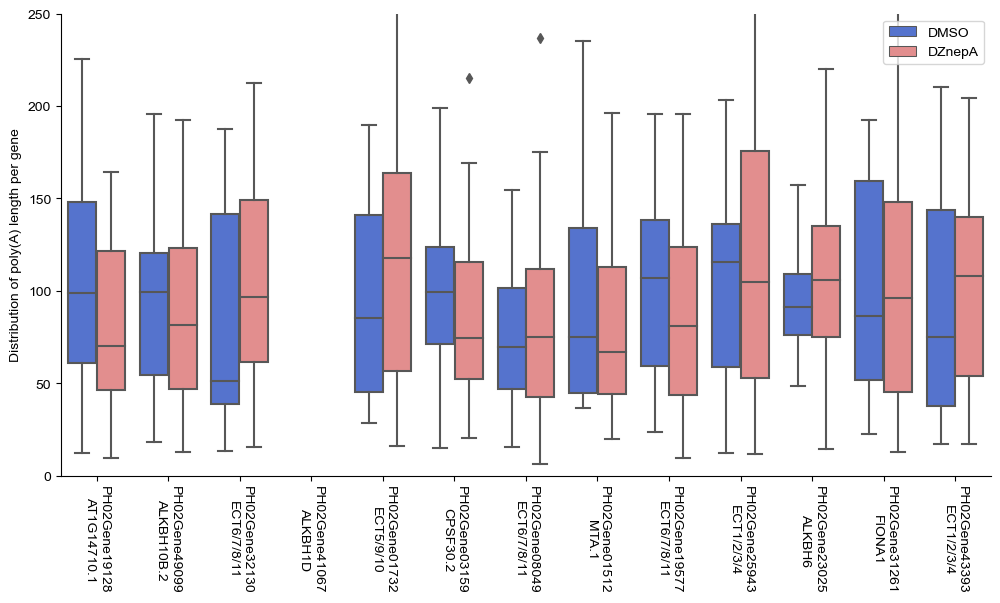

In [127]:
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.boxplot(x="gene", y="value", data=vio, hue="sample",palette={"DMSO":"royalblue","DZnepA":"lightcoral"}, order=mark_genes)
ax.set_xticklabels(ylabel,rotation=-90)
ax.set_xlabel("")
ax.set_ylabel("Distribution of poly(A) length per gene")
ax.spines[["top","right"]].set_color("None")
ax.set_ylim(0, 250)
ax.legend()
#plt.savefig("PAL-regulator.pdf", bbox_inches="tight")

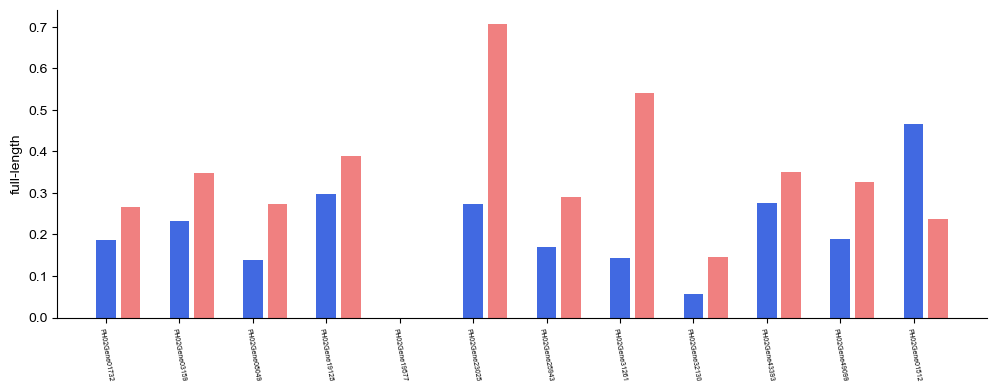

In [131]:
fig, ax = plt.subplots(1, figsize=(12,4))
wd = 1
pos1 = [x * 3 for x in range(0, len(temp))]
pos2 = [x + wd for x in pos1]
ax.bar(x=pos1, height=temp["DMSO_full-length"], color=dmso_cl, alpha=1)
ax.bar(x=pos2, height=temp["DZnepA_full-length"], color=dznepa_cl, alpha=1)
ax.set_xticks(pos1, temp["gene"], fontsize=5, rotation=-80)
#ax.set_xticks(pos1, [])
ax.set_ylabel("full-length")
med1 =data["DMSO_full-length"].median()
med2 =data["DZnepA_full-length"].median()
ax.set_xlim(pos1[0]-wd*2, pos2[-1]+wd*2)
ax.spines[["top", "right"]].set_color("None")
#plt.savefig("full-regulator.pdf", bbox_inches="tight")

# 7.LncRNA

In [3]:
def read_bam(bam_p):
    reads = pysam.AlignmentFile(bam_p, "rb")
    data = defaultdict(dict)
    for read in reads:
        data[read.qname]["chrom"] = read.reference_name
        #data[read.qname]["CIGAR"] = read.cigarstring
        data[read.qname]["alen"] = read.alen
        data[read.qname]["quality"] = read.mapping_quality
        if read.is_reverse:
            data[read.qname]["strand"] = "-"
        else:
            data[read.qname]["strand"] = "+"
        data[read.qname]["ref_st"] = read.reference_start + 1
        data[read.qname]["ref_ed"] = read.reference_end + 1
    reads.close()
    return data

def get_lnc_data(gff_fp):
    import re
    gff_data = defaultdict(dict)
    gff_strand, exon_len, gene_len = {}, {}, {}
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "transcript":
                gene = re.findall("ID=(.*?);", info[-1])[0]
                gff_strand[gene] = strand
                gff_data[gene] = []
                gene_len[gene] = abs(int(ed) - int(st)) + 1
            elif info[2] == "exon":
                exon_len.setdefault(gene, 0)
                transcipt_id = des.split("=")
                cd = abs(int(st) - int(ed)) + 1
                exon_len[gene] += cd
                gff_data[gene].append([int(st), int(ed), cd])
    return gff_data, gff_strand, gene_len, exon_len

In [4]:
gff_fp = "G:/bamboo/8_noncoding/noncoding.gff"
lnc_gff_data, lnc_strand, lnc_transcript_len, lnc_exon_len = get_lnc_data(gff_fp)

In [5]:
lnc_single_exon = [x[-1] for feature in lnc_gff_data.values() for x in feature]

lnc_intron_len = {}
for gene, feature in lnc_gff_data.items():
    if len(feature) == 1:
        continue
    exon_ed = feature[0][1]
    for st, ed, num in feature[1:]:
        lnc_intron_len.setdefault(gene, 0)
        lnc_intron_len[gene] += (st-exon_ed)+1
        exon_ed = ed

In [6]:
def get_gff_data(gff_fp):
    import re
    gff_data = defaultdict(dict)
    gff_strand, exon_len, gene_len = {}, {}, {}
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "mRNA":
                gene = re.findall("ID=(.*?);", info[-1])[0].split(".")[0]
                gff_strand[gene] = strand
                gff_data[gene] = []
                gene_len[gene] = abs(int(ed) - int(st)) + 1
            elif info[2] == "exon":
                exon_len.setdefault(gene, 0)
                transcipt_id = des.split("=")
                cd = abs(int(st) - int(ed)) + 1
                exon_len[gene] += cd
                gff_data[gene].append([int(st), int(ed), cd])
    return gff_data, gff_strand, gene_len, exon_len


fp = "/media/Sorata/win/genome/Bamboo.Hic.gff"
fp = "I:/genome/Bamboo.Hic.gff"
coding_gff_data, coding_gff_strand, coding_gene_len, coding_exon_len = get_gff_data(fp)

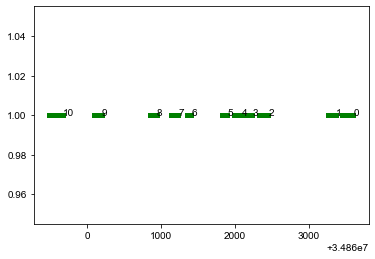

In [25]:
n = 0
for feature in coding_gff_data["PH02Gene00006"]:
    st, ed , cd = feature
    plt.plot([st, ed], [1, 1], linewidth=5, color="green")
    plt.text(ed, 1, n)
    n += 1

In [7]:
coding_single_exon_len = [x[-1] for feature in coding_gff_data.values() for x in feature]
coding_intron_len = {}
for gene, feature in coding_gff_data.items():
    if len(feature) == 1:
        continue 
    strand = coding_gff_strand[gene]
    if strand == "+":
        exon_ed = feature[0][1]
        for st, ed, num in feature[1:]:
            coding_intron_len.setdefault(gene, 0)
            coding_intron_len[gene] += (st-exon_ed)+1
            exon_ed = ed
    else:
        exon_ed = feature[0][0]
        for st, ed, num in feature[1:]:
            coding_intron_len.setdefault(gene, 0)
            coding_intron_len[gene] += (exon_ed-ed)+1
            exon_ed = st

### Distribution of noncoding transcript length

meta NOT subset; don't know how to subset; dropped


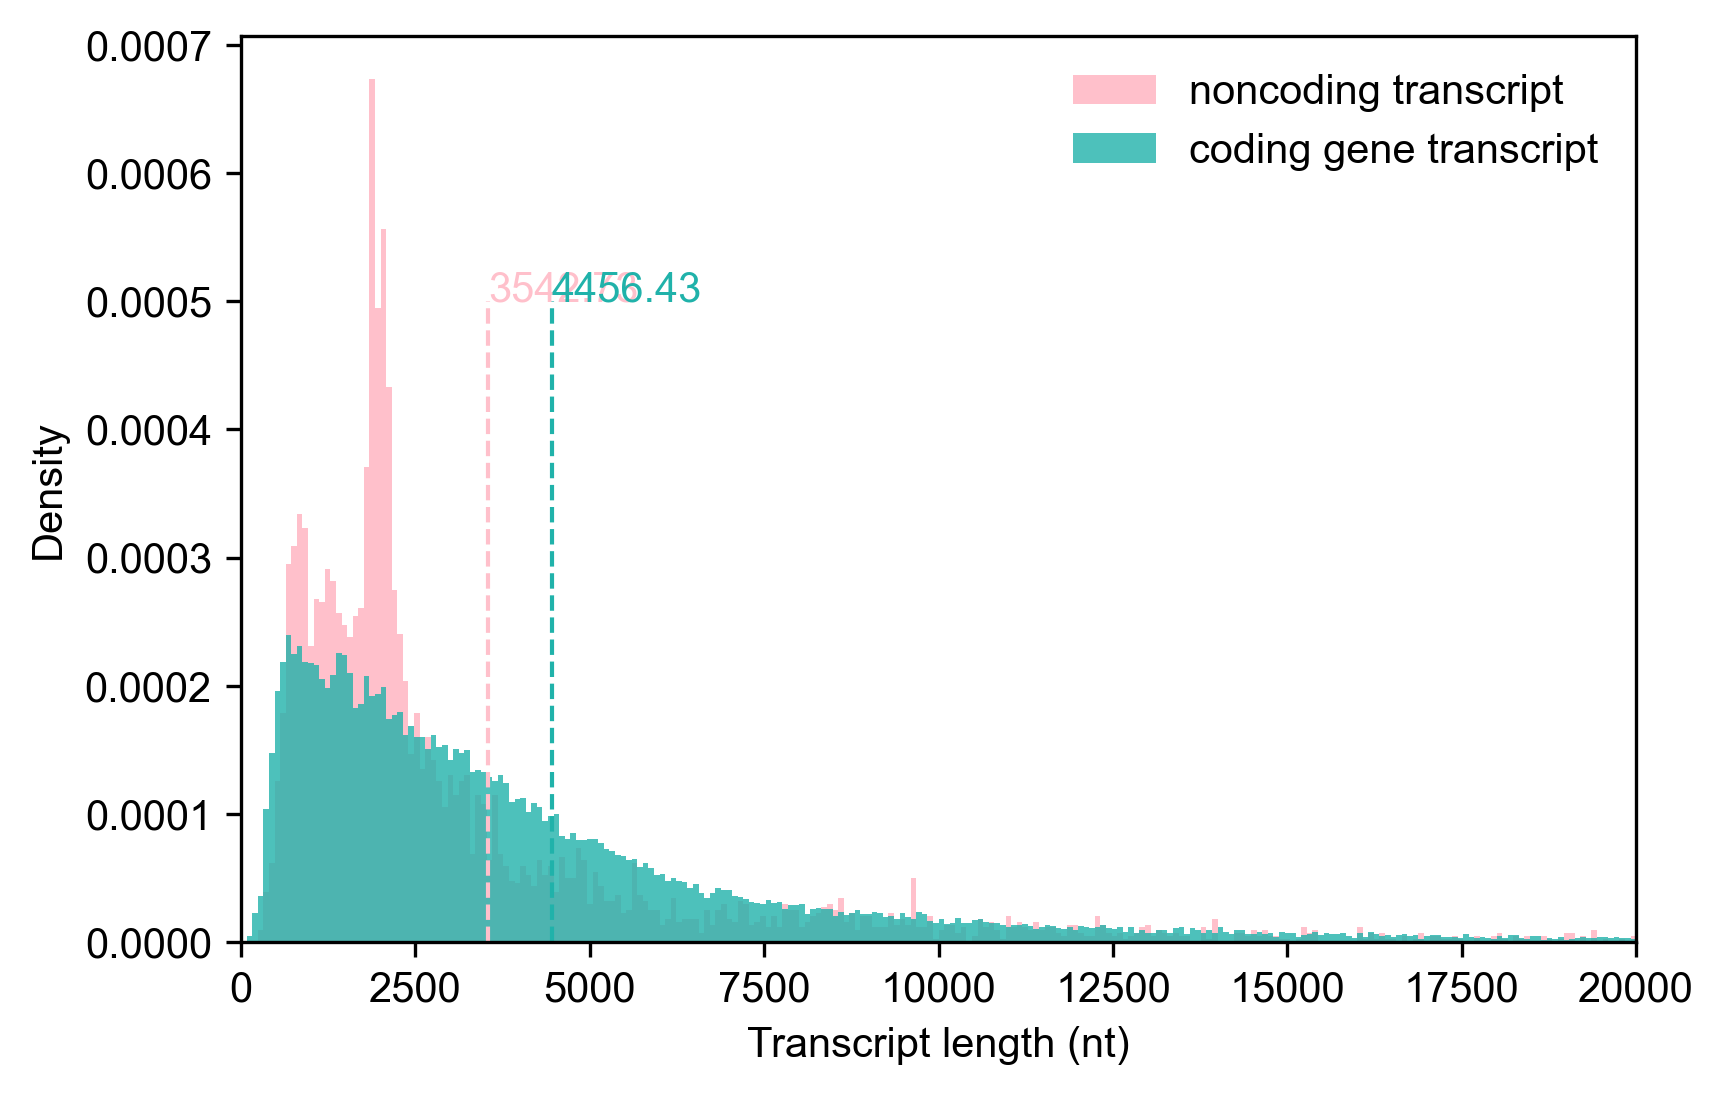

In [178]:
fig, ax = plt.subplots(1, dpi=300)

lnc_med = round(np.mean(list(lnc_transcript_len.values())), 2)
cds_med = round(np.mean(list(coding_gene_len.values())), 2)

n = 0.0005
ax.hist(lnc_transcript_len.values(), bins=250, color="pink", label="noncoding transcript",  density=True, range=(0, 20000))
ax.hist(coding_gene_len.values(), bins=250, alpha=.8, color="lightseagreen", label="coding gene transcript", density=True, range=(0, 20000))
ax.plot([lnc_med, lnc_med], [0, n], ls="--", lw=1, color="pink")
ax.plot([cds_med, cds_med], [0, n], ls="--", lw=1, color="lightseagreen")
ax.text(lnc_med, n, s=lnc_med, color="pink")
ax.text(cds_med, n, s=cds_med, color="lightseagreen")
ax.set_xlim(0, 20000)
ax.set_xlabel("Transcript length (nt)")
ax.set_ylabel("Density")
ax.legend(frameon=False)
plt.savefig("Barplot showing transcript length of noncoding.pdf", bbox_inches="tight")

### Distribution of noncoding total exon length

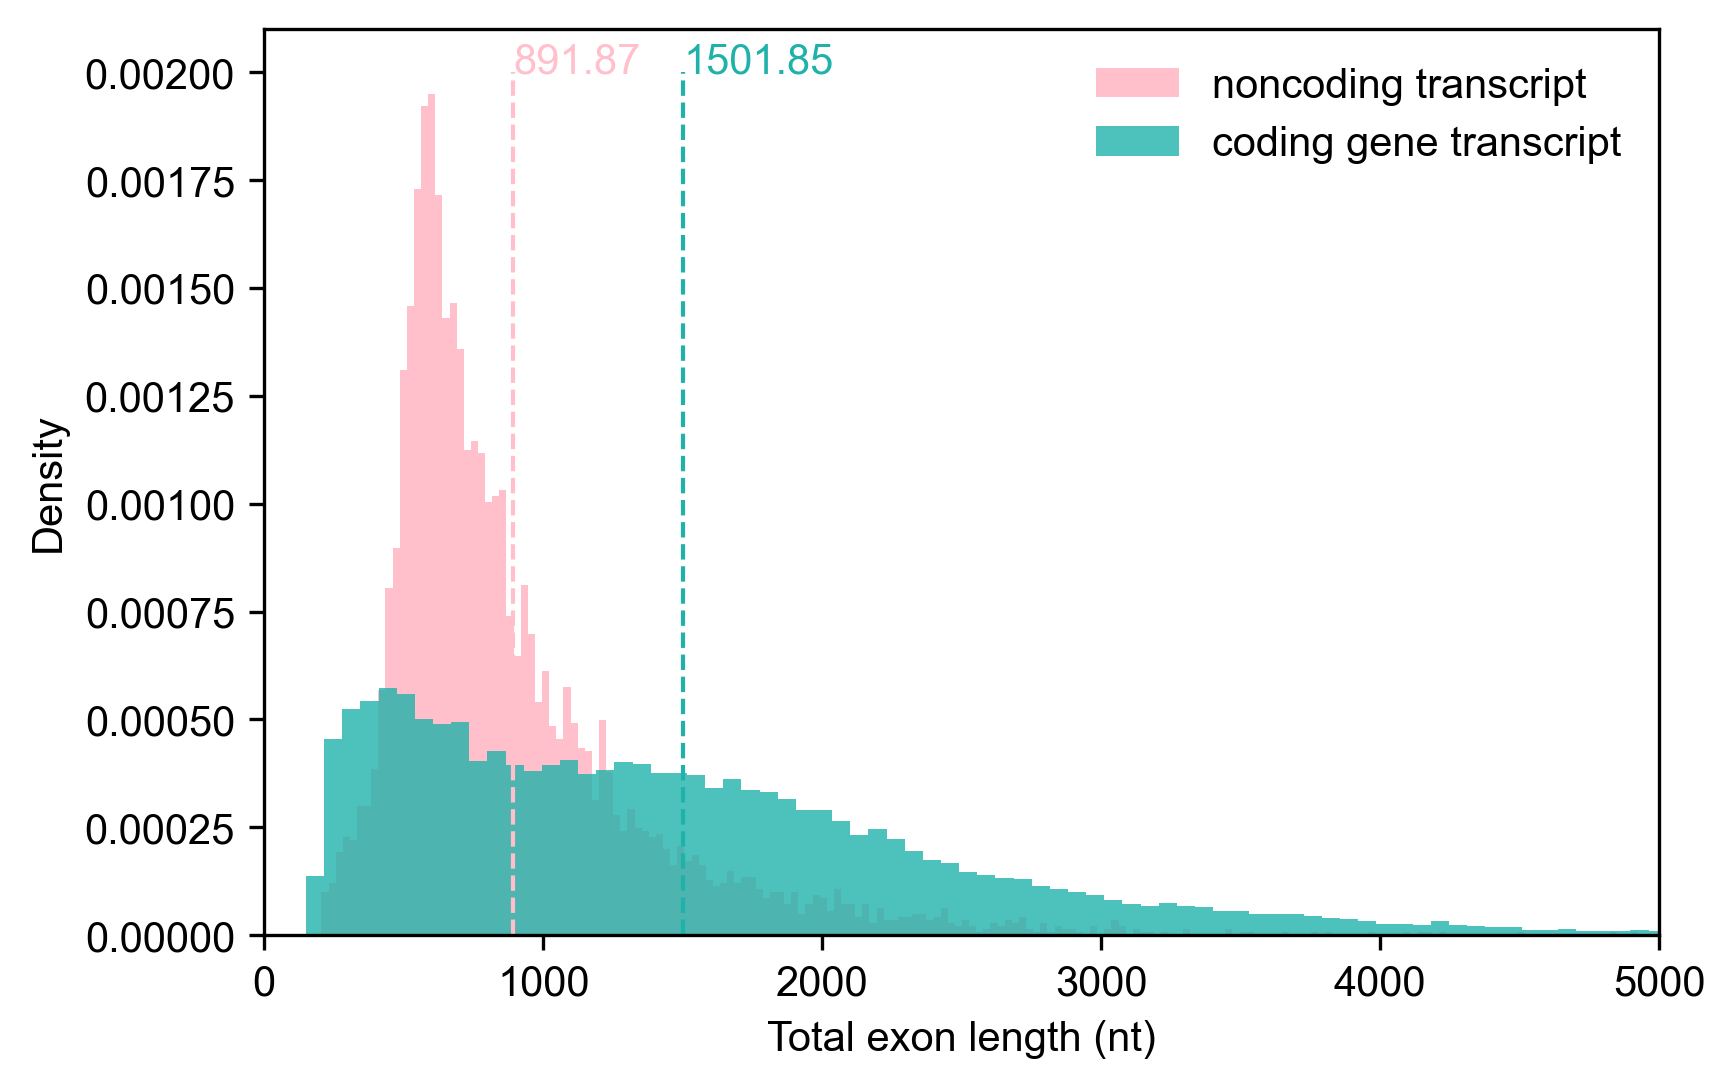

In [179]:
## Distribution of noncoding length
fig, ax = plt.subplots(1, dpi=300)

lnc_med = round(np.mean(list(lnc_exon_len.values())), 2)
cds_med = round(np.mean(list(coding_exon_len.values())), 2)

ax.hist(lnc_exon_len.values(), bins=250, color="pink", label="noncoding transcript",  density=True)
ax.hist(coding_exon_len.values(), bins=250, alpha=.8, color="lightseagreen", label="coding gene transcript", density=True)
ax.plot([lnc_med, lnc_med], [0, 0.002], ls="--", lw=1, color="pink")
ax.plot([cds_med, cds_med], [0, 0.002], ls="--", lw=1, color="lightseagreen")
ax.text(lnc_med, 0.002, s=lnc_med, color="pink")
ax.text(cds_med, 0.002, s=cds_med, color="lightseagreen")
# ax.set_ylim(0, 350)
ax.set_xlim(0, 5000)
ax.set_xlabel("Total exon length (nt)")
ax.set_ylabel("Density")
ax.legend(frameon=False)
#plt.savefig("Barplot showing exon length of noncoding.pdf", bbox_inches="tight")

### Distribution of noncoding intron length

In [ ]:
lnc_transcript_len
lnc_exon_len
lnc_intron_len
lnc_single_exon
lnc_strand

coding_single_exon_len
coding_intron_len
coding_gene_len
coding_exon_len

meta NOT subset; don't know how to subset; dropped


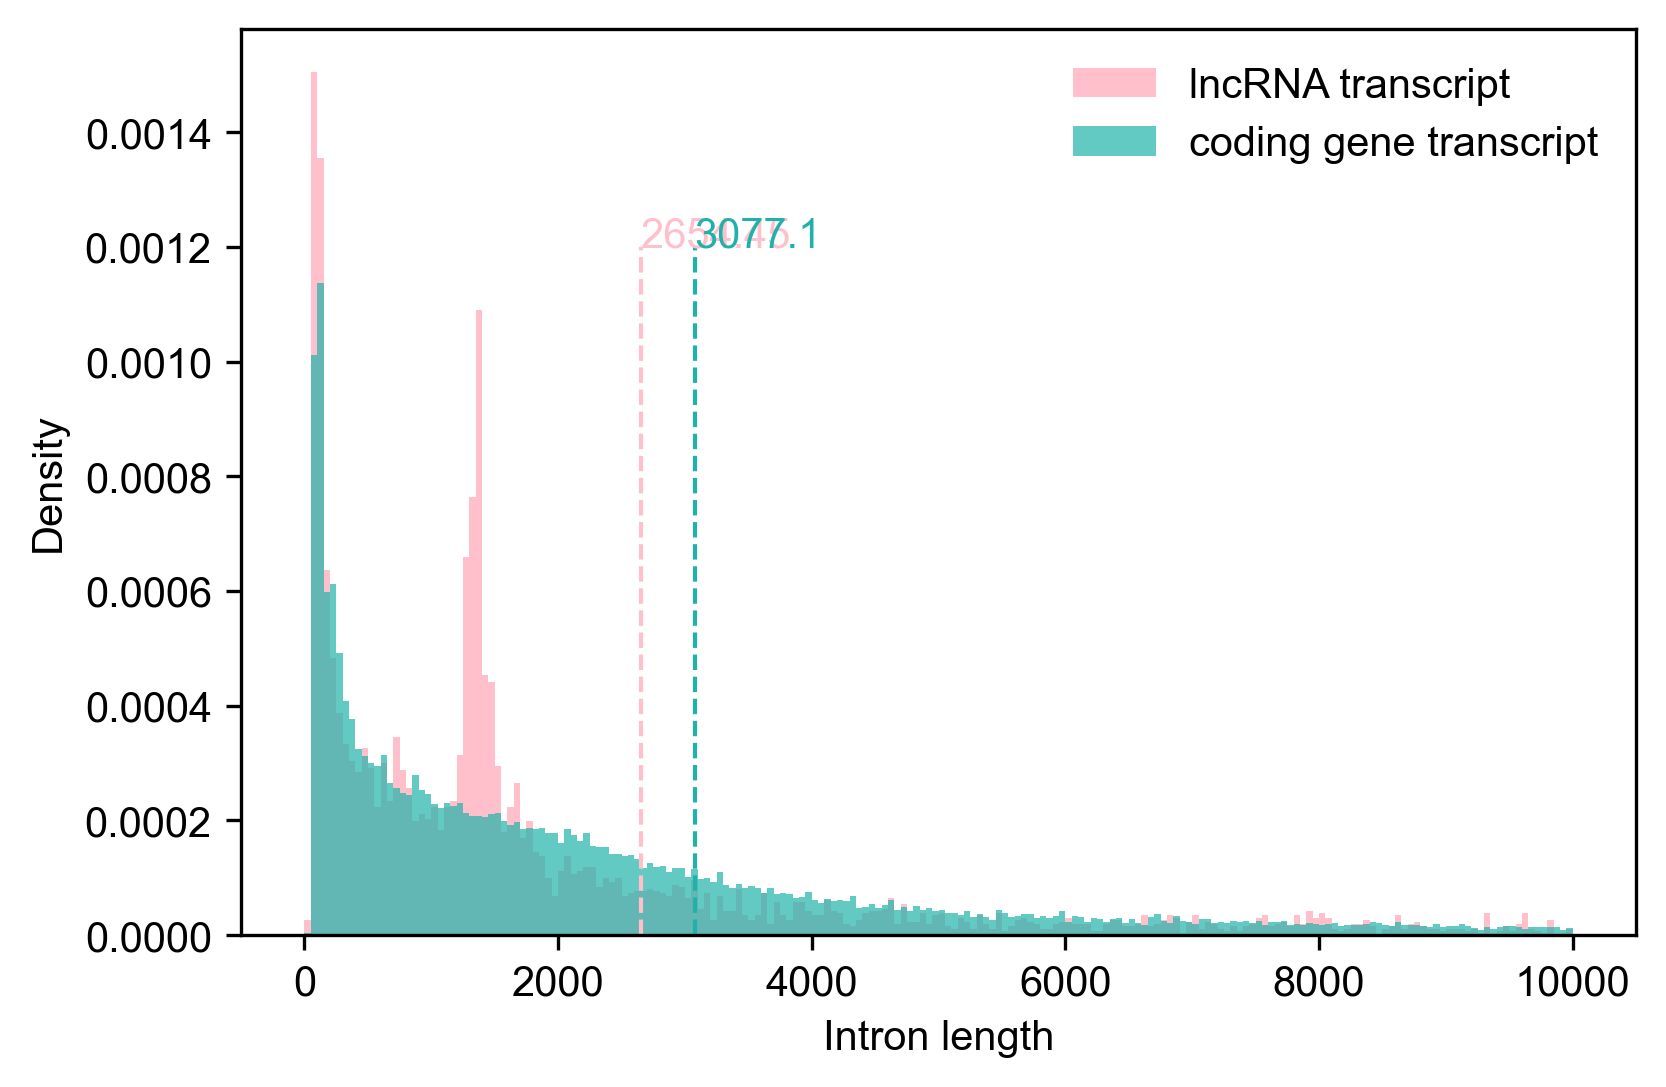

In [26]:
## Distribution of noncoding length
fig, ax = plt.subplots(1, dpi=300)


lnc_med = round(np.mean(list(lnc_intron_len.values())), 2)
cds_med = round(np.mean(list(coding_intron_len.values())), 2)

ax.hist(lnc_intron_len.values(), bins=200, color="pink", label="lncRNA transcript",  density=True, range=(0, 10000))
ax.hist(coding_intron_len.values(), bins=200, alpha=.7, color="lightseagreen", label="coding gene transcript", density=True, range=(0, 10000))

n = 0.0012
ax.plot([lnc_med, lnc_med], [0, n], ls="--", lw=1, color="pink")
ax.plot([cds_med, cds_med], [0, n], ls="--", lw=1, color="lightseagreen")
ax.text(lnc_med, n, s=lnc_med, color="pink")
ax.text(cds_med, n, s=cds_med, color="lightseagreen")
# ax.set_ylim(0, 350)
#ax.set_xlim(0, 10000)
ax.set_xlabel("Intron length")
ax.set_ylabel("Density")
ax.legend(frameon=False)
plt.savefig("Barplot showing intron length of noncoding.pdf", bbox_inches="tight")

### LncRNA dataframe construction

#### minimap2

In [149]:
df = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/{sample}_correct_{rep}.sort.bam"
        bam = read_bam(fp)
        bam_turn = pd.DataFrame.from_dict(bam, orient='index')
        bam_turn["sample"] = sample
        bam_turn["rep"] = rep
        df = pd.concat([df, bam_turn])
    print(sample, "Finish")

DMSO Finish
DZnepA Finish
5-azaC Finish


#### nanopolish

In [150]:
p = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/4_minimap2/correct_orgin/apa/{sample}_{rep}.apa"
        poly = pd.read_csv(fp, sep="\t", usecols=["readname", "polya_length", "qc_tag"], index_col=0)
        p = pd.concat([p, poly])
    print(sample, "poly(A) tail Finish")
df = pd.concat([df, p], axis=1, join="outer")
df = df[df["chrom"].notna()]

DMSO poly(A) tail Finish
DZnepA poly(A) tail Finish
5-azaC poly(A) tail Finish


#### featurecount

In [151]:
assign = pd.DataFrame()
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    for rep in ["rep1", "rep2", "rep3"]:
        if sample == "5-azaC" and rep == "rep1":
            continue
        fp = f"/media/Sorata/data3/bamboo/8_noncoding/5_featurecount/DRS/{sample}_correct_{rep}.sort.bam.featureCounts"
        f = pd.read_csv(fp, sep="\t", index_col=0, header=None, usecols=[0,3], names=["read_name", "Assigned_gene"])
        assign = pd.concat([assign, f])
    print(sample, "FeatureCount Assigned Gene Finish")
df = pd.concat([df, assign], axis=1, join="outer")

DMSO FeatureCount Assigned Gene Finish
DZnepA FeatureCount Assigned Gene Finish
5-azaC FeatureCount Assigned Gene Finish


In [152]:
df = df[df["Assigned_gene"].notna()]
for label, reads in df.groupby("Assigned_gene"):
    if label:
        df.loc[reads.index, "NAT"] = reads.apply(lambda x:False if x["strand"] == gff_strand[x["Assigned_gene"]] else True, axis=1)

#### full-length ratio

In [154]:
def get_cds(gff_fp):
    data = {}
    with open(gff_fp, 'r') as f:
        for n in range(0,3):
            next(f)
        for line in f:
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "exon":
                gene = des.split("=")[1]
                data.setdefault(gene,[]).append([int(st), int(ed)])
    return data


def mark_full(x,phar,num=20):
    '''
    ref_st : the position in read to the translation start site
    '''
    gene = x["Assigned_gene"]
    phar.update(1)
    if gff_strand[gene] == "+":
        pos = x["ref_st"] - cds_start[gene]
        if  pos <= num:
            return True
        else:
            return False
    else:
        pos = x["ref_ed"] - cds_start[gene]
        if pos >= -num:
            return True
        else:
            return False


def calculate_read_percent(x, phar):
    st, ed = gff_len[x["Assigned_gene"]]
    phar.update(1)
    per = x["alen"] / abs(st -ed)
    return round(per, 4)


gff_fp = "/media/Sorata/data3//bamboo/8_noncoding/noncoding.gff"
gff_cds = get_cds(gff_fp)
#####
##### mark the start point of translation
##### 
cds_start = {}
for gene, values in gff_cds.items():
    strand = lnc_strand[gene]
    if strand == "+":
        cds_start[gene] = gff_cds[gene][0][0]
    else:
        cds_start[gene] = gff_cds[gene][0][1]

In [156]:
phar = tqdm(total=len(df))
df["Full_length"] = df.apply(mark_full, args=(phar,), axis=1)
df["Read_percent"] = df.apply(lambda x:x["alen"] / lnc_transcript_len[x["Assigned_gene"]], axis=1)
phar.close()

  0%|          | 0/198203 [00:00<?, ?it/s]

In [157]:
df

chrom     alen  quality  \
ed152422-0b85-4db9-9b57-da93f81886a4      hic_scaffold_1   1308.0     60.0   
8149aee8-1f7d-4c39-acb6-d817632cd534      hic_scaffold_1   1440.0     60.0   
d732f213-eabe-4b66-9cd7-0c0dd0f0e090      hic_scaffold_1   5128.0     60.0   
a851e641-7eb1-4a70-91b6-c22eececa0a5      hic_scaffold_1  10723.0     60.0   
44ac50b4-ab59-49b0-8611-5a8a65e43f2b      hic_scaffold_1   1115.0     60.0   
...                                                  ...      ...      ...   
5129e18f-2364-4da1-8104-ac5550daaa1a  hic_scaffold_17000    767.0     49.0   
98abd0c3-25f0-4ad4-bd2a-6615f50726c3  hic_scaffold_17000    724.0     60.0   
b14db660-d385-4932-9b44-07e7db192ca9  hic_scaffold_17000    269.0     60.0   
ec0b0c21-9d7c-445c-b3cf-bf11c807a27e  hic_scaffold_17059   2207.0     55.0   
15623c76-1a9d-4bb9-962b-941400ea4e5d  hic_scaffold_19224   1409.0     60.0   

                                     strand     ref_st     ref_ed  sample  \
ed152422-0b85-4db9-9b57-da93f81886a4      +   541002.0   542310.0    DMSO   
8149aee8-1f7d-4c39-acb6-d817632cd534      -  2104637.0  2106077.0    DMSO   
d732f213-eabe-4b66-9cd7-0c0dd0f0e090      -  2104637.0  2109765.0    DMSO   
a851e641-7eb1-4a70-91b6-c22eececa0a5      -  2111058.0  2121781.0    DMSO   
44ac50b4-ab59-49b0-8611-5a8a65e43f2b      -  2561765.0  2562880.0    DMSO   
...                                     ...        ...        ...     ...   
5129e18f-2364-4da1-8104-ac5550daaa1a      +        1.0      768.0  5-azaC   
98abd0c3-25f0-4ad4-bd2a-6615f50726c3      +        1.0      725.0  5-azaC   
b14db660-d385-4932-9b44-07e7db192ca9      +      456.0      725.0  5-azaC   
ec0b0c21-9d7c-445c-b3cf-bf11c807a27e      +     1026.0     3233.0  5-azaC   
15623c76-1a9d-4bb9-962b-941400ea4e5d      -     1080.0     2489.0  5-azaC   

                                       rep  polya_length            qc_tag  \
ed152422-0b85-4db9-9b57-da93f81886a4  rep1        122.77              PASS   
8149aee8-1f7d-4c39-acb6-d817632cd534  rep1        128.04              PASS   
d732f213-eabe-4b66-9cd7-0c0dd0f0e090  rep1        190.42              PASS   
a851e641-7eb1-4a70-91b6-c22eececa0a5  rep1         -1.00  READ_FAILED_LOAD   
44ac50b4-ab59-49b0-8611-5a8a65e43f2b  rep1        146.57              PASS   
...                                    ...           ...               ...   
5129e18f-2364-4da1-8104-ac5550daaa1a  rep3         -1.00  READ_FAILED_LOAD   
98abd0c3-25f0-4ad4-bd2a-6615f50726c3  rep3         65.00              PASS   
b14db660-d385-4932-9b44-07e7db192ca9  rep3         -1.00  READ_FAILED_LOAD   
ec0b0c21-9d7c-445c-b3cf-bf11c807a27e  rep3         -1.00  READ_FAILED_LOAD   
15623c76-1a9d-4bb9-962b-941400ea4e5d  rep3        144.50           ADAPTER   

                                     Assigned_gene    NAT  Full_length  \
ed152422-0b85-4db9-9b57-da93f81886a4     STRG.10.1  False        False   
8149aee8-1f7d-4c39-acb6-d817632cd534    STRG.105.1  False         True   
d732f213-eabe-4b66-9cd7-0c0dd0f0e090    STRG.105.1  False         True   
a851e641-7eb1-4a70-91b6-c22eececa0a5    STRG.107.1  False         True   
44ac50b4-ab59-49b0-8611-5a8a65e43f2b     STRG.80.2  False         True   
...                                            ...    ...          ...   
5129e18f-2364-4da1-8104-ac5550daaa1a  STRG.66324.1  False         True   
98abd0c3-25f0-4ad4-bd2a-6615f50726c3  STRG.66324.1  False         True   
b14db660-d385-4932-9b44-07e7db192ca9  STRG.66324.1  False        False   
ec0b0c21-9d7c-445c-b3cf-bf11c807a27e  STRG.66329.1  False        False   
15623c76-1a9d-4bb9-962b-941400ea4e5d  STRG.66428.2  False         True   

                                      Read_percent  
ed152422-0b85-4db9-9b57-da93f81886a4      0.834716  
8149aee8-1f7d-4c39-acb6-d817632cd534      0.552147  
d732f213-eabe-4b66-9cd7-0c0dd0f0e090      1.966258  
a851e641-7eb1-4a70-91b6-c22eececa0a5      5.493340  
44ac50b4-ab59-49b0-8611-5a8a65e43f2b      2.261663  
...                                          

In [158]:
df.to_csv("nonconding.reads.csv")

### full-length ratio in LncRNA

In [159]:
total_read = pd.read_csv("nonconding.reads.csv", index_col=0, header=0)
assign = total_read[(total_read["Assigned_gene"].notna()) & (total_read["NAT"] == False)]

In [160]:
transcriptome_rpm, drs_read = {}, {}
full_df = {}
for sample, data in assign.groupby("sample"):
    drs_read[sample] = len(data)
    transcriptome_rpm[sample], full_df[sample] = {}, defaultdict(dict)
    for gene, genes in data.groupby("Assigned_gene"):
        transcriptome_rpm[sample][gene] = len(genes)
        for tag, reads in genes.groupby("Full_length"):
            full_df[sample][gene][tag] = len(reads)

##### Fisher's exact test check full-length ratio

In [166]:
sample = "5-azaC" ### 5-azaC, DZnepA

In [167]:
dmso = pd.DataFrame.from_dict(full_df["DMSO"], orient="index").fillna(0)
dmso.columns = ["DMSO-nofull", "DMSO-full"]
data = pd.DataFrame.from_dict(full_df[sample], orient="index").fillna(0)
data.columns = [f"{sample}-nofull", f"{sample}-full"]
data = pd.concat([data, dmso], join="inner", axis=1)
data[:] = data[:].astype(int)

/tmp/ipykernel_6985/1283826528.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data[:] = data[:].astype(int)


In [168]:
############################
### Fisher extract test ###
##########################
def get_fisher_test(df, phar=False):
    tab1 = df[:2]
    tab2 = df[2:4]
    stat, p = stats.fisher_exact([tab1, tab2])
    if phar:
        phar.update(1)
    return p


phar = tqdm(total=len(data))
data["pvalue"] = data.apply(get_fisher_test, args=(phar,), axis=1)
phar.close()

  0%|          | 0/1288 [00:00<?, ?it/s]

In [169]:
#data = data[data["pvalue"] < 0.005]
data["DMSO-ratio"] = data["DMSO-full"] / (data["DMSO-full"] + data["DMSO-nofull"])
data[f"{sample}-ratio"] = data[f"{sample}-full"] / (data[f"{sample}-full"] + data[f"{sample}-nofull"])
data["foldchange"] = np.log2(data[f"{sample}-ratio"] / data["DMSO-ratio"])
data["label"] = data["foldchange"].apply(lambda x:"up" if x > 0 else "down")
data = data[data["pvalue"] < 0.05]
data.to_csv(f"Full-ratio-significant-changed-noncoding-{sample}.csv")

/home/Sorata/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Load full-length ratio data

In [170]:
deazaC = pd.read_csv("Full-ratio-significant-changed-noncoding-5-azaC.csv", index_col=0)
dedznepA = pd.read_csv("Full-ratio-significant-changed-noncoding-DZnepA.csv", index_col=0)

In [171]:
du = dedznepA[dedznepA["label"] == "up"]
dd = dedznepA[dedznepA["label"] == "down"]
au = deazaC[deazaC["label"] == "up"]
ad = deazaC[deazaC["label"] == "down"]

In [172]:
result = {}
for sample, samples in assign.groupby("sample"):
    result[sample] = []
    for gene, genes in samples.groupby("Assigned_gene"):
        for tag, reads in genes.groupby("Full_length"):
            if tag:
                result[sample].append(len(reads) / len(genes))
    print(sample, np.mean(list(result[sample])))


5-azaC 0.7491750567946105
DMSO 0.7767174363746702
DZnepA 0.7924225719792447


In [173]:
y = []
for sample in ["DMSO", "DZnepA", "5-azaC"]: 
    y.append(round(np.mean(result[sample]), 5)*100)

#### profile of full-length ratio in lncRNA

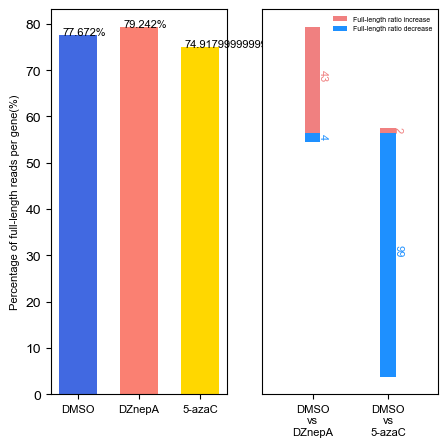

In [174]:
fig, ax = plt.subplots(1,2, figsize=(5,5))
x = [0.4,1.2,2.0]
for p,s in zip(x,y):
    ax[0].text(p-0.2,s,s=f"{s}%", fontsize=8)
ax[0].bar(x=x, height=y, color=cl.values(), width=0.5)
ax[0].set_ylabel("Percentage of full-length reads per gene(%)", fontsize=8)
ax[0].set_xticks(ticks=x, labels=["DMSO","DZnepA","5-azaC"], fontsize=8)

wd = 0.3
ax[1].bar(x=[0,1.5],height=[len(du), len(au)], color="lightcoral", width=wd)
###
ax[1].text(x=0.1, y=len(du)/2, s=len(du), rotation=270, color="lightcoral", fontsize=8)
ax[1].text(x=0.1, y=-len(dd)/2, s=len(dd), rotation=270, color="dodgerblue", fontsize=8)
###
ax[1].bar(x=[0,1.5],height=[-len(dd), -len(ad)], color="dodgerblue", width=wd)
ax[1].text(x=1.6, y=len(au)/2, s=len(au), rotation=270, color="lightcoral", fontsize=8)
ax[1].text(x=1.6, y=-len(ad)/2, s=len(ad), rotation=270, color="dodgerblue", fontsize=8)
ax[1].set_yticks([])
###

ticks = [int(x) for x in np.linspace(0,600,4)]
labels = ticks[::-1] + ticks
labels.remove(0)
ax[1].set_xticks(ticks=[0,1.5], labels=["DMSO\nvs\nDZnepA", "DMSO\nvs\n5-azaC"], fontsize=8)
ax[1].set_xlim(-1,2.5)
ax[1].legend(["Full-length ratio increase", "Full-length ratio decrease"], fontsize=5, frameon=False)
#plt.savefig("Full-ratio-noncoding.pdf", bbox_inches="tight")

Text(0.5, 0, 'Full-length ratio per gene in DMSO')

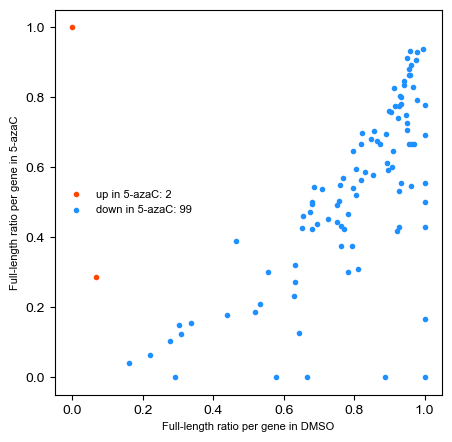

In [175]:
fig, ax = plt.subplots(1, figsize=(5,5))
##### vsDZnepA
ax.scatter(x=du["DMSO-ratio"], y=du["DZnepA-ratio"], s=9, label=f"up in DZnepA: {len(du)}", color="orangered")
ax.scatter(x=dd["DMSO-ratio"], y=dd["DZnepA-ratio"], s=9, label=f"down in DZnepA: {len(dd)}", color="dodgerblue")
ax.legend(frameon=False, fontsize=8)
ax.set_ylabel("Full-length ratio per gene in DZnepA", fontsize=8)
ax.set_xlabel("Full-length ratio per gene in DMSO", fontsize=8)
#plt.savefig("noncoding-Full-length-percent-VS-DZnepA.pdf", bbox_inches="tight")

##### clear
plt.cla()

##### vs5-azaC
ax.scatter(x=au["DMSO-ratio"], y=au["5-azaC-ratio"], s=9, label=f"up in 5-azaC: {len(au)}", color="orangered")
ax.scatter(x=ad["DMSO-ratio"], y=ad["5-azaC-ratio"], s=9, label=f"down in 5-azaC: {len(ad)}", color="dodgerblue")
ax.legend(frameon=False, fontsize=8)
ax.set_ylabel("Full-length ratio per gene in 5-azaC", fontsize=8)
ax.set_xlabel("Full-length ratio per gene in DMSO", fontsize=8)

#plt.savefig("noncoding-Full-length-percent-5-azaC.pdf", bbox_inches="tight")

### m6A in LncRNA

In [176]:
def get_str(df, gff_data):
    gene = df["gene_name"]
    return gff_data[gene]["strand"]


def get_motif(df, motif):
    gene, pos = df["gene_name"], df["position"]
    return motif[gene][pos]


def get_gff_data(gff_fp):
    gff_data = defaultdict(dict)
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "transcript":
                gene = re.findall("ID=(.*?);", info[-1])[0]
                gff_data[gene] = []
            else:
                transcipt_id = des.split("=")
                cd = abs(int(st) - int(ed)) + 1
                gff_data[gene].append([int(st), int(ed), cd])
    return gff_data


def get_rel(df, exon_len):
    gene, value = df["gene_name"], df["distance"]
    return value / exon_len[gene]


def get_label(df, gff_data):
    gene, strand, pos = df["gene_name"], df["strand"], df["position"]
    n = 1
    flag = 0
    for value in gff_data[gene]:
        st, ed, cd = value
        if st <= pos <= ed:
            if strand == "+":
                rel_site = pos - st + flag
            else:
                rel_site = abs(pos - ed) + flag
            return f"exon{n}", rel_site
        else:
            flag += cd
        n += 1
    return np.nan, np.nan

In [218]:
site_m6a, gene_m6a = {}, {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    fp = f"/media/Sorata/data3/bamboo/8_noncoding/6_nanom6A/{sample}"
    site_m6a[sample], gene_m6a[sample] = get_ratio_data(fp)

In [177]:
fp = "/media/Sorata/data3/bamboo/8_noncoding/noncoding.gff"
gff_data = get_gff_data(fp)

In [178]:
motif = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample
    motif[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/8_noncoding/6_nanom6A/{sample}/genome_abandance.0.5.bed"
    with open(fn, 'r') as f:
        for line in f:
            chrom, pos, gene, read, p2, m = line.rstrip().split("\t")
            if gene == "NA":
                continue
            pos =  int(pos)
            motif[na][gene].setdefault(pos, m)

In [179]:
data = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample 
    data[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/8_noncoding/6_nanom6A/{sample}/ratio.0.5.normalized.tsv"
    n = 0
    with open(fn, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            for value in info[1:]:
                site, mod, tot, ratio = value.split("|")
                data[na][n]["gene_name"] = gene
                data[na][n]["scaffold"] = chrom
                data[na][n]["position"] = int(site) 
                data[na][n]["mod_num"] = int(mod) 
                data[na][n]["total_num"] = int(tot)
                data[na][n]["mod_ratio"] = float(ratio)
                n += 1

In [180]:
totol_df = {}
for sample, value in data.items():
    ratio_df = pd.DataFrame.from_dict(value, orient="index")
    ratio_df["strand"] = ratio_df.apply(lambda x:lnc_strand[x["gene_name"]], axis=1)
    ratio_df["motif"] = ratio_df.apply(get_motif, args=(motif[sample],), axis=1)
    ratio_df[["label","distance"]] = ratio_df.apply(get_label, args=(lnc_gff_data,), axis=1, result_type="expand")
    ratio_df["rel_pos"] = ratio_df.apply(get_rel, args=(exon_len,), axis=1)
    totol_df[sample] = ratio_df
    ratio_df[ratio_df["label"].notna()].to_csv(f"Single-m6A-site-{sample}-in-noncoding.ratio", sep="\t", index=False)
    #ratio_df[ratio_df["label"].notna()].to_csv(f"Single-m6A-site-{sample}.ratio", sep="\t", index=False)


#### m6A boxplot

Text(0, 0.5, 'Ratio of m6A modification')

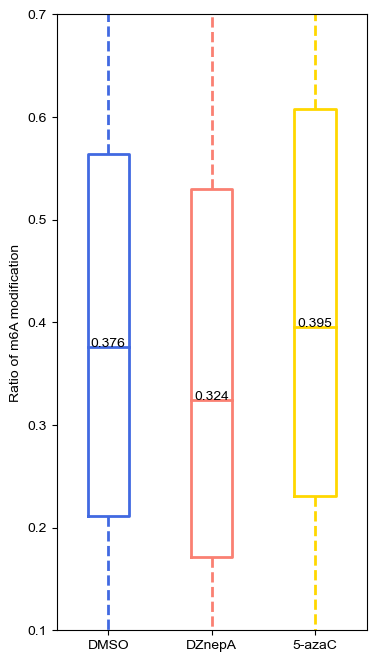

In [189]:
fig, ax = plt.subplots(1, figsize=(4,8))

sample = []
med = []
for na, value in totol_df.items():
    ratios = value["mod_ratio"].tolist()
    sample.append(ratios)
    med.append(np.median(ratios))
    
colors = cl.values()
colors_r = ['royalblue', 'royalblue', 'salmon', 'salmon', 'gold', 'gold']
labels = cl.keys()
pos = [1,2,3]

plt.ylim(0.1,0.7)
bplot = plt.boxplot(sample, patch_artist=False, labels=labels,widths=0.4, positions=pos)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')

for value, p in zip(med, pos):
    ax.text(p-0.17, value, s=round(value, 3))

ax.set_ylabel("Ratio of m6A modification")
#plt.savefig("noncoding-m6A-ratio.pdf", bbox_inches="tight")

#### m6A distribution in lncRNA and coding-RNA

In [195]:
def get_gff_data(gff_fp):
    import re
    gff_data = defaultdict(dict)
    gff_strand, exon_len = {}, {}
    with open(gff_fp, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            info = line.rstrip().split('\t')
            chrome, org, ty, st, ed, point, strand, o, des = info
            if info[2] == "mRNA":
                gene = re.findall("ID=(.*?);", info[-1])[0].split(".")[0]
                gff_strand[gene] = strand
                gff_data[gene] = []
            elif info[2] == "exon":
                exon_len.setdefault(gene, 0)
                transcipt_id = des.split("=")
                cd = abs(int(st) - int(ed)) + 1
                exon_len[gene] += cd
                gff_data[gene].append([int(st), int(ed), cd])
    return gff_data, gff_strand, exon_len


fp = "/media/Sorata/win/genome/Bamboo.Hic.gff"
gff_data, gff_strand, exon_len = get_gff_data(fp)

In [196]:
motif = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample
    motif[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}/genome_abandance.0.5.bed"
    with open(fn, 'r') as f:
        for line in f:
            chrom, pos, gene, read, p2, m = line.rstrip().split("\t")
            if gene == "NA":
                continue
            pos =  int(pos)
            motif[na][gene].setdefault(pos, m)
data = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    na = sample 
    data[na] = defaultdict(dict)
    fn = f"/media/Sorata/data3/bamboo/5_highQ/nanom6A/{sample}/ratio.0.5.normalized.tsv"
    n = 0
    with open(fn, 'r') as f:
        for line in f:
            info = line.rstrip().split("\t")
            gene, chrom = info[0].split("|")
            if gene == "NA":
                continue
            for value in info[1:]:
                site, mod, tot, ratio = value.split("|")
                data[na][n]["gene_name"] = gene
                data[na][n]["scaffold"] = chrom
                data[na][n]["position"] = int(site) 
                data[na][n]["mod_num"] = int(mod) 
                data[na][n]["total_num"] = int(tot)
                data[na][n]["mod_ratio"] = float(ratio)
                n += 1

In [197]:
totol_df = {}
for sample, value in data.items():
    ratio_df = pd.DataFrame.from_dict(value, orient="index")
    ratio_df["strand"] = ratio_df.apply(lambda x:gff_strand[x["gene_name"]], axis=1)
    ratio_df["motif"] = ratio_df.apply(get_motif, args=(motif[sample],), axis=1)
    ratio_df[["label","distance"]] = ratio_df.apply(get_label, args=(gff_data,), axis=1, result_type="expand")
    ratio_df["rel_pos"] = ratio_df.apply(get_rel, args=(exon_len,), axis=1)
    totol_df[sample] = ratio_df
    ratio_df[ratio_df["label"].notna()].to_csv(f"Single-m6A-site-{sample}-in-coding-rna.ratio", sep="\t", index=False)
    #ratio_df[ratio_df["label"].notna()].to_csv(f"Single-m6A-site-{sample}.ratio", sep="\t", index=False)

In [198]:
coding_df = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    p = pd.read_csv(f"Single-m6A-site-{sample}-in-coding-rna.ratio", sep="\t")
    coding_df[sample] = p

In [199]:
noncoding_df = {}
for sample in ["DMSO", "DZnepA", "5-azaC"]:
    p = pd.read_csv(f"Single-m6A-site-{sample}-in-noncoding.ratio", sep="\t")
    noncoding_df[sample] = p

Text(0.5, 0, 'm6A distribution on noncoding transcript')

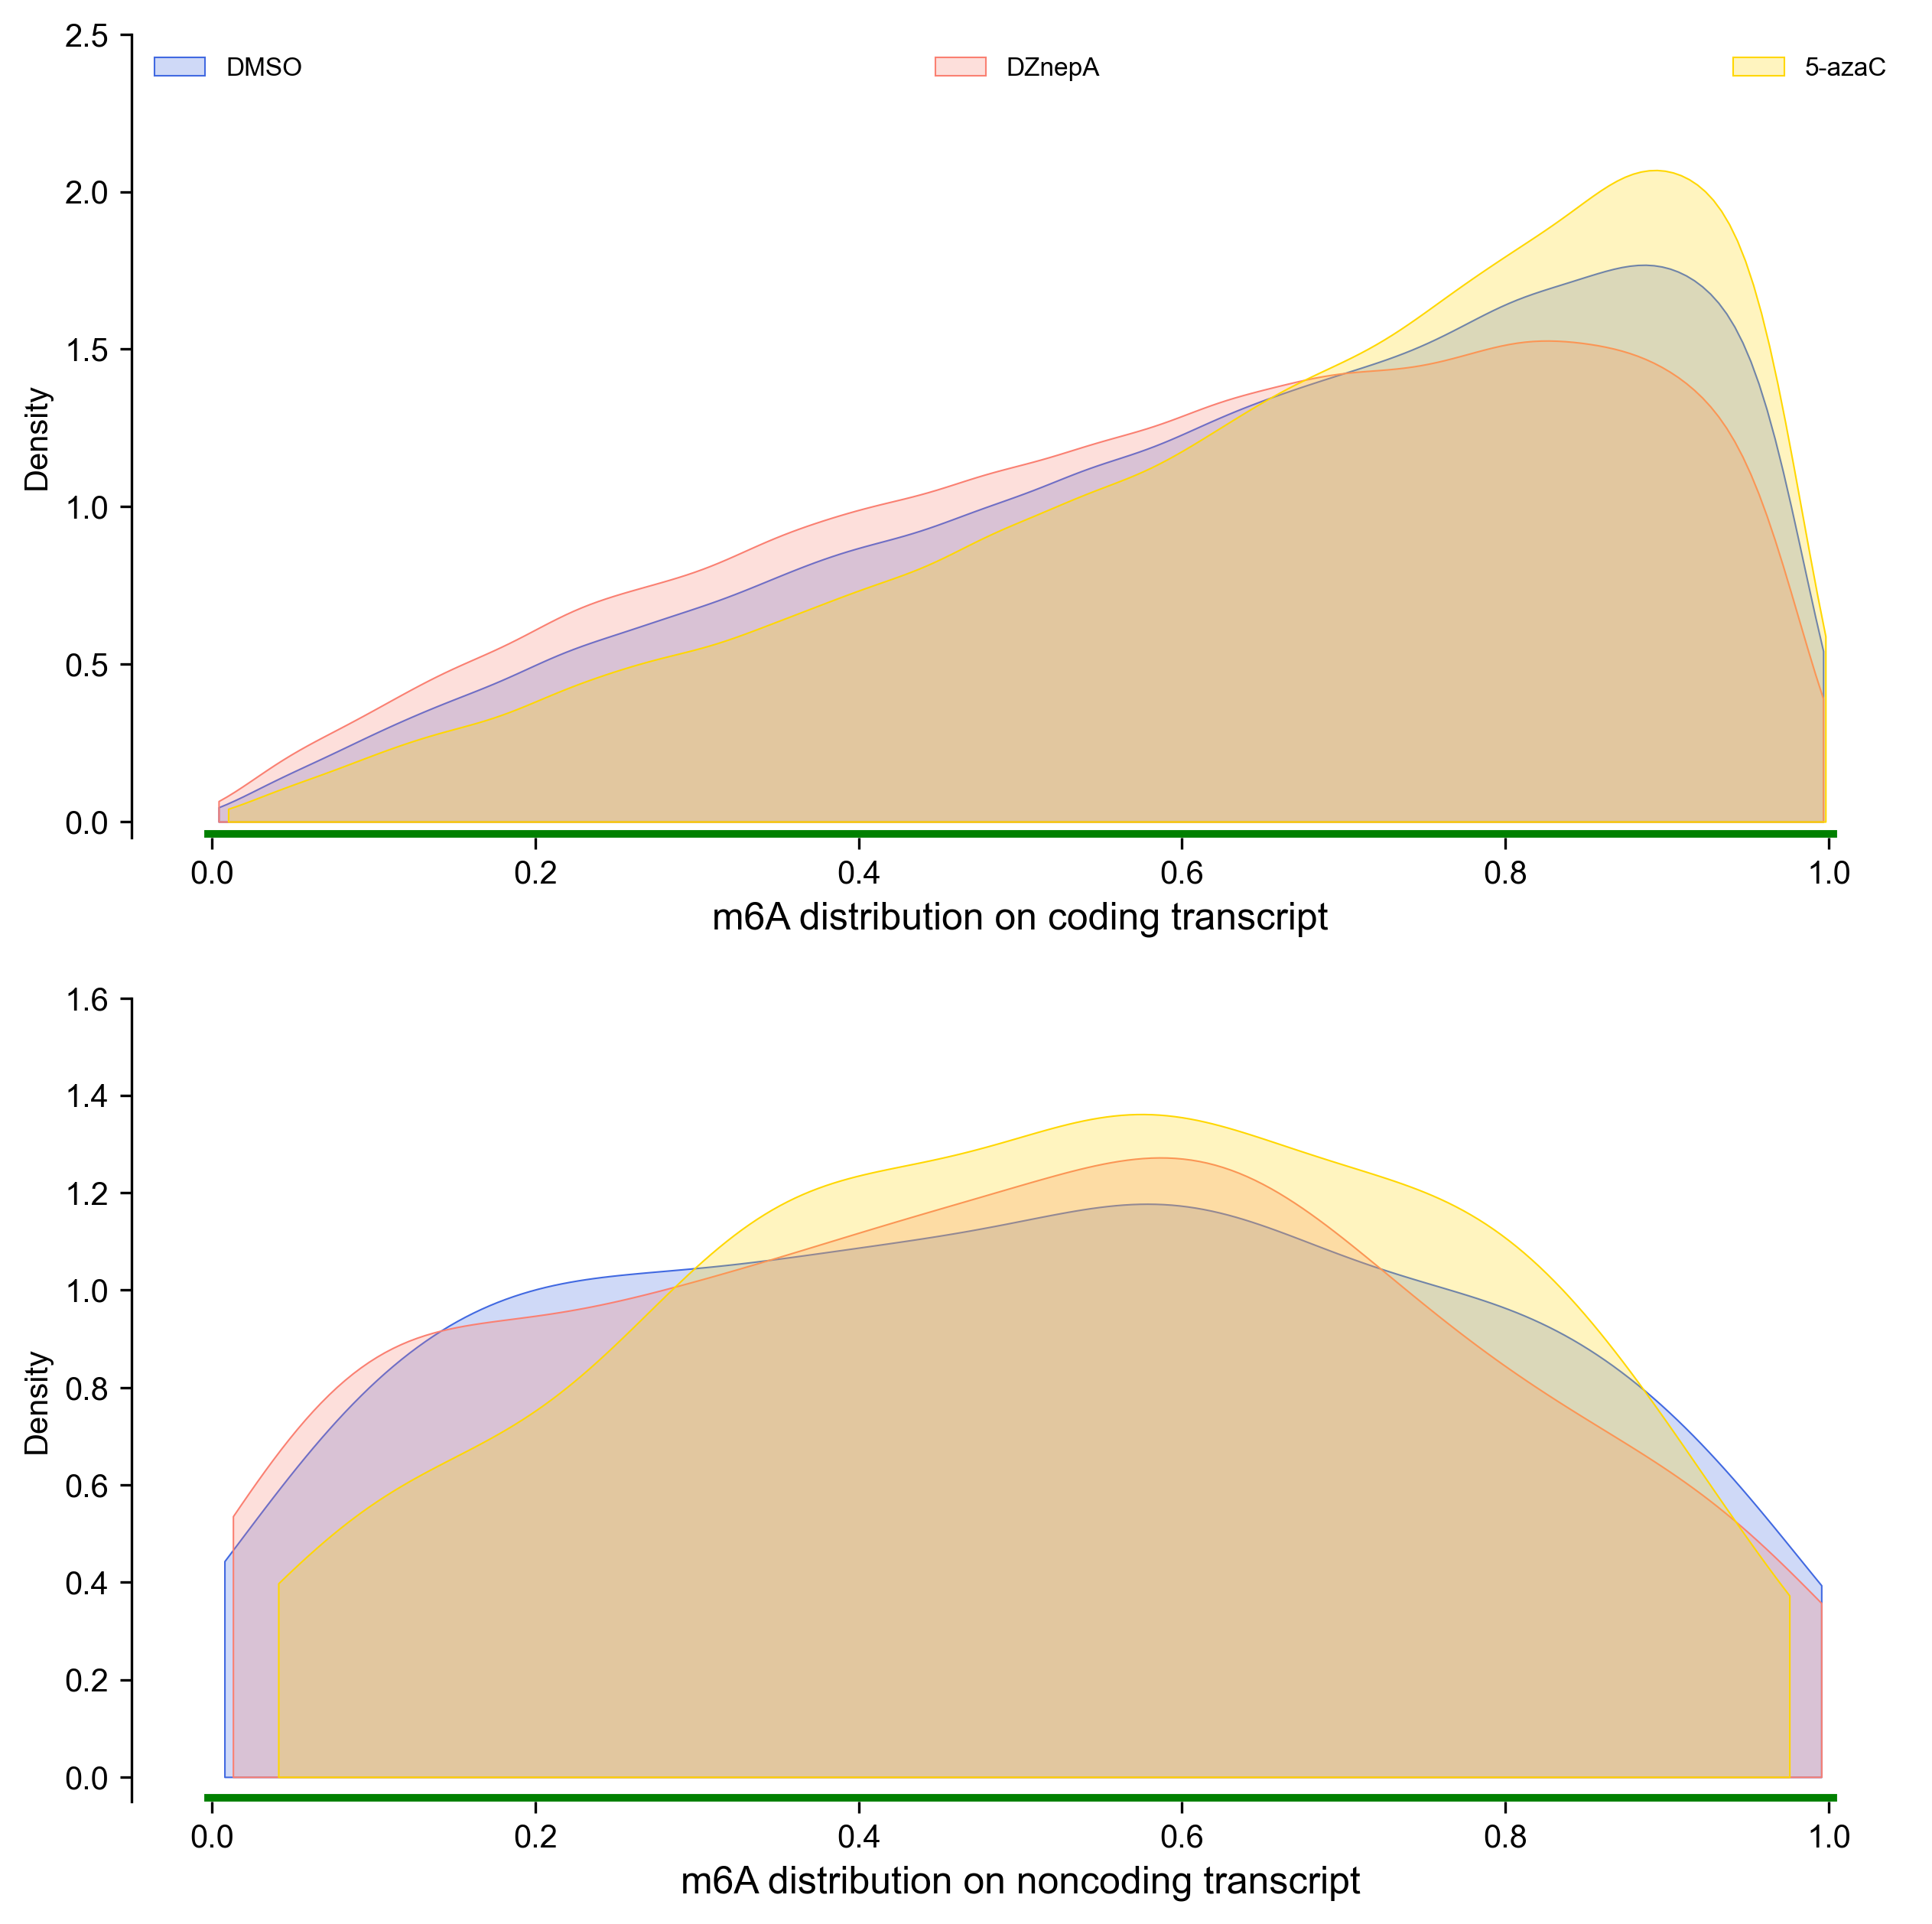

In [200]:
fig, ax = plt.subplots(2,1, figsize=(10, 10), dpi=300)
y = -0.05


for sample, values in coding_df.items():
    #res = trans_region(data, fc)
    sns.kdeplot(values["rel_pos"],  cut=0, fill=True, color=cl[sample], label=sample, ax=ax[0], lw=.5)
    

ax[0].legend(fontsize=8, frameon=False, ncol=3, loc=2, mode="expand")
ax[0].plot([0,1],[y,y], linewidth=5, color="green")
ax[0].set_ylim(-y-0.1,2.5)
ax[0].spines[["top", "bottom", "right"]].set_color(None)
ax[0].set_xlabel("m6A distribution on coding transcript", fontsize=12)


for sample, values in noncoding_df.items():
    #res = trans_region(data, fc)
    sns.kdeplot(values["rel_pos"],  cut=0, fill=True, color=cl[sample], label=sample, ax=ax[1], lw=.5)
    #sns.histplot(values["rel_pos"], color=cl[sample], bins=100)
#ax[1].legend(fontsize=8, frameon=False, ncol=3, loc=2, mode="expand")
ax[1].plot([0,1],[y,y], linewidth=5, color="green")
ax[1].set_ylim(-y-0.1,1.6)
ax[1].spines[["top", "bottom", "right"]].set_color(None)
ax[1].set_xlabel("m6A distribution on noncoding transcript", fontsize=12)

#plt.savefig("Distribution of m6A in noncoding and coding transcript.pdf", bbox_inches="tight")

### Differential expressed lncRNA

In [232]:
azaC = pd.read_csv("Date-Save/5-azaC_EdgeR_noncoding.txt", index_col=0, sep="\t")
dznepA = pd.read_csv("Date-Save/DZnepA_EdgeR_noncoding.txt", index_col=0, sep="\t")

In [234]:
data = dznepA
sample = "DZnepA"
fc = 1.5
fdr = 0.05

Text(0.5, 1.0, 'Different noncoding RNA in DZnepA VS DMSO')

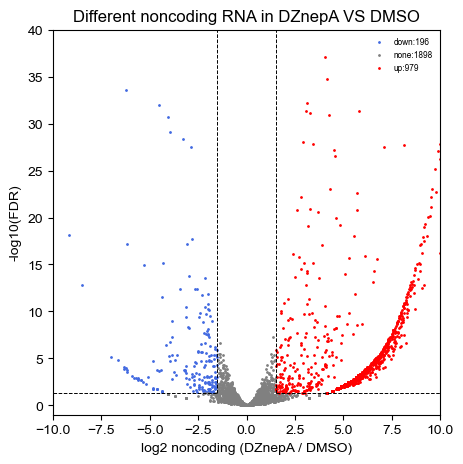

In [235]:
fig, ax = plt.subplots(1, figsize=(5,5))


colors = {"none":"grey", "Normal":"black", "down":"royalblue", "up":"r"}

for tag, genes in data.groupby("sig"):
    ax.scatter(genes["logFC"],np.log10(genes["FDR"])*-1, s=1, color=colors[tag], label=f"{tag}:{len(genes)}")


xlim = 10
ylim = 40
yaxis = -np.log10(fdr)
ax.set_ylim(-1, ylim)
ax.set_xlim(-xlim, xlim)
ax.plot([fc,fc],[yaxis, ylim], linewidth=.7, ls="--", color="black")
ax.plot([-fc,-fc],[yaxis, ylim], linewidth=.7, ls="--", color="black")
ax.plot([-xlim,-fc],[yaxis, yaxis], linewidth=.7, ls="--", color="black")
ax.plot([fc,xlim],[yaxis, yaxis], linewidth=.7, ls="--", color="black")
ax.legend(frameon=False, fontsize=6)
ax.set_xlabel(f"log2 noncoding ({sample} / DMSO)")
ax.set_ylabel("-log10(FDR)")
ax.set_title(f"Different noncoding RNA in {sample} VS DMSO")
#plt.savefig(f"Volcanplot showing differertial expressed noncoding RNA in {sample}.pdf", bbox_inches="tight")

#### m6a in DE LncRNA

In [250]:
sample = "DZnepA"

In [252]:
m6asites = pd.DataFrame.from_dict(site_m6a)
m6asites["gene"] = m6asites.apply(lambda x:x.name.split("_")[0], axis=1)
m6asites

DMSO    DZnepA    5-azaC          gene
STRG.52857.2_14750074  0.082474       NaN       NaN  STRG.52857.2
STRG.52857.2_14750947  0.274123  0.300926  0.288136  STRG.52857.2
STRG.52857.2_14751283  0.050505  0.077253       NaN  STRG.52857.2
STRG.52857.2_14751437  0.027125       NaN       NaN  STRG.52857.2
STRG.52857.2_14751487  0.068966  0.089888       NaN  STRG.52857.2
...                         ...       ...       ...           ...
STRG.35615.1_22830176       NaN       NaN  0.110497  STRG.35615.1
STRG.16831.2_44592084       NaN       NaN  0.186275  STRG.16831.2
STRG.15539.1_3001164        NaN       NaN  0.789474  STRG.15539.1
STRG.28581.1_82284761       NaN       NaN  0.882353  STRG.28581.1
STRG.2619.1_7933971         NaN       NaN  0.182927   STRG.2619.1

[934 rows x 4 columns]

down 0.7424530921046836
up 0.0026389684254323016


Text(0, 0.5, 'm6A ratio of single site')

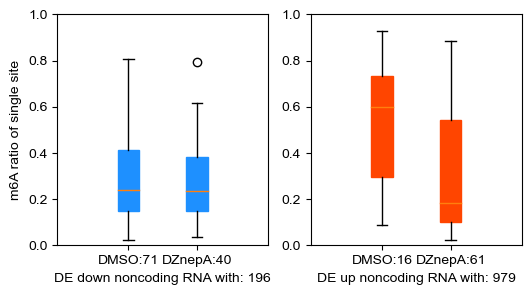

In [253]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=100)
n = 0
width = 0.4
pos = [width, width+width*1.2]
colors = {"up":"orangered", "down":"dodgerblue"}
for tag in ["down", "up"]:
    values1 = data[data["sig"] == tag]
    values = m6asites[m6asites["gene"].isin(values1.index)]
    control, compare = values["DMSO"].dropna(), values[f"{sample}"].dropna()
    s, p = stats.mannwhitneyu(control, compare)
    print(tag, p)
    box = ax[n].boxplot([control, compare ], labels=[f"DMSO:{len(control)}", f"{sample}:{len(compare)}"], patch_artist=True, positions=pos)
    ax[n].set_xlabel(f"DE {tag} noncoding RNA with: {len(values1)}")
    ax[n].set_ylim(0, 1)
    [patch.set_color(colors[tag]) for patch in box["boxes"]]
    n += 1
ax[0].set_ylabel("m6A ratio of single site")
#plt.savefig(f"DE noncoding site m6a in {sample}.pdf", bbox_inches="tight")

#### Full-length ratio in DE LncRNA

In [254]:
full_data = defaultdict(dict)
num = 10
for sam, samples in assign.groupby("sample"):
    for gene, genes in samples.groupby("Assigned_gene"):
        if len(genes) <= num:
            continue
        for tag, reads in genes.groupby("Full_length"):
            if tag:
                full_data[sam][gene] = len(reads) / len(genes)

In [255]:
full_data = pd.DataFrame.from_dict(full_data)

In [256]:
data["DMSO_full"] = data.apply(lambda x:full_data["DMSO"].get(x.name), axis=1)
data[f"{sample}_full"] = data.apply(lambda x:full_data[sample].get(x.name), axis=1)

down 0.8031465532509088
up 0.45246860350317697


Text(0, 0.5, 'Gene full-length ratio')

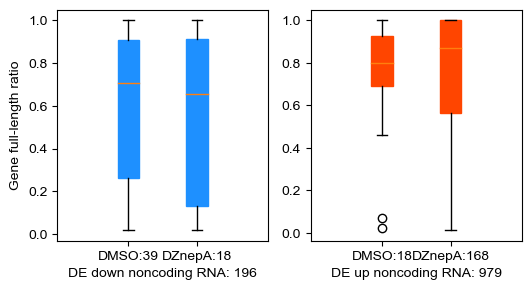

In [257]:
fig, ax = plt.subplots(1,2, figsize=(6,3),dpi=100)
n = 0
width = 0.4
pos = [width, width+width*1.2]
colors = {"up":"orangered", "down":"dodgerblue"}
for tag in ["down", "up"]: 
    values = data[data["sig"] == tag]
    control, compare = values["DMSO_full"].dropna(), values[f"{sample}_full"].dropna()
    s, p = stats.mannwhitneyu(control, compare)
    print(tag, p)
    box = ax[n].boxplot([control, compare ], labels=[f"DMSO:{len(control)}", f"{sample}:{len(compare)}"], patch_artist=True, positions=pos)
    ax[n].set_xlabel(f"DE {tag} noncoding RNA: {len(values)}")
    #ax[n].set_xlim(0, width+width*2.4)
    [patch.set_color(colors[tag]) for patch in box["boxes"]]
    n += 1
ax[0].set_ylabel("Gene full-length ratio")
#plt.savefig(f"DE noncoding gene full-length ratio in {sample}.pdf", bbox_inches="tight")

# OVER

# Thank you for reading my code.